<a href="https://colab.research.google.com/github/icsd13152/Thesis_MSC_in_AI_AuthorVerif/blob/main/Thesis_MSC_IN_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libs

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
!export PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.7,max_split_size_mb:128
from google.colab import drive
import sys
import numpy as np
# import spacy
from torch.autograd import Variable
from sklearn.metrics import f1_score
!pip install transformers
!pip install pytorch-pretrained-bert
# !python -m spacy download en_core_web_trf
!python -m spacy download en_core_web_lg
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, random_split
!pip install -qU transformers sentence-transformers
from sentence_transformers.losses.ContrastiveLoss import SiameseDistanceMetric
from sentence_transformers import SentenceTransformer, models
# from sentence_transformers.losses import ContrastiveLoss
import torch
import torch.nn as nn
from torch.nn import functional as F
# from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from transformers import BertTokenizer, RobertaModel,BertModel,BertTokenizerFast,T5Model
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW,get_linear_schedule_with_warmup
import random
import matplotlib as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import gc
from sklearn.manifold import TSNE
import nltk
nltk.download('punkt')
!pip install pytorch_metric_learning
import  pytorch_metric_learning
from pytorch_metric_learning import losses,distances
gc.collect()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-04-01 08:52:03.741360: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-01 08:52:03.798438: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 08:52:04.795772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https:/

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


41

## Implementation Start

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_path = '/content/drive/MyDrive/Thesis'

In [ ]:
gc.collect()

66

In [4]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# bertModel= RobertaModel.from_pretrained('roberta-base',output_hidden_states = True)
bertModel= BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True)#,output_hidden_states = True
# bertModel= T5Model.from_pretrained('t5-base',output_hidden_states = True)
bertModel.train()
# bertModel = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2,output_hidden_states = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
gc.collect()

30

In [5]:
# Learning rate (Adam): 5e-5, 3e-5, 2e-5 based on authors
# loss_margin = 0.5
learning_rate = 2e-5
epsilon = 1e-8
batch_size = 16
n_epochs = 2
num_warmup_steps = 0
num_training_steps = 52623 #len(data)*n_epochs
patience = 1
# fully_connected_layer_units = 128

In [5]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def createPairsWithSEPToken(ids1,masks1,ids2,masks2,label,combinations='one-by-one'):
    rlabels = []
    rIds = []
    rMasks = []
    if combinations=='one-by-one':
       for idx in range(len(ids1)):
           if idx <= len(ids2)-1:
             rIds.append(torch.cat((ids1[idx],ids2[idx]),0))
             rMasks.append(torch.cat((masks1[idx],masks2[idx]),0))
             rlabels.append(label)
           elif idx >= len(ids2):
             i = random.randint(0, len(ids2)-1)
             rIds.append(torch.cat((ids1[idx],ids2[i]),0))
             rMasks.append(torch.cat((masks1[idx],masks2[i]),0))
             rlabels.append(label)  
    elif combinations=='all':
       for idx in range(len(ids1)):
          for j in range(len(ids2)):
              rIds.append(torch.cat((ids1[idx],ids2[j]),0))
              rMasks.append(torch.cat((masks1[idx],masks2[j]),0))
              rlabels.append(label)

    return rIds, rMasks, rlabels

def createSeperatePairs(ids1,masks1,ids2,masks2,label,combinations='one-by-one'):
    rlabels = []
    rIds = []
    rMasks = []
    rIds2 = []
    rMasks2 = []
    if combinations=='one-by-one':
       for idx in range(len(ids1)):
           if idx <= len(ids2)-1:
             rIds.append(ids1[idx])
             rMasks.append(masks1[idx])
             rIds2.append(ids2[idx])
             rMasks2.append(masks2[idx])
             rlabels.append(label)
           elif idx >= len(ids2):
             i = random.randint(0, len(ids2)-1)
             rIds.append(ids1[idx])
             rMasks.append(masks1[idx])
             rIds2.append(ids2[i])
             rMasks2.append(masks2[i])
             rlabels.append(label)  
    elif combinations=='all':
       for idx in range(len(ids1)):
          
          for j in range(len(ids2)):
              rIds.append(ids1[idx]) 
              rMasks.append(masks1[idx])
              rIds2.append(ids2[j]) 
              rMasks2.append(masks2[j])
              rlabels.append(label)

    return rIds, rMasks, rIds2, rMasks2,rlabels


# Read Data PAN 20

In [ ]:
import pickle
import re
import torch
from torch.nn import functional as F
from transformers import RobertaTokenizer
# import emojis
import spacy
import random
from nltk.probability import FreqDist
from tqdm import tqdm
##################
# Class for corpus
##################
class Corpus(object):

    def __init__(self, dict_dataset):

        # define tokenizer
        self.tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        # self.tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
        # raw dataset
        self.dict_dataset_raw = dict_dataset

        self.dict_dataset_per_auth_ids= {}
        self.dict_dataset_per_auth_masks= {}
        self.dict_dataset_per_auth_ids2= {}
        self.dict_dataset_per_auth_masks2= {}
        self.dict_dataset_per_auth_idsFirst= {}
        self.dict_dataset_per_auth_masksFirst= {}
        self.dict_positives_pairs = {}
        self.dict_negatives_pairs = {}
        self.dict_All_pairs = {}
        self.dict_All_pairs_shuffle = {}
        self.usedAuthors = {}
        self.dict_pairs_per_author = {}
        self.ner = spacy.load('en_core_web_lg')
        print(self.ner.pipe_names)
        self.ner.disable_pipes('tagger', 'parser','tok2vec', 'parser', 'attribute_ruler', 'lemmatizer')
        print(self.ner.pipe_names)
        self.list_of_non_freq_words = []
    

    def getNonFrequentWordsPerDoc(self,doc,threshold=5):
        words = nltk.word_tokenize(doc)
        fdist = FreqDist(words)

        for word,freq in fdist.items():
            if freq <= threshold:
                # if len(word) > 4:
                self.list_of_non_freq_words.append(word)

    def replaceTokensWith(self,text,symbol='2'):
        for token in self.list_of_non_freq_words:
            text = text.replace(token,symbol)
        return text


            
    def paddingChunksToMaxlen(self,IdsChunks,masksChunks,isSecond = False,maxLen = 126):#listMasksChunks
        listIdsChunks = list()
        listMasksChunks = list()

        for i in range(len(IdsChunks)):

            pad_len = maxLen  - IdsChunks[i].shape[0]

            tmplistids = IdsChunks[i].tolist()
            if len(tmplistids) < maxLen:
                if i > 0: #from second element
                    temp = IdsChunks[i-1].tolist()
                    lenToadd = maxLen - len(tmplistids)
                    # print("=================================")
                    # print("prev = ",str(len(temp)))
                    # print("curr = ", str(len(tmplistids)))

                    if len(temp) >= lenToadd:

                        tmplistids = temp[len(temp)-lenToadd:len(temp)] + tmplistids
                        pad_len = maxLen  - len(tmplistids)
                    else:
                        tmplistids = temp + tmplistids
                        pad_len = maxLen  - len(tmplistids)
                else:
                    tmplistids = tmplistids
                    pad_len = maxLen  - len(tmplistids)
            elif len(tmplistids) == maxLen:
                tmplistids = tmplistids
                pad_len = maxLen  - len(tmplistids)
            # if isSecond == False:
            tmplistids.insert(0,101) #101 for BERT 0 for roberta
            tmplistids.insert(len(tmplistids),102) #102 for Bert 2 for roberta
            # print("after = ",str(len(tmplistids)))
            # print("=================================")
            tmplistmasks = masksChunks[i].tolist()#listmasks[i].tolist()
            if len(tmplistmasks) < maxLen:
                if i > 0: #from second element
                    temp = masksChunks[i-1].tolist()
                    lenToadd = maxLen - len(tmplistmasks)
                    if len(temp) >= lenToadd:
                        tmplistmasks = temp[len(temp)-lenToadd:len(temp)] + tmplistmasks
                    else:
                        tmplistmasks = temp + tmplistmasks
                else:
                    tmplistmasks = tmplistmasks

            elif len(tmplistmasks) == maxLen:
                tmplistmasks = tmplistmasks
            # if isSecond == False:
            tmplistmasks.insert(0,1)
            tmplistmasks.insert(len(tmplistmasks),1)
            # print(tmplistids)
            # if len(tmplistids) > 128:
            listIdsChunks.append(torch.LongTensor(tmplistids))
            listMasksChunks.append(torch.LongTensor(tmplistmasks))
            del tmplistmasks, tmplistids

            if pad_len > 0:

                listIdsChunks[i] =  F.pad(listIdsChunks[i], (0,pad_len), "constant", 0) # 0 for bert 1 for roberta
                listMasksChunks[i] =  F.pad(listMasksChunks[i], (0,pad_len), "constant", 0)
        del IdsChunks, masksChunks, pad_len
        # gc.collect()
        return listIdsChunks ,listMasksChunks

    def createRandomSetence(self,listOfSetences):
        tmpList = []
        for x in listOfSetences:
            tmpValue = random.choice(listOfSetences)
            tmpList.append(tmpValue)
        sete = ' '.join(tmpList)
        return sete

    def chunkingTextsBasedOnBert(self,text):
       


        # setences1 = nltk.sent_tokenize(text)
        # setences2 = nltk.sent_tokenize(row['Text2'])
        # # print(setences1)
        # set1 = self.createRandomSetence(setences1)
        # # print(set1)
        # set2 = createRandomSetence(setences2)
       
        encoded_dict = self.tokenizer.encode_plus(
                                        text ,                    # Sentence to encode.
                                        add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                                        # max_length = 512,           # Pad & truncate all sentences.
                                        # pad_to_max_length = True,
                                        # truncation = True,
                                        return_attention_mask = True,   # Construct attn. masks.
                                        return_tensors = 'pt',     # Return pytorch tensors.
                                        )

        # print(encoded_dict['input_ids'][0])
        tensorsIdList1,tensorsMaskList1 = self.paddingChunksToMaxlen(encoded_dict['input_ids'][0].split(510),encoded_dict['attention_mask'][0].split(510),False,510)
        # tensorsIdList1,tensorsMaskList1 = encoded_dict['input_ids'][0],encoded_dict['attention_mask'][0]
        # del encoded_dict


        # tensorsIdList1,tensorsMaskList1 = encoded_dict['input_ids'][0],encoded_dict['attention_mask'][0]
        # del encoded_dict

        return tensorsIdList1, tensorsMaskList1
        # return encoded_dict['input_ids'][0],encoded_dict['attention_mask'][0]

    def maskNumbers(self,text, symbol='1'):
        x = re.sub('[0-9]', symbol,text)
        return x
    def maskEntities(self,text,entities = ['GPE','FAC','PERSON','ORG','PRODUCT']):

      #GPE = Countries and Geo Location
      #FAC = Building airports etc
      #PERSON = Name of person
      #PRODCUT = products
      #ORG = Organization
      docText1 = self.ner(text)
      for ent in docText1.ents:
        if ent.label_ == 'PERSON':
              #  data["Text1"] = data["Text1"].apply(lambda row: row.replace(ent.text, 'David') ,meta=('Text1', 'object'))
               text = text.replace(ent.text, 'David')
        if ent.label_ == 'GPE':
               text = text.replace(ent.text, 'Mexico')

      return text
    def preprocess_doc(self, doc):
        doc = self.maskNumbers(doc)
        # doc = self.maskEntities(doc)
        # self.getNonFrequentWordsPerDoc(doc,threshold=5)
        # doc = self.replaceTokensWith(doc)
        return doc.strip()

    def parse_dictionary_v2(self):
        cnt = 0
        # authors
        print("Parse per author...for ",str(len(list(self.dict_dataset_raw.keys()))))
        for a in tqdm(self.dict_dataset_raw.keys()):
            # fandom categories
            listDocsPerAuthor = []
            listMasksPerAuthor = []
            for i, docs in enumerate(self.dict_dataset_raw[a]):
                print(docs)
                inputIDs1First,attn_masks1First,inputIDs1,attn_masks1 = self.chunkingTextsBasedOnBert(docs)
                flat_IDs = []
                flat_Masks = []
                    # flat_IDs2 = []
                    # flat_Masks2 = []
                # for item in inputIDs1:
                #     flat_IDs.append(item)
                # for item in attn_masks1:
                #     flat_Masks.append(item)

                listDocsPerAuthor.append(flat_IDs)
                listMasksPerAuthor.append(flat_Masks)
                if a not in self.dict_dataset_per_auth_ids.keys():
                    self.dict_dataset_per_auth_ids[a] = []
                if a not in self.dict_dataset_per_auth_masks.keys():
                    self.dict_dataset_per_auth_masks[a] = []

            self.dict_dataset_per_auth_ids[a] = listDocsPerAuthor  # authID:{[x1,x2,x3],[y1,y2...yn],...}
            self.dict_dataset_per_auth_masks[a] = listMasksPerAuthor

    def parse_dictionary(self,isval=False):
        cnt = 0
        # authors
        print("Parse per author...for ",str(len(list(self.dict_dataset_raw.keys()))))
        for a in tqdm(self.dict_dataset_raw.keys()):
            # fandom categories
            listDocsPerAuthor = []
            listMasksPerAuthor = []
            # print(a)
            # for f in self.dict_dataset_raw[a].keys():
            # documents
            # print(f)
            # print(self.dict_dataset_raw[a])
            itemid = 0

            for i, docs in enumerate(self.dict_dataset_raw[a]):
                        # processed_doc1 = self.preprocess_doc(docs,True)
                        # processed_doc2 = self.preprocess_doc(docs)
                        if len(docs) < 256:
                           print(a) 
                           break
                        processed_doc2 = self.preprocess_doc(docs)
                     
                        inputIDs1,attn_masks1 = self.chunkingTextsBasedOnBert(processed_doc2)
                        # flat_IDs = []
                        # flat_Masks = []
                        # print(inputIDs1)
                        # for item in inputIDs1:
                        #     flat_IDs.append(item)
                        # for item in attn_masks1:
                        #     flat_Masks.append(item)
                      
                        # listDocsPerAuthor.append(flat_IDs)
                        # listMasksPerAuthor.append(flat_Masks)
                        if a not in self.dict_dataset_per_auth_ids.keys():
                          self.dict_dataset_per_auth_ids[a] = {}
                        if itemid not in self.dict_dataset_per_auth_ids[a].keys():
                          self.dict_dataset_per_auth_ids[a][itemid] = {}
                        
                        if a not in self.dict_dataset_per_auth_ids2.keys():
                          self.dict_dataset_per_auth_ids2[a] = {}
                        if itemid not in self.dict_dataset_per_auth_ids2[a].keys():
                          self.dict_dataset_per_auth_ids2[a][itemid] = []
                        
                        if a not in self.dict_dataset_per_auth_masks.keys():
                          self.dict_dataset_per_auth_masks[a] = {}
                        if itemid not in self.dict_dataset_per_auth_masks[a].keys():
                          self.dict_dataset_per_auth_masks[a][itemid] = {}
                        if a not in self.dict_dataset_per_auth_masks2.keys():
                          self.dict_dataset_per_auth_masks2[a] = {}
                        if itemid not in self.dict_dataset_per_auth_masks2[a].keys():
                          self.dict_dataset_per_auth_masks2[a][itemid] = []
                        
                        # for item in listDocsPerAuthor:
                        #     for x in item:
                        # counter1 = 0
                        # for x in inputIDs1:
                        #     counter1+=1
                        #     if counter1 % 2 == 0 or counter1 == 1:
                        self.dict_dataset_per_auth_ids[a][itemid]= inputIDs1
                            # else:
                            #    self.dict_dataset_per_auth_ids2[a][itemid].append(x)  
                            #self.dict_dataset_per_auth_ids[a][itemid] = inputIDs1
                        # for item in listMasksPerAuthor:
                        #     for x in item:
                        # counter2 = 0
                        # for x in attn_masks1:
                        #     counter2+=1
                        #     if counter2 % 2 == 0 or counter2 == 1:
                        self.dict_dataset_per_auth_masks[a][itemid]=attn_masks1
                            # else:
                              #  self.dict_dataset_per_auth_masks2[a][itemid].append(x) 
                        # self.dict_dataset_per_auth_masks[a][itemid] = attn_masks1
                        itemid+=1       
            if isval==False:
              cnt+=1
              if cnt > 35001:
                break
            else:
              cnt+=1
              if cnt == 10531:
                break
            
            # for item in listDocsPerAuthor:
                # counter1 = 1
                        
                # for x in item:
                #     counter1+=1
                    
                #     if counter1 % 2 != 0:
                #         self.dict_dataset_per_auth_ids[a].append(x)
                #     else:
                #         if len(item)<2:
                #            self.dict_dataset_per_auth_ids[a].append(x) 
                        
                       
            # for item in listMasksPerAuthor:
                        
                # counter2 = 1
                # for x in item:
                #   counter2+=1
                #   if counter2 % 2 != 0:
                #        self.dict_dataset_per_auth_masks[a].append(x)
                #   else:
                #        if len(item)<2:
                #            self.dict_dataset_per_auth_masks[a].append(x) 
            
            # cnt+=1
            # if cnt==116:
            #   break
            
    

In [ ]:
import shutil
datasets = [base_path+'/PAN20/PAN20_per_author_doc'
             # 'dict_author_fandom_doc_val'
            ]


def shuffledict(big_dict):
    keys = list(big_dict.keys())
    
    random.shuffle(keys)

    Shuffled = dict()

    for key in keys:
        if key not in Shuffled.keys():
            Shuffled[key] = {}
        Shuffled[key]= big_dict[key]

    return Shuffled

def train_val_split(shuffledDict):


    tmp_train = {}
    tmp_val = {}
    for k,v in shuffledDict.items():
        
        if len(v) >= 2:
            n = int(0.85 * len(v))
            if k not in tmp_train.keys():
                tmp_train[k] = {}
                if k not in tmp_val.keys():
                    tmp_val[k] = {}

                tmp_train[k] = v[:n]
                tmp_val[k]=v[n:]
        elif len(v) == 1:
            if k not in tmp_train.keys():
                tmp_train[k] = {}
            tmp_train[k] = v

    return tmp_train,tmp_val

def train_val_split_perAuthor(shuffledDict):
    tmp_train = {}
    tmp_val = {}
    n = int(0.80 * len(list(shuffledDict.keys())))
    keys = list(shuffledDict.keys())
    train_keys = keys[:n]
    val_keys = keys[n:]
    for key in train_keys:
        if key not in shuffledDict.keys():
            tmp_train[key] = {}
        tmp_train[key]= shuffledDict[key]
    for key in val_keys:
        if key not in shuffledDict.keys():
            tmp_val[key] = {}
        tmp_val[key]= shuffledDict[key]

    return tmp_train,tmp_val



for dataset in datasets:


    ######
    # load
    ######
    with open( dataset, 'rb') as f:
        dict_dataset = pickle.load(f)
    print(len(list(dict_dataset.keys())))
    shuffled_data = shuffledict(dict_dataset)
    train,val = train_val_split_perAuthor(shuffled_data)
    print(len(list(train.keys())))
    print(len(list(val.keys())))
    ############
    # preprocess
    ############
    corpus = Corpus(dict_dataset=train)
    corpus.parse_dictionary(False)
    # corpus.create_pairs_per_author()#create_anchor_batches()#generatePairs()
    # corpus.generateLastDict()
    #######
    # store
    #######
    with open("PAN20_512_Notrunc_perAuth_uncased_train_ids_list", 'wb') as f:
        pickle.dump(corpus.dict_dataset_per_auth_ids, f)
    with open("PAN20_512_Notrunc_perAuth_uncased_train_masks_list", 'wb') as f:
        pickle.dump(corpus.dict_dataset_per_auth_masks, f)
    # with open("PAN20_512_Notrunc_perAuth_onlyNums_cased_train_ids_list2", 'wb') as f:
    #     pickle.dump(corpus.dict_dataset_per_auth_ids2, f)
    # with open("PAN20_512_Notrunc_perAuth_onlyNums_cased_train_masks_list2", 'wb') as f:
    #     pickle.dump(corpus.dict_dataset_per_auth_masks2, f)
    # with open( "PAN20_neg_pairs_512_train_overlapping", 'wb') as f:
    #     pickle.dump(corpus.dict_negatives_pairs, f)
    del corpus
    corpusval = Corpus(dict_dataset=val)
    corpusval.parse_dictionary(True)
    # corpusval.create_pairs_per_author_v2()#generatePairs()
    # # corpusval.generateLastDict()
    #
    with open( "PAN20_512_Notrunc_perAuth_uncased_val_ids_list", 'wb') as f:
        pickle.dump(corpusval.dict_dataset_per_auth_ids, f)
    with open( "PAN20_512_Notrunc_perAuth_uncased_val_masks_list", 'wb') as f:
        pickle.dump(corpusval.dict_dataset_per_auth_masks, f)
    # with open( "PAN20_512_Notrunc_perAuth_onlyNums_cased_val_ids_list2", 'wb') as f:
    #     pickle.dump(corpusval.dict_dataset_per_auth_ids2, f)
    # with open( "PAN20_512_Notrunc_perAuth_onlyNums_cased_val_masks_list2", 'wb') as f:
    #     pickle.dump(corpusval.dict_dataset_per_auth_masks2, f)
    # with open("PAN20_train_512_trunc_cased_222", 'wb') as f:
    #     pickle.dump(corpus.dict_pairs_per_author, f)#dict_pairs_per_author
    # # with open( "PAN20_neg_pairs_512_train_overlapping", 'wb') as f:
    # #     pickle.dump(corpus.dict_negatives_pairs, f)
    # del corpus
    # corpusval = Corpus(dict_dataset=val)
    # corpusval.parse_dictionary()
    # corpusval.create_pairs_per_author()#create_anchor_batches()#generatePairs()
    # # # corpusval.generateLastDict()    

    # with open( "PAN20_val_512_trunc_cased_222", 'wb') as f:
    #     pickle.dump(corpusval.dict_pairs_per_author, f)
    # with open( "PAN20_neg_pairs_512_val_overlapping", 'wb') as f:
    #     pickle.dump(corpusval.dict_negatives_pairs, f)
    # with open( dataset + "_processed_texts_test", 'wb') as f:
    #     pickle.dump(corpus.dict_dataset_per_auth_ids, f)
    del corpusval

52655
42124
10531


['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
['ner']
Parse per author...for  42124


 83%|████████▎ | 35001/42124 [28:36<05:49, 20.39it/s]


['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
['ner']
Parse per author...for  10531


100%|█████████▉| 10530/10531 [13:14<00:00, 13.25it/s]


In [ ]:
shutil.copy('PAN20_512_Notrunc_perAuth_uncased_train_ids_list','/content/drive/My Drive/Thesis/PAN20/ids_masks')
shutil.copy('PAN20_512_Notrunc_perAuth_uncased_train_masks_list','/content/drive/My Drive/Thesis/PAN20/ids_masks')
shutil.copy('PAN20_512_Notrunc_perAuth_uncased_val_ids_list','/content/drive/My Drive/Thesis/PAN20/ids_masks')
shutil.copy('PAN20_512_Notrunc_perAuth_uncased_val_masks_list','/content/drive/My Drive/Thesis/PAN20/ids_masks')

# shutil.copy('PAN20_512_Notrunc_perAuth_onlyNums_cased_train_ids_list2','/content/drive/My Drive/Thesis/PAN20/ids_masks')
# shutil.copy('PAN20_512_Notrunc_perAuth_onlyNums_cased_train_masks_list2','/content/drive/My Drive/Thesis/PAN20/ids_masks')
# shutil.copy('PAN20_512_Notrunc_perAuth_onlyNums_cased_val_ids_list2','/content/drive/My Drive/Thesis/PAN20/ids_masks')
# shutil.copy('PAN20_512_Notrunc_perAuth_onlyNums_cased_val_masks_list2','/content/drive/My Drive/Thesis/PAN20/ids_masks')

'/content/drive/My Drive/Thesis/PAN20/ids_masks/PAN20_512_Notrunc_perAuth_uncased_val_masks_list'

In [ ]:
import pickle
import random
def getPickleFileInDict(dataset):
    with open( dataset, 'rb') as f:
        dict_dataset = pickle.load(f)
    return dict_dataset


def splitDataset(mydata_pos,mydata_neg):
    n_pos = int(0.80 * len(mydata_pos.keys()))
    n_neg = int(0.80 * len(mydata_neg.keys()))
    data_train_pos = dict(list(mydata_pos.items())[:n_pos])
    data_train_neg = dict(list(mydata_neg.items())[:n_neg])

    data_val_pos = dict(list(mydata_pos.items())[n_pos:])
    data_val_neg = dict(list(mydata_neg.items())[n_neg:])
    # masks_val = dict(list(masks.items())[:n])

    return data_train_pos,data_train_neg,data_val_pos,data_val_neg

def generateLastDict(per_author_dataset_pos,per_author_dataset_neg):
        generalID = 0
        dict_All_pairs = dict()
        for posid in per_author_dataset_pos.keys():
            generalID+=1
            if generalID not in dict_All_pairs.keys():
                dict_All_pairs[generalID] = per_author_dataset_pos[posid]
            # dict_All_pairs[generalID].append()
        for negid in per_author_dataset_neg.keys():
            generalID+=1
            if generalID not in dict_All_pairs.keys():
                dict_All_pairs[generalID] = per_author_dataset_neg[negid]
            # dict_All_pairs[generalID].append()
        return dict_All_pairs   

In [ ]:
import pandas as pd

def convertdictToPandas(myDictIds,myDictMasks):
    data = pd.DataFrame(columns=['authId','textId','chunkId','Text','Mask','Label'],index=range(sum([len(myDictIds[a][k]) for a in myDictIds.keys() for k in myDictIds[a].keys()])))
    lab = 0
    idx = 0
    for auth in myDictIds.keys():
        
        # if len(list(myDictIds[auth].keys()))<2:
        #     print("Texts < 2")
        #     print(auth)
        #     print(myDictIds[auth].keys())
        for tId in myDictIds[auth].keys():
            
            
            if (len(myDictIds[auth][tId])<2):
                print("chunks < 2")
                print(auth)
                print(myDictIds[auth][tId])
            for chId in range(0,len(myDictIds[auth][tId])):
                
                data.loc[idx].authId = auth
                data.loc[idx].textId = tId
                data.loc[idx].chunkId = chId
                data.loc[idx].Text = myDictIds[auth][tId][chId]
                data.loc[idx].Mask = myDictMasks[auth][tId][chId]
                data.loc[idx].Label = lab
                idx+=1
                
        lab+=1
    return data
train_ids = base_path+'/PAN20/ids_masks/PAN20_512_Notrunc_perAuth_onlyNums_uncased_train_ids_list'
train_masks = base_path+'/PAN20/ids_masks/PAN20_512_Notrunc_perAuth_onlyNums_uncased_train_masks_list'
val_ids = base_path+'/PAN20/ids_masks/PAN20_512_Notrunc_perAuth_onlyNums_uncased_val_ids_list'
val_masks = base_path+'/PAN20/ids_masks/PAN20_512_Notrunc_perAuth_onlyNums_uncased_val_masks_list'
trainIds,valIds,trainMasks,valMasks = getPickleFileInDict(train_ids),getPickleFileInDict(val_ids),getPickleFileInDict(train_masks),getPickleFileInDict(val_masks)

data = convertdictToPandas(trainIds,trainMasks)
dataval = convertdictToPandas(valIds,valMasks)


In [ ]:
# data = data.set_index(['authId'])
# print(data.isnull().attributesvalues.any())
print(getattr(data, 'Text'))

authId
3315101    [tensor(101), tensor(2002), tensor(6760), tens...
3315101    [tensor(101), tensor(2006), tensor(1996), tens...
3315101    [tensor(101), tensor(22822), tensor(12171), te...
3315101    [tensor(101), tensor(1037), tensor(10257), ten...
3315101    [tensor(101), tensor(1999), tensor(1037), tens...
                                 ...                        
419103     [tensor(101), tensor(1029), tensor(1000), tens...
419103     [tensor(101), tensor(1010), tensor(1037), tens...
419103     [tensor(101), tensor(23960), tensor(1012), ten...
419103     [tensor(101), tensor(1010), tensor(2025), tens...
419103     [tensor(101), tensor(7224), tensor(1012), tens...
Name: Text, Length: 124964, dtype: object


In [ ]:
import numpy as np
class AuthorshipDataset(torch.utils.data.Dataset):
    """Dataset for Author Verification on the IMDB62 Dataset."""

    def __init__(self,
                 dict_per_auth_ids,
                 
                 
                 ):
        """
        Args:
            data_file (string): the path to the IMDB62 Dataset txt file
        """
        # get the dataset, then break it up into dict key'd on authors with values a list of texts.
        self.per_author_dataset = dict_per_auth_ids
        self.length = len(self.per_author_dataset)
        self.authors = self.per_author_dataset.authId.unique().tolist()
        self.per_author_dataset = self.per_author_dataset.set_index(['authId'])
    def __len__(self):
        #return sum([len(self.per_author_dataset[a]) for a in self.per_author_dataset.keys()])
        return self.length

    def __getitem__(self, idx):
        n_auth = len(self.authors)
        
        auth = self.authors[idx%n_auth]

        # print(auth)
        textid1,textid2 = self.per_author_dataset.loc[auth].sample(2).textId.tolist()
        
        counter = 0
        while textid1 == textid2:
            counter+=1
            if counter > 5:
               break 
            textid2 = self.per_author_dataset.loc[auth].sample(1).textId.tolist()[0]
        # print()
        # print(auth)
        if textid1 == textid2:
            tmpDataframe = self.per_author_dataset[self.per_author_dataset.textId == textid1].loc[auth,"Text"]
            while len(tmpDataframe)<=2:
                  i = random.choice(range(0,n_auth))
                  auth = self.authors[i%n_auth]
                  textid1 = self.per_author_dataset.loc[auth].sample(1).textId.tolist()[0]
                  textid2 = self.per_author_dataset.loc[auth].sample(1).textId.tolist()[0]
                  counter = 0
                  print(auth)
                  while textid1 == textid2:
                        counter+=1
                        if counter > 5:
                            break 
                  textid2 = self.per_author_dataset.loc[auth].sample(1).textId.tolist()[0]
                  tmpDataframe = self.per_author_dataset[self.per_author_dataset.textId == textid1].loc[auth,"Text"]
                  
            anchor = self.per_author_dataset[self.per_author_dataset.textId == textid1].loc[auth,"Text"].sample(1).tolist()[0]
            anchorMask = self.per_author_dataset[self.per_author_dataset.textId == textid1].loc[auth,"Mask"].sample(1).tolist()[0]
            replica = self.per_author_dataset[self.per_author_dataset.textId == textid2].loc[auth,"Text"].sample(1).tolist()[0]
            replicaMask = self.per_author_dataset[self.per_author_dataset.textId == textid2].loc[auth,"Mask"].sample(1).tolist()[0]
        else:
            anchor = self.per_author_dataset[self.per_author_dataset.textId == textid1].loc[auth,"Text"].sample(1).tolist()[0]
            anchorMask = self.per_author_dataset[self.per_author_dataset.textId == textid1].loc[auth,"Mask"].sample(1).tolist()[0]
            replica = self.per_author_dataset[self.per_author_dataset.textId == textid2].loc[auth,"Text"].sample(1).tolist()[0]
            replicaMask = self.per_author_dataset[self.per_author_dataset.textId == textid2].loc[auth,"Mask"].sample(1).tolist()[0]

        # if len(self.per_author_dataset[self.per_author_dataset.textId == textid1].loc[auth,"Text"])>2:

            
        # else:
        #     i = random.choice(range(0,n_auth))
        #     auth = self.authors[i%n_auth]
        #     textid1 = self.per_author_dataset.loc[auth].sample(1).textId.tolist()[0]
        #     textid2 = self.per_author_dataset.loc[auth].sample(1).textId.tolist()[0]
        #     anchor = self.per_author_dataset[self.per_author_dataset.textId == textid1].loc[auth,"Text"].sample(1).tolist()[0]
        #     anchorMask = self.per_author_dataset[self.per_author_dataset.textId == textid1].loc[auth,"Mask"].sample(1).tolist()[0]
        #     replica = self.per_author_dataset[self.per_author_dataset.textId == textid2].loc[auth,"Text"].sample(1).tolist()[0]
        #     replicaMask = self.per_author_dataset[self.per_author_dataset.textId == textid2].loc[auth,"Mask"].sample(1).tolist()[0]
        # if hasattr(self.per_author_dataset[self.per_author_dataset.textId == textid2].iloc[auth].sample(1),'Text'):
        #     try:
        #       anchor = self.per_author_dataset[self.per_author_dataset.textId == textid1].iloc[auth].sample(1).Text.tolist()[0]
        #       anchorMask = self.per_author_dataset[self.per_author_dataset.textId == textid1].iloc[auth].sample(1).Mask.tolist()[0]
        #       replica = self.per_author_dataset[self.per_author_dataset.textId == textid2].iloc[auth].sample(1).Text.tolist()[0]
        #       replicaMask = self.per_author_dataset[self.per_author_dataset.textId == textid2].iloc[auth].sample(1).Mask.tolist()[0]
        #     except AttributeError:
        #       print( self.per_author_dataset[self.per_author_dataset.textId == textid2].loc[auth].sample(1))
        #       # i = random.choice(range(0,n_auth))
        #       # auth = self.authors[i%n_auth]
        #       # textid1 = self.per_author_dataset.loc[auth].sample(1).textId.tolist()[0]
        #       # textid2 = self.per_author_dataset.loc[auth].sample(1).textId.tolist()[0]
        #       # anchor = self.per_author_dataset[self.per_author_dataset.textId == textid1].loc[auth].sample(1).Text.tolist()[0]
        #       # anchorMask = self.per_author_dataset[self.per_author_dataset.textId == textid1].loc[auth].sample(1).Mask.tolist()[0]
             
        #       # replica = self.per_author_dataset[self.per_author_dataset.textId == textid2].loc[auth].sample(1).Text.tolist()[0]
        #       # replicaMask = self.per_author_dataset[self.per_author_dataset.textId == textid2].loc[auth].sample(1).Mask.tolist()[0]
        # else:
        #     textid1 = self.per_author_dataset.iloc[auth].sample(1).textId.tolist()[0]
        #     textid2 = self.per_author_dataset.iloc[auth].sample(1).textId.tolist()[0]
        #     anchor = self.per_author_dataset[self.per_author_dataset.textId == textid1].iloc[auth].sample(1).Text.tolist()[0]
        #     anchorMask = self.per_author_dataset[self.per_author_dataset.textId == textid1].iloc[auth].sample(1).Mask.tolist()[0]
        #     replica = self.per_author_dataset[self.per_author_dataset.textId == textid2].iloc[auth].sample(1).Text.tolist()[0]
        #     replicaMask = self.per_author_dataset[self.per_author_dataset.textId == textid2].iloc[auth].sample(1).Mask.tolist()[0]
      
        cnt=0
    
        while torch.equal(anchor,replica):
              cnt+=1
             
              if cnt > 50:
                 break 
              replica = self.per_author_dataset[self.per_author_dataset.textId == textid2].loc[auth,"Text"].sample(1).tolist()[0]
              replicaMask = self.per_author_dataset[self.per_author_dataset.textId == textid2].loc[auth,"Mask"].sample(1).tolist()[0]
        label = self.per_author_dataset.loc[auth].sample(1).Label.tolist()[0]
        
        return anchor,anchorMask, replica,replicaMask,label

In [ ]:

dataset_train = AuthorshipDataset(data)
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=64,shuffle=True)

dataset_val = AuthorshipDataset(dataval)
validation_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=64,shuffle=True)

print(len(train_dataloader))
print(len(validation_dataloader))

2202
1122


In [ ]:
step = 0
for anchor,anchorMask, replica,replicaMask,label in train_dataloader:
    step+=1
    print(step)
    print(anchor)
    # print(replica)
   

1
tensor([[  101,  2665, 11344,  ...,  2008, 14085,   102],
        [  101,  2174,  1010,  ...,  2311,  1998,   102],
        [  101,  1045,  2001,  ...,  1006,  1045,   102],
        ...,
        [  101,  2021,  1045,  ...,  1998,  3147,   102],
        [  101,  1000,  2054,  ...,  1996,  3460,   102],
        [  101,  2135,  2004,  ...,  2021,  2017,   102]])
2
tensor([[ 101, 2008, 4933,  ..., 9655, 1012,  102],
        [ 101, 8937, 1029,  ..., 3342, 2101,  102],
        [ 101, 4390, 1012,  ..., 1012, 1045,  102],
        ...,
        [ 101, 2617, 1010,  ..., 2023, 1012,  102],
        [ 101, 2014, 2050,  ..., 2016, 2001,  102],
        [ 101, 1997, 1996,  ..., 1037, 2146,  102]])
3
tensor([[  101,  1996, 23160,  ...,   999,  1066,   102],
        [  101,  2129,  2002,  ...,  1037,  2261,   102],
        [  101,  2058,  1996,  ...,  2032,  2067,   102],
        ...,
        [  101, 13675, 10929,  ...,  2008,  8673,   102],
        [  101,  1000,  2292,  ...,  2017,  1000,   102],
   

KeyboardInterrupt: ignored

##Actual

In [ ]:
import numpy as np
import pickle
import random
def getPickleFileInDict(dataset):
    with open( dataset, 'rb') as f:
        dict_dataset = pickle.load(f)
    return dict_dataset
class AuthorshipDataset(torch.utils.data.Dataset):
    """Dataset for Author Verification on the IMDB62 Dataset."""

    def __init__(self,
                 dict_per_auth_ids,
                 dict_per_auth_masks,
                 pan22
                 ):
        """
        Args:
            data_file (string): the path to the IMDB62 Dataset txt file
        """
        # get the dataset, then break it up into dict key'd on authors with values a list of texts.
        self.per_author_dataset = dict_per_auth_ids
        self.per_author_dataset_masks = dict_per_auth_masks
        # self.base_rate = base_rate
        self.authors = list(self.per_author_dataset.keys())
        self.PAN22 = pan22
    def __len__(self):
        #return sum([len(self.per_author_dataset[a]) for a in self.per_author_dataset.keys()])
        if self.PAN22: 
          return sum([len(self.per_author_dataset[a][k][j]) for a in self.per_author_dataset.keys() for k in self.per_author_dataset[a].keys() for j in self.per_author_dataset[a][k].keys()])
        else:
          return sum([len(self.per_author_dataset[a][k]) for a in self.per_author_dataset.keys() for k in self.per_author_dataset[a].keys()])
    def __getitem__(self, idx):
        n_auth = len(self.authors)
        
        auth = self.authors[idx%n_auth]

        # print(auth)
        textid1 = random.choice(range(0,len(self.per_author_dataset[auth])))
        textid2 = random.choice(range(0,len(self.per_author_dataset[auth])))

        counter = 0
        while textid1 == textid2:
            counter+=1
            if counter > 5:
               break 
            textid2 = random.choice(range(0,len(self.per_author_dataset[auth])))
        
        if self.PAN22==True:
          type1 = random.choice(list(self.per_author_dataset[auth][textid1].keys()))
          type2 = random.choice(list(self.per_author_dataset[auth][textid2].keys()))
          
          cnt = 0
          while type1 == type2:
              cnt+=1
              if cnt == 10:
                  break
              type2 = random.choice(list(self.per_author_dataset[auth][textid2].keys()))
          chunkid1 = random.choice(range(0,len(self.per_author_dataset[auth][textid1][type1])))
          chunkid2 = random.choice(range(0,len(self.per_author_dataset[auth][textid2][type2])))
          text1 = self.per_author_dataset[auth][textid1][type1][chunkid1]
          mask1 = self.per_author_dataset_masks[auth][textid1][type1][chunkid1]
          text2 = self.per_author_dataset[auth][textid2][type2][chunkid2]
          mask2 = self.per_author_dataset_masks[auth][textid2][type2][chunkid2]
          cnt=0
          # print(text1)
          while torch.equal(text1,text2):
                cnt+=1
              
                if cnt > 50:
                  break
                chunkid2 = random.choice(range(0,len(self.per_author_dataset[auth][textid2][type2])))    
                text2 = self.per_author_dataset[auth][textid2][type2][chunkid2]
                mask2 = self.per_author_dataset_masks[auth][textid2][type2][chunkid2]
        else:
            chunkid1 = random.choice(range(0,len(self.per_author_dataset[auth][textid1])))
            chunkid2 = random.choice(range(0,len(self.per_author_dataset[auth][textid2])))
            text1 = self.per_author_dataset[auth][textid1][chunkid1]
            mask1 = self.per_author_dataset_masks[auth][textid1][chunkid1]
            text2 = self.per_author_dataset[auth][textid2][chunkid2]
            mask2 = self.per_author_dataset_masks[auth][textid2][chunkid2]
            cnt=0
            # print(text1)
            while torch.equal(text1,text2):
                  cnt+=1
                
                  if cnt > 50:
                    break
                  chunkid2 = random.choice(range(0,len(self.per_author_dataset[auth][textid2])))    
                  text2 = self.per_author_dataset[auth][textid2][chunkid2]
                  mask2 = self.per_author_dataset_masks[auth][textid2][chunkid2]
        return text1,mask1,text2,mask2    

In [ ]:
# train_ids = base_path+'/PAN20/ids_masks/PAN20_512_Notrunc_perAuth_uncased_train_ids_list'
# train_masks = base_path+'/PAN20/ids_masks/PAN20_512_Notrunc_perAuth_uncased_train_masks_list'
# val_ids = base_path+'/PAN20/ids_masks/PAN20_512_Notrunc_perAuth_uncased_val_ids_list'
# val_masks = base_path+'/PAN20/ids_masks/PAN20_512_Notrunc_perAuth_uncased_val_masks_list'

train_ids = base_path+'/PAN22/train/dict_auth_type_pan22_train_PAN22_256_train_overlap_T5_memo-essays_POS_ids'
train_masks = base_path+'/PAN22/train/dict_auth_type_pan22_train_PAN22_256_train_overlap_T5_memo-essays_POS_masks'
val_ids = base_path+'/PAN22/val/dict_auth_type_pan22_train_PAN22_256_val_overlap_T5_memo-essays_POS_ids'
val_masks = base_path+'/PAN22/val/dict_auth_type_pan22_train_PAN22_256_val_overlap_T5_memo-essays_POS_masks'
# train_ids = base_path+'/PAN15/PAN15_128_train_uncased_ids'
# train_masks = base_path+'/PAN15/PAN15_128_train_uncased_masks'
# val_ids = base_path+'/PAN15/PAN15_128_val_uncased_ids'
# val_masks = base_path+'/PAN15/PAN15_128_val_uncased_masks'

trainIds,valIds,trainMasks,valMasks = getPickleFileInDict(train_ids),getPickleFileInDict(val_ids),getPickleFileInDict(train_masks),getPickleFileInDict(val_masks)

dataset_train = AuthorshipDataset(trainIds,trainMasks,True)
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16,shuffle=True)

dataset_val = AuthorshipDataset(valIds,valMasks,True)
validation_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=16,shuffle=True)

print(len(train_dataloader))
print(len(validation_dataloader))

5204
682


In [ ]:
step = 0
for anchor,anchorMask, replica,replicaMask in train_dataloader:
    step+=1
    print(step)
    print(anchor)
    break
    # print(replica)

1
tensor([[ 101, 7632, 1010,  ...,    0,    0,    0],
        [ 101, 2065, 2017,  ..., 6643, 1012,  102],
        [ 101, 7632, 1016,  ...,    0,    0,    0],
        ...,
        [ 101, 1045, 2031,  ..., 2990, 1012,  102],
        [ 101, 2106, 2025,  ..., 8145, 2951,  102],
        [ 101, 1012, 5713,  ..., 2920, 1999,  102]])


In [ ]:
import numpy as np
class AuthorshipDataset(torch.utils.data.Dataset):
    """Dataset for Author Verification on the IMDB62 Dataset."""

    def __init__(self,
                 dict_per_auth_ids,
                 dict_per_auth_masks,
                 base_rate: float = 0.5
                 ):
        """
        Args:
            data_file (string): the path to the IMDB62 Dataset txt file
        """
        # get the dataset, then break it up into dict key'd on authors with values a list of texts.
        self.per_author_dataset = dict_per_auth_ids
        self.per_author_dataset_masks = dict_per_auth_masks
        self.base_rate = base_rate

    def __len__(self):
        #return sum([len(self.per_author_dataset[a]) for a in self.per_author_dataset.keys()])
        return sum([len(self.per_author_dataset[a][k]) for a in self.per_author_dataset.keys() for k in self.per_author_dataset[a].keys()])

    def __getitem__(self, idx):
        # we want this to work with contrastive, so sample on the author level
        auth1 = random.choice(list(self.per_author_dataset.keys()))
       
        if np.random.uniform() < self.base_rate:
            # this is a same_author sample
            # make sure the auth has multiple samples
            cnt=0
            while len(list(self.per_author_dataset[auth1].keys())) < 2:
                cnt+=1
                # if cnt>100:
                #    break 
                auth1 = random.choice(list(self.per_author_dataset.keys()))
            i1 = random.choice(list(self.per_author_dataset[auth1].keys()))
            i2 = random.choice(list(self.per_author_dataset[auth1].keys()))
            # i1= random.choice(range(0,len(self.per_author_dataset[auth1])))
            # i2 = random.choice(range(0,len(self.per_author_dataset[auth1])))
           
            while i1==i2: #not chunks from same text
               
              #  counter+=1
              #  i2 = random.choice(range(0,len(self.per_author_dataset[auth1])))
               i2 = random.choice(list(self.per_author_dataset[auth1].keys()))
               
            ii1 = random.choice(range(0,len(self.per_author_dataset[auth1][i1])))
            ii2 = random.choice(range(0,len(self.per_author_dataset[auth1][i2])))
            # cnt = 0
            # while ii1!=ii2:
            #     cnt+=1
            #     if cnt > 50:
            #        break
            #     if ii1 >= len(self.per_author_dataset[auth1][i2]):
            #        if ii1 == len(self.per_author_dataset[auth1][i1])-1:
            #           ii2 = len(self.per_author_dataset[auth1][i2])-1
            #        else:
            #           ii2 = random.choice(range(0,len(self.per_author_dataset[auth1][i2])))
            #        break
            #     ii2 = random.choice(range(0,len(self.per_author_dataset[auth1][i2])))
    
            text1 =  self.per_author_dataset[auth1][i1][ii1]
            text2 = self.per_author_dataset[auth1][i2][ii2]
            mask1 =  self.per_author_dataset_masks[auth1][i1][ii1]
            mask2 = self.per_author_dataset_masks[auth1][i2][ii2]
           
            # make sure the texts are different
            counter = 0
            im_confused_counter = 0
            auths_tried = 0
            while torch.equal(text1,text2):
                
                
                i2 = random.choice(list(self.per_author_dataset[auth1].keys()))
                ii2 = random.choice(range(0,len(self.per_author_dataset[auth1][i2])))
                text2 = self.per_author_dataset[auth1][i2][ii2]
                mask2 = self.per_author_dataset_masks[auth1][i2][ii2]
                counter += 1
                if counter > 100:
                    # these texts are the same, get a different author
                    while len(list(self.per_author_dataset[auth1].keys())) < 2:
                        
                        auth1 = random.choice(list(self.per_author_dataset.keys()))
                    auths_tried += 1
                    # i1 = i2 = random.choice(range(0,len(self.per_author_dataset[auth1])))
                    i1 = random.choice(list(self.per_author_dataset[auth1].keys()))
                    i2 = random.choice(list(self.per_author_dataset[auth1].keys()))
                    ii1 = random.choice(range(0,len(self.per_author_dataset[auth1][i1])))
                    ii2 = random.choice(range(0,len(self.per_author_dataset[auth1][i2])))
                    # while ii1!=ii2:

                    #     if ii1 >= len(self.per_author_dataset[auth1][i2]):
                    #       if ii1 == len(self.per_author_dataset[auth1][i1])-1:
                    #          ii2 = len(self.per_author_dataset[auth1][i2])-1
                    #       else:
                    #          ii2 = random.choice(range(0,len(self.per_author_dataset[auth1][i2])))
                          
                    #       break
                       
                    #     ii2 = random.choice(range(0,len(self.per_author_dataset[auth1][i2])))
                    text1 =  self.per_author_dataset[auth1][i1][ii1]
                    text2 = self.per_author_dataset[auth1][i2][ii2]
                    mask1 =  self.per_author_dataset_masks[auth1][i1][ii1]
                    mask2 = self.per_author_dataset_masks[auth1][i2][ii2]
                    if auths_tried > 100:
                        text1 =  self.per_author_dataset[auth1][i1][ii1]
                        text2 = self.per_author_dataset[auth1][i2][ii2]
                        mask1 =  self.per_author_dataset_masks[auth1][i1][ii1]
                        mask2 = self.per_author_dataset_masks[auth1][i2][ii2]
                        break
                        #assert False, "we've got problems, can't find a different text from same author"
                    counter = 0
                if im_confused_counter > 1000:
                    
                    
                    assert False, "we've got problems, stuck in this same-author loop again."
                im_confused_counter += 1
            auth2 = auth1
            label = 1

        else:
            # this is a different author sample
            auth2 = auth1
            while auth1 == auth2:
                
                auth2 = random.choice(list(self.per_author_dataset.keys()))
            # now get a text from both authors
            # i1 = random.choice(range(0,len(self.per_author_dataset[auth1])))
            # i2 = random.choice(range(0,len(self.per_author_dataset[auth2])))
            i1 = random.choice(list(self.per_author_dataset[auth1].keys()))
            i2 = random.choice(list(self.per_author_dataset[auth2].keys()))
            ii1 = random.choice(range(0,len(self.per_author_dataset[auth1][i1])))
            ii2 = random.choice(range(0,len(self.per_author_dataset[auth2][i2])))
            # cnt=0
            # while ii1!=ii2:
            #       cnt+=1
            #       if cnt > 50:
            #         break
            #       if ii1 >= len(self.per_author_dataset[auth2][i2]):
            #          if ii1 == len(self.per_author_dataset[auth1][i1])-1:
            #             ii2 = len(self.per_author_dataset[auth2][i2])-1
            #          else:
            #             ii2 = random.choice(range(0,len(self.per_author_dataset[auth2][i2])))
            #          break
            text1 =  self.per_author_dataset[auth1][i1][ii1]
            text2 = self.per_author_dataset[auth2][i2][ii2]
            mask1 =  self.per_author_dataset_masks[auth1][i1][ii1]
            mask2 = self.per_author_dataset_masks[auth2][i2][ii2]
            label = 0
        return text1,mask1,text2,mask2,label

In [ ]:
import numpy as np
class AuthorshipDataset(torch.utils.data.Dataset):
    """Dataset for Author Verification on the IMDB62 Dataset."""

    def __init__(self,
                 dict_per_auth_ids,
                 dict_per_auth_masks,
                 base_rate: float = 0.5
                 ):
        """
        Args:
            data_file (string): the path to the IMDB62 Dataset txt file
        """
        # get the dataset, then break it up into dict key'd on authors with values a list of texts.
        self.per_author_dataset = dict_per_auth_ids
        self.per_author_dataset_masks = dict_per_auth_masks
        self.base_rate = base_rate

    def __len__(self):
        return sum([len(self.per_author_dataset[a]) for a in self.per_author_dataset.keys()])
    def createPairsWithSEPToken(self,text1,mask1,text2,mask2):
        tmplistids1 = text1.tolist()
        tmplistids1.insert(0,101) #101 for BERT
        tmplistids1.insert(len(tmplistids1),102)
        tmpMasks1 = mask1.tolist()
        tmpMasks1.insert(0,1)
        tmpMasks1.insert(len(tmpMasks1),1)
        tokenType1 = torch.LongTensor()
        tokenType1 =  F.pad(tokenType1, (0,len(tmplistids1)), "constant", 0)


        tmplistids2 = text2.tolist()
        tmplistids2.insert(len(tmplistids2),102)
        tmpMasks2 = mask2.tolist()
        tmpMasks2.insert(len(tmpMasks2),1)
        tokenType2 = torch.LongTensor()
        tokenType2 =  F.pad(tokenType2, (0,len(tmplistids2)), "constant", 1)
        
        finalIds = tmplistids1 + tmplistids2
        finalMasks = tmpMasks1 + tmpMasks2


        finalIds = torch.LongTensor(finalIds)
        finalMasks = torch.LongTensor(finalMasks)
        finalTypes = torch.cat((tokenType1,tokenType2)) 
        return finalIds, finalMasks, finalTypes


    def __getitem__(self, idx):
        # we want this to work with contrastive, so sample on the author level
        auth1 = random.choice(list(self.per_author_dataset.keys()))
       
        if np.random.uniform() < self.base_rate:
            # this is a same_author sample
            # make sure the auth has multiple samples
            while len(self.per_author_dataset[auth1]) < 2:
                auth1 = random.choice(list(self.per_author_dataset.keys()))
            i1= i2 = random.choice(range(0,len(self.per_author_dataset[auth1])))

            text1 =  self.per_author_dataset[auth1][i1]
            text2 = self.per_author_dataset[auth1][i2]
            mask1 =  self.per_author_dataset_masks[auth1][i1]
            mask2 = self.per_author_dataset_masks[auth1][i2]
           
            # make sure the texts are different
            counter = 0
            im_confused_counter = 0
            auths_tried = 0
            while torch.equal(text1,text2):
                i2 = random.choice(range(0,len(self.per_author_dataset[auth1])))
                text2 = self.per_author_dataset[auth1][i2]
                mask2 = self.per_author_dataset_masks[auth1][i2]
                counter += 1
                if counter > 100:
                    # these texts are the same, get a different author
                    while len(self.per_author_dataset[auth1]) < 2:
                        auth1 = random.choice(list(self.per_author_dataset.keys()))
                    auths_tried += 1
                    i1 = i2 = random.choice(range(0,len(self.per_author_dataset[auth1])))
                    text1 =  self.per_author_dataset[auth1][i1]
                    text2 = self.per_author_dataset[auth1][i2]
                    mask1 =  self.per_author_dataset_masks[auth1][i1]
                    mask2 = self.per_author_dataset_masks[auth1][i2]
                    if auths_tried > 50:
                        assert False, "we've got problems, can't find a different text from same author"
                    counter = 0
                if im_confused_counter > 10000:
                    
                    
                    assert False, "we've got problems, stuck in this same-author loop again."
                im_confused_counter += 1
            auth2 = auth1
            label = 1
            texts, masks, types = self.createPairsWithSEPToken(text1,mask1,text2,mask2)
        else:
            # this is a different author sample
            auth2 = auth1
            while auth1 == auth2:
                
                auth2 = random.choice(list(self.per_author_dataset.keys()))
            # now get a text from both authors
            i1 = random.choice(range(0,len(self.per_author_dataset[auth1])))
            i2 = random.choice(range(0,len(self.per_author_dataset[auth2])))
            text1 =  self.per_author_dataset[auth1][i1]
            text2 = self.per_author_dataset[auth2][i2]
            mask1 =  self.per_author_dataset_masks[auth1][i1]
            mask2 = self.per_author_dataset_masks[auth2][i2]
            label = 0
            texts, masks, types = self.createPairsWithSEPToken(text1,mask1,text2,mask2)
        return texts,masks,types,label

In [ ]:
train_ids = base_path+'/PAN20/ids_masks/PAN20_512_Notrunc_perAuth_uncased_train_ids_list'
train_masks = base_path+'/PAN20/ids_masks/PAN20_512_Notrunc_perAuth_uncased_train_masks_list'
val_ids = base_path+'/PAN20/ids_masks/PAN20_512_Notrunc_perAuth_uncased_val_ids_list'
val_masks = base_path+'/PAN20/ids_masks/PAN20_512_Notrunc_perAuth_uncased_val_masks_list'

trainIds,valIds,trainMasks,valMasks = getPickleFileInDict(train_ids),getPickleFileInDict(val_ids),getPickleFileInDict(train_masks),getPickleFileInDict(val_masks)

dataset_train = AuthorshipDataset(trainIds,trainMasks)
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=64,shuffle=True)

dataset_val = AuthorshipDataset(valIds,valMasks)
validation_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=64,shuffle=True)

print(len(train_dataloader))
print(len(validation_dataloader))

11553
3500


In [ ]:
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
for text1,mask1, text2,mask2,a1 in train_dataloader:
    print(a1)
    print(text1)
    print("====")
  
    print(text2)
    labels = torch.arange(0,512)
    print(labels)
    break
# for k,v in trainIds.items():
#     print(v)
#     break

('4120014', '6867335', '2249613', '1431093', '1482188', '871132', '2022622', '2022622', '974478', '1995659', '1082342', '4126346', '53107', '602070', '1579870', '2272395')
tensor([[  101,  1122,  1171,  ...,  1140,   119,   102],
        [  101,  1167,  6595,  ..., 12714,   119,   102],
        [  101,   119,  1753,  ..., 26224,   119,   102],
        ...,
        [  101,  6805, 17404,  ...,  1696,  1173,   102],
        [  101,  4455, 15391,  ...,  1451,  1285,   102],
        [  101,  1105,  3826,  ...,  5036,  1183,   102]])
====
tensor([[ 101,  119,  119,  ...,  117, 3522,  102],
        [ 101, 1103, 4583,  ..., 1142, 1159,  102],
        [ 101, 1131, 1156,  ..., 1149, 1303,  102],
        ...,
        [ 101,  188, 3759,  ..., 1283,  119,  102],
        [ 101, 1658, 4371,  ...,  117,  146,  102],
        [ 101, 2220, 1194,  ..., 1231, 1136,  102]])
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,

In [ ]:
class MyDataset(torch.utils.data.Dataset):
      def __init__(self,
                 data_pos,
                 data_neg,
                 base_rate: float = 0.5
                 ):

        # get the dataset, then break it up into dict key'd on authors with values a list of chunks.
        self.per_author_dataset_pos = data_pos
        self.per_author_dataset_neg = data_neg
        # self.per_author_dataset_masks = data_masks
        self.base_rate = base_rate
        self.dict_All_pairs = generateLastDict(self.per_author_dataset_pos,self.per_author_dataset_neg)
        #self.per_author_dataset_ids,self.per_author_dataset_masks = shuffleAll(self.tmp_per_author_dataset_ids,self.tmp_per_author_dataset_masks)
        #del self.tmp_per_author_dataset_ids, self.tmp_per_author_dataset_masks
        # for x in self.dict_All_pairs:
        #     print(x)     
      def __len__(self):
  
        return sum([len(x) for x in self.dict_All_pairs.values()])

      def __getitem__(self, idx):
          # posid = random.choice(list(self.per_author_dataset_pos.keys()))
          # negid = random.choice(list(self.per_author_dataset_neg.keys()))
          # if np.random.uniform() <= self.base_rate:
          x = self.dict_All_pairs[idx]
            #  print(x)
          text1 = x[0][0]
          mask1 = x[0][1]
          text2 = x[0][2]
          mask2 = x[0][3]
          label = x[0][4]
          # else:
          #    x = self.per_author_dataset_neg[negid]
             
          #    text1 = x[0][0]
          #    mask1 = x[0][1]
          #    text2 = x[0][2]
          #    mask2 = x[0][3]
          #    label = x[0][4] 
         
          return text1, mask1, text2, mask2, label

In [ ]:
train_pos = base_path+'/PAN20/PAN20_pos_pairs_512_train'
train_neg = base_path+'/PAN20/PAN20_neg_pairs_512_train'
val_pos = base_path+'/PAN20/PAN20_pos_pairs_512_val'
val_neg = base_path+'/PAN20/PAN20_neg_pairs_512_val'

data_train_pos,data_train_neg,data_val_pos,data_val_neg = getPickleFileInDict(train_pos),getPickleFileInDict(train_neg),getPickleFileInDict(val_pos),getPickleFileInDict(val_neg)
# print(data_train_pos[1])
dataset_train = MyDataset(data_train_pos,data_train_neg,0.5)
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=32,shuffle=True)

dataset_val = MyDataset(data_val_pos,data_val_neg,0.5)
validation_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=32,shuffle=True)
print(len(train_dataloader))
print(len(validation_dataloader))

FileNotFoundError: ignored

In [ ]:
class AuthorshipDataset(torch.utils.data.Dataset):
    def __init__(self, text_pairs):
        self.text_pairs = text_pairs

    def __len__(self):
        return len(list(self.text_pairs.keys()))

    def __getitem__(self, idx):
     
          text_pair = self.text_pairs[idx]
          # print(text_pair)
          text1 = text_pair[0][0]
          mask1 = text_pair[0][1]
          text2 = text_pair[0][2]
          mask2 = text_pair[0][3]
          label = text_pair[0][4]

          return text1,mask1, text2,mask2, label

In [ ]:
train = base_path+'/PAN20/PAN20_train_512_trunc_cased_222'#train/dict_per_auth_type_docs_pan22_PAN22_256_train_clean_overlap_NER_sms-email_uncased'#PAN20_train_512_trunc_cased_22'
val = base_path+'/PAN20/PAN20_val_512_trunc_cased_222'#val/dict_per_auth_type_docs_pan22_PAN22_256_val_clean_overlap_NER_sms-email_uncased'#PAN20_val_512_trunc_cased_22'
train,val = getPickleFileInDict(train),getPickleFileInDict(val)

dataset_train = AuthorshipDataset(train)
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=64,shuffle=False)

dataset_val = AuthorshipDataset(val)
validation_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=64,shuffle=False)

print(len(train_dataloader))
print(len(validation_dataloader))

3213
392


In [ ]:
for text1,mask1, text2,mask2, label in train_dataloader:
    print(text1)
    print("====")
    print(text2)
    print(label)
    break

tensor([[ 101, 1109, 1602,  ..., 2772, 1105,  102],
        [ 101, 1109, 1602,  ..., 2772, 1105,  102],
        [ 101, 1760, 8679,  ..., 1702, 1166,  102],
        ...,
        [ 101, 3516,  107,  ..., 1104,  170,  102],
        [ 101,  107, 1573,  ..., 1173, 1598,  102],
        [ 101,  107, 1573,  ..., 1173, 1598,  102]])
====
tensor([[  101, 26247,  2316,  ...,  3189,   119,   102],
        [  101,   107,  3446,  ..., 15112,   132,   102],
        [  101,   119, 19599,  ...,  1108,   170,   102],
        ...,
        [  101,   107,  2119,  ...,  1131,   107,   102],
        [  101, 14934,  2420,  ...,  4185,   119,   102],
        [  101, 23376,  1105,  ...,  1105,  6061,   102]])
tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])


# Read Data PAN 22

In [ ]:
import pickle
import random
def getPickleFileInDict(dataset):
    with open( dataset, 'rb') as f:
        dict_dataset = pickle.load(f)
    return dict_dataset


def splitDataset(mydata_pos,mydata_neg):
    n_pos = int(0.80 * len(mydata_pos.keys()))
    n_neg = int(0.80 * len(mydata_neg.keys()))
    data_train_pos = dict(list(mydata_pos.items())[:n_pos])
    data_train_neg = dict(list(mydata_neg.items())[:n_neg])

    data_val_pos = dict(list(mydata_pos.items())[n_pos:])
    data_val_neg = dict(list(mydata_neg.items())[n_neg:])
    # masks_val = dict(list(masks.items())[:n])

    return data_train_pos,data_train_neg,data_val_pos,data_val_neg

def generateLastDict(per_author_dataset_pos,per_author_dataset_neg):
        generalID = 0
        dict_All_pairs = dict()
        for posid in per_author_dataset_pos.keys():
            generalID+=1
            if generalID not in dict_All_pairs.keys():
                dict_All_pairs[generalID] = per_author_dataset_pos[posid]
            # dict_All_pairs[generalID].append()
        for negid in per_author_dataset_neg.keys():
            generalID+=1
            if generalID not in dict_All_pairs.keys():
                dict_All_pairs[generalID] = per_author_dataset_neg[negid]
            # dict_All_pairs[generalID].append()
        return dict_All_pairs    

In [ ]:
class MyDataset(torch.utils.data.Dataset):
      def __init__(self,
                 data_pos,
                 data_neg,
                 base_rate: float = 0.5
                 ):

        # get the dataset, then break it up into dict key'd on authors with values a list of chunks.
        self.per_author_dataset_pos = data_pos
        self.per_author_dataset_neg = data_neg
        # self.per_author_dataset_masks = data_masks
        self.base_rate = base_rate
        self.dict_All_pairs = generateLastDict(self.per_author_dataset_pos,self.per_author_dataset_neg)
        #self.per_author_dataset_ids,self.per_author_dataset_masks = shuffleAll(self.tmp_per_author_dataset_ids,self.tmp_per_author_dataset_masks)
        #del self.tmp_per_author_dataset_ids, self.tmp_per_author_dataset_masks
        # for x in self.dict_All_pairs:
        #     print(x)     
      def __len__(self):
  
        return sum([len(x) for x in self.dict_All_pairs.values()])

      def __getitem__(self, idx):
          posid = random.choice(list(self.per_author_dataset_pos.keys()))
          negid = random.choice(list(self.per_author_dataset_neg.keys()))
          if np.random.uniform() <= self.base_rate:
             x = self.per_author_dataset_pos[posid]
            #  print(x)
             text1 = x[0][0]
             mask1 = x[0][1]
             text2 = x[0][2]
             mask2 = x[0][3]
             label = x[0][4]
          else:
             x = self.per_author_dataset_neg[negid]
             
             text1 = x[0][0]
             mask1 = x[0][1]
             text2 = x[0][2]
             mask2 = x[0][3]
             label = x[0][4] 
         
          return text1, mask1, text2, mask2, label

In [ ]:
train_pos = base_path+'/PAN22/train/Closet_Same_text_type/dict_per_auth_type_docs_pan22_PAN22_train_pos_pairs_256_auth_type_balance_clean_Nooverlapping'
train_neg = base_path+'/PAN22/train/Closet_Same_text_type/dict_per_auth_type_docs_pan22_PAN22_train_neg_pairs_256_auth_type_balance_clean_Nooverlapping'

val_pos = base_path+'/PAN22/train/Closet_Same_text_type/dict_per_auth_type_docs_pan22_PAN22_val_pos_pairs_256_auth_type_balance_clean_Nooverlapping'
val_neg = base_path+'/PAN22/train/Closet_Same_text_type/dict_per_auth_type_docs_pan22_PAN22_val_neg_pairs_256_auth_type_balance_clean_Nooverlapping'

# train_pos = base_path+'/PAN20/PAN20_pos_pairs_512_train'
# train_neg = base_path+'/PAN20/PAN20_neg_pairs_512_train'
# val_pos = base_path+'/PAN20/PAN20_pos_pairs_512_val'
# val_neg = base_path+'/PAN20/PAN20_neg_pairs_512_val'

data_train_pos,data_train_neg,data_val_pos,data_val_neg = getPickleFileInDict(train_pos),getPickleFileInDict(train_neg),getPickleFileInDict(val_pos),getPickleFileInDict(val_neg)
# print(data_train_pos[1])
dataset_train = MyDataset(data_train_pos,data_train_neg,0.5)
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=32,shuffle=True)

dataset_val = MyDataset(data_val_pos,data_val_neg,0.5)
validation_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=32,shuffle=True)
# print(shuffled_ids)
# for x in dataset_train:
#    print(x)
#    break
# i = 0
# for text1,mask1, text2,mask2, label in train_dataloader:
#     # print(text1[0])
    
#     print(tokenizer.convert_ids_to_tokens(text1[0], skip_special_tokens=False))
#     print(tokenizer.convert_ids_to_tokens(text2[0], skip_special_tokens=False))
#     print(tokenizer.convert_ids_to_tokens(text1[1], skip_special_tokens=False))
#     print(tokenizer.convert_ids_to_tokens(text2[1], skip_special_tokens=False))
#     print(label[0])
#     print(label[1])
#     print("=====================================================")
    

print(len(train_dataloader))
print(len(validation_dataloader))

1015
67


In [ ]:
class AuthorshipDataset(torch.utils.data.Dataset):
    def __init__(self, text_pairs):
        self.text_pairs = text_pairs

    def __len__(self):
        return len(list(self.text_pairs.keys()))

    def __getitem__(self, idx):
        
          text_pair = self.text_pairs[idx]
          # print(text_pair)
          text1 = text_pair[0][0]
          mask1 = text_pair[0][1]
          text2 = text_pair[0][2]
          mask2 = text_pair[0][3]
          label = text_pair[0][4]

          return text1,mask1, text2,mask2, label

In [ ]:
train = base_path+'/PAN22/val/dict_per_auth_type_docs_pan22_PAN22_350_train_clean_overlap_NER_almostSameType_diffAuthor'
val = base_path+'/PAN22/val/dict_per_auth_type_docs_pan22_PAN22_350_val_clean_overlap_NER_almostSameType_diffAuthor'
train,val = getPickleFileInDict(train),getPickleFileInDict(val)

dataset_train = AuthorshipDataset(train)
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=32,shuffle=True)

dataset_val = AuthorshipDataset(val)
validation_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=32,shuffle=True)

print(len(train_dataloader))
print(len(validation_dataloader))

2714
337


In [ ]:
class MyDataset2(torch.utils.data.Dataset):
      def __init__(self,
                 data,
                 
                 base_rate: float = 0.5
                 ):

        # get the dataset, then break it up into dict key'd on authors with values a list of chunks.
        self.per_author_dataset = data
        
        # self.per_author_dataset_masks = data_masks
        self.base_rate = base_rate
        
        #self.per_author_dataset_ids,self.per_author_dataset_masks = shuffleAll(self.tmp_per_author_dataset_ids,self.tmp_per_author_dataset_masks)
        #del self.tmp_per_author_dataset_ids, self.tmp_per_author_dataset_masks
        # for x in self.dict_All_pairs:
        #     print(x)     
      def __len__(self):
        counter = 0
        for a in  self.per_author_dataset.keys():
            for l in self.per_author_dataset[a].keys():
                counter += len(self.per_author_dataset[a][l]) 
        return counter
        # return sum([len(self.per_author_dataset[x]) for x in self.per_author_dataset.keys()])

      def __getitem__(self, idx):
          author = random.choice(list(self.per_author_dataset.keys()))
          # x = self.per_author_dataset[author]
          if np.random.uniform() <= self.base_rate:
             if 1 in self.per_author_dataset[author].keys():
                x = self.per_author_dataset[author][1]
                i = random.choice(range(0,len(x)))
               
                text1 = x[i][0]
                mask1 = x[i][1]
                text2 = x[i][2]
                mask2 = x[i][3]
                label = x[i][4]
             else:
                x = self.per_author_dataset[author][0]
                i = random.choice(range(0,len(x)))
                
                text1 = x[i][0]
                mask1 = x[i][1]
                text2 = x[i][2]
                mask2 = x[i][3]
                label = x[i][4]
          else:
             if 0 in self.per_author_dataset[author].keys():
                x = self.per_author_dataset[author][0]
                i = random.choice(range(0,len(x)))
                
                text1 = x[i][0]
                mask1 = x[i][1]
                text2 = x[i][2]
                mask2 = x[i][3]
                label = x[i][4]
             else:
                x = self.per_author_dataset[author][1]
                i = random.choice(range(0,len(x)))
               
                text1 = x[i][0]
                mask1 = x[i][1]
                text2 = x[i][2]
                mask2 = x[i][3]
                label = x[i][4]
          # print(x)
          # text1 = x[i][0]
          # mask1 = x[i][1]
          # text2 = x[i][2]
          # mask2 = x[i][3]
          # label = x[i][4]
         
         
          return text1, mask1, text2, mask2, label

In [ ]:
dataset_train = base_path+'/PAN22/train/per_author/dict_per_auth_type_docs_pan22_PAN22_train_256_Nooverlapping_pairs_Clean'
dataset_val = base_path+'/PAN22/train/per_author/dict_per_auth_type_docs_pan22_PAN22_val_256_Nooverlapping_pairs_Clean'
dataset_train,dataset_val = getPickleFileInDict(dataset_train),getPickleFileInDict(dataset_val)
dataset_train = MyDataset2(dataset_train,0.5)
dataset_val = MyDataset2(dataset_val,0.5)
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=64,shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=64,shuffle=True)

NameError: ignored

In [ ]:
print(len(train_dataloader))
print(len(validation_dataloader))  

# for text1,mask1, text2,mask2, label in validation_dataloader:
#   print(label)
#   break
   

986
226


In [ ]:
class MyDatasetTest(torch.utils.data.Dataset):
      def __init__(self,
                 data,
                 
                 base_rate: float = 0.5
                 ):

        # get the dataset, then break it up into dict key'd on authors with values a list of chunks.
        self.per_pair_dataset = data
        
        # self.per_author_dataset_masks = data_masks
        self.base_rate = base_rate
       
        #self.per_author_dataset_ids,self.per_author_dataset_masks = shuffleAll(self.tmp_per_author_dataset_ids,self.tmp_per_author_dataset_masks)
        #del self.tmp_per_author_dataset_ids, self.tmp_per_author_dataset_masks
        # for x in self.dict_All_pairs:
        #     print(x)     
      def __len__(self):
  
        return sum([len(self.per_pair_dataset[x]) for x in self.per_pair_dataset.keys()])

      def __getitem__(self, idx):
          author = random.choice(list(self.per_pair_dataset.keys()))
          i = random.choice(range(0,len(self.per_pair_dataset[author])))
          x = self.per_pair_dataset[author][i]
          text1 = x[0]
          mask1 = x[1]
          text2 = x[2]
          mask2 = x[3]
          label = x[4]
         
          return text1, mask1, text2, mask2, label

In [ ]:
dataset_test = base_path+'/PAN22/dict_per_pairID_pan22_test_PAN22_256_test_Nooverlapping_balance_Noclean_pairid'#dict_per_pairID_pan22_test_PAN22_256_test_Nooverlapping_balance_clean_pairid'#dict_per_pairID_pan22_test_PAN22_test_pairs_256_per_id'
dataset_test = getPickleFileInDict(dataset_test)
dataset_test = MyDatasetTest(dataset_test,0.5)
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=64,shuffle=True)
print(len(test_dataloader))

In [ ]:
class MyDatasetTest(torch.utils.data.Dataset):
    def __init__(self,
                 data_pos,
                 data2_neg,
                 base_rate: float = 0.5
                 ):

        # get the dataset, then break it up into dict key'd on authors with values a list of chunks.
        self.per_pair_dataset = data_pos
        self.per_pair_dataset2 = data2_neg

        # self.per_author_dataset_masks = data_masks
        self.base_rate = base_rate

        #self.per_author_dataset_ids,self.per_author_dataset_masks = shuffleAll(self.tmp_per_author_dataset_ids,self.tmp_per_author_dataset_masks)
        #del self.tmp_per_author_dataset_ids, self.tmp_per_author_dataset_masks
        # for x in self.dict_All_pairs:
        #     print(x)
    def __len__(self):

        # return sum([len(self.per_pair_dataset[x]) for x in self.per_pair_dataset.keys()])
        return len(list(self.per_pair_dataset.keys()))

    def __getitem__(self, idx):
        # i = random.choice(list(self.per_pair_dataset.keys()))
        # i = random.choice(range(0,len(self.per_pair_dataset[author])))
        if np.random.uniform() >= self.base_rate:
            x = self.per_pair_dataset[idx]
          
            text1 = x[0].squeeze(0)
            mask1 = x[1].squeeze(0)
            text2 = x[2].squeeze(0)
            mask2 = x[3].squeeze(0)
            label = x[4]
        else:
            x = self.per_pair_dataset2[idx]
            
            text1 = x[0].squeeze(0)
            mask1 = x[1].squeeze(0)
            text2 = x[2].squeeze(0)
            mask2 = x[3].squeeze(0)
            label = x[4]

        return text1, mask1, text2, mask2, label

In [ ]:
dataset_test_pos = base_path+'/PAN22/dict_per_pairID_pan22_test_PAN22_350_test_clean_NER_pos'#dict_per_pairID_pan22_test_PAN22_256_test_Nooverlapping_balance_clean_pairid'#dict_per_pairID_pan22_test_PAN22_test_pairs_256_per_id'
dataset_test_neg = base_path+'/PAN22/dict_per_pairID_pan22_test_PAN22_350_test_clean_NER_neg'
dataset_test_pos = getPickleFileInDict(dataset_test_pos)
dataset_test_neg = getPickleFileInDict(dataset_test_neg)
dataset_test = MyDatasetTest(dataset_test_pos,dataset_test_neg,0.5)
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=32,shuffle=True)
print(len(test_dataloader))

164


# Read test Data PAN 20

In [ ]:
import pickle
import re
import torch
from torch.nn import functional as F
# from transformers import BertTokenizerFast
# import emojis
# import demoji
import random
from tqdm import tqdm
##################
# Class for corpus
##################
class CorpusTest(object):

    def __init__(self, dict_dataset,trunc = True):

        # define tokenizer
        self.tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
        # raw dataset
        self.dict_dataset_raw = dict_dataset

        self.dict_dataset_per_auth_ids= {}
        self.dict_dataset_per_auth_ids2= {}
        self.dict_dataset_per_auth_masks= {}
        self.dict_positives_pairs = {}
        self.dict_negatives_pairs = {}
        self.dict_All_pairs = {}
        self.dict_All_pairs_shuffle = {}
        self.usedAuthors = {}
        self.DoTrunc = trunc
    ####################
    # doc pre-processing
    ####################
    def removeHTMLtags(self,text):


        x = re.sub('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '',text)
        x2 = re.sub('\s\s', '',x)
        x3 = re.sub('\t', ' ',x2)
        return x3.strip()
    def maskNumbers(self,text, symbol='1'):
        x = re.sub('[0-9]', symbol,text)
        return x

    # def maskEmoticons(self,text, symbol='0'):
    #     new_list1 = emojis.get(text)
    #     xx = ''
    #     for x in new_list1:

    #         xx = text.replace(x,'0 ')

    #     dem = demoji.findall(xx)
    #     for item in dem.keys():
    #         xx = xx.replace(item, symbol)

    #     if xx=='':
    #         return text
    #     else:
    #         return xx

    def paddingChunksToMaxlen(self,IdsChunks,masksChunks,isSecond = False,maxLen = 126):#listMasksChunks
        listIdsChunks = list()
        listMasksChunks = list()

        for i in range(len(IdsChunks)):

            pad_len = maxLen  - IdsChunks[i].shape[0]

            tmplistids = IdsChunks[i].tolist()
            if isSecond == False:
                tmplistids.insert(0,101)
            tmplistids.insert(len(tmplistids),102)

            tmplistmasks = masksChunks[i].tolist()
            if isSecond == False:
                tmplistmasks.insert(0,1)
            tmplistmasks.insert(len(tmplistmasks),1)
            # print(tmplistids)
            listIdsChunks.append(torch.LongTensor(tmplistids))
            listMasksChunks.append(torch.LongTensor(tmplistmasks))
            del tmplistmasks, tmplistids

            if pad_len > 0:

                listIdsChunks[i] =  F.pad(listIdsChunks[i], (0,pad_len), "constant", 0)
                listMasksChunks[i] =  F.pad(listMasksChunks[i], (0,pad_len), "constant", 0)
        del IdsChunks, masksChunks, pad_len
        # gc.collect()
        return listIdsChunks ,listMasksChunks

    def createRandomSetence(self,listOfSetences):
        tmpList = []
        for x in listOfSetences:
            tmpValue = random.choice(listOfSetences)
            tmpList.append(tmpValue)
        sete = ' '.join(tmpList)
        return sete

    def chunkingTextsBasedOnBert(self,text,Dotruncate=True):
        input_ids=[]
        attention_masks=[]
        if Dotruncate:
           encoded_dict = self.tokenizer.encode_plus(
                                        text ,                    # Sentence to encode.
                                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                        max_length = 512,           # Pad & truncate all sentences.
                                        pad_to_max_length = True,
                                        truncation = True,
                                        return_attention_mask = True,   # Construct attn. masks.
                                        return_tensors = 'pt',     # Return pytorch tensors.
                                        )
           return encoded_dict['input_ids'],encoded_dict['attention_mask']

        # setences1 = nltk.sent_tokenize(row['Text1'])
        # setences2 = nltk.sent_tokenize(row['Text2'])
        # # print(setences1)
        # set1 = createRandomSetence(setences1)
        # # print(set1)
        # set2 = createRandomSetence(setences2)
        else:
            encoded_dict = self.tokenizer.encode_plus(
                                            text ,                    # Sentence to encode.
                                            add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                                            # max_length = 512,           # Pad & truncate all sentences.
                                            # pad_to_max_length = True,
                                            # truncation = False,
                                            return_attention_mask = True,   # Construct attn. masks.
                                            return_tensors = 'pt',     # Return pytorch tensors.
                                            )

            # print(encoded_dict['input_ids'][0])
            tensorsIdList1,tensorsMaskList1 = self.paddingChunksToMaxlen(encoded_dict['input_ids'][0].split(254),encoded_dict['attention_mask'][0].split(254),False,254)



            return tensorsIdList1, tensorsMaskList1
    def getNonFrequentWordsPerDoc(self,doc,threshold=5):
        words = doc.split()#nltk.word_tokenize(doc)
        fdist = nltk.FreqDist(words)
        list_of_non_freq_words = []
        for word,freq in fdist.items():
            if freq <= threshold:
                # if len(word) > 4:
                list_of_non_freq_words.append(word)
        for token in list_of_non_freq_words:
            doc = doc.replace(token,'2')
        return doc

    def preprocess_doc(self, doc,isPAN20=False):
        doc = self.maskNumbers(doc)
        # doc = self.getNonFrequentWordsPerDoc(doc,threshold=5)
        if isPAN20 == False:
           doc = self.removeHTMLtags(doc)
          #  doc = self.maskEmoticons(doc)

        # tokenize doc
        # tokens = list(self.tokenizer(doc))
        return doc.strip()

    ################
    # split data set
    ################
    def parse_dictionary(self):
        posidx = 0
        negidx = 0
        genid = 0
        # authors
        for a in tqdm(self.dict_dataset_raw.keys()):
            # fandom categories
            listDocsPerAuthor = []
            listMasksPerAuthor = []
            # print(a)
            # for f in self.dict_dataset_raw[a].keys():
                # documents
                # print(f)
            # print(self.dict_dataset_raw[a])
            for i, docs in enumerate(self.dict_dataset_raw[a]):
                processed_doc1 = self.preprocess_doc(docs[0],True)
                processed_doc2 = self.preprocess_doc(docs[1],True)
                inputIDs1,attn_masks1 = self.chunkingTextsBasedOnBert(processed_doc1,self.DoTrunc)
                inputIDs2,attn_masks2 = self.chunkingTextsBasedOnBert(processed_doc2,self.DoTrunc)
                label = docs[2]
                # print(label)
                # flat_IDs = []
                # flat_Masks = []
                # flat_IDs2 = []
                # flat_Masks2 = []
                # for item in inputIDs1:
                #     flat_IDs.append(item)
                # for item in attn_masks1:
                #     flat_Masks.append(item)
                # for item in inputIDs2:
                #     flat_IDs2.append(item)
                # for item in attn_masks2:
                #     flat_Masks2.append(item)


            #     listDocsPerAuthor.append([flat_IDs,flat_IDs2])
            #     listMasksPerAuthor.append([flat_Masks,flat_Masks2])
            # if a not in self.dict_dataset_per_auth_ids.keys():
            #     self.dict_dataset_per_auth_ids[a] = {}
            # if a not in self.dict_dataset_per_auth_masks.keys():
            #     self.dict_dataset_per_auth_masks[a] = {}
            # # print(len(listDocsPerAuthor))
            # self.dict_dataset_per_auth_ids[a] = listDocsPerAuthor  # authID:{[x1,x2,x3],[y1,y2...yn],...}
            # self.dict_dataset_per_auth_masks[a] = listMasksPerAuthor
            if label == 1:
                if posidx not in self.dict_dataset_per_auth_ids.keys():
                    self.dict_dataset_per_auth_ids[posidx] = []
                self.dict_dataset_per_auth_ids[posidx]=[inputIDs1,attn_masks1,inputIDs2,attn_masks2,label] #listDocsPerAuthor  # authID:{[x1,x2,x3],[y1,y2...yn],...}
                genid+=1
                posidx+=1
            elif label == 0:
                if negidx not in self.dict_dataset_per_auth_ids2.keys():
                    self.dict_dataset_per_auth_ids2[negidx] = []
                self.dict_dataset_per_auth_ids2[negidx]=[inputIDs1,attn_masks1,inputIDs2,attn_masks2,label] #listDocsPerAuthor  # authID:{[x1,x2,x3],[y1,y2...yn],...}
                genid+=1
                negidx+=1
    # def generatePairs(self):
    #     pairIDpos = 0
    #     pairIDneg = 0
    #     if self.DoTrunc:
    #        for id in tqdm(self.dict_dataset_per_auth_ids.keys()):
                
test = base_path+'/PAN20/dict_per_pairID_pan20_test' #PAN20_per_author_doc          
dict_dataset = getPickleFileInDict(test)
corpus = CorpusTest(dict_dataset)
corpus.parse_dictionary()
with open( "PAN20_pos_pairs_512_cased_train", 'wb') as f:
        pickle.dump(corpus.dict_dataset_per_auth_ids, f)
with open( "PAN20_neg_pairs_512_cased_test", 'wb') as f:
        pickle.dump(corpus.dict_dataset_per_auth_ids2, f)

NameError: ignored

In [ ]:
import shutil
shutil.copy('PAN20_pos_pairs_512_cased_test','/content/drive/My Drive/Thesis/PAN20')
shutil.copy('PAN20_neg_pairs_512_cased_test','/content/drive/My Drive/Thesis/PAN20')

'/content/drive/My Drive/Thesis/PAN20/PAN20_neg_pairs_512_cased_test'

In [ ]:
import random
def shuffledict(mergeDict):
        keys = list(mergeDict.keys())
        random.shuffle(keys)

        Shuffled = dict()

        for key in keys:
            if key not in Shuffled.keys():
                Shuffled[key] = {}
            Shuffled[key]= mergeDict[key]

        return Shuffled
def mergeDicts(per_pair_dataset,per_pair_dataset2):
        index = 0
        mergeDict = {}
        for k1 in per_pair_dataset.keys():
            if index not in mergeDict.keys():
               mergeDict[index] = []
            mergeDict[index] = per_pair_dataset[k1] 
            index+=1
        for k2 in per_pair_dataset2.keys():
            if index not in mergeDict.keys():
               mergeDict[index] = []
            mergeDict[index] = per_pair_dataset2[k2] 
            index+=1
        
        mergeDict = shuffledict(mergeDict)
        return mergeDict

class MyDatasetTest(torch.utils.data.Dataset):
    def __init__(self,
                 data_pos,
                 data2_neg,
                 base_rate: float = 0.5
                 ):

        # get the dataset, then break it up into dict key'd on authors with values a list of chunks.
        self.per_pair_dataset = data_pos
        self.per_pair_dataset2 = data2_neg
        
        self.mergeDict = mergeDicts(self.per_pair_dataset,self.per_pair_dataset2)
        # self.per_author_dataset_masks = data_masks
        self.base_rate = base_rate

        #self.per_author_dataset_ids,self.per_author_dataset_masks = shuffleAll(self.tmp_per_author_dataset_ids,self.tmp_per_author_dataset_masks)
        #del self.tmp_per_author_dataset_ids, self.tmp_per_author_dataset_masks
        # for x in self.dict_All_pairs:
        #     print(x)
    
    

    def __len__(self):

        # return sum([len(self.per_pair_dataset[x]) for x in self.per_pair_dataset.keys()])
        return len(list(self.mergeDict.keys()))#+len(list(self.per_pair_dataset2.keys()))

    def __getitem__(self, idx):
        # i = random.choice(list(self.per_pair_dataset.keys()))
        # i = random.choice(range(0,len(self.per_pair_dataset[author])))
        # if np.random.uniform() >= self.base_rate:
            # if idx in self.per_pair_dataset.keys():
              
        x = self.mergeDict[idx]
            
        text1 = x[0].squeeze(0)
        mask1 = x[1].squeeze(0)
        text2 = x[2].squeeze(0)
        mask2 = x[3].squeeze(0)
        label = x[4]
        # else:
        #     # if idx in self.per_pair_dataset2.keys():
              
        #       x = self.per_pair_dataset2[idx]
              
        #       text1 = x[0].squeeze(0)
        #       mask1 = x[1].squeeze(0)
        #       text2 = x[2].squeeze(0)
        #       mask2 = x[3].squeeze(0)
        #       label = x[4]

        return text1, mask1, text2, mask2, label

In [ ]:
dataset_test_pos = base_path+'/PAN20/PAN20_pos_pairs_512_cased_test'#dict_per_pairID_pan22_test_PAN22_256_test_Nooverlapping_balance_clean_pairid'#dict_per_pairID_pan22_test_PAN22_test_pairs_256_per_id'
dataset_test_neg = base_path+'/PAN20/PAN20_neg_pairs_512_cased_test'
dataset_test_pos = getPickleFileInDict(dataset_test_pos)
dataset_test_neg = getPickleFileInDict(dataset_test_neg)
dataset_test = MyDatasetTest(dataset_test_pos,dataset_test_neg,0.5)
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=64,shuffle=True)
print(len(test_dataloader))


224


In [ ]:
class MyDatasetTest(torch.utils.data.Dataset):
    def __init__(self,
                 data_pos,
                
                 base_rate: float = 0.5
                 ):

        # get the dataset, then break it up into dict key'd on authors with values a list of chunks.
        self.per_pair_dataset = data_pos
      
        
        
        # self.per_author_dataset_masks = data_masks
        self.base_rate = base_rate

        #self.per_author_dataset_ids,self.per_author_dataset_masks = shuffleAll(self.tmp_per_author_dataset_ids,self.tmp_per_author_dataset_masks)
        #del self.tmp_per_author_dataset_ids, self.tmp_per_author_dataset_masks
        # for x in self.dict_All_pairs:
        #     print(x)
    
    

    def __len__(self):

        # return sum([len(self.per_pair_dataset[x]) for x in self.per_pair_dataset.keys()])
        return len(list(self.per_pair_dataset.keys()))#+len(list(self.per_pair_dataset2.keys()))

    def __getitem__(self, idx):
        id = random.choice(list(self.per_pair_dataset.keys()))      
        x = self.per_pair_dataset[id]   
        print(x)
        text1 = x[0][0]
        mask1 = x[0][1]
        text2 = x[0][2]
        mask2 = x[0][3]
        label = x[0][4]

        return text1, mask1, text2, mask2, label

In [ ]:
dataset_test = base_path+'/PAN20/PAN20_512_Notrunc_perPairid_AllChunks_onlyNums_cased_test'#dict_per_pairID_pan22_test_PAN22_256_test_Nooverlapping_balance_clean_pairid'#dict_per_pairID_pan22_test_PAN22_test_pairs_256_per_id'

dataset_test = getPickleFileInDict(dataset_test)

dataset_test = MyDatasetTest(dataset_test,0.5)
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=1,shuffle=False)
print(len(test_dataloader))

101


In [ ]:
for input1, mask1, input2, mask2,target1 in test_dataloader:
    print(input1)
    break

[[tensor([  101,  1230,  6566,  2411,  1608,  1117,  2209,  1106, 21722,   117,
         1679, 24271,  1117,  4585,  1105,  7963,  1117,  1319,  4346,  1106,
         3542,   119, 21722,   107,   188,  4346,  1899,  1117,  1105,  1103,
         1160, 25144,  1114,   170,  4900, 17159,  1115,  8293,  1149,  1852,
         3772,   119,   107,  3969,  1128,  1107,  2630,   106,   107, 21722,
         6104,   117, 13769,  1103,  4282,  1104,  1117,  1319,  6275,   119,
         1109,  1656,  1104, 21722,   107,   188,  4346,  2411,  4601,  1146,
         1114,   170,  1783,  1183,  9556,  1115,  2569,  1103,  2049,  1104,
         1117, 26632,  3059,  1166,   119, 21722,  3691,  1256,  5747,  1105,
         2873,  1103, 12604,  1399,  1171,   170,  4600,  1995,  1623,  1121,
         1147,  1560,  1700,  1114,   170,  1353,  7552,  1121,  1117,  4346,
         6187,  7111,  3375,   119, 21722,  4860,  1113,  1117,  4257,  1173,
         1976,  1866,  1146,  1106,  2407,  1471,  1111,  1330

##Actual

In [ ]:
import pickle
import random
def getPickleFileInDict(dataset):
    with open( dataset, 'rb') as f:
        dict_dataset = pickle.load(f)
    return dict_dataset

class MyDatasetTest(torch.utils.data.Dataset):
    def __init__(self,
                 data_pos,

                 base_rate: float = 0.5
                 ):

        # get the dataset, then break it up into dict key'd on authors with values a list of chunks.
        self.per_pair_dataset = data_pos



        # self.per_author_dataset_masks = data_masks
        self.base_rate = base_rate

        #self.per_author_dataset_ids,self.per_author_dataset_masks = shuffleAll(self.tmp_per_author_dataset_ids,self.tmp_per_author_dataset_masks)
        #del self.tmp_per_author_dataset_ids, self.tmp_per_author_dataset_masks
        # for x in self.dict_All_pairs:
        #     print(x)



    def __len__(self):

        # return sum([len(self.per_pair_dataset[x]) for x in self.per_pair_dataset.keys()])
        return len(list(self.per_pair_dataset.keys()))#+len(list(self.per_pair_dataset2.keys()))

    def __getitem__(self, idx):
        id = random.choice(list(self.per_pair_dataset.keys()))
        x = self.per_pair_dataset[id]

        batchText1 = []
        batchText2 = []
        batchMask1 = []
        batchMask2 = []
        labels = []
       
        for item in x:
            
            batchText1.append(item[0])
            batchMask1.append(item[1])
            batchText2.append(item[2])
            batchMask2.append(item[3])

            labels.append(item[4])

        return torch.stack(batchText1), torch.stack(batchMask1), torch.stack(batchText2), torch.stack(batchMask2), torch.LongTensor(labels),id

In [ ]:
# dataset_test = base_path+'/PAN20/PAN20_512_Notrunc_perPairid_AllChunks_onlyNums_uncased_test'#dict_per_pairID_pan22_test_PAN22_256_test_Nooverlapping_balance_clean_pairid'#dict_per_pairID_pan22_test_PAN22_test_pairs_256_per_id'
dataset_test = base_path+'/PAN22/dict_perPairid_pan22_test_PAN22_256_overlap_T5_memo-essays_POS_test'
# dataset_test = base_path+'/PAN15/PAN15_128_test_uncased'

dataset_test = getPickleFileInDict(dataset_test)
dataset_test = MyDatasetTest(dataset_test,0.5)
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=1,shuffle=False)
print(len(test_dataloader))

186


In [ ]:
dataset_test2 = base_path+'/PAN20/PAN21_512_Notrunc_perPairid_AllChunks_onlyNums_uncased_test'#dict_per_pairID_pan22_test_PAN22_256_test_Nooverlapping_balance_clean_pairid'#dict_per_pairID_pan22_test_PAN22_test_pairs_256_per_id'

dataset_test2 = getPickleFileInDict(dataset_test2)
dataset_test2 = MyDatasetTest(dataset_test2,0.5)
test_dataloader2 = torch.utils.data.DataLoader(dataset_test2, batch_size=1,shuffle=False)
print(len(test_dataloader2))

201


# Helper Functions

In [6]:
import matplotlib.pyplot as plt

def createPlot(trainLoss,valLoss,epochs):
      # print(valLoss)
      # print(trainLoss)
      plt.plot(range(0,epochs),valLoss,label = 'Validation Loss')
      plt.plot(range(0,epochs),trainLoss,label = 'Training Loss')
      plt.legend(loc='upper right')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.show()

In [ ]:
import seaborn as sns
def scatter(x, labels, subtitle=None,title='Batch'):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
  
    labels = torch.where(labels==-1,torch.tensor(0),labels)
    labels = labels.detach().numpy()
    
    palette = np.array(sns.color_palette("hls", 2))
    
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype('int')] )
    ax.title.set_text(title)                
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    plt.show()

In [7]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3,verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 3
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        # self.epoch = epoch
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def calcF1score(test_result, test_labels):
    
    # with torch.no_grad():
    #     test_result = n_model(b_input_ids1, b_input_mask1)
        # print(test_result)

    values,labels = torch.max(test_result, 1)
    # print(labels)
    # y_pred = test_result.cpu().data.numpy()
    # print(y_pred)
    # print(test_labels.cpu().data.numpy().astype(int))
    return f1_score(labels.cpu().data.numpy().astype(int), test_labels.cpu().data.numpy().astype(int))

In [ ]:
from sklearn.metrics import accuracy_score
def calcAccuracy(probs, y_true):
    # print(probs)
    # preds = probs[:, 1]
    preds = probs.cpu().data.numpy()
    y_true = y_true.cpu().data.numpy()
    # fpr, tpr, threshold = roc_curve(y_true, preds)
    # roc_auc = auc(fpr, tpr)
    # print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    # print(f'Accuracy: {accuracy*100:.2f}%')
    return accuracy

In [ ]:
from sklearn.metrics import brier_score_loss
def calcBrier(probs,y_true):
  # predict probabilities
  preds = probs[:, 1]
  # keep the predictions for class 1 only
  
  # calculate bier score
  loss = brier_score_loss(y_true, preds)
  return loss

# Simple Classification Task with one BERT

In [ ]:
from joblib.logger import print_function
from transformers import AdamW,get_linear_schedule_with_warmup
class myModel(nn.Module):
  def __init__(self,bert_emb_layer,startLayer,endLayer,bertModel,groupLayersMode = (False,False)):#(True,True)-> Grouping and Summing | #(True,False)-> Grouping and Concat
      super(myModel, self).__init__()
      self.bert_emb_layer = bert_emb_layer
      self.startLayer = startLayer
      self.endLayer = endLayer
      # self.num_unitsFC = num_unitsFC
      self.groupLayersMode = groupLayersMode
      self.bertModel = bertModel
     
      self.bertModel.eval()
      inputFeatures = 0
      if self.groupLayersMode == (True,False):
        inputFeatures = (endLayer - startLayer)*768 
      elif self.groupLayersMode == (True,True):
        inputFeatures = 768
      else:
        inputFeatures = 768
      self.FC1 = nn.Linear(in_features = inputFeatures,out_features = 256)
      self.relu = nn.ReLU()
      self.tanh = nn.Tanh()
      self.GAvgPooling = nn.AvgPool1d(2)
      self.layerNorm = nn.LayerNorm(inputFeatures)
      self.dropout = nn.Dropout(0.5)
      self.FC2 = nn.Linear(in_features = 256,out_features = 2)
      self.dropout2 = nn.Dropout(0.1)
      self.FC3 = nn.Linear(in_features = 16,out_features = 2)
      self.softmax = nn.LogSoftmax()
      # self.FC = nn.Sequential(
      #   nn.Linear(in_features = inputFeatures,out_features = 256),
      #   nn.ReLU(),
      #   nn.Dropout(0.5),
      #   nn.Linear(in_features = 256,out_features = 128),
      #   nn.ReLU(),
      #   nn.Dropout(0.2),
      #   nn.Linear(in_features = 128,out_features = 32),
      #   nn.ReLU(),
      #   nn.Dropout(0.1),
      #   nn.Linear(in_features = 32,out_features = 16),
      #   nn.Linear(in_features = 16,out_features = 2),
      #   nn.Softmax()
      # )

  def getSpecificLayerOfBERT(self,bertOutputs):
      hidden_states = bertOutputs[2][1:] 
      layerOutput = hidden_states[self.bert_emb_layer] # get specific Layer (from 0 to 11) for all tuples (batch_size, sequence_length, hidden_size)
      del hidden_states
      return  layerOutput
  
  def concatSpecificLayersOfBERT(self,bertOutputs):
      hidden_states = bertOutputs[2][1:] 
      concatEmbeddingLayers = torch.cat([hidden_states[i] for i in range(self.startLayer,self.endLayer)], dim=-1)
      del hidden_states
      return concatEmbeddingLayers

  def sumSpecificLayersOfBERT(self,bertOutputs):
      #Number of layers: 13   (initial embeddings + 12 BERT layers) - So we need [2][1:] 1 and onwards
      hidden_states = bertOutputs[2][1:]
      # `hidden_states` is a Python list.

      sumEmbeddingLayers = torch.stack(hidden_states[self.startLayer:self.endLayer]).sum(0)
      del hidden_states
      # sumEmbeddingLayers = torch.stack( [hidden_states[i] for i in range(self.startLayer,self.endLayer)]).sum(0)
      # sumEmbeddingLayers = torch.sum(hidden_states[0][self.startLayer:self.endLayer], dim=0)
      return sumEmbeddingLayers
  def pooling(self,token_embeddings, mask ,strategy='avg'):
      if strategy == 'avg':
         in_mask = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
         # perform mean-pooling but exclude padding tokens (specified by in_mask)
         avg_setence_embeddings = torch.sum(token_embeddings * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
         return avg_setence_embeddings
      elif strategy == 'max':
         max_setence_embeddings = torch.max(token_embeddings,dim=1)
         return max_setence_embeddings
  def getCLSEmbeddings(self,bertOutputs ):
      # print(bertOutputs[0])
      embeddings = bertOutputs[1]
      return embeddings
  def forwardOnce(self, sent_id, mask):
      # outputs2 =  self.bertModel(sent_id, mask)
      # outputs =  self.bertModel.embeddings(sent_id, mask)
      outputs = self.bertModel(sent_id, mask)
      # print(outputs)
      # print(outputs2)
      # print(outputs.shape)
      if self.groupLayersMode == (True,False):
        embeddings = self.concatSpecificLayersOfBERT(outputs)
        return  embeddings #, self.FC(embeddings)
      elif self.groupLayersMode == (True,True):
        embeddings = self.sumSpecificLayersOfBERT(outputs)
        return embeddings #, self.FC(embeddings)
      else:
        # embeddings = self.getSpecificLayerOfBERT(outputs)
        embeddings = self.getCLSEmbeddings(outputs )
        return embeddings #, self.FC(embeddings)

  def forward(self, sent_id1, mask1): #,sent_id2, mask2

      # forward pass of input 1
      # print(sent_id1)
      output1 = self.forwardOnce(sent_id1, mask1)
      
      # forward pass of input 2
      # output2 = self.forwardOnce(sent_id2, mask2)
      # avg1 = self.pooling(output1,mask1,'avg')
      # avg2 = self.pooling(output2,mask2,'avg')
      # output11 = output1[:, -1, :]
      # output22 = output2[:, -1, :]
      # print(output11)
      # concatenated = torch.cat((output11,output22),dim=1)
      # concatenated = torch.cat((avg1,avg2),dim=1)
      # output = torch.cosine_similarity(avg1, avg2)
      # print(concatenated.shape)
      # out = self.layerNorm(output11)
      # out = self.tanh(out)
      # out = self.dropout()
      # out = self.GAvgPooling(output11)
      out = self.FC1(output1)
      # out = self.tanh(out)
      out = self.dropout(out)
      out = self.FC2(out)
      # out = self.FC3(out)
      
      # out = self.softmax(out)
      return out


In [ ]:
def validation(model,epoch,criterion,validation_dataloader):
      # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    step = 0
    # for (input1,mask1, target1),(input2,mask2, target2) in validation_dataloader:
    for (input1,mask1, target1) in validation_dataloader:
        step += 1
        if step == 12:
          break 
        b_input_ids1 = input1.to(device)
        b_input_mask1 = mask1.to(device)
        target1 = target1.type(torch.LongTensor)
        b_labels = target1.to(device)
        # b_labels = torch.squeeze(b_labels,1)
        # b_input_ids2 = input2.to(device)
        # b_input_mask2 = mask2.to(device)

        # print(b_input_ids1)        
        out = model(b_input_ids1, b_input_mask1) #,b_input_ids2, b_input_mask2
        loss = criterion(out,b_labels)
        total_eval_loss += loss.item()
        print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 1 Val Loss "+str(loss.item()))
    avg_val_loss = total_eval_loss/11# len(validation_dataloader)
    model.train()
    return  avg_val_loss #avg_val_accuracy, avg_val_f1,

In [ ]:
import math
def mytrainStep(model,criterion):
      # loss = nn.CosineEmbeddingLoss()
      if torch.cuda.is_available():
         model.to(device)
      # embModel.eval()
      
      # embModel.bias.requires_grad = False
      # loss = nn.CrossEntropyLoss()
        # PyTorch scheduler
      warmup_percent = 0.2
      total_steps = math.ceil(3*10*1./len(train_dataloader))
      warmup_steps = int(total_steps*warmup_percent)
      # embModel.bias.requires_grad = False
      # loss = nn.CrossEntropyLoss()
        # PyTorch scheduler
      # optimizer = torch.optim.SGD(model.parameters(),lr = 0.0001)  
      optimizer = AdamW(model.parameters(),
                                    lr=2e-5,
                                    correct_bias=True) #eps=1e-8
      # optimizer = torch.optim.Adam(model.parameters() ,lr=0.0001)
      scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=5*20)

      # scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
      # Set the seed value all over the place to make this reproducible.
      seed_val = 42

      random.seed(seed_val)
      np.random.seed(seed_val)
      torch.manual_seed(seed_val)
      torch.cuda.manual_seed_all(seed_val)

      # We'll store a number of quantities such as training and validation loss, 
      # validation accuracy, and timings.
      training_stats = []

      # Measure the total training time for the whole run.
      total_t0 = time.time()

      # For each epoch...
      listOflossesTrain2 = list()
      listOfF1Train = list()
      listOflossesValid2 = list()
      listOfF1Valid = list()
      model.train()
      for epoch_i in range(0, 5):

          print("")
          print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs))
          print('Training...')

          # Measure how long the training epoch takes.
          t0 = time.time()

          # Reset the total loss for this epoch.
          total_train_loss2 = 0

          model.train()

          # For each batch of training data...
          step = 0
          # for (input1,mask1, target1),(input2,mask2, target2) in train_dataloader:
          for (input1,mask1, target1) in train_dataloader:  
              step +=1
              if step == 21:
                  break 
              # # Progress update every 40 batches.
              if step % 100 == 0 and not step == 0:
                  # Calculate elapsed time in minutes.
                  elapsed = format_time(time.time() - t0)
                  # Report progress.
                  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

              if torch.cuda.is_available():
                  b_input_ids1 = input1.to(device)
                  b_input_mask1 = mask1.to(device)
                  target1 = target1.type(torch.LongTensor)
                  b_labels = target1.to(device)
             
                  # b_labels = torch.squeeze(b_labels,1)
                  # b_input_ids2 = input2.to(device)
                  # b_input_mask2 = mask2.to(device)
              
              model.zero_grad()  

              # with embModel.parameters() == False:
                       
              out = model(b_input_ids1, b_input_mask1) #b_input_ids2, b_input_mask2 
              # print(out)
              # print(b_labels)
              loss = criterion(out,b_labels)

              total_train_loss2 += loss.item()
              print("========== Epoch "+str(epoch_i)+ " Batch "+str(step)+"====  Train Loss "+str(loss.item()))

              loss.backward()

              optimizer.step()
              scheduler.step()
          avg_train_loss2 = total_train_loss2 /20# len(train_dataloader)
          print("========== Epoch "+str(epoch_i)+ " ==== AVG. Train Loss "+str(avg_train_loss2))            
          listOflossesTrain2.append(avg_train_loss2)
          training_time = format_time(time.time() - t0)

          print("")
          # print("  Average training loss: {0:.2f}".format(avg_train_loss2))
          print("  Training epoch took: {:}".format(training_time))
          
          # print("  Accuracy: {0:.2f}".format(avg_train_accuracy))

          # Calculate the average loss over all of the batches.avg_val_accuracy, avg_val_f1,
          avg_val_loss2 = validation(model,epoch_i,criterion,validation_dataloader)
          listOflossesValid2.append(avg_val_loss2)
          # listOfF1Valid.append(avg_val_f1)
          # Measure how long the validation run took.
          validation_time = format_time(time.time() - t0)
        
          print("  Average Validation Loss: {0:.2f}".format(avg_val_loss2))
          # print("  Validation avg-F1: {0:.2f}".format(avg_val_f1))
          # print("  Validation avg-Accuracy: {0:.2f}".format(avg_val_accuracy))
          print("  Validation took: {:}".format(validation_time))

          # Record all statistics from this epoch.
          training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss2,
                'Validation Loss': avg_val_loss2,
                # 'Valid. avg F1.': avg_val_f1,
                # 'Valid. avg Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
          )
          # early_stopping2(avg_val_loss2, model)
        
          # if early_stopping2.early_stop:
          #     print("Early stopping")
          #     break  

      print("")
      print("Training complete!")

      print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
      createPlot(listOflossesTrain2,listOflossesValid2,5)


======== Epoch 1 / 2 ========
Training...
========== Epoch 0 Batch 1====  Train Loss 0.7309959530830383
========== Epoch 0 Batch 2====  Train Loss 0.7840278744697571
========== Epoch 0 Batch 3====  Train Loss 0.7234556674957275
========== Epoch 0 Batch 4====  Train Loss 0.7144984006881714
========== Epoch 0 Batch 5====  Train Loss 0.643143355846405
========== Epoch 0 Batch 6====  Train Loss 0.6636090874671936
========== Epoch 0 Batch 7====  Train Loss 0.9880408048629761
========== Epoch 0 Batch 8====  Train Loss 0.9625285863876343
========== Epoch 0 Batch 9====  Train Loss 0.8394081592559814
========== Epoch 0 Batch 10====  Train Loss 0.6127581596374512
========== Epoch 0 Batch 11====  Train Loss 0.9860552549362183
========== Epoch 0 Batch 12====  Train Loss 0.6727496981620789
========== Epoch 0 Batch 13====  Train Loss 0.5994307398796082
========== Epoch 0 Batch 14====  Train Loss 0.7234736680984497
========== Epoch 0 Batch 15====  Train Loss 0.6072721481323242
========== Epoch 0 Bat

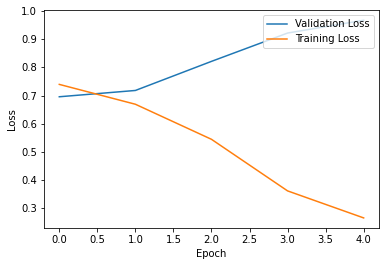

In [ ]:
model = myModel(bert_emb_layer=11,startLayer=1,endLayer=4,bertModel=bertModel)
# criterion1 = nn.CosineEmbeddingLoss(margin = 0.5)
criterion = nn.CrossEntropyLoss()
mytrainStep(model,criterion)

# Classification Task with Siamese BERTs

In [ ]:
class myModel(nn.Module):
  def __init__(self,bert_emb_layer,startLayer,endLayer,bertModel,groupLayersMode = (True,True)):#(True,True)-> Grouping and Summing | #(True,False)-> Grouping and Concat
      super(myModel, self).__init__()
      self.bert_emb_layer = bert_emb_layer
      self.startLayer = startLayer
      self.endLayer = endLayer
      # self.num_unitsFC = num_unitsFC
      self.groupLayersMode = groupLayersMode
      self.bertModel = bertModel
      # self.bertModel.train()  
      # for p in self.bertModel.parameters():
      #     p.requires_grad = False
      inputFeatures = 0
      if self.groupLayersMode == (True,False):
        inputFeatures = (endLayer - startLayer)*768 
      elif self.groupLayersMode == (True,True):
        inputFeatures = 768
      else:
        inputFeatures = 768
      # self.dropout1 = nn.Dropout(0.1)
      self.bilstm = nn.LSTM(input_size=768, hidden_size=768,batch_first=True,bidirectional=True)
      self.FC1 = nn.Linear(in_features = 768*4,out_features = 256)
      
      self.FC2 = nn.Linear(in_features = 256,out_features = 64)
      self.FC3 = nn.Linear(in_features = 64,out_features = 2)
      self.relu = nn.ReLU()
      self.tanh = nn.Tanh()
      self.dropout = nn.Dropout(0.2)
      # self.FC = nn.Sequential(
      #   nn.Linear(in_features = inputFeatures*2,out_features = 256),
      #   nn.ReLU(),
      #   nn.Dropout(0.1),
      #   nn.Linear(in_features = 256,out_features = 2),
      #   # nn.ReLU(),
      #   # nn.Dropout(0.1),
      #   # nn.Linear(in_features = 64,out_features = 16),
      #   # nn.ReLU(),
      #   # nn.Dropout(0.1),
      #   # nn.Linear(in_features = 16,out_features = 2),
      #   # nn.Linear(in_features = 16,out_features = 2)
      #   nn.LogSoftmax()
      # )

  def getSpecificLayerOfBERT(self,bertOutputs):
      hidden_states = bertOutputs[2][1:]#bertOutputs[1][1:] 
      layerOutput = hidden_states[self.bert_emb_layer] # get specific Layer (from 0 to 11) for all tuples (batch_size, sequence_length, hidden_size)
      del hidden_states
      return  layerOutput
  
  def concatSpecificLayersOfBERT(self,bertOutputs):
      hidden_states = bertOutputs[2][1:] #bertOutputs[1][1:] 
      concatEmbeddingLayers = torch.cat([hidden_states[i] for i in range(self.startLayer,self.endLayer)], dim=-1)
      del hidden_states
      return concatEmbeddingLayers
  def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((2*1, batch_size, 768)).detach().to(device)
        c0 = torch.zeros((2*1, batch_size, 768)).detach().to(device)
        hidden = (h0, c0)
        return hidden
  def sumSpecificLayersOfBERT(self,bertOutputs):
      #Number of layers: 13   (initial embeddings + 12 BERT layers) - So we need [2][1:] 1 and onwards
      hidden_states = bertOutputs[2][1:]
      # `hidden_states` is a Python list.

      # sumEmbeddingLayers = torch.stack(hidden_states[self.startLayer:self.endLayer]).sum(0)
      sumEmbeddingLayers = torch.stack(hidden_states[-4:]).sum(0)
      del hidden_states
      # sumEmbeddingLayers = torch.stack( [hidden_states[i] for i in range(self.startLayer,self.endLayer)]).sum(0)
      # sumEmbeddingLayers = torch.sum(hidden_states[0][self.startLayer:self.endLayer], dim=0)
      return sumEmbeddingLayers
  def pooling(self,token_embeddings, mask ,strategy='avg'):
      if strategy == 'avg':
         in_mask = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
         # perform mean-pooling but exclude padding tokens (specified by in_mask)
         avg_setence_embeddings = torch.sum(token_embeddings * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
         return avg_setence_embeddings
      elif strategy == 'max':
         max_setence_embeddings = torch.max(token_embeddings,dim=1)
         return max_setence_embeddings
  def getCLSEmbeddings(self,bertOutputs ):
     
      embeddings = bertOutputs[1]
      return embeddings
  def forwardOnce(self, sent_id, mask):
      outputs =  self.bertModel(sent_id, attention_mask=mask)
     
      if self.groupLayersMode == (True,False):
        embeddings = self.concatSpecificLayersOfBERT(outputs)
        return  embeddings #, self.FC(embeddings)
      elif self.groupLayersMode == (True,True):
        embeddings = self.sumSpecificLayersOfBERT(outputs)
        return embeddings #, self.FC(embeddings)
      else:
        # embeddings = self.getSpecificLayerOfBERT(outputs)
        embeddings = self.getCLSEmbeddings(outputs )
        return embeddings #, self.FC(embeddings)

  def forward(self, sent_id1, mask1,sent_id2, mask2,hidden):

      # forward pass of input 1
      output1 = self.forwardOnce(sent_id1, mask1)
      output2  = self.forwardOnce(sent_id2, mask2)
    
  
     
   
      # output1 = output1[:, 0, :]
      # output2 = output2[:, 0, :]
      # output1 = self.tanh(output1)
      # output1 = self.dropout(output1)
      out1, (hidden1,cell1) = self.bilstm(output1,hidden)
      out2, (hidden2,cell2) = self.bilstm(output2,hidden)
      # out1,hidden11 = self.bilstm(output1,hidden)
      #Extract only the hidden state from the last LSTM cell
      # out11 = out1[:,-1,:]
      # print(hidden11)
      # h1 = hidden1
      # final_repr = torch.cat([h_n[-2, :, :], h_n[-1, :, :]], dim=1)

      out_split1 = out1.view(sent_id1.shape[0], 512, 2, 768)
      out_split2 = out2.view(sent_id2.shape[0], 512, 2, 768)
      # out_split1 = out1.view(sent_id1.shape[0], 128, 2, 768)
      out_forward1 = out_split1[:, :, 0, :]
      out_backward1 = out_split1[:, :, 1, :]
      out_forward2 = out_split2[:, :, 0, :]
      out_backward2 = out_split2[:, :, 1, :]
      batch_indices = torch.arange(0, sent_id1.shape[0], device=device)
      seq_indices = 512 - 1
      direction_full1 = torch.cat([out_split1[batch_indices, seq_indices, 0], out_split1[batch_indices, 0, 1]], dim=-1)
      direction_full2 = torch.cat([out_split2[batch_indices, seq_indices, 0], out_split2[batch_indices, 0, 1]], dim=-1)
      out = torch.cat((direction_full1, direction_full2), 1)
      out = self.dropout(out)
      out = self.FC1(out)
      out = self.relu(out)
      out = self.FC2(out)
      out = self.FC3(out)
      # return F.normalize(direction_full1), F.normalize(direction_full2),output2
      return out

In [ ]:
def validation(model,epoch,criterion,validation_dataloader):
      # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.bertModel.eval()
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    step = 0
    totalF1 = 0
    # for (input1,mask1, target1),(input2,mask2, target2) in validation_dataloader:
    for (input1,mask1,input2,mask2,target1) in validation_dataloader:
        step += 1
       
        b_input_ids1 = input1.to(device)
        b_input_mask1 = mask1.to(device)
        # target1 = target1.type(torch.LongTensor)
        b_labels = target1.to(device)
        # b_labels = torch.unsqueeze(b_labels,1)
        b_input_ids2 = input2.to(device)
        b_input_mask2 = mask2.to(device)
        f1=0
        h = model.init_hidden(b_input_ids1.shape[0])
        with torch.no_grad():        
          out = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2,h) #,b_input_ids2, b_input_mask2
          loss = criterion(out,b_labels)
          total_eval_loss += loss.item()
          f1 = calcF1score(out,b_labels)
          totalF1+=f1
          # probs = F.softmax(out, dim=1).cpu().numpy()
         
          print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 1 Val. Loss "+str(loss.item()), " ==== ",str(f1))
    avg_val_loss = total_eval_loss/len(validation_dataloader)
    model.bertModel.train()
    model.train()
    avg_val_f1 = totalF1/len(validation_dataloader)
    return  avg_val_loss,avg_val_f1 #avg_val_accuracy, avg_val_f1,

In [ ]:
import math
from transformers import AdamW,get_linear_schedule_with_warmup
early_stopping1 = EarlyStopping(patience=2, verbose=True)
def mytrainStep(model,criterion):
      # loss = nn.CosineEmbeddingLoss()
      if torch.cuda.is_available():
         model.to(device)
      warmup_percent = 0.2
      total_steps = math.ceil(3*10*1./1600)
      warmup_steps = 0 #int(total_steps*warmup_percent)
      # embModel.bias.requires_grad = False
      # loss = nn.CrossEntropyLoss()
        # PyTorch scheduler
      modules = [model.bertModel.embeddings, *model.bertModel.encoder.layer[:8]] #Replace 8 by what you want
      for module in modules:
          for param in module.parameters():
              param.requires_grad = False
      optimizer = AdamW(model.parameters(),
                                    lr=2e-5, #5e-5, 3e-5, 2e-5
                                    correct_bias=False) #eps=1e-8,
      # optimizer = torch.optim.Adam(model.parameters() ,lr=0.0001)
      #scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=5*len(train_dataloader))
      # Set the seed value all over the place to make this reproducible.
      seed_val = 42

      random.seed(seed_val)
      np.random.seed(seed_val)
      torch.manual_seed(seed_val)
      torch.cuda.manual_seed_all(seed_val)

      # We'll store a number of quantities such as training and validation loss, 
      # validation accuracy, and timings.
      training_stats = []

      # Measure the total training time for the whole run.
      total_t0 = time.time()

      # For each epoch...
      listOflossesTrain2 = list()
      listOfF1Train = list()
      listOflossesValid2 = list()
      listOfF1Valid = list()
      f1_total = 0
      for epoch_i in range(0, 1):

          print("")
          print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs))
          print('Training...')

          # Measure how long the training epoch takes.
          t0 = time.time()

          # Reset the total loss for this epoch.
          total_train_loss2 = 0

          model.train()
          f1_total = 0
          # For each batch of training data...
          step = 0
          # for (input1,mask1, target1),(input2,mask2, target2) in train_dataloader:
          for (input1,mask1,input2,mask2,target1) in train_dataloader:  
              step +=1
              # if step == 21:
              #     break 
              # # Progress update every 40 batches.
              if step % 100 == 0 and not step == 0:
                  # Calculate elapsed time in minutes.
                  elapsed = format_time(time.time() - t0)
                  # Report progress.
                  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

              if torch.cuda.is_available():
                  b_input_ids1 = input1.to(device)
                  b_input_mask1 = mask1.to(device)
                  # target1 = target1.type(torch.LongTensor)
                  b_labels = target1.to(device)
                  # print(b_labels)
                  # b_labels = torch.unsqueeze(b_labels,1)
                  # print(b_labels)
                  b_input_ids2 = input2.to(device)
                  b_input_mask2 = mask2.to(device)
                  h = model.init_hidden(b_input_ids1.shape[0])
              model.zero_grad()  

              # with embModel.parameters() == False:
                       
              out = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2,h) #b_input_ids2, b_input_mask2 
              
              loss = criterion(out,b_labels)
              f1=0
              total_train_loss2 += loss.item()
              f1 = calcF1score(out,b_labels)
              f1_total+=f1
              print("========== Epoch "+str(epoch_i)+ " Batch "+str(step)+"====  Train Loss "+str(loss.item()), " ==== ",str(f1))#
              
              loss.backward()
              # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
              optimizer.step()
              # scheduler.step()
          avg_train_loss2 = total_train_loss2 / len(train_dataloader)
          print("========== Epoch "+str(epoch_i)+ " ==== AVG. Train Loss "+str(avg_train_loss2),"===== ",str(f1_total/20))            
          listOflossesTrain2.append(avg_train_loss2)
          training_time = format_time(time.time() - t0)

          print("")
          # print("  Average training loss: {0:.2f}".format(avg_train_loss2))
          print("  Training epoch took: {:}".format(training_time))
          
          # print("  Accuracy: {0:.2f}".format(avg_train_accuracy))

          # Calculate the average loss over all of the batches.avg_val_accuracy, avg_val_f1,
          avg_val_loss2,avg_val_f1 = validation(model,epoch_i,criterion,validation_dataloader)
          listOflossesValid2.append(avg_val_loss2)
          # listOfF1Valid.append(avg_val_f1)
          # Measure how long the validation run took.
          validation_time = format_time(time.time() - t0)
        
          print("  Average Validation Loss: {0:.2f}".format(avg_val_loss2))
          print("  Validation avg-F1: {0:.2f}".format(avg_val_f1))
          # print("  Validation avg-Accuracy: {0:.2f}".format(avg_val_accuracy))
          print("  Validation took: {:}".format(validation_time))

          # Record all statistics from this epoch.
          training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss2,
                'Validation Loss': avg_val_loss2,
                # 'Valid. avg F1.': avg_val_f1,
                # 'Valid. avg Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
          )
          # early_stopping1(avg_val_loss2, model)
        
          # if early_stopping1.early_stop:
          #     print("Early stopping")
          #     break  

      print("")
      print("Training complete!")

      print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
      createPlot(listOflossesTrain2,listOflossesValid2,1)

In [ ]:
model = myModel(bert_emb_layer=5,startLayer=3,endLayer=7,bertModel=bertModel)

criterion = nn.CrossEntropyLoss()
# criterion=nn.BCEWithLogitsLoss()
mytrainStep(model,criterion)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 2 ========
Training...
========== Epoch 0 Batch 1====  Train Loss 0.7020729780197144  ====  0.0
========== Epoch 0 Batch 2====  Train Loss 0.6920119524002075  ====  0.45161290322580644
========== Epoch 0 Batch 3====  Train Loss 0.6827157139778137  ====  0.7083333333333333
========== Epoch 0 Batch 4====  Train Loss 0.7090359926223755  ====  0.6086956521739131
========== Epoch 0 Batch 5====  Train Loss 0.7010071873664856  ====  0.5777777777777777
========== Epoch 0 Batch 6====  Train Loss 0.6964473128318787  ====  0.05714285714285715
========== Epoch 0 Batch 7====  Train Loss 0.6894224286079407  ====  0.0
========== Epoch 0 Batch 8====  Train Loss 0.6838886737823486  ====  0.0
========== Epoch 0 Batch 9====  Train Loss 0.6787237524986267  ====  0.0
========== Epoch 0 Batch 10====  Train Loss 0.7680231332778931  ====  0.0
========== Epoch 0 Batch 11====  Train Loss 0.7231895327568054  ====  0.0
========== Epoch 0 Batch 12====  Train Loss 0.6871258020401001  ====  0.0
=

KeyboardInterrupt: ignored

In [ ]:
# torch.save(model.state_dict(),'myModel.pt')
import shutil
shutil.copy("myModel.pt",'/content/drive/My Drive/Thesis/MaskAll/Separated')

'/content/drive/My Drive/Thesis/MaskAll/Separated/myModel.pt'

In [ ]:
from google.colab import runtime
runtime.unassign()

# Contrastive Learning in 2 steps

Step 1: Learning Embeddings with Contrastive loss <br>
Step 2: Freeze NN that learns Embeddings and Start training of NN that is a simple Classifier

In [ ]:
from joblib.logger import print_function
from transformers import AdamW,get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
class myModelEmbeddings(nn.Module):
  def __init__(self,bert_emb_layer,startLayer,endLayer,bertModel,groupLayersMode = (False,False)):#(True,True)-> Grouping and Summing | #(True,False)-> Grouping and Concat
      super(myModelEmbeddings, self).__init__()
      self.bert_emb_layer = bert_emb_layer
      self.startLayer = startLayer
      self.endLayer = endLayer
      # self.num_unitsFC = num_unitsFC
      self.groupLayersMode = groupLayersMode
      self.bertModel = bertModel
      
      # for param in model.bertModel.parameters():
      #     param.requires_grad = False
      # modules = [self.bertModel.embeddings, *self.bertModel.encoder.layer[:8]] #Replace 8 by what you want
      # for module in modules:
      #     for param in module.parameters():
      #         param.requires_grad = False
     
      inputFeatures = 0
      if self.groupLayersMode == (True,False):
        inputFeatures = (endLayer - startLayer)*768 
      elif self.groupLayersMode == (True,True):
        inputFeatures = 768
      else:
        inputFeatures = 768
     
      # self.bilstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True) 
      self.FC = nn.Linear(in_features = 768,out_features = 384)
     
      self.tanh = nn.Tanh()
      self.dropout = nn.Dropout(0.5),
     

  def getSpecificLayerOfBERT(self,bertOutputs):
      hidden_states = bertOutputs[2][1:] 
      layerOutput = hidden_states[self.bert_emb_layer] # get specific Layer (from 0 to 11) for all tuples (batch_size, sequence_length, hidden_size)
      
      return  layerOutput
  def getAttentionHead(self,bertOutputs):
      hidden_states = bertOutputs[3][0:] 
      layerOutput = hidden_states[self.bert_emb_layer]
      return  layerOutput
  def concatSpecificLayersOfBERT(self,bertOutputs):
      hidden_states = bertOutputs[2][0:] 
      concatEmbeddingLayers = torch.cat([hidden_states[i] for i in range(self.startLayer,self.endLayer)], dim=-1)
      
      return concatEmbeddingLayers
  def getCLSEmbeddings(self,bertOutputs ):
      embeddings = bertOutputs[1]
      return embeddings
  def sumSpecificLayersOfBERT(self,bertOutputs):
      #Number of layers: 13   (initial embeddings + 12 BERT layers) - So we need [2][1:] 1 and onwards
      hidden_states = bertOutputs[2][0:]
      # `hidden_states` is a Python list.
      
      sumEmbeddingLayers = torch.stack(hidden_states[self.startLayer:self.endLayer]).sum(0)
      del hidden_states

      return sumEmbeddingLayers
  def pooling(self,token_embeddings, mask, strategy='avg'):
      if strategy == 'max':
        #  avg_setence_embeddings = torch.mean(token_embeddings,dim=1)
        #  print(avg_setence_embeddings.shape)
         input_mask_expanded = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
         token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
         max_setence_embeddings = torch.max(token_embeddings, 1)[0]
         return max_setence_embeddings
      elif strategy == 'avg':
         in_mask = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
         # perform mean-pooling but exclude padding tokens (specified by in_mask)
         avg_setence_embeddings = torch.sum(token_embeddings * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
         return avg_setence_embeddings
      elif strategy == 'sum':
        sum_setence_embeddings = torch.sum(token_embeddings[0:len(token_embeddings)],1)
        return sum_setence_embeddings

  def forwardOnce(self, sent_id, mask):
      outputs =  self.bertModel(sent_id, attention_mask=mask)
     
      if self.groupLayersMode == (True,False):
        embeddings = self.concatSpecificLayersOfBERT(outputs)
        return  embeddings 
      elif self.groupLayersMode == (True,True):
        embeddings = self.sumSpecificLayersOfBERT(outputs)
        return embeddings 
      else:
        # embeddings = self.getAttentionHead(outputs)
        # embeddings = self.getSpecificLayerOfBERT(outputs)
        embeddings = self.getCLSEmbeddings(outputs )
        return embeddings 
      
 
  def forward(self, sent_id1, mask1,sent_id2, mask2,b_labels):

      # forward pass of input 1
      output1 = self.forwardOnce(sent_id1, mask1)
      # forward pass of input 2
      output2  = self.forwardOnce(sent_id2, mask2)
     
      # print(output1.shape)
      # print(output1[:,11,:,:])
      # print(output1[:,11,:,:].shape)
      # avgoutput1 = self.pooling(output1,mask1,'avg')
      # avgoutput2 = self.pooling(output2,mask2,'avg')
      # avgoutput1 = output1.mean(1)
      # avgoutput2 = output2.mean(1)
      # concatenated = torch.cat((avgoutput1,avgoutput1),dim=0)
      
  
      cos = nn.CosineSimilarity(dim=1)
      # output11 = output1[:, 0, :]
      # output22 = output2[:, 0, :]
      # print(output11)
      # output11 = F.normalize(output11, p=2, dim=1)
      # output22 = F.normalize(output22, p=2, dim=1)
      # print(output11)
      # lstm1 = self.bilstm(output1)
      # lstm2 = self.bilstm(output2)
      # output1 = self.dropout(avgoutput1)
      FC11 = self.FC(output1)
      # FC11 = self.tanh(FC11)
      # output2 = self.dropout(avgoutput1)
      FC22 = self.FC(output1)
      # FC22 = self.tanh(FC22)
      output = cos(FC11, FC22)
      
      print(output)
     
      print(b_labels)

      

      plt.hist(output.cpu().data.numpy(), bins=6)
      plt.show()
      return FC11, FC22,output

class myModelFC(nn.Module):
  def __init__(self):
      super(myModelFC, self).__init__()
      inputFeatures = 256 #32
      self.FC = nn.Sequential(
        # nn.ReLU(),
        nn.Tanh(),
        nn.Dropout(0.1),  
        nn.Linear(in_features = inputFeatures*2,out_features = 2),
        # nn.Tanh(),
        # nn.ReLU(),
        # nn.Dropout(0.1), #0.5
        # nn.Linear(in_features = 256,out_features = 32),
        # nn.Linear(in_features = 32,out_features = 2),
      
      )


  def forward(self, input1, input2):
      concatenated = torch.cat((input1,input1),dim=1)
      
      out = self.FC(concatenated)
      # print(out)
      return out

In [ ]:
from pytorch_metric_learning.reducers import MeanReducer
modelEmb = myModelEmbeddings(bert_emb_layer=5,startLayer=4,endLayer=12,bertModel=bertModel)
modelCLS = myModelFC()
# criterion1 = nn.CosineEmbeddingLoss(margin = 0.4)#margin = 0.5
# func = distances.LpDistance
# criterion1 = ContrastiveLossSiamese(margin1 = 0.9)
# criterion1 = getLossFunction(device)
# criterion1 =nn.BCELoss()
#reducer=MeanReducer()
criterion1 = losses.ContrastiveLoss(distance = distances.CosineSimilarity(),reducer=MeanReducer(),pos_margin=1, neg_margin=-0.1) #distance = distances.CosineSimilarity()
criterion2 = nn.CrossEntropyLoss()
early_stopping1 = EarlyStopping(patience=2, path='checkpointEmb.pt',verbose=True)
early_stopping2 = EarlyStopping(patience=3, verbose=True)

In [ ]:
def validation(model,epoch,criterion1,validation_dataloader,modelFC=None,criterion2 = None):
    
      # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.bertModel.eval()
 
    model.eval()
    if modelFC is not None:
        modelFC.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # tsne = TSNE()
    step = 0
    concatAll = []
    totalF1 = 0
    # for (input1,mask1, target1),(input2,mask2, target2) in validation_dataloader:
    for input1, mask1, input2, mask2,target1 in validation_dataloader:
    # for batch in test_dataloader:
        step += 1 
        # if step == 71:
        #   break

        # b_input_ids1 = batch[0].permute(0,2,1).squeeze(2).to(device)
        # b_input_mask1 = batch[1].permute(0,2,1).squeeze(2).to(device)
        # label = batch[4].type(torch.LongTensor)
        # b_input_ids2 = batch[2].permute(0,2,1).squeeze(2).to(device)
        # b_input_mask2 = batch[3].permute(0,2,1).squeeze(2).to(device)
        # label = label.type(torch.LongTensor)
        # b_labels = label.to(device)
        b_input_ids1 = input1.to(device)
        b_input_mask1 = mask1.to(device)
        target1 = target1.type(torch.LongTensor)
        # if modelFC==None:
        #   target1 = target1.type(torch.LongTensor)
        #   target1 = torch.where(target1==0,torch.tensor(-1),target1)
        #   # target1 = torch.where(target1==1,torch.tensor(2),target1)
        #   # target1 = torch.where(target1==-1,torch.tensor(1),target1)
        #   # target1 = torch.where(target1==2,torch.tensor(0),target1)
        # else:
        #   target1 = target1.type(torch.LongTensor)
        b_labels = target1.to(device)
        # b_labels = b_labels.unsqueeze(1)
        # b_labels = torch.squeeze(b_labels,1)
        b_input_ids2 = input2.to(device)
        b_input_mask2 = mask2.to(device)

        with torch.no_grad():        
            if modelFC==None:

              FC11,FC22,cos = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2,b_labels)             
              
              pos_indices = torch.where(b_labels==1)[0]
              neg_indices = torch.where(b_labels==0)[0]
              # print(pos_indices)
              # print(neg_indices)
              indices_tuple = (pos_indices,pos_indices,neg_indices,neg_indices)
              loss1 = criterion1(FC11,b_labels,indices_tuple,ref_emb=FC22, ref_labels=b_labels)
              # loss1 = criterion1(FC11,FC22,b_labels)
            elif modelFC is not None and criterion2 is not None:
              
              #output11, output22,FC11,FC22,avg1,avg2,concatenated,concatenatedfc,_ = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2)
              FC11,FC22,_ = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2,b_labels)
              out = modelFC(FC11,FC22)
              loss2 = criterion2(out,b_labels)
            if modelFC == None:
                total_eval_loss += loss1.item()
                print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 1 AVG. val Loss "+str(loss1.item()))
                # label_ids = b_labels.to('cpu').numpy()
                
            elif modelFC is not None and criterion2 is not None:
            
                total_eval_loss += loss2.item()
                f1 = calcF1score(out,b_labels)
                totalF1 += f1
                probs = F.softmax(out, dim=1).cpu().numpy()
                print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 2 Probs")
                print(probs) 
                print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 2 AVG. val Loss "+str(loss2.item()), "==== ",str(f1))
                modelFC.train()
    
    avg_val_loss = total_eval_loss/len(validation_dataloader)
    avg_f1_val = totalF1/len(validation_dataloader)
    
    if modelFC==None:
       model.bertModel.train()
       model.train()
    else:
       model.bertModel.eval()
       model.eval()
       modelFC.train()  
    return  avg_val_loss,avg_f1_val #avg_val_accuracy, avg_val_f1,

In [ ]:
def mytrainStep2(model,criterion1,criterion2,embModel):
      # loss = nn.CosineEmbeddingLoss()
      embModel.bertModel.eval()
      embModel.eval()
      for param in embModel.bertModel.parameters():
          param.requires_grad = False
      for param2 in embModel.parameters():
          param2.requires_grad = False    

      if torch.cuda.is_available():
         model.to(device)
      
      
      # embModel.bias.requires_grad = False
      # loss = nn.CrossEntropyLoss()
        # PyTorch scheduler
      optimizer2 = torch.optim.Adam(model.parameters(),
                                    lr=0.0002
                                    )
      # scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=3*len(train_dataloader))
      # Set the seed value all over the place to make this reproducible.
      seed_val = 42

      random.seed(seed_val)
      np.random.seed(seed_val)
      torch.manual_seed(seed_val)
      torch.cuda.manual_seed_all(seed_val)

      # We'll store a number of quantities such as training and validation loss, 
      # validation accuracy, and timings.
      training_stats = []

      # Measure the total training time for the whole run.
      total_t0 = time.time()

      # For each epoch...
      listOflossesTrain2 = list()
      listOfF1Train = list()
      listOflossesValid2 = list()
      listOfF1Valid = list()
      totalf1 = 0
      epoch_stop = 0
      for epoch_i in range(0, 8):

          print("")
          print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs))
          print('Training...')

          # Measure how long the training epoch takes.
          t0 = time.time()

          # Reset the total loss for this epoch.
          total_train_loss2 = 0

          model.train()

          # For each batch of training data...
          step = 0
          totalf1 = 0
          for (input1,mask1,input2,mask2,target1) in train_dataloader:
              step +=1
              # if step ==201 :
              #   break
              # # Progress update every 40 batches.
              if step % 100 == 0 and not step == 0:
                  # Calculate elapsed time in minutes.
                  elapsed = format_time(time.time() - t0)
                  # Report progress.
                  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

              if torch.cuda.is_available():
                  b_input_ids1 = input1.to(device)
                  b_input_mask1 = mask1.to(device)
                  target1 = target1.type(torch.LongTensor)
                  b_labels = target1.to(device)
                  
                  # b_labels = torch.squeeze(b_labels,1)
                  b_input_ids2 = input2.to(device)
                  b_input_mask2 = mask2.to(device)
              
              model.zero_grad()  

              # with embModel.parameters() == False:
              # for p in embModel.parameters():
              #     p.requires_grad = False            
              #output11, output22,FC11,FC22,avg1,avg2,concatenated,concatenatedfc,_ = embModel(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2) 
              FC11,FC22,_ = embModel(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2,b_labels)
              out = model(FC11,FC22)
             
              loss = criterion2(out,b_labels)

              total_train_loss2 += loss.item()
              f1 = calcF1score(out,b_labels)
              totalf1+=f1
              print("========== Epoch "+str(epoch_i)+ " Batch "+str(step)+"==== Step 2 Train Loss "+str(loss.item()),"====== ",str(f1))

              loss.backward()

              optimizer2.step()
              # scheduler.step()
              
          avg_train_loss2 = total_train_loss2 /len(train_dataloader)
          avg_f1_train = totalf1/len(train_dataloader)
          print("========== Epoch "+str(epoch_i)+ " ==== Step 2 Train Loss "+str(avg_train_loss2),"====== ",str(avg_f1_train))            
          listOflossesTrain2.append(avg_train_loss2)
          training_time = format_time(time.time() - t0)

          print("")
          # print("  Average training loss: {0:.2f}".format(avg_train_loss2))
          print("  Training epoch took: {:}".format(training_time))
          
          # print("  Accuracy: {0:.2f}".format(avg_train_accuracy))

          # Calculate the average loss over all of the batches.avg_val_accuracy, avg_val_f1,
          avg_val_loss2,avg_f1_val = validation(embModel,epoch_i,criterion1,validation_dataloader,model,criterion2)
          listOflossesValid2.append(avg_val_loss2)
          # listOfF1Valid.append(avg_val_f1)
          # Measure how long the validation run took.
          validation_time = format_time(time.time() - t0)
        
          print("  Average Validation Loss: {0:.2f}".format(avg_val_loss2))
          print("  Validation avg-F1: {0:.2f}".format(avg_f1_val))
          # print("  Validation avg-Accuracy: {0:.2f}".format(avg_val_accuracy))
          print("  Validation took: {:}".format(validation_time))

          # Record all statistics from this epoch.
          training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss2,
                'Validation Loss': avg_val_loss2,
                # 'Valid. avg F1.': avg_val_f1,
                # 'Valid. avg Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
          )
          early_stopping2(avg_val_loss2, model)
          epoch_stop = epoch_i+1
          if early_stopping2.early_stop:
              print("Early stopping")
              
              break  

      print("")
      print("Training complete!")

      print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
      createPlot(listOflossesTrain2,listOflossesValid2,epoch_stop)
      

In [ ]:
num_training_steps = 176 #len(train_dataloader)
from pytorch_metric_learning.utils import common_functions
common_functions.COLLECT_STATS = True


# loss = loss_fn(emb, labels)

def mytrainStep1(model,criterion1,criterion2):
      # loss = nn.CosineEmbeddingLoss()
      # reducers = criterion1.reducer.reducers
    
      if torch.cuda.is_available():
          model.to(device)
      # loss = nn.CrossEntropyLoss()
        # PyTorch scheduler
      # optimizer = torch.optim.Adam(model.parameters(),
      #                               lr=0.0001)
      modules = [model.bertModel.embeddings, *model.bertModel.encoder.layer[:7]] #Replace 8 by what you want
      for module in modules:
          for param in module.parameters():
              param.requires_grad = False
      # modules2 = [model.bertModel.embeddings, *model.bertModel.encoder.layer[8:]] #Replace 8 by what you want
      # for module in modules2:
      #     for param in module.parameters():
      #         param.requires_grad = False
      optimizer = AdamW(model.parameters(),
                                    lr=1e-5, #5e-5, 3e-5, 2e-5
                                    correct_bias=False) #eps=1e-8,
      # scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=4*500)
      # Set the seed value all over the place to make this reproducible.
      seed_val = 42

      random.seed(seed_val)
      np.random.seed(seed_val)
      torch.manual_seed(seed_val)
      torch.cuda.manual_seed_all(seed_val)

      # We'll store a number of quantities such as training and validation loss, 
      # validation accuracy, and timings.
      training_stats = []

      # Measure the total training time for the whole run.
      total_t0 = time.time()

      # For each epoch...
      listOflossesTrain = list()
      listOfF1Train = list()
      listOflossesValid = list()
      listOfF1Valid = list()
      epoch_stop = 0
      for epoch_i in range(0, 3):

          print("")
          print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs))
          print('Training...')

          # Measure how long the training epoch takes.
          t0 = time.time()

          # Reset the total loss for this epoch.
          total_train_loss = 0
          model.bertModel.train()
          model.train()

          # For each batch of training data...
          step = 0
          # for (input1,mask1, target1),(input2,mask2, target2) in train_dataloader:
          accum_iter = 4
          for batch_idx,(input1, mask1, input2, mask2,target1) in  enumerate(train_dataloader):
              step +=1
              # if step ==201 :
              #   break
              # # Progress update every 40 batches.
              if step % 100 == 0 and not step == 0:
                  # Calculate elapsed time in minutes.
                  elapsed = format_time(time.time() - t0)
                  # Report progress.
                  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

              # if torch.cuda.is_available():
              b_input_ids1 = input1.to(device)
              b_input_mask1 = mask1.to(device)
              target1 = target1.type(torch.LongTensor)
              # target1 = torch.where(target1==0,torch.tensor(-1),target1)
            
              b_labels = target1.to(device)
              # b_labels = b_labels.unsqueeze(1)
              b_input_ids2 = input2.to(device)
              b_input_mask2 = mask2.to(device)
              # b_labels=b_labels.reshape(-1,1)
              # b_labels = torch.squeeze(b_labels,1)
              model.zero_grad()
              # with torch.set_grad_enabled(True):
                  #output11, output22,FC11,FC22,avg1,avg2,concatenated,concatenatedfc,_ = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2) 
              # print(a1)
              # print(a2)
              FC11,FC22,cos = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2,b_labels)
                  # loss = criterion1(out1,out2,b_labels)
              pos_indices = torch.where(b_labels==1)[0]
              neg_indices = torch.where(b_labels==0)[0]
                  # print(pos_indices)
                  # print(neg_indices)
              indices_tuple = (pos_indices,pos_indices,neg_indices,neg_indices)
                  
                 
              # loss1 = criterion1(FC11,FC22,b_labels)
              
              loss1 = criterion1(FC11,b_labels,indices_tuple,ref_emb=FC22, ref_labels=b_labels)
              # loss1 = loss1 / accum_iter
     
          
              total_train_loss += loss1.item()
                  # print(loss.data[0])
              print("========== Epoch "+str(epoch_i)+ " Batch "+str(step)+"==== Step 1  Train Loss "+str(loss1.item()))

              loss1.backward()
              # if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_dataloader)):
                      # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
              optimizer.step()
                  # optimizer.zero_grad()
              # scheduler.step()
                      
          avg_train_loss = total_train_loss /len(train_dataloader)
          print("========== Epoch "+str(epoch_i)+ " ==== Step 1 AVG. Train Loss "+str(avg_train_loss))            
          listOflossesTrain.append(avg_train_loss)
          training_time = format_time(time.time() - t0)

          print("")
          # print("  Average training loss: {0:.2f}".format(avg_train_loss))
          print("  Training epoch took: {:}".format(training_time))
          
          # print("  Accuracy: {0:.2f}".format(avg_train_accuracy))

          # Calculate the average loss over all of the batches.avg_val_accuracy, avg_val_f1,
          avg_val_loss,avgf1 = validation(model,epoch_i,criterion1,validation_dataloader)
          listOflossesValid.append(avg_val_loss)
          # listOfF1Valid.append(avg_val_f1)
          # Measure how long the validation run took.
          validation_time = format_time(time.time() - t0)
        
          print("  Average Validation Loss: {0:.2f}".format(avg_val_loss))
       
          print("  Validation took: {:}".format(validation_time))

       
          early_stopping1(avg_val_loss, model)
          epoch_stop = epoch_i+1
          if early_stopping1.early_stop:
              print("Early stopping")
              # break  

      print("")
      print("Training complete!")

      print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
      createPlot(listOflossesTrain,listOflossesValid,3)

      # mytrainStep2(modelCLS,criterion1,criterion2,model)
      # torch.save(model.state_dict(), 'checkPointEmb.pt')

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 2 ========
Training...
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')


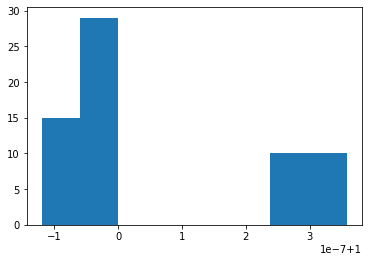

========== Epoch 0 Batch 1==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')


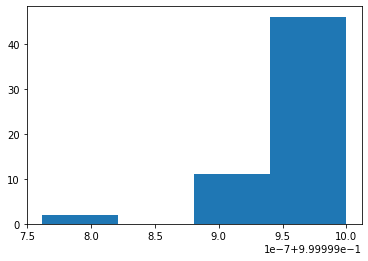

========== Epoch 0 Batch 2==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')


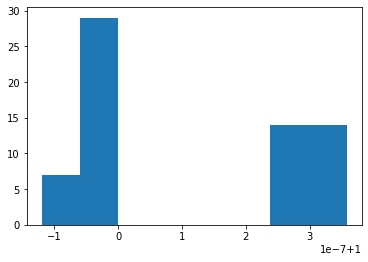

========== Epoch 0 Batch 3==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')


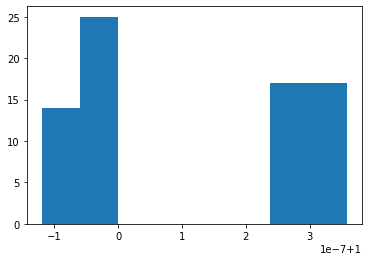

========== Epoch 0 Batch 4==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')


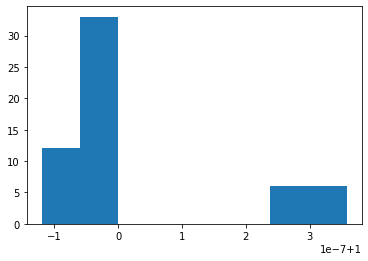

========== Epoch 0 Batch 5==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')


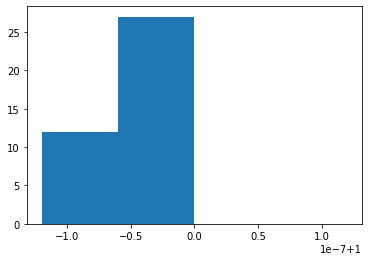

========== Epoch 0 Batch 6==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')


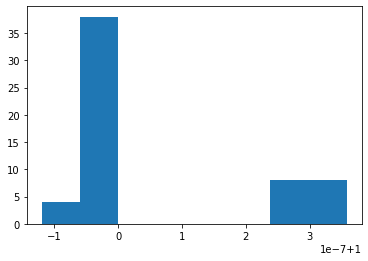

========== Epoch 0 Batch 7==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')


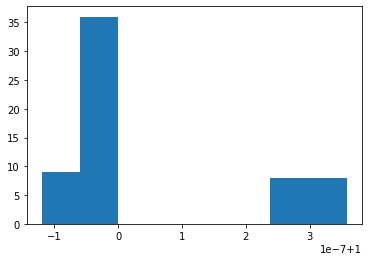

========== Epoch 0 Batch 8==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')


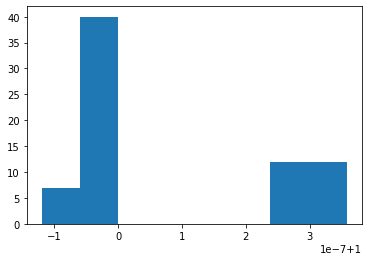

========== Epoch 0 Batch 9==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')


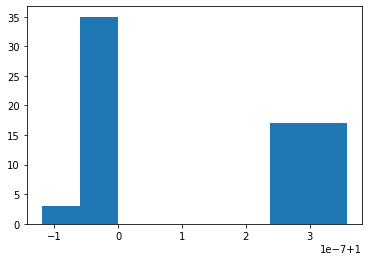

========== Epoch 0 Batch 10==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')


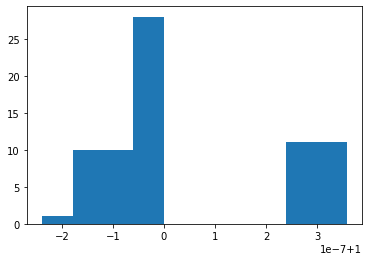

========== Epoch 0 Batch 11==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')


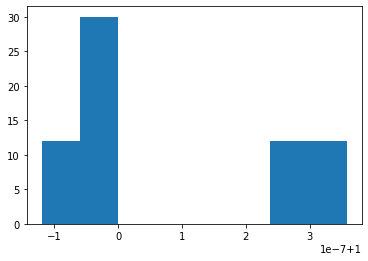

========== Epoch 0 Batch 12==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')


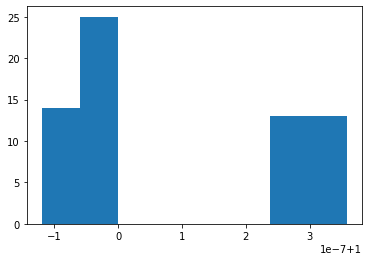

========== Epoch 0 Batch 13==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')


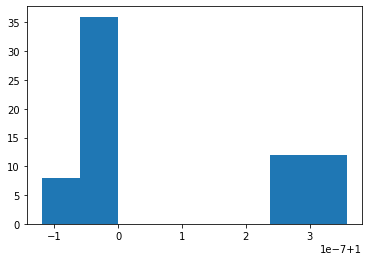

========== Epoch 0 Batch 14==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')


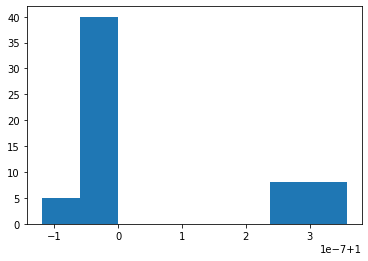

========== Epoch 0 Batch 15==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')


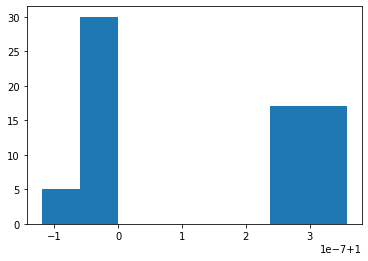

========== Epoch 0 Batch 16==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')


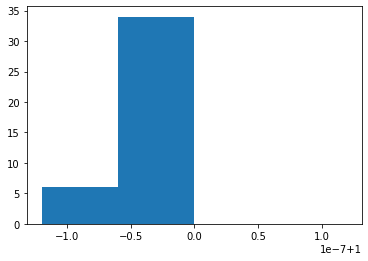

========== Epoch 0 Batch 17==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')


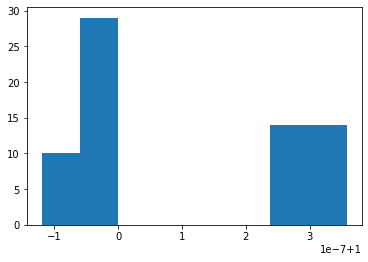

========== Epoch 0 Batch 18==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')


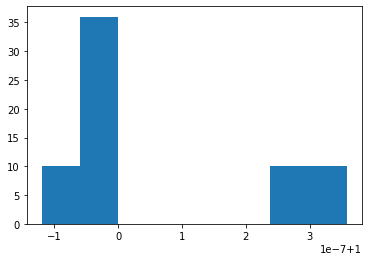

========== Epoch 0 Batch 19==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')


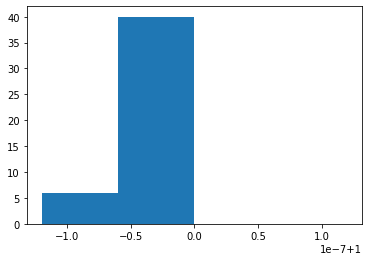

========== Epoch 0 Batch 20==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')


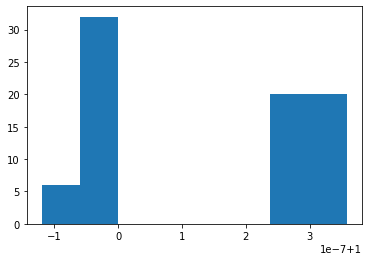

========== Epoch 0 Batch 21==== Step 1  Train Loss 1.1000001430511475
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')


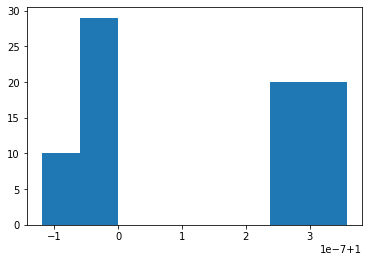

========== Epoch 0 Batch 22==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')


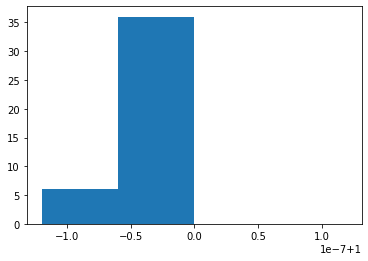

========== Epoch 0 Batch 23==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')


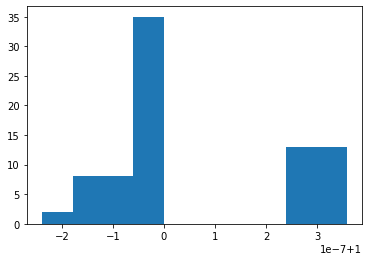

========== Epoch 0 Batch 24==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')


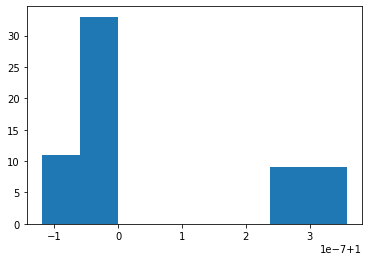

========== Epoch 0 Batch 25==== Step 1  Train Loss 1.1000001430511475
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')


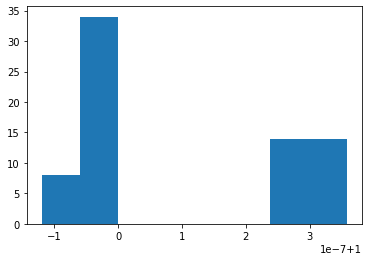

========== Epoch 0 Batch 26==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')


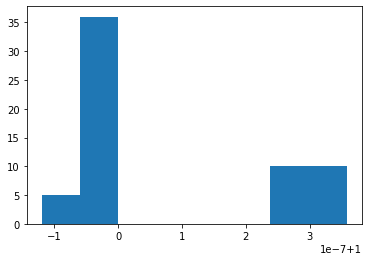

========== Epoch 0 Batch 27==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')


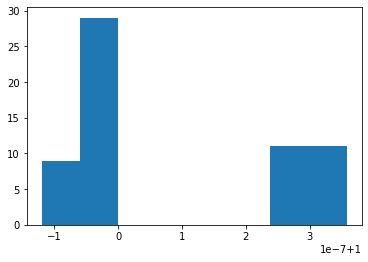

========== Epoch 0 Batch 28==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')


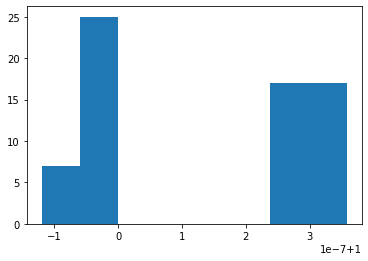

========== Epoch 0 Batch 29==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')


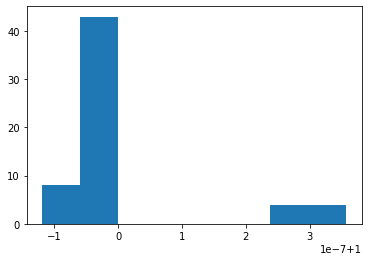

========== Epoch 0 Batch 30==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')


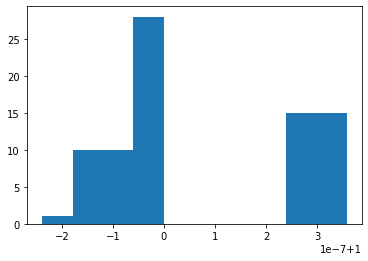

========== Epoch 0 Batch 31==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')


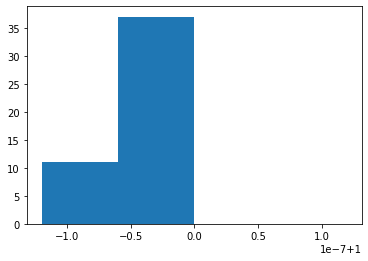

========== Epoch 0 Batch 32==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')


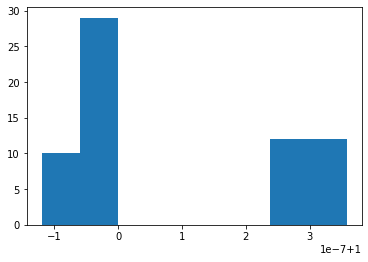

========== Epoch 0 Batch 33==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')


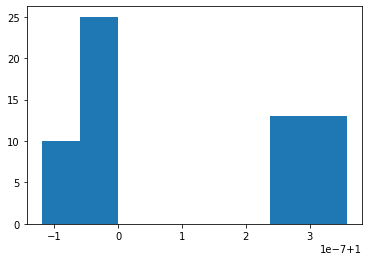

========== Epoch 0 Batch 34==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')


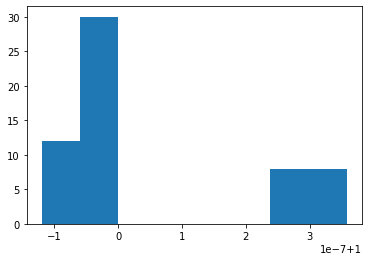

========== Epoch 0 Batch 35==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')


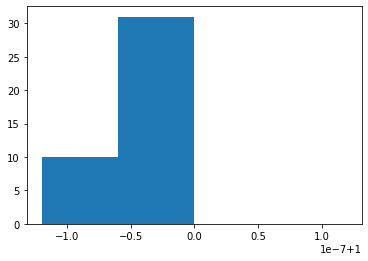

========== Epoch 0 Batch 36==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')


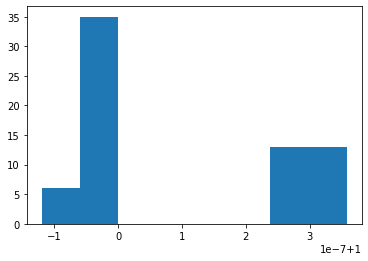

========== Epoch 0 Batch 37==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')


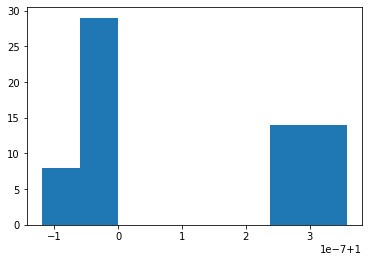

========== Epoch 0 Batch 38==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')


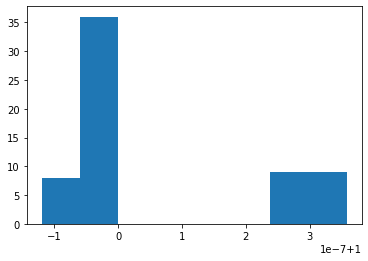

========== Epoch 0 Batch 39==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')


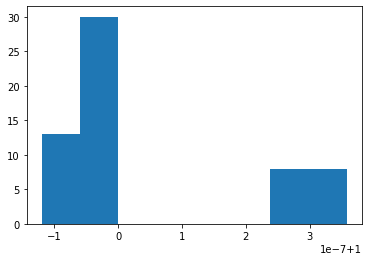

========== Epoch 0 Batch 40==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')


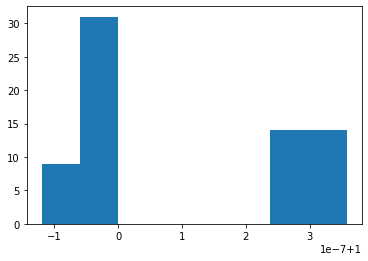

========== Epoch 0 Batch 41==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')


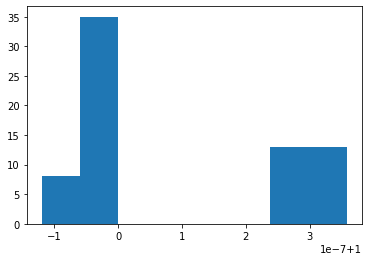

========== Epoch 0 Batch 42==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')


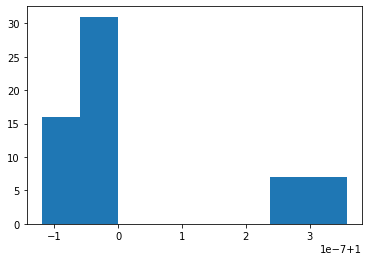

========== Epoch 0 Batch 43==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')


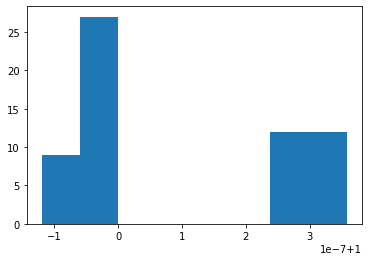

========== Epoch 0 Batch 44==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')


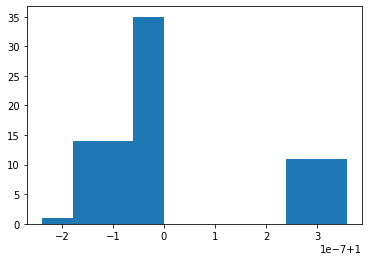

========== Epoch 0 Batch 45==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')


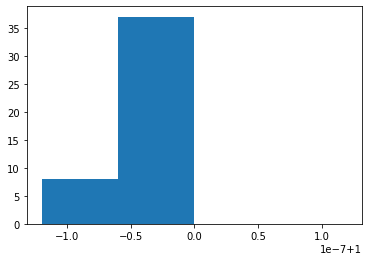

========== Epoch 0 Batch 46==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')


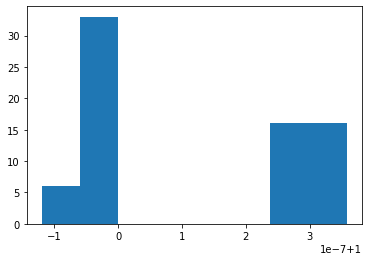

========== Epoch 0 Batch 47==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')


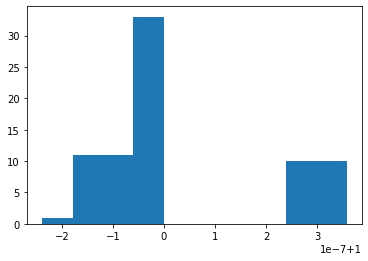

========== Epoch 0 Batch 48==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')


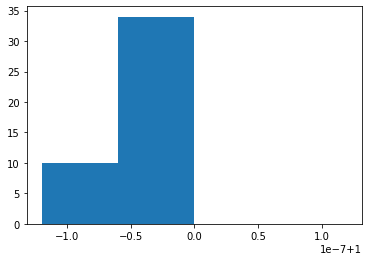

========== Epoch 0 Batch 49==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')


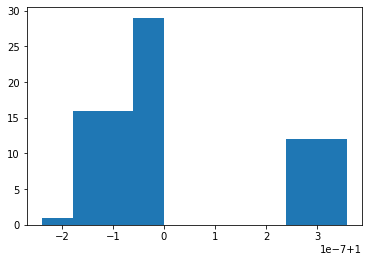

========== Epoch 0 Batch 50==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')


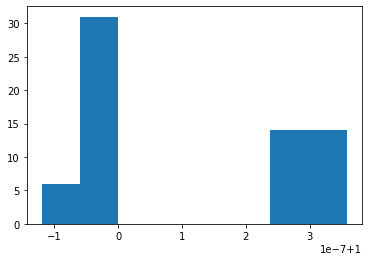

========== Epoch 0 Batch 51==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')


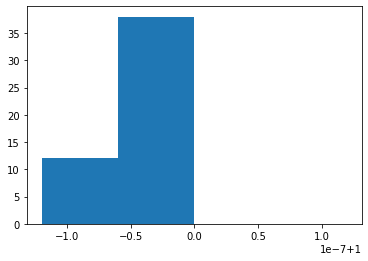

========== Epoch 0 Batch 52==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')


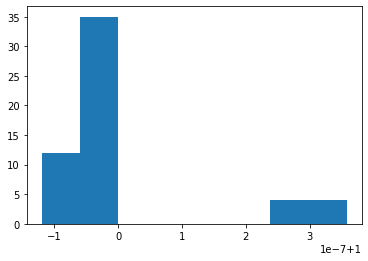

========== Epoch 0 Batch 53==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')


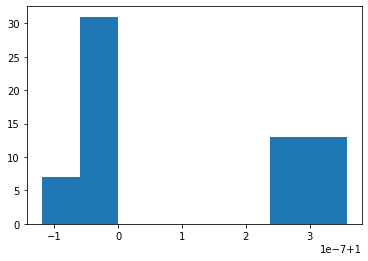

========== Epoch 0 Batch 54==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')


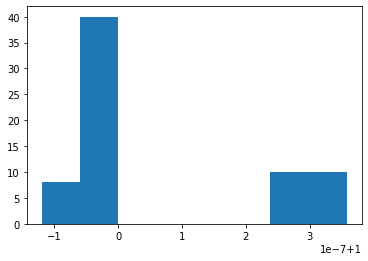

========== Epoch 0 Batch 55==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')


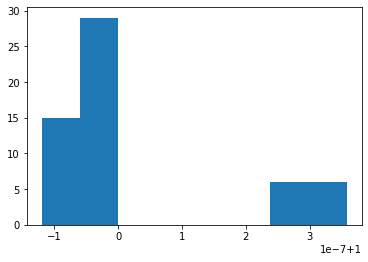

========== Epoch 0 Batch 56==== Step 1  Train Loss 1.1000001430511475
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')


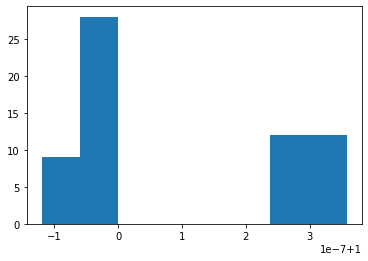

========== Epoch 0 Batch 57==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')


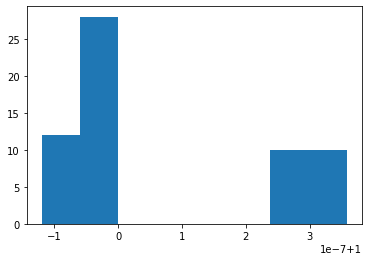

========== Epoch 0 Batch 58==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')


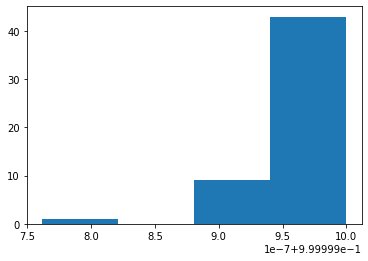

========== Epoch 0 Batch 59==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')


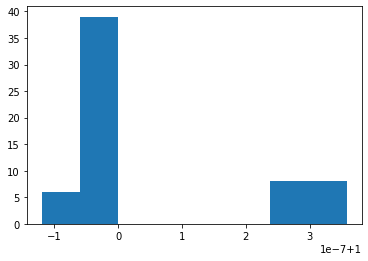

========== Epoch 0 Batch 60==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')


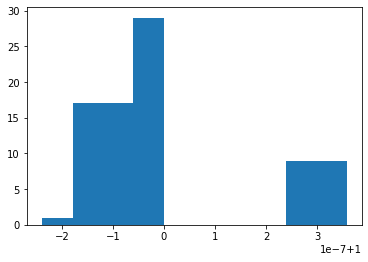

========== Epoch 0 Batch 61==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')


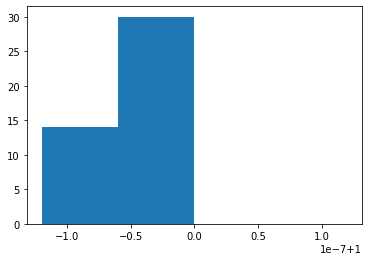

========== Epoch 0 Batch 62==== Step 1  Train Loss 1.1000001430511475
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')


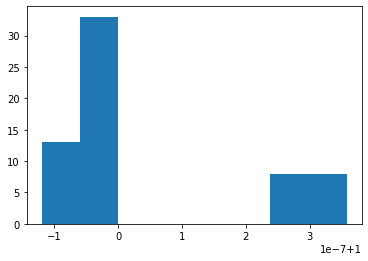

========== Epoch 0 Batch 63==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')


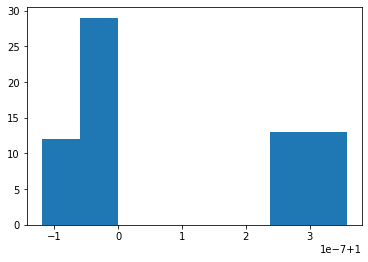

========== Epoch 0 Batch 64==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')


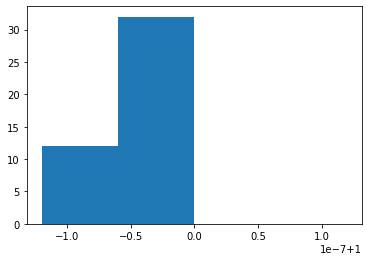

========== Epoch 0 Batch 65==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')


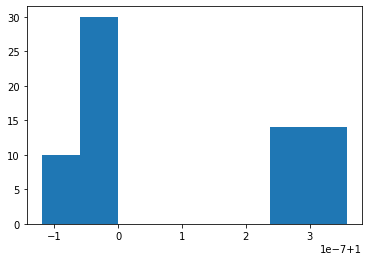

========== Epoch 0 Batch 66==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')


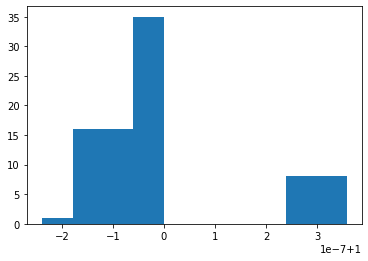

========== Epoch 0 Batch 67==== Step 1  Train Loss 1.1000001430511475
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')


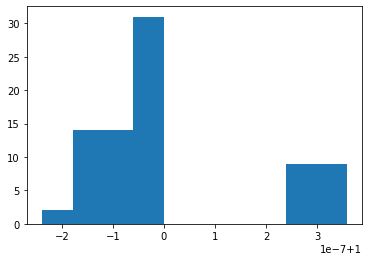

========== Epoch 0 Batch 68==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')


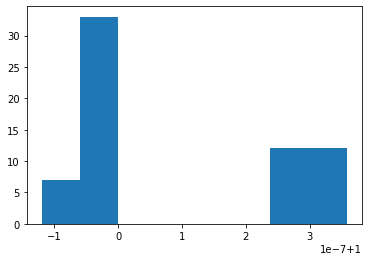

========== Epoch 0 Batch 69==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')


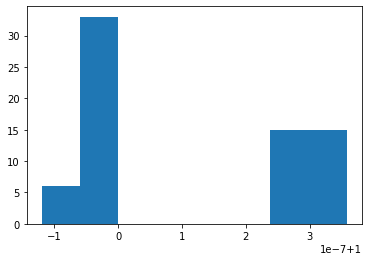

========== Epoch 0 Batch 70==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')


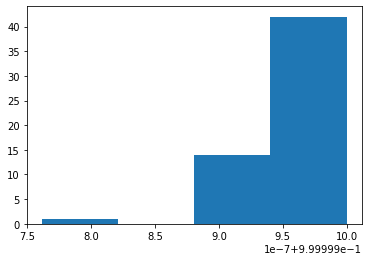

========== Epoch 0 Batch 71==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')


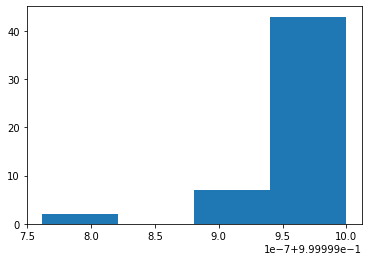

========== Epoch 0 Batch 72==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


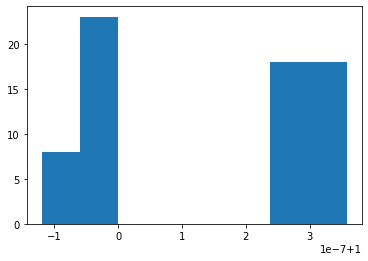

========== Epoch 0 Batch 73==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')


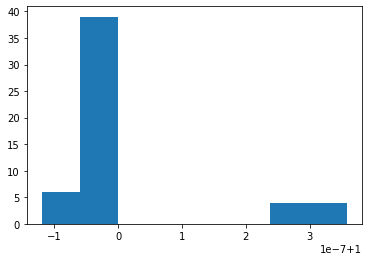

========== Epoch 0 Batch 74==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')


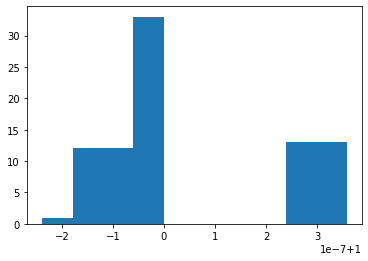

========== Epoch 0 Batch 75==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')


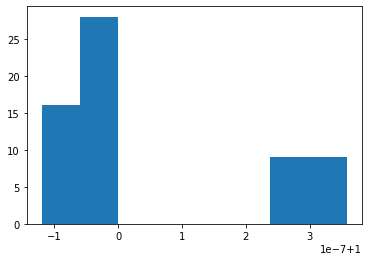

========== Epoch 0 Batch 76==== Step 1  Train Loss 1.1000001430511475
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')


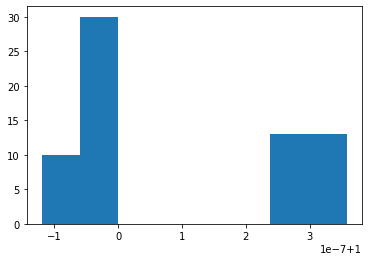

========== Epoch 0 Batch 77==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')


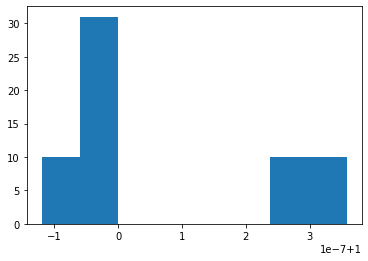

========== Epoch 0 Batch 78==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')


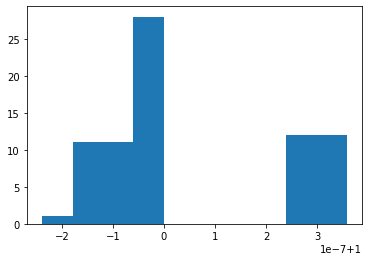

========== Epoch 0 Batch 79==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')


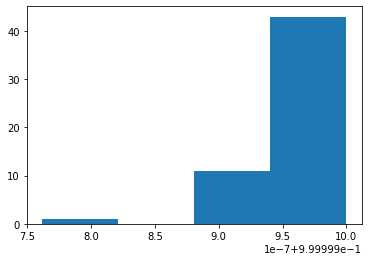

========== Epoch 0 Batch 80==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')


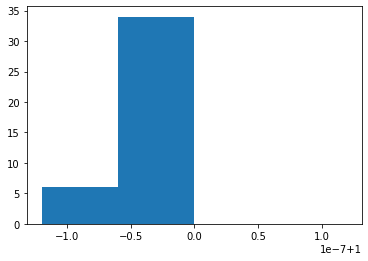

========== Epoch 0 Batch 81==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')


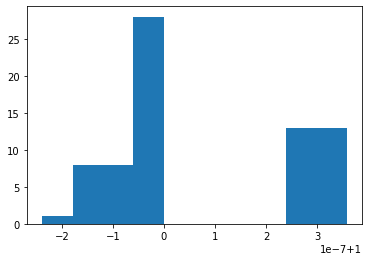

========== Epoch 0 Batch 82==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')


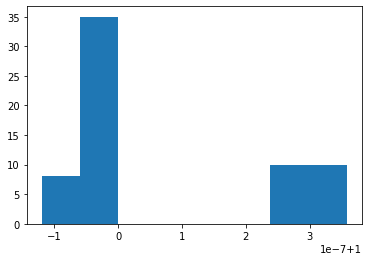

========== Epoch 0 Batch 83==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')


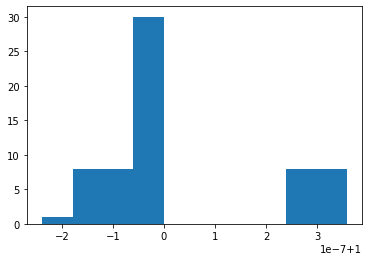

========== Epoch 0 Batch 84==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')


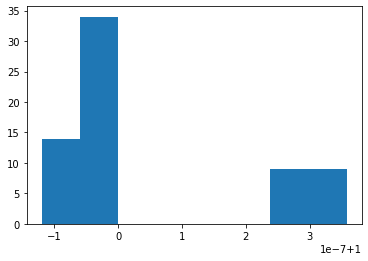

========== Epoch 0 Batch 85==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')


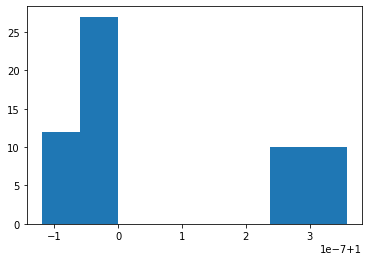

========== Epoch 0 Batch 86==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')


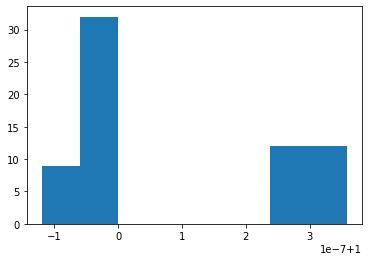

========== Epoch 0 Batch 87==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')


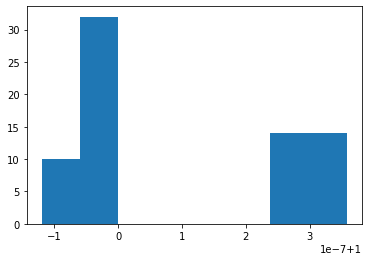

========== Epoch 0 Batch 88==== Step 1  Train Loss 1.1000001430511475
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')


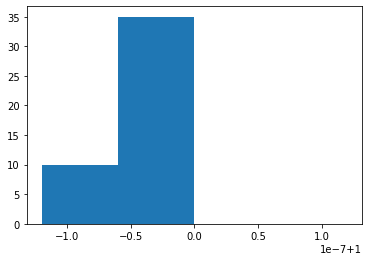

========== Epoch 0 Batch 89==== Step 1  Train Loss 1.1000001430511475
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')


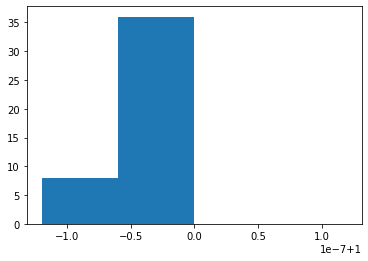

========== Epoch 0 Batch 90==== Step 1  Train Loss 1.1000001430511475
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')


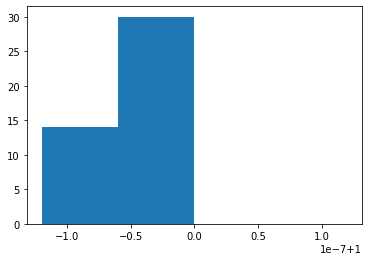

========== Epoch 0 Batch 91==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')


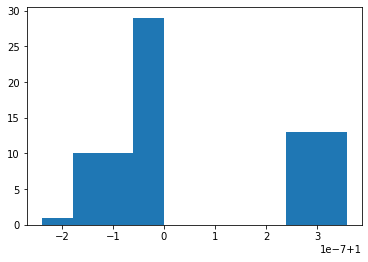

========== Epoch 0 Batch 92==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')


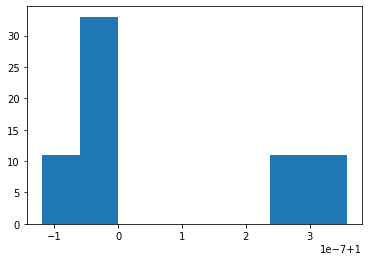

========== Epoch 0 Batch 93==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')


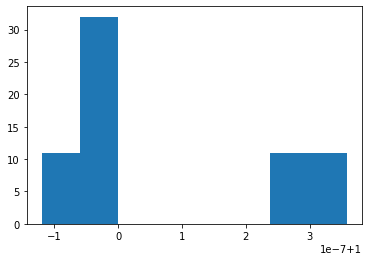

========== Epoch 0 Batch 94==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')


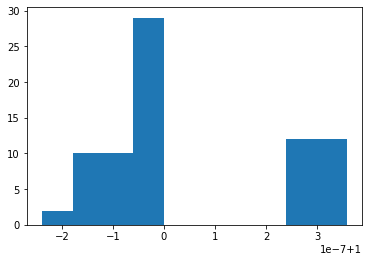

========== Epoch 0 Batch 95==== Step 1  Train Loss 1.1000001430511475
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')


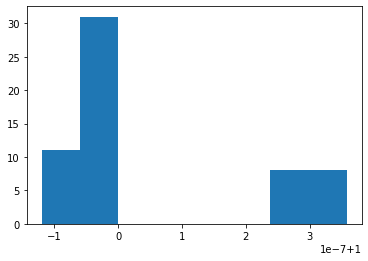

========== Epoch 0 Batch 96==== Step 1  Train Loss 1.100000023841858
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')


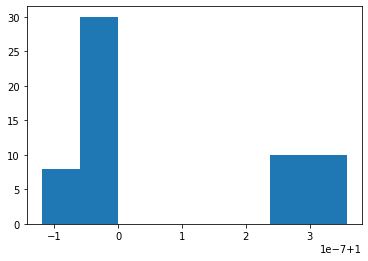

========== Epoch 0 Batch 97==== Step 1  Train Loss 1.1000001430511475
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


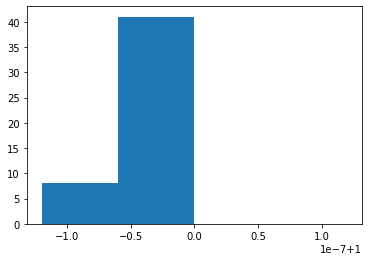

========== Epoch 0 Batch 98==== Step 1  Train Loss 1.0999999046325684
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')


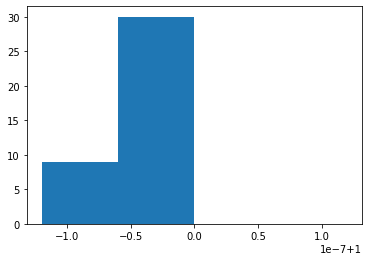

========== Epoch 0 Batch 99==== Step 1  Train Loss 1.100000023841858
  Batch   100  of  3,213.    Elapsed: 0:02:24.


KeyboardInterrupt: ignored

In [ ]:
# torch.cuda.empty_cache()
mytrainStep1(modelEmb,criterion1,criterion2)
 

In [ ]:
modelEmb.load_state_dict(torch.load('checkPointEmb.pt'))

modelEmb.cuda()

myModelEmbeddings(
  (bertModel): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
mytrainStep2(modelCLS,criterion1,criterion2,modelEmb)

In [ ]:
import shutil
shutil.copy("checkpointEmb.pt",'/content/drive/My Drive/Thesis/MaskAll/Separated')
shutil.copy("checkpoint.pt",'/content/drive/My Drive/Thesis/MaskAll/Separated')

# BERT + Bi-LSTM CL

In [ ]:
class myModelEmbeddings(nn.Module):
  def __init__(self,bert_emb_layer,startLayer,endLayer,bertModel,groupLayersMode = (False,False)):#(True,True)-> Grouping and Summing | #(True,False)-> Grouping and Concat
      super(myModelEmbeddings, self).__init__()
      self.bert_emb_layer = bert_emb_layer
      self.startLayer = startLayer
      self.endLayer = endLayer
      # self.num_unitsFC = num_unitsFC
      self.groupLayersMode = groupLayersMode
      self.bertModel = bertModel
      
      # for param in model.bertModel.parameters():
      #     param.requires_grad = False
      # modules = [self.bertModel.embeddings, *self.bertModel.encoder.layer[:8]] #Replace 8 by what you want
      # for module in modules:
      #     for param in module.parameters():
      #         param.requires_grad = False
     
      inputFeatures = 0
      if self.groupLayersMode == (True,False):
        inputFeatures = (endLayer - startLayer)*768 
      elif self.groupLayersMode == (True,True):
        inputFeatures = 768
      else:
        inputFeatures = 768
      self.bilstm = nn.LSTM(input_size=768, hidden_size=768,batch_first=True,bidirectional=True)#num_layers=3,dropout=0.2,
      self.dropout = nn.Dropout(0.1)  
       
      self.dropout2 = nn.Dropout(0.1)
      self.dropout3 = nn.Dropout(0.1)
      # self.conv_1 = nn.Conv1d(768, 128, 3)
      # self.maxPool = nn.MaxPool1d(2)
      self.tanh = nn.Tanh()
      self.relu = nn.ReLU()
      self.dropout4 = nn.Dropout(0.1)
      self.FC1 = nn.Linear(in_features = 256*4,out_features = 2)
      
      self.FC2 = nn.Linear(in_features = 64,out_features = 2)
      self.FC3 = nn.Linear(in_features = 16,out_features = 2)
     
      

  def getSpecificLayerOfBERT(self,bertOutputs):
      hidden_states = bertOutputs[2][1:] 
      layerOutput = hidden_states[self.bert_emb_layer] # get specific Layer (from 0 to 11) for all tuples (batch_size, sequence_length, hidden_size)
      
      return  layerOutput
  
  def concatSpecificLayersOfBERT(self,bertOutputs):
      hidden_states = bertOutputs[2][0:] 
      concatEmbeddingLayers = torch.cat([hidden_states[i] for i in range(self.startLayer,self.endLayer)], dim=-1)
      
      return concatEmbeddingLayers
  def getCLSEmbeddings(self,bertOutputs ):
      embeddings = bertOutputs[0] #last hidden states
      #embeddings = bertOutputs[1] # pooler
      return embeddings
  def getCLSEmbeddingsFromLayers(self,bertOutputs ):
      hidden_states = bertOutputs[2][0:]
      
      
      # Extract the hidden state for the [CLS] token from last four encode layers
      last_layer_hidden_states = hidden_states[2:6]
      cls = []
      for layer in last_layer_hidden_states:
          cls.append(layer[:,0,:])
      cls_embeddings = torch.stack(cls, dim=1)
      del cls
    
      #concat_cls_embeddings = torch.cat(cls_embeddings, dim=1).unsqueeze(1)

    
      
      
      # sumEmbeddingLayers = torch.stack(hidden_states[-2:]).sum(0) #sum only CLS Embs from last four layers
      #cls = sumEmbeddingLayers[:,0,:]

      return cls_embeddings
  def sumSpecificLayersOfBERT(self,bertOutputs):
      #Number of layers: 13   (initial embeddings + 12 BERT layers) - So we need [2][1:] 1 and onwards
      hidden_states = bertOutputs[2][0:]
      # `hidden_states` is a Python list.
     
      # sumEmbeddingLayers = torch.stack(hidden_states[self.startLayer:self.endLayer]).sum(0)
      sumEmbeddingLayers = torch.stack(hidden_states[-4:]).sum(0)
      # sumEmbeddingLayers = torch.stack(hidden_states[-4:]).mean(dim=0)
      del hidden_states

      return sumEmbeddingLayers
  def pooling(self,token_embeddings, mask, strategy='avg'):
      if strategy == 'max':
        #  avg_setence_embeddings = torch.mean(token_embeddings,dim=1)
        #  print(avg_setence_embeddings.shape)
         input_mask_expanded = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
         token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
         max_setence_embeddings = torch.max(token_embeddings, 1)[0]
         return max_setence_embeddings
      elif strategy == 'avg':
         in_mask = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
         # perform mean-pooling but exclude padding tokens (specified by in_mask)
         avg_setence_embeddings = torch.sum(token_embeddings * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
         return avg_setence_embeddings
      elif strategy == 'sum':
        sum_setence_embeddings = torch.sum(token_embeddings[0:len(token_embeddings)],1)
        return sum_setence_embeddings

  def forwardOnce(self, sent_id, mask):
      outputs =  self.bertModel(input_ids=sent_id, attention_mask=mask,decoder_input_ids=sent_id)
    
      if self.groupLayersMode == (True,False):
        embeddings = self.concatSpecificLayersOfBERT(outputs)
        return  embeddings 
      elif self.groupLayersMode == (True,True):
        embeddings = self.sumSpecificLayersOfBERT(outputs)
        # embeddings = self.getCLSEmbeddingsFromLayers(outputs)
        return embeddings 
      else:
        # embeddings = self.getSpecificLayerOfBERT(outputs)
        embeddings = self.getCLSEmbeddings(outputs )
        return embeddings 
      
  def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((2*1, batch_size, 768)).detach().to(device)
        c0 = torch.zeros((2*1, batch_size, 768)).detach().to(device)
        hidden = (h0, c0)
        return hidden
  def forward(self, sent_id1, mask1,hidden):

      # forward pass of input 1
      output1 = self.forwardOnce(sent_id1, mask1)
      
    
  
     
   
      # output1 = output1[:, 0, :]
      # output2 = output2[:, 0, :]
      # output1 = self.tanh(output1)
      # output1 = self.dropout(output1)
      out1, (hidden1,cell1) = self.bilstm(output1,hidden)
      # out1,hidden11 = self.bilstm(output1,hidden)
      #Extract only the hidden state from the last LSTM cell
      # out11 = out1[:,-1,:]
      # print(hidden11)
      # h1 = hidden1
      # final_repr = torch.cat([h_n[-2, :, :], h_n[-1, :, :]], dim=1)

      # out_split1 = out1.view(sent_id1.shape[0], 512, 2, 768)
    
      out_split1 = out1.view(sent_id1.shape[0], 256, 2, 768)
      out_forward1 = out_split1[:, :, 0, :]
      out_backward1 = out_split1[:, :, 1, :]
      batch_indices = torch.arange(0, sent_id1.shape[0], device=device)
      seq_indices = 256 - 1
      direction_full1 = torch.cat([out_split1[batch_indices, seq_indices, 0], out_split1[batch_indices, 0, 1]], dim=-1)
      # return F.normalize(direction_full1), F.normalize(direction_full2),output2
      return direction_full1

In [ ]:
class myModelEmbeddings(nn.Module):
  def __init__(self,bert_emb_layer,startLayer,endLayer,bertModel,groupLayersMode = (True,True)):#(True,True)-> Grouping and Summing | #(True,False)-> Grouping and Concat
      super(myModelEmbeddings, self).__init__()
      self.bert_emb_layer = bert_emb_layer
      self.startLayer = startLayer
      self.endLayer = endLayer
      # self.num_unitsFC = num_unitsFC
      self.groupLayersMode = groupLayersMode
      self.bertModel = bertModel
      
      # for param in model.bertModel.parameters():
      #     param.requires_grad = False
      # modules = [self.bertModel.embeddings, *self.bertModel.encoder.layer[:4]] #Replace 8 by what you want
      # for module in modules:
      #     for param in module.parameters():
      #         param.requires_grad = False
     
      inputFeatures = 0
      if self.groupLayersMode == (True,False):
        inputFeatures = (endLayer - startLayer)*768 
      elif self.groupLayersMode == (True,True):
        inputFeatures = 768
      else:
        inputFeatures = 768
      self.bilstm = nn.LSTM(input_size=768, hidden_size=768,batch_first=True,bidirectional=True)#num_layers=3,dropout=0.2,
      self.dropout = nn.Dropout(0.1)  
       
      self.dropout2 = nn.Dropout(0.1)
      self.dropout3 = nn.Dropout(0.1)
      # self.conv_1 = nn.Conv1d(768, 128, 3)
      # self.maxPool = nn.MaxPool1d(2)
      self.tanh = nn.Tanh()
      self.relu = nn.ReLU()
      self.dropout4 = nn.Dropout(0.1)
      self.FC1 = nn.Linear(in_features = 256*4,out_features = 2)
      
      self.FC2 = nn.Linear(in_features = 64,out_features = 2)
      self.FC3 = nn.Linear(in_features = 16,out_features = 2)
     
      

  def getSpecificLayerOfBERT(self,bertOutputs):
      hidden_states = bertOutputs[2][1:] 
      layerOutput = hidden_states[self.bert_emb_layer] # get specific Layer (from 0 to 11) for all tuples (batch_size, sequence_length, hidden_size)
      
      return  layerOutput
  
  def concatSpecificLayersOfBERT(self,bertOutputs):
      hidden_states = bertOutputs[2][0:] 
      concatEmbeddingLayers = torch.cat([hidden_states[i] for i in range(self.startLayer,self.endLayer)], dim=-1)
      
      return concatEmbeddingLayers
  def getCLSEmbeddings(self,bertOutputs ):
      embeddings = bertOutputs[0] #last hidden states
      return embeddings
  def sumSpecificLayersOfBERT(self,bertOutputs):
      #Number of layers: 13   (initial embeddings + 12 BERT layers) - So we need [2][1:] 1 and onwards
      hidden_states = bertOutputs[2][0:]
      # `hidden_states` is a Python list.
     
      # sumEmbeddingLayers = torch.stack(hidden_states[self.startLayer:self.endLayer]).sum(0)
      sumEmbeddingLayers = torch.stack(hidden_states[-4:]).sum(0)
      # sumEmbeddingLayers = torch.stack(hidden_states[-4:]).mean(dim=0)
      del hidden_states

      return sumEmbeddingLayers
  def pooling(self,token_embeddings, mask, strategy='avg'):
      if strategy == 'max':
        #  avg_setence_embeddings = torch.mean(token_embeddings,dim=1)
        #  print(avg_setence_embeddings.shape)
         input_mask_expanded = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
         token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
         max_setence_embeddings = torch.max(token_embeddings, 1)[0]
         return max_setence_embeddings
      elif strategy == 'avg':
         in_mask = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
         # perform mean-pooling but exclude padding tokens (specified by in_mask)
         avg_setence_embeddings = torch.sum(token_embeddings * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
         return avg_setence_embeddings
      elif strategy == 'sum':
        sum_setence_embeddings = torch.sum(token_embeddings[0:len(token_embeddings)],1)
        return sum_setence_embeddings

  def forwardOnce(self, sent_id, mask):
      outputs =  self.bertModel(sent_id, attention_mask=mask)
    
      if self.groupLayersMode == (True,False):
        embeddings = self.concatSpecificLayersOfBERT(outputs)
        return  embeddings 
      elif self.groupLayersMode == (True,True):
        embeddings = self.sumSpecificLayersOfBERT(outputs)
        return embeddings 
      else:
        # embeddings = self.getSpecificLayerOfBERT(outputs)
        embeddings = self.getCLSEmbeddings(outputs )
        return embeddings 
      
  def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((2*1, batch_size, 768)).detach().to(device)
        c0 = torch.zeros((2*1, batch_size, 768)).detach().to(device)
        hidden = (h0, c0)
        return hidden
  def forward(self, sent_id1, mask1,sent_id2, mask2,b_labels,hidden):

      # forward pass of input 1
      output1 = self.forwardOnce(sent_id1, mask1)
      # forward pass of input 2
      output2  = self.forwardOnce(sent_id2, mask2)
    
  
      cos = nn.CosineSimilarity(dim=1)
   
      # output1 = output1[:, 0, :]
      # output2 = output2[:, 0, :]
      # output1 = self.tanh(output1)
      # output1 = self.dropout(output1)
      out1, (hidden1,cell1) = self.bilstm(output1,hidden)
      # out1,hidden11 = self.bilstm(output1,hidden)
      #Extract only the hidden state from the last LSTM cell
      # out11 = out1[:,-1,:]
      # print(hidden11)
      # h1 = hidden1
      # final_repr = torch.cat([h_n[-2, :, :], h_n[-1, :, :]], dim=1)

      out_split1 = out1.view(sent_id1.shape[0], 512, 2, 768)
      out_forward1 = out_split1[:, :, 0, :]
      out_backward1 = out_split1[:, :, 1, :]
      batch_indices = torch.arange(0, sent_id1.shape[0], device=device)
      seq_indices = 512 - 1
      direction_full1 = torch.cat([out_split1[batch_indices, seq_indices, 0], out_split1[batch_indices, 0, 1]], dim=-1)
      # direction_full1 = torch.cat([out_forward1[:, -1, :], out_backward1[:, 0, :]], dim=1)   
      # print(h1[1])
      # Access the last hidden state of the forward LSTM
      # print(hidden1)
      # forward_hidden = h1[0, :, :]
      # print(forward_hidden)
      # Access the last hidden state of the backward LSTM
      # backward_hidden = h1[1, :, :]
      # print(backward_hidden)
      # h1 = self.dropout2(h1)
      # print(h1)
      # print(h1.shape)
      # direction_1, direction_2 = forward_hidden,backward_hidden#h1[0], h1[1]
      # direction_full1 = torch.cat((direction_1, direction_2), 1)
      # direction_full1 = self.tanh(direction_full1)
      # direction_full1 = self.dropout(direction_full1)
      # direction_full1 = self.conv_1(direction_full1)
      # direction_full1 = self.maxPool(direction_full1)
      # output2 = self.tanh(output2)
      # output2 = self.dropout(output2)
      out2, (hidden2,cell2) = self.bilstm(output2,hidden)
      # out22 = out2[:,-1,:]
      # h2 = hidden2
      # final_repr = torch.cat([h_n[-2, :, :], h_n[-1, :, :]], dim=1)
      out_split2 = out2.view(sent_id1.shape[0], 512, 2, 768)
      out_forward2 = out_split2[:, :, 0, :]
      out_backward2 = out_split2[:, :, 1, :]
      # direction_full2 = torch.cat([out_forward2[:, -1, :], out_backward2[:, 0, :]], dim=1)
      direction_full2 = torch.cat([out_split2[batch_indices, seq_indices, 0], out_split2[batch_indices, 0, 1]], dim=-1)
      # forward_hidden2 = h2[0, :, :]
      # backward_hidden2 = h2[1, :, :]
      # direction_21, direction_22 = forward_hidden2,backward_hidden2#h2[0], h2[1]
      # direction_full2 = torch.cat((direction_21, direction_22), 1)
      # direction_full2 = self.tanh(direction_full2)
      # direction_full2 = self.dropout(direction_full2)
      # direction_full2 = self.conv_1(direction_full2)
      # direction_full2 = self.maxPool(direction_full2)
      # FC11 = self.FC(output1)
      # FC11 = self.tanh(FC11)
      # FC22 = self.FC(output2)
      # FC22 = self.tanh(FC22)

      # avgoutput1 = self.pooling(output1,mask1,'avg')
      # avgoutput2 = self.pooling(output2,mask2,'avg')
      # out = torch.cat((direction_full1, direction_full2), 1)
      
      # out = self.dropout(out)
      # direction_full1 = self.tanh(direction_full1)
      # out = self.relu(out)
      # out = self.FC1(out)
      # out = self.relu(out)
      # FC11 = self.tanh(FC11)
      # out = self.dropout4(out)

      # direction_full2 = self.tanh(direction_full2)
      # FC22 = self.FC1(direction_full2)
      # FC11 = self.tanh(FC11)
      # FC22 = self.dropout4(FC22)
      # out = self.FC2(out)
      # out = self.dropout4(out)
      # output = self.FC3(out)
      output2 = cos(direction_full1, direction_full2)
      print(output2)
     
      print(b_labels)




      # plt.hist(output2.cpu().data.numpy(), bins=6)
      # plt.show()
      # return F.normalize(direction_full1), F.normalize(direction_full2),output2
      return direction_full1, direction_full2,output2

In [ ]:
def validation(model,epoch,criterion1,validation_dataloader,modelFC=None,criterion2 = None):
    
      # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    # model.bertModel.eval()
 
    model.eval()
    if modelFC is not None:
        modelFC.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # tsne = TSNE()
    step = 0
    concatAll = []
    totalF1 = 0
    totalAcc = 0
    avg_val_accuracy = 0
    # for (input1,mask1, target1),(input2,mask2, target2) in validation_dataloader:
    # for batch in test_dataloader:
    # for anchor,anchorMask,replicas,replicasMask in validation_dataloader:

    for input1, mask1, input2, mask2 in validation_dataloader:
        step += 1
        # if step == 71:
        #    break
        # b_input_mask1 = anchorMask.to(device)#torch.ones(anchor.shape[:-1], device=device)
        # b_input_mask2 = replicasMask.to(device)#torch.ones(replicas.shape[:-1], device=device)
        # b_input_ids1 = anchor.to(device)
        # b_input_ids2 = replicas.to(device)
        # labels = torch.arange(0, b_input_mask1.shape[0], device=device)
        
        b_input_ids1 = input1.to(device)
       
        b_input_mask1 = mask1.to(device)
        # target1 = target1.type(torch.FloatTensor)
        # b_labels = target1.to(device)
        h = model.init_hidden(b_input_ids1.shape[0])
        b_input_ids2 = input2.to(device)
        b_input_mask2 = mask2.to(device)

        with torch.no_grad():        
            if modelFC==None:

              FC11 = model(b_input_ids1, b_input_mask1,h)             
              FC22 = model(b_input_ids2, b_input_mask2,h)             
              cos = nn.CosineSimilarity(dim=1)
              output2 = cos(FC11, FC22)
              # pos_indices = torch.where(b_labels==1)[0]
              # neg_indices = torch.where(b_labels==0)[0]
              # # print(pos_indices)
              # # print(neg_indices)
              # indices_tuple = (pos_indices,pos_indices,neg_indices,neg_indices)
              # loss1 = criterion1(FC11,b_labels,indices_tuple,ref_emb=FC22, ref_labels=b_labels)
              # output = F.cosine_similarity(FC11, FC22)
             
              # loss1 = criterion1(output, b_labels)
              # labels = torch.cat([b_labels, b_labels], dim=0)      
              # loss1 = criterion1(embeddings,b_labels.repeat(2))
            
              loss1,acc = criterion1(FC11,FC22)
              # loss1= criterion1(FC11, labels, ref_emb=FC22, ref_labels=labels)
            elif modelFC is not None and criterion2 is not None:
              
              #output11, output22,FC11,FC22,avg1,avg2,concatenated,concatenatedfc,_ = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2)
              FC11,FC22,_ = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2,h)
              out = modelFC(FC11,FC22)
              loss2 = criterion2(out,b_labels)
            if modelFC == None:
                total_eval_loss += loss1.item()
                # print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 1 AVG. val Loss "+str(loss1.item()))
                # f1 = calcF1score(cos,b_labels)
                # totalF1 += f1
                # probs = F.softmax(cos, dim=1).cpu().numpy()
                # accuracy = calcAccuracy(probs,b_labels)
                totalAcc+=0#acc.cpu().item()
              
                # print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 2 Probs")
                # print(probs) 
                print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 1 AVG. val Loss "+str(loss1.item()),"acc =",str(acc))
                # label_ids = b_labels.to('cpu').numpy()
                
            elif modelFC is not None and criterion2 is not None:
            
                total_eval_loss += loss2.item()
                f1 = calcF1score(out,b_labels)
                totalF1 += f1
                probs = F.softmax(out, dim=1).cpu().numpy()
                accuracy = calcAccuracy(probs,b_labels)
                totalAcc+=accuracy
                print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 2 Probs")
                print(probs) 
                print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 2  val Loss "+str(loss2.item()), "==== ",str(f1),"===== Acc = ",str(accuracy))
                modelFC.train()
    if modelFC==None:
      avg_val_loss = total_eval_loss/len(validation_dataloader)
      avg_f1_val = totalF1/len(validation_dataloader)
      avg_val_accuracy = totalAcc/len(validation_dataloader)
    else:
       avg_val_loss = total_eval_loss/len(validation_dataloader)
       avg_f1_val = totalF1/len(validation_dataloader)
       avg_val_accuracy = totalAcc/len(validation_dataloader)
    
    
    if modelFC==None:
       model.bertModel.train()
       model.train()
    else:
       model.bertModel.eval()
       model.eval()
       modelFC.train()  
    return  avg_val_loss,avg_f1_val ,avg_val_accuracy, #avg_val_f1,

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
def mytrainStep1(model,criterion1,criterion2):

      if torch.cuda.is_available():
          model.to(device)
      # for param in model.bertModel.parameters():
      #         param.requires_grad = False
      # modules = [model.bertModel.embeddings, *model.bertModel.encoder.layer[:8]] #Replace 8 by what you want
      # for module in modules:
      #     for param in module.parameters():
      #         param.requires_grad = False
      modules = [model.bertModel.decoder,*model.bertModel.encoder.block[:10]]
      for module in modules:
          for param in module.parameters():
              param.requires_grad = False
      # optimizer = torch.optim.Adam(model.parameters(),
      #                               lr=0.0001)
      optimizer = AdamW(model.parameters(),
                                    lr=0.0003,#0.003, #5e-5, 3e-5, 2e-5 #0.001 0.00003
                                    #weight_decay=1e-5, 
                                    correct_bias=False) #eps=1e-8,len(train_dataloader)
      #scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=6*len(train_dataloader))
      # Set the seed value all over the place to make this reproducible.
      scheduler = ReduceLROnPlateau(optimizer, 'min')
      seed_val = 42

      random.seed(seed_val)
      np.random.seed(seed_val)
      torch.manual_seed(seed_val)
      torch.cuda.manual_seed_all(seed_val)

      # We'll store a number of quantities such as training and validation loss, 
      # validation accuracy, and timings.
      training_stats = []

      # Measure the total training time for the whole run.
      total_t0 = time.time()

      # For each epoch...
      listOflossesTrain = list()
      listOfF1Train = list()
      listOflossesValid = list()
      listOfF1Valid = list()
      epoch_stop = 0
      model.bertModel.train()
      model.train()
      totalAcc = 0
      for epoch_i in range(0, 2):

          # modules = [model.bertModel.embeddings, *model.bertModel.encoder.layer[:7]] #Replace 8 by what you want
          # for module in modules:
          #     for param in module.parameters():
          #         param.requires_grad = False
          # modules = [model.bertModel.embeddings, *model.bertModel.encoder.layer[7:]] #Replace 8 by what you want
          # for module in modules:
          #     for param in module.parameters():
          #         param.requires_grad = False
          # if epoch_i > 0:

          #     for param in model.bertModel.parameters():
          #         param.requires_grad = False

          print("")
          print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs))
          print('Training...')

          # Measure how long the training epoch takes.
          t0 = time.time()

          # Reset the total loss for this epoch.
          total_train_loss = 0
          # model.bertModel.train()
          

          # For each batch of training data...
          step = 0
          # for (input1,mask1, target1),(input2,mask2, target2) in train_dataloader:
          accum_iter = 4
          # for anchor,anchorMask,replicas,replicasMask in train_dataloader:

    # for input1, mask1, input2, mask2,target1 in validation_dataloader:
              # step += 1

              # b_input_mask1 = anchorMask.to(device)
              # b_input_mask2 = replicasMask.to(device)
              # labels = torch.arange(0, b_input_mask1.shape[0], device=device)
              # b_input_ids1 = anchor.to(device)
              # b_input_ids2 = replicas.to(device)
          for batch_idx,(input1, mask1, input2, mask2) in  enumerate(train_dataloader):
              step+=1
              # if step==151:
              #    break
              # # Progress update every 40 batches.
              # h = model.init_hidden(target1.size(0))
              if step % 100 == 0 and not step == 0:
                  # Calculate elapsed time in minutes.
                  elapsed = format_time(time.time() - t0)
                  # Report progress.
                  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

              # if torch.cuda.is_available():
              b_input_ids1 = input1.to(device)
              b_input_mask1 = mask1.to(device)
              # target1 = target1.type(torch.FloatTensor)
              # target1 = torch.where(target1==0,torch.tensor(-1),target1)
            
              # b_labels = target1.to(device)
              h = model.init_hidden(b_input_ids1.shape[0])
              # # b_labels = b_labels.unsqueeze(1)
              b_input_ids2 = input2.to(device)
              b_input_mask2 = mask2.to(device)
              # b_labels=b_labels.reshape(-1,1)
              # b_labels = torch.squeeze(b_labels,1)
              model.zero_grad()
              # optimizer.zero_grad()
              # with torch.set_grad_enabled(True):
                  #output11, output22,FC11,FC22,avg1,avg2,concatenated,concatenatedfc,_ = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2) 
              # print(a1)
              # print(a2)
              # FC11,FC22,cos = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2,b_labels,h)
              FC11 = model(b_input_ids1, b_input_mask1,h)             
              FC22 = model(b_input_ids2, b_input_mask2,h)
              # cos = nn.CosineSimilarity(dim=1)
              # output2 = cos(FC11, FC22)
              # print(output2)
              # print(b_labels)       
              # pos_indices = torch.where(b_labels==1)[0]
              # neg_indices = torch.where(b_labels==0)[0]
              #     # print(pos_indices)
              #     # print(neg_indices)
              # indices_tuple = (pos_indices,pos_indices,neg_indices,neg_indices)
                  
              # loss1 = criterion1(cos,b_labels)
              # loss1= criterion1(FC11, labels, ref_emb=FC22, ref_labels=labels)
              # labels = torch.cat([b_labels, b_labels], dim=0)      
              # loss1 = criterion1(embeddings,b_labels.repeat(2))
              loss1,acc = criterion1(FC11,FC22)
              # (loss1 / gradient_accumulations).backward()

              # if ((batch_idx + 1) % gradient_accumulations == 0) or (batch_idx + 1 == len(train_dataloader)):
              #     optimizer.step()
              #     model.zero_grad()
              # print(output)
              # loss1 = criterion1(output, b_labels)
              # loss1 = criterion1(FC11,b_labels,indices_tuple,ref_emb=FC22, ref_labels=b_labels)
              # loss1 = loss1 / accum_iter
     
              # apply weight decay regularization
              
              # totalAcc += acc.cpu().item()
              # print(totalAcc) 
              total_train_loss += loss1.item()
                  # print(loss.data[0])
             
              print("========== Epoch "+str(epoch_i)+ " Batch "+str(step)+"==== Step 1  Train Loss "+str(loss1.item()),"acc =",str(acc))
              # decay = 0.0001
              # for param in model.parameters():
              #     loss1 += decay * torch.norm(param, p='fro')
              loss1.backward()
              # if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_dataloader)):
              # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
              optimizer.step()
                  # optimizer.zero_grad()
              #scheduler.step()
                      
          avg_train_loss = total_train_loss /len(train_dataloader)
          print("========== Epoch "+str(epoch_i)+ " ==== Step 1 AVG. Train Loss "+str(avg_train_loss))            
          listOflossesTrain.append(avg_train_loss)
          training_time = format_time(time.time() - t0)

          print("")
          # print("  Average training loss: {0:.2f}".format(avg_train_loss))
          print("  Training epoch took: {:}".format(training_time))
          
          # print("  Accuracy: {0:.2f}".format(avg_train_accuracy))

          # Calculate the average loss over all of the batches.avg_val_accuracy, avg_val_f1,
          avg_val_loss,avgf1,avgAcc = validation(model,epoch_i,criterion1,validation_dataloader)
          scheduler.step(avg_val_loss)
          listOflossesValid.append(avg_val_loss)
          # listOfF1Valid.append(avg_val_f1)
          # Measure how long the validation run took.
          validation_time = format_time(time.time() - t0)
        
          print("  Average Validation Loss: {0:.2f}".format(avg_val_loss))
          print("  Average Validation Accuracy: {0:.2f}".format(avgAcc))
          print("  Validation took: {:}".format(validation_time))

       
          early_stopping1(avg_val_loss, model)
          epoch_stop = epoch_i+1
          if early_stopping1.early_stop:
              print("Early stopping")
              # break  

      print("")
      print("Training complete!")

      print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
      createPlot(listOflossesTrain,listOflossesValid,2)
      return listOflossesValid, listOflossesTrain
      # mytrainStep2(modelCLS,criterion1,criterion2,model)
      # torch.save(model.state_dict(), 'checkPointEmblstm.pt')

In [ ]:
class InfoNCE(nn.Module):
    def __init__(self):
        super(InfoNCE, self).__init__()
        self.t = torch.nn.Parameter(torch.tensor([0.07]))
    def sim_matrix(self,a, b, eps=1e-8):
        """
        added eps for numerical stability
        """
        a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
        a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
        b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
        sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
        return sim_mt.to(device)    
    def forward(self, x1, x2):
        # if labels is None:
        batch_size = x1.shape[0]
        similarity_matrix = self.sim_matrix(x1, x2)
        # print(similarity_matrix)
        diagonal = torch.diagonal(similarity_matrix).unsqueeze(1)#.to(device) #diagonal are the positives
        gt_pos = F.pad(torch.LongTensor(), (0,len(diagonal)), "constant", 1).to(device)#.unsqueeze(1)#.to(device)
        
        # gt_pos = torch.cat((1-gt_pos,gt_pos),dim=1).to(device)
        negatives = similarity_matrix.flatten()[1:].view(batch_size-1, batch_size+1)[:,:-1].reshape(batch_size, batch_size-1).flatten().unsqueeze(1)#.to(device)
        # plt.hist(diagonal.cpu().data.numpy(), bins=16, alpha=0.5, label='same_author')
        # plt.hist(negatives.cpu().data.numpy(), bins=16, alpha=0.5, label='diff_author')
        # plt.title('Score distributions for same and different author pairs')
        # plt.xlabel('score')
        # plt.ylabel('count')
        # plt.show()
        diagonal = torch.cat((1-diagonal,diagonal),dim=1).to(device)
        lab_neg = F.pad(torch.LongTensor(), (0,len(negatives)), "constant", 0).to(device)#.unsqueeze(1)
        negatives = torch.cat((1-torch.relu(negatives),negatives),dim=1)
        # negatives = torch.cat((torch.abs(negatives),negatives),dim=1).to(device)
        #lab_neg = F.pad(torch.Tensor(), (0,len(negatives)), "constant", 0).unsqueeze(1)#.to(device)
        # negatives = torch.cat((negatives,1-negatives),dim=1).to(device)
        # lab_neg = torch.cat((lab_neg,1-lab_neg),dim=1).to(device)
        loss_pos = F.cross_entropy(diagonal, gt_pos).mean()#.to(device)
        loss_neg = F.cross_entropy(negatives, lab_neg).mean()#.to(device)
        loss = (loss_pos + loss_neg) / 2
        with torch.no_grad():
            preds_pos = diagonal.argmax(1)#.to(device)
            preds_neg = negatives.argmax(1)#.to(device)
            accuracy_pos = (torch.sum(preds_pos == gt_pos) )/len(diagonal) #.argmax(1)
            accuracy_neg = (torch.sum(preds_neg == lab_neg) )/len(negatives)
            accuracy = (accuracy_pos+accuracy_neg)/2
        return loss, accuracy

In [ ]:
class InfoNCE(nn.Module):
    def __init__(self):
        super(InfoNCE, self).__init__()
        self.t = torch.nn.Parameter(torch.tensor([0.07])).cuda()
    def forward(self, x1, x2):
        batch_size = x1.shape[0]
        logits = (x1 @ x2.T) * torch.exp(self.t).clamp(max=1)
        labels = torch.arange(0, batch_size).cuda()
    
        loss = (F.cross_entropy(logits.T, labels).mean() + F.cross_entropy(logits, labels).mean()) / 2
        with torch.no_grad():
            preds = F.softmax(logits, dim=1).argmax(-1)
            preds_t = F.softmax(logits.T, dim=1).argmax(-1)

            accuracy = (torch.sum(preds == labels) + torch.sum(preds_t == labels)) / (batch_size * 2)

        return loss, accuracy 

In [ ]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin_pos=1.0, margin_neg=0):
        super(ContrastiveLoss, self).__init__()
        self.margin_pos = margin_pos
        self.margin_neg = margin_neg
    def sim_matrix(self,a, b, eps=1e-8):
        """
        added eps for numerical stability
        """
        a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
        a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
        b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
        sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
        return sim_mt.to(device)  

    def forward(self, x1, x2):
        batch_size = x1.shape[0]
        similarity_matrix = self.sim_matrix(x1, x2)
        # print(similarity_matrix)
        diagonal = torch.diagonal(similarity_matrix)#.to(device) #diagonal are the positives
        gt_pos = F.pad(torch.LongTensor(), (0,len(diagonal)), "constant", 1).to(device)#.unsqueeze(1)#.to(device)
        
        # gt_pos = torch.cat((1-gt_pos,gt_pos),dim=1).to(device)
        negatives = similarity_matrix.flatten()[1:].view(batch_size-1, batch_size+1)[:,:-1].reshape(batch_size, batch_size-1).flatten()#.to(device)
        # print(negatives)
        lab_neg = F.pad(torch.LongTensor(), (0,len(negatives)), "constant", 0).to(device)
        loss_contrastive_pos =torch.mean(torch.pow(self.margin_pos - diagonal, 2))
        loss_contrastive_neg =torch.mean(torch.pow(torch.relu(negatives - self.margin_neg), 2))
        print("pos",str(loss_contrastive_pos))
        print("neg",str(loss_contrastive_neg))
        if torch.isnan(loss_contrastive_neg) == False:  
          loss_contrastive = (loss_contrastive_pos + loss_contrastive_neg)/2
        else:
          loss_contrastive = (loss_contrastive_pos + 0.0)/2
        # print(loss_contrastive_pos)
        # print(loss_contrastive_neg)
        return loss_contrastive,0.0

### start

In [ ]:
from pytorch_metric_learning.reducers import MeanReducer
modelEmb = myModelEmbeddings(bert_emb_layer=10,startLayer=6,endLayer=10,bertModel=bertModel)

# criterion1 = nn.CosineEmbeddingLoss(margin = 0.5)#margin = 0.5
# func = distances.LpDistance
# criterion1 = ContrastiveLossSiamese(margin1 = 0.9)
# criterion1 = getLossFunction(device)
# criterion1 =nn.BCELoss()
#reducer=MeanReducer()
criterion1 = ContrastiveLoss()
# modelEmb.load_state_dict(torch.load('/content/drive/My Drive/Thesis/PAN20/checkpointEmbuncased_PAN20_35k_CL.pt'))#/content/drive/My Drive/Thesis/PAN20/checkpointEmbv2.pt'))
# criterion1 = InfoNCE()
# modelEmb.cuda()
# criterion1 = losses.ContrastiveLoss(distance = distances.CosineSimilarity(),reducer=MeanReducer(),pos_margin=0.92, neg_margin=-0.1) #distance = distances.CosineSimilarity()
criterion2 = nn.CrossEntropyLoss()
early_stopping1 = EarlyStopping(patience=4, path='checkpointEmbT5_PAN22_mem-ess.pt',verbose=True)
early_stopping2 = EarlyStopping(patience=2, verbose=True)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
========== Epoch 1 Batch 4227==== Step 1  Train Loss 0.2628752589225769 acc = 0.0
pos tensor(0.1883, device='cuda:0', grad_fn=<MeanBackward0>)
neg tensor(0.3245, device='cuda:0', grad_fn=<MeanBackward0>)
========== Epoch 1 Batch 4228==== Step 1  Train Loss 0.25643670558929443 acc = 0.0
pos tensor(0.1707, device='cuda:0', grad_fn=<MeanBackward0>)
neg tensor(0.3397, device='cuda:0', grad_fn=<MeanBackward0>)
========== Epoch 1 Batch 4229==== Step 1  Train Loss 0.2551765441894531 acc = 0.0
pos tensor(0.1635, device='cuda:0', grad_fn=<MeanBackward0>)
neg tensor(0.3383, device='cuda:0', grad_fn=<MeanBackward0>)
========== Epoch 1 Batch 4230==== Step 1  Train Loss 0.25090286135673523 acc = 0.0
pos tensor(0.1765, device='cuda:0', grad_fn=<MeanBackward0>)
neg tensor(0.3447, device='cuda:0', grad_fn=<MeanBackward0>)
========== Epoch 1 Batch 4231==== Step 1  Train Loss 0.2605959475040436 acc = 0.0
pos tensor(0.1859, device='cuda:0', grad_fn=<

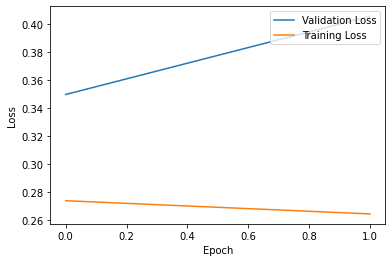

[0.3497739829275965, 0.4056644971070052]
[0.2739248645536997, 0.26449001589353316]


In [ ]:
import pickle
valLosses,trainLosses = mytrainStep1(modelEmb,criterion1,criterion2)
print(valLosses)
print(trainLosses)
# myDict = {}
# myDict['Train'] = []
# myDict['Val'] = []
# myDict['Train'] = trainLosses
# myDict['Val'] = valLosses
# with open( "PAN20_512_cased_train_val_losses", 'wb') as f:
#       pickle.dump(myDict, f)

1-7 unfrezze all bert No <br>
1-7 freeze all bert lr=0.003 3 epochs ok<br>
2-6 or 5 freeze all bert lr=0.003 1 epochs <br>

 

In [ ]:
torch.save(modelEmb.state_dict(), 'finalSiamBERT-Bi-LSTM2.pt')

In [ ]:
# modelEmb.load_state_dict(torch.load('finalSiamBERT-Bi-LSTM.pt'))
criterion1 = InfoNCE()
# modelEmb.cuda()
avg_val_loss,avgf1,avgAcc = validation(modelEmb,0,criterion1,test_dataloader)
print(avg_val_loss)



Running Validation...
11
tensor([[0.7624]], device='cuda:0')
tensor([[0.]], device='cuda:0')
tensor([[0., 1.]], device='cuda:0')
tensor([[0.7624, 0.2376]], device='cuda:0')
========== Epoch 0 Batch 1==== Step 1 AVG. val Loss 0.9895896315574646 acc = 0
11
tensor([[0.7626]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[0., 1.]], device='cuda:0')
tensor([[0.2374, 0.7626]], device='cuda:0')
========== Epoch 0 Batch 2==== Step 1 AVG. val Loss 0.4646657705307007 acc = 0
11
tensor([[0.3478]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[0., 1.]], device='cuda:0')
tensor([[0.6522, 0.3478]], device='cuda:0')
========== Epoch 0 Batch 3==== Step 1 AVG. val Loss 0.8569173812866211 acc = 0
11
tensor([[0.1175]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[0., 1.]], device='cuda:0')
tensor([[0.8825, 0.1175]], device='cuda:0')
========== Epoch 0 Batch 4==== Step 1 AVG. val Loss 1.1471413373947144 acc = 0
11
tensor([[-0.0930]], device='cuda:0')
tensor([[0.]], de

KeyboardInterrupt: ignored

In [ ]:
print(avg_val_loss)

0.2233308533283129


with trunc val loss = 0.5597->0.5430
all chunks val loss = 0.230852->0.220453->0.22825->0.224591

In [ ]:
import shutil
# torch.save(early_stopping1, 'earlyStopping/pt')
shutil.copy('checkpointEmbuncased_PAN22_16bz.pt','/content/drive/My Drive/Thesis/PAN22')
# shutil.copy('PAN20_512_uncased_train_val_losses','/content/drive/My Drive/Thesis/PAN20')

'/content/drive/My Drive/Thesis/PAN22/checkpointEmbuncased_PAN22_16bz.pt'

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
class myModelFC(nn.Module):
  def __init__(self):
      super(myModelFC, self).__init__()
      inputFeatures = 512 #32
      self.FC = nn.Sequential(
        # nn.ReLU(),
        nn.Tanh(),
        nn.Dropout(0.1),  
        nn.Linear(in_features = inputFeatures*4,out_features = 256), #256
        # nn.Tanh(),
        # nn.ReLU(),
        # nn.Dropout(0.1), #0.5
        nn.Linear(in_features = 256,out_features = 2), #64
        # nn.ReLU(),
        # nn.Tanh(),
        # nn.Dropout(0.1),
        # nn.Linear(in_features = 64,out_features = 2), #2
        # nn.Linear(in_features = 64,out_features = 2),
      
      )


  def forward(self, input1, input2):
      concatenated = torch.cat((input1,input1),dim=1)
      
      out = self.FC(concatenated)
      # print(out)
      return out

In [ ]:
def mytrainStep2(model,criterion1,criterion2,embModel):
      # loss = nn.CosineEmbeddingLoss()
      embModel.bertModel.eval()
      embModel.eval()
      for param in embModel.bertModel.parameters():
          param.requires_grad = False
      for param2 in embModel.parameters():
          param2.requires_grad = False    

      if torch.cuda.is_available():
         model.to(device)
      
      
      # embModel.bias.requires_grad = False
      # loss = nn.CrossEntropyLoss()
        # PyTorch scheduler
      optimizer2 = torch.optim.Adam(model.parameters(),
                                    lr=0.00001
                                    )
      # scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=3*len(train_dataloader))
      # Set the seed value all over the place to make this reproducible.
      seed_val = 42

      random.seed(seed_val)
      np.random.seed(seed_val)
      torch.manual_seed(seed_val)
      torch.cuda.manual_seed_all(seed_val)

      # We'll store a number of quantities such as training and validation loss, 
      # validation accuracy, and timings.
      training_stats = []

      # Measure the total training time for the whole run.
      total_t0 = time.time()

      # For each epoch...
      listOflossesTrain2 = list()
      listOfF1Train = list()
      listOflossesValid2 = list()
      listOfF1Valid = list()
      totalf1 = 0
      epoch_stop = 0
      for epoch_i in range(0, 5):

          print("")
          print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs))
          print('Training...')

          # Measure how long the training epoch takes.
          t0 = time.time()

          # Reset the total loss for this epoch.
          total_train_loss2 = 0

          model.train()

          # For each batch of training data...
          step = 0
          totalf1 = 0
          for (input1,mask1,input2,mask2,target1) in train_dataloader:
              step +=1
              if step ==151 :
                break
              # # Progress update every 40 batches.
              if step % 100 == 0 and not step == 0:
                  # Calculate elapsed time in minutes.
                  elapsed = format_time(time.time() - t0)
                  # Report progress.
                  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

              if torch.cuda.is_available():
                  b_input_ids1 = input1.to(device)
                  b_input_mask1 = mask1.to(device)
                  target1 = target1.type(torch.LongTensor)
                  b_labels = target1.to(device)
                  h = embModel.init_hidden(b_labels.size(0))
                  # b_labels = torch.squeeze(b_labels,1)
                  b_input_ids2 = input2.to(device)
                  b_input_mask2 = mask2.to(device)
              
              model.zero_grad()  

              # with embModel.parameters() == False:
              # for p in embModel.parameters():
              #     p.requires_grad = False            
              #output11, output22,FC11,FC22,avg1,avg2,concatenated,concatenatedfc,_ = embModel(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2) 
              FC11,FC22,_ = embModel(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2,b_labels,h)
              out = model(FC11,FC22)
             
              loss = criterion2(out,b_labels)

              total_train_loss2 += loss.item()
              f1 = calcF1score(out,b_labels)
              totalf1+=f1
              print("========== Epoch "+str(epoch_i)+ " Batch "+str(step)+"==== Step 2 Train Loss "+str(loss.item()),"====== ",str(f1))

              loss.backward()

              optimizer2.step()
              # scheduler.step()
              
          avg_train_loss2 = total_train_loss2 /150#len(train_dataloader)
          avg_f1_train = totalf1/150#len(train_dataloader)
          print("========== Epoch "+str(epoch_i)+ " ==== Step 2 Train Loss "+str(avg_train_loss2),"====== ",str(avg_f1_train))            
          listOflossesTrain2.append(avg_train_loss2)
          training_time = format_time(time.time() - t0)

          print("")
          # print("  Average training loss: {0:.2f}".format(avg_train_loss2))
          print("  Training epoch took: {:}".format(training_time))
          
          # print("  Accuracy: {0:.2f}".format(avg_train_accuracy))

          # Calculate the average loss over all of the batches.avg_val_accuracy, avg_val_f1,
          avg_val_loss2,avg_f1_val,avgAcc = validation(embModel,epoch_i,criterion1,validation_dataloader,model,criterion2)
          listOflossesValid2.append(avg_val_loss2)
          # listOfF1Valid.append(avg_val_f1)
          # Measure how long the validation run took.
          validation_time = format_time(time.time() - t0)
        
          print("  Average Validation Loss: {0:.2f}".format(avg_val_loss2))
          print("  Validation avg-F1: {0:.2f}".format(avg_f1_val))
          print("  Validation avg-Accuracy: {0:.2f}".format(avgAcc))
          print("  Validation took: {:}".format(validation_time))

          # Record all statistics from this epoch.
          training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss2,
                'Validation Loss': avg_val_loss2,
                # 'Valid. avg F1.': avg_val_f1,
                # 'Valid. avg Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
          )
          early_stopping2(avg_val_loss2, model)
          epoch_stop = epoch_i+1
          if early_stopping2.early_stop:
              print("Early stopping")
              
              break  

      print("")
      print("Training complete!")

      print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
      createPlot(listOflossesTrain2,listOflossesValid2,epoch_stop)

In [ ]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()
#modelEmb = myModelEmbeddings(bert_emb_layer=6,startLayer=9,endLayer=12,bertModel=bertModel)
modelEmb.load_state_dict(torch.load('finalSiamBERT-Bi-LSTM2.pt'))

modelEmb.cuda()

myModelEmbeddings(
  (bertModel): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
modelCLS = myModelFC()
mytrainStep2(modelCLS,criterion1,criterion2,modelEmb)


======== Epoch 1 / 2 ========
Training...
tensor([ 0.8446,  0.0375, -0.0191, -0.5123,  0.7045,  0.9427,  0.9581,  0.1240,
         0.3576, -0.0707,  0.9492, -0.0733, -0.0232,  0.8786,  0.7015,  0.8562,
         0.9809, -0.2167,  0.7521,  0.9364, -0.1994,  0.8521,  0.9983,  0.9656,
         0.8600, -0.1278,  0.8732, -0.1446,  0.0778,  0.9452, -0.1244,  0.7048,
         0.9433, -0.0730, -0.0209,  0.3029,  0.9567,  0.4802, -0.0246,  0.2960,
         0.9945,  0.8088,  0.9669,  0.0238,  0.8318, -0.1446,  0.7633, -0.1259,
         0.5297,  0.3119,  0.4602,  0.1466,  0.6371, -0.2206, -0.2441, -0.0418,
         0.9941,  0.9910,  0.7803,  0.0174,  0.9503,  0.9938,  0.5052,  0.9526],
       device='cuda:0')
tensor([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
========== Epoch 0 Batch 1==== Step 2 Train Loss 0.6927030

IndexError: ignored

In [ ]:
modelEmb.load_state_dict(torch.load('checkpointEmb.pt'))
modelEmb.cuda()
modelCLS.load_state_dict(torch.load('checkpoint.pt'))
modelCLS.cuda()

myModelFC(
  (FC): Sequential(
    (0): Tanh()
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=3072, out_features=512, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=512, out_features=64, bias=True)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

# BERT + CNN CL

In [ ]:
class myModelEmbeddings(nn.Module):
  def __init__(self,bert_emb_layer,startLayer,endLayer,bertModel,groupLayersMode = (False,False)):#(True,True)-> Grouping and Summing | #(True,False)-> Grouping and Concat
      super(myModelEmbeddings, self).__init__()
      self.bert_emb_layer = bert_emb_layer
      self.startLayer = startLayer
      self.endLayer = endLayer
      # self.num_unitsFC = num_unitsFC
      self.groupLayersMode = groupLayersMode
      self.bertModel = bertModel
      
      # for param in self.bertModel.parameters():
      #     param.requires_grad = False
      # modules = [self.bertModel.embeddings, *self.bertModel.encoder.layer[:4]] #Replace 8 by what you want
      # for module in modules:
      #     for param in module.parameters():
      #         param.requires_grad = False
      num_filters = [16,16,16]
      filter_sizes=[1,2,3] #3,4,5
      inputFeatures = 0
      if self.groupLayersMode == (True,False):
        inputFeatures = (endLayer - startLayer)*768 
      elif self.groupLayersMode == (True,True):
        inputFeatures = 768
      else:
        inputFeatures = 768
      self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=768,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
      self.FC = nn.Linear(np.sum(num_filters), sum(num_filters)) #sum(num_filters)
      self.dropout = nn.Dropout(0.8)  #0.2
      self.dropout3 = nn.Dropout(0.1)
      self.FC2 =  nn.Linear(sum(num_filters)*2, 32)
      self.relu = nn.ReLU()
      self.dropout2 = nn.Dropout(0.1)
      self.FC3 =  nn.Linear(32, 2)
      self.FC4 =  nn.Linear(64, 2)

      self.tanh = nn.Tanh()
     
     
      

  def getSpecificLayerOfBERT(self,bertOutputs):
      hidden_states = bertOutputs[2][1:] 
      layerOutput = hidden_states[self.bert_emb_layer] # get specific Layer (from 0 to 11) for all tuples (batch_size, sequence_length, hidden_size)
      
      return  layerOutput
  
  def concatSpecificLayersOfBERT(self,bertOutputs):
      hidden_states = bertOutputs[2][0:] 
      concatEmbeddingLayers = torch.cat([hidden_states[i] for i in range(self.startLayer,self.endLayer)], dim=-1)
      
      return concatEmbeddingLayers
  def getCLSEmbeddings(self,bertOutputs ):
      embeddings = bertOutputs[0] #last hidden states
      return embeddings
  def sumSpecificLayersOfBERT(self,bertOutputs):
      #Number of layers: 13   (initial embeddings + 12 BERT layers) - So we need [2][1:] 1 and onwards
      hidden_states = bertOutputs[2][0:]
      # `hidden_states` is a Python list.
      
      sumEmbeddingLayers = torch.stack(hidden_states[self.startLayer:self.endLayer]).sum(0)
      del hidden_states

      return sumEmbeddingLayers
  def pooling(self,token_embeddings, mask, strategy='avg'):
      if strategy == 'max':
        #  avg_setence_embeddings = torch.mean(token_embeddings,dim=1)
        #  print(avg_setence_embeddings.shape)
         input_mask_expanded = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
         token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
         max_setence_embeddings = torch.max(token_embeddings, 1)[0]
         return max_setence_embeddings
      elif strategy == 'avg':
         in_mask = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
         # perform mean-pooling but exclude padding tokens (specified by in_mask)
         avg_setence_embeddings = torch.sum(token_embeddings * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
         return avg_setence_embeddings
      elif strategy == 'sum':
        sum_setence_embeddings = torch.sum(token_embeddings[0:len(token_embeddings)],1)
        return sum_setence_embeddings

  def forwardOnce(self, sent_id, mask):
      outputs =  self.bertModel(sent_id, attention_mask=mask)
    
      if self.groupLayersMode == (True,False):
        embeddings = self.concatSpecificLayersOfBERT(outputs)
        return  embeddings 
      elif self.groupLayersMode == (True,True):
        embeddings = self.sumSpecificLayersOfBERT(outputs)
        return embeddings 
      else:
        embeddings = self.getSpecificLayerOfBERT(outputs)
        # embeddings = self.getCLSEmbeddings(outputs )
        return embeddings 
      
  
  def forward(self, sent_id1, mask1,sent_id2, mask2,b_labels):

      # forward pass of input 1
      output1 = self.forwardOnce(sent_id1, mask1)
      # forward pass of input 2
      output2  = self.forwardOnce(sent_id2, mask2)

      # output1 = self.dropout(output1)
      # output2 = self.dropout(output2)
      
      cos = nn.CosineSimilarity(dim=1)
      output1 = output1.permute(0, 2, 1)
      # output1 = output1.unzqueeze(1)
      x_conv_list1 = [torch.tanh(conv1d(output1)) for conv1d in self.conv1d_list]
      # Max pooling. Output shape: (b, num_filters[i], 1)
      x_pool_list1 = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list1]
      x_fc1 = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list1],
                         dim=1)

      output2 = output2.permute(0, 2, 1)
      # output2 = output2.unzqueeze(1)
      x_conv_list2 = [torch.tanh(conv1d(output2)) for conv1d in self.conv1d_list]
      x_pool_list2 = [F.max_pool1d(x_conv2, kernel_size=x_conv2.shape[2])
            for x_conv2 in x_conv_list2]
      x_fc2 = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list2],
                         dim=1)

     
      logits1 = self.FC(self.dropout(x_fc1))
     
      logits2 = self.FC(self.dropout(x_fc2))
      # out = cos(x_fc1, x_fc2)

      # print(out)
     
      print(b_labels)


      concatenated = torch.cat((logits1,logits2),dim=1)
      concatenated = self.relu(concatenated)
      concatenated = self.dropout3(concatenated)
      out = self.FC2(concatenated)
      out = self.relu(out)
      out = self.dropout2(out)
      out = self.FC3(out)
      # out = self.FC4(out)
      # plt.hist(output.cpu().data.numpy(), bins=6)
      # plt.show()
      return x_fc1, x_fc2,out

In [ ]:
def validation(model,epoch,criterion1,validation_dataloader,modelFC=None,criterion2 = None):
    
      # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.bertModel.eval()
 
    model.eval()
    if modelFC is not None:
        modelFC.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # tsne = TSNE()
    step = 0
    concatAll = []
    totalF1 = 0
    # for (input1,mask1, target1),(input2,mask2, target2) in validation_dataloader:
    totalAcc = 0
    avg_acc = 0
    for input1, mask1, input2, mask2,target1 in validation_dataloader:
    # for batch in validation_dataloader:
        # if modelFC==None:
        step += 1

        # if step == 51:
        #     break
        # else:
        #   step += 1

        #   if step == 71:
        #     break
        b_input_ids1 = input1.to(device)
        b_input_mask1 = mask1.to(device)
        target1 = target1.type(torch.LongTensor)
        # if modelFC==None:
        #   target1 = target1.type(torch.LongTensor)
        #   target1 = torch.where(target1==0,torch.tensor(-1),target1)
        #   # target1 = torch.where(target1==1,torch.tensor(2),target1)
        #   # target1 = torch.where(target1==-1,torch.tensor(1),target1)
        #   # target1 = torch.where(target1==2,torch.tensor(0),target1)
        # else:
        #   target1 = target1.type(torch.LongTensor)
        b_labels = target1.to(device)
 
        # b_labels = b_labels.unsqueeze(1)
        # b_labels = torch.squeeze(b_labels,1)
        b_input_ids2 = input2.to(device)
        b_input_mask2 = mask2.to(device)
        # b_input_ids1 = batch[0].permute(0,2,1).squeeze(2).to(device)
        # b_input_mask1 = batch[1].permute(0,2,1).squeeze(2).to(device)
        # label = batch[4].type(torch.LongTensor)
        # b_input_ids2 = batch[2].permute(0,2,1).squeeze(2).to(device)
        # b_input_mask2 = batch[3].permute(0,2,1).squeeze(2).to(device)
        # # label = label.type(torch.LongTensor)
        # b_labels = label.to(device)
        with torch.no_grad():        
            if modelFC==None:

              FC11,FC22,cos = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2,b_labels)             
              
              pos_indices = torch.where(b_labels==1)[0]
              neg_indices = torch.where(b_labels==0)[0]
              # print(pos_indices)
              # print(neg_indices)
              indices_tuple = (pos_indices,pos_indices,neg_indices,neg_indices)
              # loss1 = criterion1(FC11,b_labels,indices_tuple,ref_emb=FC22, ref_labels=b_labels)
              # loss1 = criterion1(FC11,FC22,b_labels)
              loss1 = criterion1(cos,b_labels)
            elif modelFC is not None and criterion2 is not None:
              
              #output11, output22,FC11,FC22,avg1,avg2,concatenated,concatenatedfc,_ = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2)
              FC11,FC22,_ = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2,b_labels,h)
              out = modelFC(FC11,FC22)
              loss2 = criterion2(out,b_labels)
            if modelFC == None:
                total_eval_loss += loss1.item()
                f1 = calcF1score(cos,b_labels)
                totalF1 += f1
                probs = F.softmax(cos, dim=1).cpu().data.numpy()
               
                accuracy = calcAccuracy(probs,b_labels)
                totalAcc+=accuracy
                print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 2 Probs")
                print(probs) 
                
                print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 1 AVG. val Loss "+str(loss1.item()), "==== ",str(f1),"==== ",str(accuracy))
                # f1 = calcF1score(cos,b_labels)
                # totalF1 += f1
                # probs = F.softmax(cos, dim=1).cpu().numpy()
                # print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 2 Probs")
                # print(probs) 
                # print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 2 AVG. val Loss "+str(loss1.item()), "==== ",str(f1))
                # label_ids = b_labels.to('cpu').numpy()
                
            elif modelFC is not None and criterion2 is not None:
            
                total_eval_loss += loss2.item()
                f1 = calcF1score(out,b_labels)
                totalF1 += f1
                probs = F.softmax(out, dim=1).cpu().numpy()
                print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 2 Probs")
                print(probs) 
                print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 2 AVG. val Loss "+str(loss2.item()), "==== ",str(f1))
                modelFC.train()
    if modelFC==None:
      avg_val_loss = total_eval_loss/len(validation_dataloader)
      avg_f1_val = totalF1/len(validation_dataloader)
      avg_acc = totalAcc/len(validation_dataloader)
    else:
       avg_val_loss = total_eval_loss/len(validation_dataloader)
       avg_f1_val = totalF1/len(validation_dataloader)
    
    
    if modelFC==None:
       model.bertModel.train()
       model.train()
    else:
       model.bertModel.eval()
       model.eval()
       modelFC.train()  
    return  avg_val_loss,avg_f1_val,avg_acc #avg_val_accuracy, avg_val_f1,

In [ ]:
def mytrainStep1(model,criterion1,criterion2):
      # loss = nn.CosineEmbeddingLoss()
      # reducers = criterion1.reducer.reducers
    
      if torch.cuda.is_available():
          model.to(device)
      # for param in model.bertModel.parameters():
      #     param.requires_grad = False
      # modules = [model.bertModel.embeddings, *model.bertModel.encoder.layer[:8]] #Replace 8 by what you want
      # for module in modules:
      #     for param in module.parameters():
      #         param.requires_grad = False
      # modules = [model.bertModel.embeddings, *model.bertModel.encoder.layer[7:]] #Replace 8 by what you want
      # for module in modules:
      #     for param in module.parameters():
      #         param.requires_grad = False    
      # loss = nn.CrossEntropyLoss()
        # PyTorch scheduler
      # optimizer = torch.optim.Adam(model.parameters(),
      #                               lr=2e-5)
      optimizer = AdamW(model.parameters(),
                                    lr=1e-5,
                                    #weight_decay=0.01, #5e-5, 3e-5, 2e-5
                                    correct_bias=False) #eps=1e-8,len(train_dataloader)
      # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
                              
      # scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=4*len(train_dataloader))
      # Set the seed value all over the place to make this reproducible.
      seed_val = 42

      random.seed(seed_val)
      np.random.seed(seed_val)
      torch.manual_seed(seed_val)
      torch.cuda.manual_seed_all(seed_val)

      # We'll store a number of quantities such as training and validation loss, 
      # validation accuracy, and timings.
      training_stats = []

      # Measure the total training time for the whole run.
      total_t0 = time.time()

      # For each epoch...
      listOflossesTrain = list()
      listOfF1Train = list()
      listOflossesValid = list()
      listOfF1Valid = list()
      epoch_stop = 0
      model.bertModel.train()
      model.train()
      for epoch_i in range(0, 10):
          
          # if epoch_i > 0:

          #     for param in model.bertModel.parameters():
          #         param.requires_grad = False
          # for param in model.bertModel.parameters():
          #     param.requires_grad = False
          print("")
          print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs))
          print('Training...')

          # Measure how long the training epoch takes.
          t0 = time.time()

          # Reset the total loss for this epoch.
          total_train_loss = 0
          # model.bertModel.train()
          

          # For each batch of training data...
          step = 0
          # for (input1,mask1, target1),(input2,mask2, target2) in train_dataloader:
          accum_iter = 4
          totalF1 = 0
          for batch_idx,(input1, mask1, input2, mask2,target1) in  enumerate(train_dataloader):
              step +=1
              # if step ==151 :
              #   break
              # # Progress update every 40 batches.
              # h = model.init_hidden(target1.size(0))
              if step % 100 == 0 and not step == 0:
                  # Calculate elapsed time in minutes.
                  elapsed = format_time(time.time() - t0)
                  # Report progress.
                  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

              # if torch.cuda.is_available():
              b_input_ids1 = input1.to(device)
              b_input_mask1 = mask1.to(device)
              target1 = target1.type(torch.LongTensor)
              # target1 = torch.where(target1==0,torch.tensor(-1),target1)
            
              b_labels = target1.to(device)
           
              # b_labels = b_labels.unsqueeze(1)
              b_input_ids2 = input2.to(device)
              b_input_mask2 = mask2.to(device)
              # b_labels=b_labels.reshape(-1,1)
              # b_labels = torch.squeeze(b_labels,1)
              model.zero_grad()
              # with torch.set_grad_enabled(True):
                  #output11, output22,FC11,FC22,avg1,avg2,concatenated,concatenatedfc,_ = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2) 
              # print(a1)
              # print(a2)
              FC11,FC22,cos = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2,b_labels)
                  # loss = criterion1(out1,out2,b_labels)
              pos_indices = torch.where(b_labels==1)[0]
              neg_indices = torch.where(b_labels==0)[0]
                  # print(pos_indices)
                  # print(neg_indices)
              indices_tuple = (pos_indices,pos_indices,neg_indices,neg_indices)
                  
              loss1 = criterion1(cos,b_labels)   
              # loss1 = criterion1(FC11,FC22,b_labels)
              
              # loss1 = criterion1(FC11,b_labels,indices_tuple,ref_emb=FC22, ref_labels=b_labels)
              # loss1 = loss1 / accum_iter
     
          
              total_train_loss += loss1.item()
              f1 = calcF1score(cos,b_labels)
              totalF1 += f1
              probs = F.softmax(cos, dim=1).cpu().data.numpy()
               
              accuracy = calcAccuracy(probs,b_labels)
              # probs = F.softmax(cos, dim=1).cpu().data.numpy()
              # print("========== Epoch "+str(epoch_i)+ " Batch "+str(step)+"==== Step 2 Probs")
              # print(probs) 
                  # print(loss.data[0])
              print("========== Epoch "+str(epoch_i)+ " Batch "+str(step)+"==== Step 1  Train Loss "+str(loss1.item())," ====",str(f1)," ====",str(accuracy)) #
              # decay = 0.0001
              # for param in model.parameters():
              #     loss1 += decay * torch.norm(param, p='fro')
              loss1.backward()
              # if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_dataloader)):
                      # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
              optimizer.step()
                  # optimizer.zero_grad()
              # scheduler.step()
                      
          avg_train_loss = total_train_loss /len(train_dataloader)
          print("========== Epoch "+str(epoch_i)+ " ==== Step 1 AVG. Train Loss "+str(avg_train_loss))            
          listOflossesTrain.append(avg_train_loss)
          training_time = format_time(time.time() - t0)

          print("")
          # print("  Average training loss: {0:.2f}".format(avg_train_loss))
          print("  Training epoch took: {:}".format(training_time))
          
          # print("  Accuracy: {0:.2f}".format(avg_train_accuracy))

          # Calculate the average loss over all of the batches.avg_val_accuracy, avg_val_f1,
          avg_val_loss,avgf1,avgAcc = validation(model,epoch_i,criterion1,validation_dataloader)
          listOflossesValid.append(avg_val_loss)
          # listOfF1Valid.append(avg_val_f1)
          # Measure how long the validation run took.
          validation_time = format_time(time.time() - t0)
        
          print("  Average Validation Loss: {0:.2f}".format(avg_val_loss))
          print("  Average Validation F1: {0:.2f}".format(avgf1))
          print("  Average Validation Acc: {0:.2f}".format(avgAcc))
          print("  Validation took: {:}".format(validation_time))

       
          early_stopping1(avg_val_loss, model)
          epoch_stop = epoch_i+1
          if early_stopping1.early_stop:
              print("Early stopping")
              # break  

      print("")
      print("Training complete!")

      print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
      createPlot(listOflossesTrain,listOflossesValid,10)

      # mytrainStep2(modelCLS,criterion1,criterion2,model)
      # torch.save(model.state_dict(), 'checkPointEmblstm.pt')

In [ ]:
from pytorch_metric_learning.reducers import MeanReducer
modelEmb = myModelEmbeddings(bert_emb_layer=4,startLayer=4,endLayer=5,bertModel=bertModel)

# criterion1 = nn.CosineEmbeddingLoss(margin = 0.2)#margin = 0.5
# func = distances.LpDistance
# criterion1 = ContrastiveLossSiamese(margin1 = 0.9)
# criterion1 = getLossFunction(device)
# criterion1 =nn.BCELoss()
#reducer=MeanReducer()
criterion1 = nn.CrossEntropyLoss()
# criterion1 = losses.ContrastiveLoss(distance = distances.CosineSimilarity(),reducer=MeanReducer(),pos_margin=1, neg_margin=0) #distance = distances.CosineSimilarity()
criterion2 = nn.CrossEntropyLoss()
early_stopping1 = EarlyStopping(patience=4, path='checkpointEmb.pt',verbose=True)
early_stopping2 = EarlyStopping(patience=2, verbose=True)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Running Validation...
tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
========== Epoch 5 Batch 1==== Step 2 Probs
[[0.46711457 0.53288543]
 [0.46428934 0.53571063]
 [0.4629332  0.5370668 ]
 [0.46136478 0.5386352 ]
 [0.46923766 0.5307623 ]
 [0.4680414  0.5319586 ]
 [0.46487445 0.53512555]
 [0.46091446 0.5390855 ]
 [0.4676137  0.5323863 ]
 [0.46820498 0.531795  ]
 [0.46499133 0.5350087 ]
 [0.4604405  0.5395595 ]
 [0.46035358 0.5396464 ]
 [0.46943548 0.5305645 ]
 [0.46681756 0.5331825 ]
 [0.46713597 0.53286403]
 [0.46716908 0.5328309 ]
 [0.4638913  0.53610873]
 [0.46958846 0.53041154]
 [0.46234202 0.5376579 ]
 [0.4701561  0.52984387]
 [0.46787044 0.5321296 ]
 [0.46204218 0.53795785]
 [0.4628085  0.53719145]
 [0.47076908 0.52923095]
 [0.46700692 0.53299314]
 [0.46749854 0.53250146]
 [0.4534919  0.5465081 ]
 [0.46621504 0.533785  ]
 [0.46644437 0.53355557]

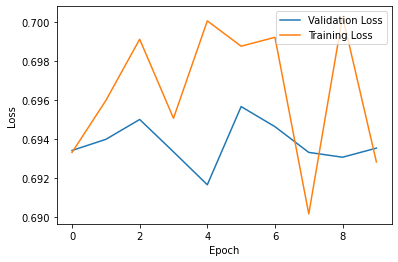

In [ ]:
mytrainStep1(modelEmb,criterion1,criterion2)

BERT + CNN min avg loss 0.59 <br>
6 epochs <br>
num_filters = [16,16,16] <br>
filter_sizes=[3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.2 <br>
FC output = 2 <br>
bert layer = 5 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.51 <br>
6 epochs <br>
num_filters = [16,16,16] <br>
filter_sizes=[3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.51 <br>
6 epochs <br>
num_filters = [16,16,16] <br>
filter_sizes=[3,4,5] <br>
lr = 2e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.54 <br>
6 epochs <br>
num_filters = [16,16,16] <br>
filter_sizes=[3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.6 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.54 <br>
6 epochs <br>
num_filters = [16,16,16] <br>
filter_sizes=[3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.3 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.54 <br>
6 epochs <br>
num_filters = [16,16,16] <br>
filter_sizes=[3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
relu <br>

====================================

BERT + CNN min avg loss 0.54 <br>
6 epochs <br>
num_filters = [16,16,16] <br>
filter_sizes=[3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.5 <br>
FC output = 16 <br>
relu <br>

====================================

BERT + CNN min avg loss 0.53 <br>
6 epochs <br>
num_filters = [16,16,16] <br>
filter_sizes=[3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.5 <br>
FC output = 4 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.53 <br>
6 epochs <br>
num_filters = [32,32,32] <br>
filter_sizes=[3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.54 <br>
6 epochs <br>
num_filters = [32,32,32] <br>
filter_sizes=[3,4,5] <br>
lr = 2e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.53 <br>
6 epochs <br>
num_filters = [16,32,64] <br>
filter_sizes=[3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.52 <br>
6 epochs <br>
num_filters = [16,16,16,16] <br>
filter_sizes=[2,3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.53 <br>
6 epochs <br>
num_filters = [16] <br>
filter_sizes=[7] <br>
lr = 1e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.66 <br>
6 epochs <br>
num_filters = [2,2,2,2] <br>
filter_sizes=[2,3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.53 <br>
6 epochs <br>
num_filters = [100,100,100] <br>
filter_sizes=[3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.54 <br>
6 epochs <br>
num_filters = [400] <br>
filter_sizes=[7] <br>
lr = 1e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.52 <br>
6 epochs <br>
num_filters = [400,400,400] <br>
filter_sizes=[3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.53 <br>
6 epochs <br>
num_filters = [400,400,400] <br>
filter_sizes=[3,4,5] <br>
lr = 2e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.52 <br>
6 epochs <br>
num_filters = [600,600,600] <br>
filter_sizes=[3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
tanh <br>

====================================

BERT + CNN min avg loss 0.51 <br>
6 epochs <br>
num_filters = [200,200,200] <br>
filter_sizes=[3,4,5] <br>
lr = 1e-5 <br>
dropout = 0.5 <br>
FC output = 2 <br>
tanh <br>

In [ ]:
class myModelFC(nn.Module):
  def __init__(self):
      super(myModelFC, self).__init__()
      inputFeatures = 48 #32
      self.FC = nn.Sequential(
        # nn.ReLU(),
        # nn.Tanh(),
        # nn.Dropout(0.5),  
        nn.Linear(in_features = inputFeatures*2,out_features = 2),
        # nn.Tanh(),
        # nn.ReLU(),
        # nn.Dropout(0.2), #0.5
        # nn.Linear(in_features = 512,out_features = 64),
        # nn.Linear(in_features = 64,out_features = 2),
      
      )


  def forward(self, input1, input2):
      concatenated = torch.cat((input1,input1),dim=1)
      
      out = self.FC(concatenated)
      # print(out)
      return out

In [ ]:
def mytrainStep2(model,criterion1,criterion2,embModel):
      # loss = nn.CosineEmbeddingLoss()
      embModel.bertModel.eval()
      embModel.eval()
      for param in embModel.bertModel.parameters():
          param.requires_grad = False
      for param2 in embModel.parameters():
          param2.requires_grad = False    

      if torch.cuda.is_available():
         model.to(device)
      
      
      # embModel.bias.requires_grad = False
      # loss = nn.CrossEntropyLoss()
        # PyTorch scheduler
      optimizer2 = torch.optim.Adam(model.parameters(),
                                    lr=0.00001
                                    )
      # scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=3*len(train_dataloader))
      # Set the seed value all over the place to make this reproducible.
      seed_val = 42

      random.seed(seed_val)
      np.random.seed(seed_val)
      torch.manual_seed(seed_val)
      torch.cuda.manual_seed_all(seed_val)

      # We'll store a number of quantities such as training and validation loss, 
      # validation accuracy, and timings.
      training_stats = []

      # Measure the total training time for the whole run.
      total_t0 = time.time()

      # For each epoch...
      listOflossesTrain2 = list()
      listOfF1Train = list()
      listOflossesValid2 = list()
      listOfF1Valid = list()
      totalf1 = 0
      epoch_stop = 0
      for epoch_i in range(0, 20):

          print("")
          print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs))
          print('Training...')

          # Measure how long the training epoch takes.
          t0 = time.time()

          # Reset the total loss for this epoch.
          total_train_loss2 = 0

          model.train()

          # For each batch of training data...
          step = 0
          totalf1 = 0
          for (input1,mask1,input2,mask2,target1) in train_dataloader:
              step +=1
              # if step ==171 :
              #   break
              # # Progress update every 40 batches.
              if step % 100 == 0 and not step == 0:
                  # Calculate elapsed time in minutes.
                  elapsed = format_time(time.time() - t0)
                  # Report progress.
                  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

              if torch.cuda.is_available():
                  b_input_ids1 = input1.to(device)
                  b_input_mask1 = mask1.to(device)
                  target1 = target1.type(torch.LongTensor)
                  b_labels = target1.to(device)
                 
                  # b_labels = torch.squeeze(b_labels,1)
                  b_input_ids2 = input2.to(device)
                  b_input_mask2 = mask2.to(device)
              
              model.zero_grad()  

              # with embModel.parameters() == False:
              # for p in embModel.parameters():
              #     p.requires_grad = False            
              #output11, output22,FC11,FC22,avg1,avg2,concatenated,concatenatedfc,_ = embModel(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2) 
              FC11,FC22,_ = embModel(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2,b_labels)
              out = model(FC11,FC22)
             
              loss = criterion2(out,b_labels)

              total_train_loss2 += loss.item()
              f1 = calcF1score(out,b_labels)
              totalf1+=f1
              print("========== Epoch "+str(epoch_i)+ " Batch "+str(step)+"==== Step 2 Train Loss "+str(loss.item()),"====== ",str(f1))

              loss.backward()

              optimizer2.step()
              # scheduler.step()
              
          avg_train_loss2 = total_train_loss2 /len(train_dataloader)
          avg_f1_train = totalf1/len(train_dataloader)
          print("========== Epoch "+str(epoch_i)+ " ==== Step 2 Train Loss "+str(avg_train_loss2),"====== ",str(avg_f1_train))            
          listOflossesTrain2.append(avg_train_loss2)
          training_time = format_time(time.time() - t0)

          print("")
          # print("  Average training loss: {0:.2f}".format(avg_train_loss2))
          print("  Training epoch took: {:}".format(training_time))
          
          # print("  Accuracy: {0:.2f}".format(avg_train_accuracy))

          # Calculate the average loss over all of the batches.avg_val_accuracy, avg_val_f1,
          avg_val_loss2,avg_f1_val = validation(embModel,epoch_i,criterion1,validation_dataloader,model,criterion2)
          listOflossesValid2.append(avg_val_loss2)
          # listOfF1Valid.append(avg_val_f1)
          # Measure how long the validation run took.
          validation_time = format_time(time.time() - t0)
        
          print("  Average Validation Loss: {0:.2f}".format(avg_val_loss2))
          print("  Validation avg-F1: {0:.2f}".format(avg_f1_val))
          # print("  Validation avg-Accuracy: {0:.2f}".format(avg_val_accuracy))
          print("  Validation took: {:}".format(validation_time))

          # Record all statistics from this epoch.
          training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss2,
                'Validation Loss': avg_val_loss2,
                # 'Valid. avg F1.': avg_val_f1,
                # 'Valid. avg Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
          )
          early_stopping2(avg_val_loss2, model)
          epoch_stop = epoch_i+1
          if early_stopping2.early_stop:
              print("Early stopping")
              
              break  

      print("")
      print("Training complete!")

      print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
      createPlot(listOflossesTrain2,listOflossesValid2,epoch_stop)

In [ ]:
modelEmb.load_state_dict(torch.load('checkpointEmb.pt'))

modelEmb.cuda()

myModelEmbeddings(
  (bertModel): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af


======== Epoch 1 / 2 ========
Training...
torch.Size([64, 48])
tensor([[-0.2617,  1.0294,  0.1573,  ...,  0.1007, -0.2208, -0.4087],
        [ 0.7404, -0.9041, -0.0749,  ...,  0.2106,  0.5767, -0.0246],
        [ 0.3998, -1.0484,  0.0884,  ...,  0.2143,  0.5157,  0.2009],
        ...,
        [-0.2617,  1.0294,  0.1573,  ...,  0.1007, -0.2208, -0.4087],
        [-1.0678,  1.1359,  0.3060,  ..., -0.0355, -0.2742, -0.4013],
        [-0.8356,  1.3510,  0.4815,  ...,  0.0966, -0.1293, -0.4623]],
       device='cuda:0')
tensor([ 0.8824, -0.7078, -0.5958,  0.5099,  0.7426,  0.9327,  0.9756,  0.8965,
         0.4512,  0.2548,  0.9880, -0.1023, -0.0247,  0.7827,  0.7596,  0.9902,
         0.9443, -0.3342,  0.9339,  0.2258, -0.7864,  0.9898,  0.9814,  0.9355,
         0.9501,  0.3618,  0.1924,  0.2143,  0.6467,  0.9807,  0.9636,  0.9700,
         0.9928, -0.5287,  0.4933,  0.7654,  0.3957,  0.8266, -0.0241,  0.9929,
         0.9683,  0.9498,  0.8210,  0.5905,  0.6544,  0.8754,  0.8436,  0.5896

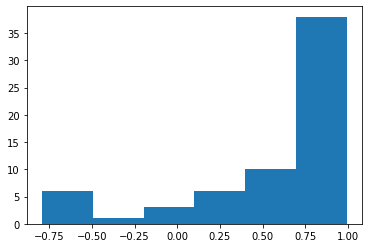

========== Epoch 0 Batch 1==== Step 2 Train Loss 0.7024617791175842 ======  0.4482758620689655
torch.Size([64, 48])
tensor([[-0.9991,  1.3487,  0.4281,  ...,  0.0453, -0.1767, -0.3482],
        [ 0.3175,  0.4783, -0.2652,  ...,  0.0937, -0.6684, -0.3663],
        [ 0.5658, -0.0485, -0.1112,  ..., -0.1453,  0.2649, -0.1790],
        ...,
        [-0.4139,  1.2744,  0.3755,  ...,  0.0124, -0.1431, -0.5804],
        [-0.0521,  1.0964,  0.1750,  ..., -0.0223, -0.0144, -0.4478],
        [-0.2312,  1.0967, -0.0069,  ..., -0.0793, -0.4564, -0.4430]],
       device='cuda:0')
tensor([ 0.9884, -0.3526,  0.8850,  0.0981,  0.9911, -0.3037, -0.6403,  0.9616,
         0.9612,  0.6784,  0.8714,  0.8726,  0.2121,  0.5259,  0.7800,  0.9676,
        -0.5451,  0.9762,  0.9914,  0.9600,  0.9799,  0.8944,  0.9478, -0.2611,
        -0.7046,  0.8983,  0.8668, -0.4004, -0.1577, -0.6809,  0.2511,  0.9143,
         0.8476,  0.9586,  0.8345,  0.9391,  0.9392, -0.1684,  0.9882,  0.7657,
         0.7141,  0.9935, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


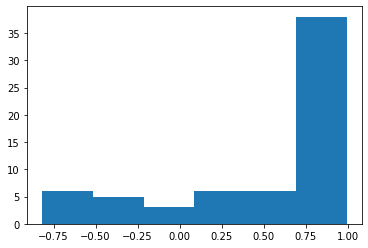

========== Epoch 0 Batch 2==== Step 2 Train Loss 0.7286109328269958 ======  0.40740740740740744
torch.Size([64, 48])
tensor([[-8.8904e-01,  1.2255e+00,  3.6094e-01,  ..., -8.9244e-02,
         -2.1415e-01, -6.9753e-01],
        [ 4.5173e-01,  2.0100e-01, -2.8778e-01,  ...,  3.6282e-01,
         -5.5715e-01, -1.7955e-01],
        [ 5.0823e-01, -4.5213e-01, -1.1456e-01,  ...,  1.8860e-01,
          5.3247e-01, -1.3404e-01],
        ...,
        [-9.9532e-01,  1.3825e+00,  5.2117e-01,  ...,  3.3899e-02,
         -1.5260e-01, -4.4832e-01],
        [ 4.6149e-01, -8.1123e-01,  9.6725e-02,  ...,  1.9848e-01,
          6.8729e-01, -1.2190e-03],
        [ 5.6440e-01, -1.1077e-02, -1.3260e-01,  ...,  1.2938e-01,
          2.3470e-01, -2.8810e-01]], device='cuda:0')
tensor([ 0.9682, -0.0592,  0.9184,  0.9907,  0.8519,  0.9547,  0.0799,  0.7889,
         0.2269,  0.9004,  0.9466, -0.7788, -0.3238,  0.9825,  0.9765,  0.9827,
         0.9881,  0.1603,  0.9647, -0.0624,  0.9851,  0.7596,  0.7961,  0.

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


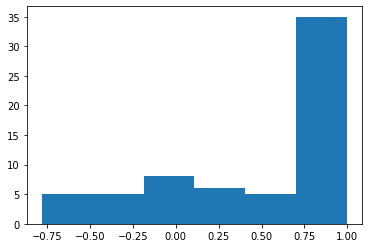

========== Epoch 0 Batch 3==== Step 2 Train Loss 0.7262365818023682 ======  0.4838709677419355
torch.Size([64, 48])
tensor([[-0.5240,  1.1403,  0.2868,  ..., -0.1296, -0.2523, -0.5639],
        [-1.0283,  1.1775,  0.3013,  ...,  0.0269, -0.1209, -0.5962],
        [-1.2911,  1.0738,  0.5832,  ..., -0.1055, -0.3588, -0.3891],
        ...,
        [-1.1540,  1.0509,  0.3702,  ...,  0.0580, -0.5099, -0.3729],
        [ 0.3833,  0.9066, -0.2889,  ...,  0.0269, -0.4725, -0.3010],
        [-1.3342,  1.0919,  0.5945,  ...,  0.0202, -0.5763, -0.2895]],
       device='cuda:0')
tensor([-3.8016e-01, -6.2478e-01,  9.9241e-01,  6.9294e-01, -1.9055e-01,
         9.4324e-01,  4.2186e-01, -7.0043e-01,  5.2703e-01,  9.8826e-01,
         9.9281e-01,  9.6146e-01,  9.0246e-01,  9.7466e-01,  8.4321e-01,
        -2.7813e-01,  9.6235e-01,  8.0970e-01, -6.0878e-01,  7.6960e-01,
         7.5424e-01,  9.9504e-01, -8.8607e-02,  9.7635e-01,  9.9034e-01,
         6.0270e-01, -4.3859e-02,  3.0404e-04, -7.9552e-01, -

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


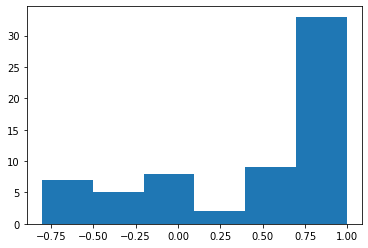

========== Epoch 0 Batch 4==== Step 2 Train Loss 0.7586920857429504 ======  0.35714285714285715
torch.Size([64, 48])
tensor([[ 0.5569,  0.2474, -0.4614,  ...,  0.1131, -0.8210, -0.1078],
        [ 0.6224, -0.5825,  0.0156,  ...,  0.1775,  0.7018, -0.1850],
        [-1.2283,  1.2088,  0.4402,  ...,  0.0137, -0.2309, -0.4243],
        ...,
        [ 0.9208, -0.3942, -0.2488,  ...,  0.1091,  0.4275, -0.0849],
        [-0.7144,  1.3005,  0.3446,  ..., -0.0782, -0.3563, -0.5837],
        [ 0.2653,  0.6336, -0.0046,  ...,  0.0809,  0.0868, -0.3045]],
       device='cuda:0')
tensor([-0.0509, -0.4193, -0.2609,  0.7409, -0.6932, -0.1281,  0.9619,  0.3355,
        -0.7511, -0.0181, -0.2005, -0.4786,  0.9494,  0.6154, -0.4154,  0.7183,
        -0.5320, -0.7516,  0.1683, -0.3492, -0.7251, -0.3656, -0.3578, -0.3106,
         0.9726,  0.9317,  0.9755,  0.7208, -0.3677,  0.9442, -0.3501,  0.0899,
         0.4312,  0.9521,  0.2533,  0.9955,  0.1129,  0.7773,  0.9635, -0.7184,
        -0.8790,  0.9918,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


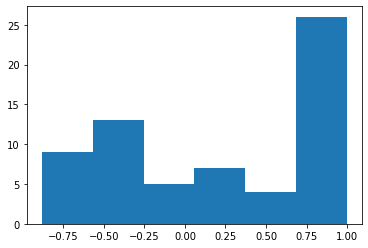

========== Epoch 0 Batch 5==== Step 2 Train Loss 0.6573202610015869 ======  0.5416666666666667
torch.Size([64, 48])
tensor([[ 0.7912,  0.2414, -0.0117,  ...,  0.0406,  0.3236, -0.0156],
        [ 0.6590, -0.2958,  0.0304,  ...,  0.1312,  0.6065, -0.3795],
        [ 0.3638,  0.4704, -0.1656,  ...,  0.1800, -0.3423, -0.1010],
        ...,
        [-1.2960,  1.0792,  0.5453,  ..., -0.0307, -0.3771, -0.4643],
        [-1.1660,  1.2503,  0.2727,  ..., -0.0540, -0.2665, -0.6168],
        [ 0.6150,  0.4884, -0.4694,  ...,  0.2197, -0.7162, -0.1866]],
       device='cuda:0')
tensor([ 0.2457, -0.3270,  0.2022,  0.8691,  0.9028,  0.2019, -0.4112, -0.2673,
         0.9103,  0.9162,  0.9166, -0.2262,  0.9864,  0.9799,  0.7744,  0.9913,
         0.0194,  0.9746,  0.4914,  0.9876,  0.9934,  0.9682,  0.9803,  0.9628,
         0.5572,  0.7461, -0.7638,  0.9928,  0.9440, -0.0478,  0.9149,  0.9523,
        -0.1474,  0.9026,  0.9068,  0.5677,  0.9660,  0.9500,  0.4078, -0.7308,
         0.9857,  0.8605, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


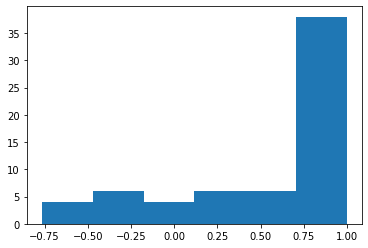

========== Epoch 0 Batch 6==== Step 2 Train Loss 0.7361865043640137 ======  0.4067796610169492
torch.Size([64, 48])
tensor([[-1.2986,  1.0662,  0.3883,  ...,  0.1176, -0.5177, -0.2900],
        [-1.0031,  0.9289,  0.3501,  ..., -0.0564, -0.2396, -0.4708],
        [ 0.5862, -0.3358, -0.0459,  ...,  0.0875,  0.7939, -0.3583],
        ...,
        [-0.6442,  1.1782,  0.2434,  ...,  0.0233, -0.4369, -0.5772],
        [ 0.5415, -0.4392, -0.0600,  ...,  0.0117,  0.4557, -0.0193],
        [-1.1503,  1.3181,  0.4642,  ...,  0.0609, -0.4010, -0.4159]],
       device='cuda:0')
tensor([ 0.5984,  0.9491,  0.8464,  0.4377, -0.7558,  0.5844,  0.9222,  0.9808,
         0.9900,  0.9326,  0.0637,  0.1521,  0.6325,  0.9720,  0.3571,  0.2766,
         0.7955,  0.8479,  0.9780,  0.9593,  0.2700, -0.1881,  0.9077,  0.9794,
         0.9416,  0.9440,  0.9576,  0.7691,  0.8496,  0.9193,  0.6871,  0.6148,
         0.9834,  0.4272, -0.0928, -0.7093,  0.9482, -0.5521,  0.8737, -0.1244,
         0.9875,  0.9695, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


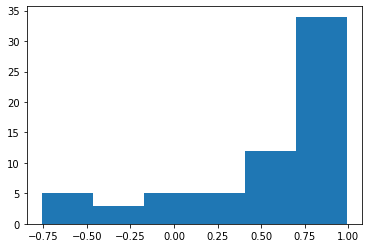

========== Epoch 0 Batch 7==== Step 2 Train Loss 0.6952616572380066 ======  0.4313725490196078
torch.Size([64, 48])
tensor([[-1.2688,  1.0855,  0.6017,  ..., -0.0183, -0.2832, -0.3602],
        [ 0.5898,  0.8838, -0.3752,  ...,  0.1571, -0.4498, -0.3748],
        [ 0.1742,  0.6754, -0.2077,  ...,  0.0399, -0.6339, -0.2681],
        ...,
        [-1.2087,  1.2789,  0.3959,  ..., -0.1254, -0.4096, -0.3585],
        [-0.4226,  0.9329,  0.0784,  ..., -0.0586, -0.2757, -0.6474],
        [-0.2660,  0.9232, -0.0969,  ..., -0.0990, -0.5275, -0.4730]],
       device='cuda:0')
tensor([ 0.9922,  0.8916,  0.7522, -0.3486,  0.8124,  0.0244,  0.8285,  0.9611,
         0.9312,  0.9554,  0.9704,  0.9853,  0.9890,  0.3165,  0.9612,  0.2379,
        -0.0718,  0.9793,  0.9905, -0.3481,  0.9199, -0.5424,  0.9901, -0.2936,
         0.9852, -0.6963,  0.3983, -0.1183,  0.9930,  0.1066,  0.9951,  0.6533,
        -0.5754,  0.5338,  0.9901,  0.9365,  0.9531, -0.6585,  0.9809,  0.9630,
        -0.3022, -0.5714, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


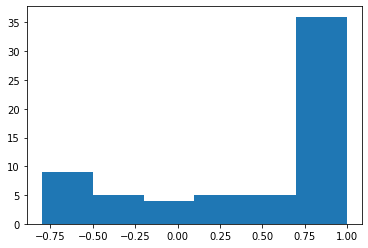

========== Epoch 0 Batch 8==== Step 2 Train Loss 0.7222496867179871 ======  0.21739130434782608
torch.Size([64, 48])
tensor([[ 0.0257,  1.1614, -0.1430,  ..., -0.0429, -0.4442, -0.5735],
        [ 0.5829, -0.0029,  0.0511,  ..., -0.1490,  0.6723, -0.2594],
        [ 0.5980,  0.8060, -0.0940,  ..., -0.0178, -0.1036, -0.3299],
        ...,
        [-0.7776,  1.3167,  0.3063,  ..., -0.0636, -0.4296, -0.3785],
        [-1.1692,  1.3348,  0.5814,  ...,  0.0220, -0.2940, -0.3555],
        [ 0.6437, -0.1672,  0.0330,  ..., -0.0622,  0.6299, -0.1721]],
       device='cuda:0')
tensor([-0.1357, -0.5072,  0.7621,  0.9921,  0.9222, -0.6143,  0.8303,  0.9439,
        -0.5874,  0.2819,  0.3355,  0.8358,  0.4233,  0.9469,  0.3853,  0.9666,
         0.9072,  0.8745, -0.4324, -0.2297, -0.7460,  0.9726,  0.1252, -0.0594,
         0.3824,  0.9936,  0.9932,  0.8811,  0.8132,  0.6275,  0.9919,  0.6982,
         0.7402,  0.9922,  0.8223,  0.7388,  0.9300,  0.9066, -0.6856, -0.2648,
         0.3591, -0.4001,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


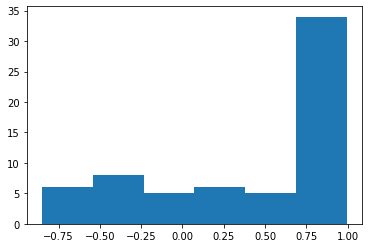

========== Epoch 0 Batch 9==== Step 2 Train Loss 0.6818116903305054 ======  0.5106382978723405
torch.Size([64, 48])
tensor([[-1.2710e+00,  1.0923e+00,  4.3920e-01,  ...,  1.1882e-02,
         -5.5370e-01, -3.8831e-01],
        [-7.9786e-01,  1.0310e+00,  2.9281e-01,  ..., -1.0729e-01,
         -2.5838e-01, -4.4771e-01],
        [ 6.9066e-01, -7.1530e-01,  2.1379e-02,  ...,  2.1377e-01,
          5.4684e-01, -1.1332e-01],
        ...,
        [-1.1165e+00,  1.0646e+00,  5.7593e-01,  ...,  4.9428e-04,
         -2.0331e-01, -3.4027e-01],
        [-7.1816e-01,  1.0253e+00,  3.3431e-01,  ..., -1.5712e-01,
          1.0382e-02, -6.8870e-01],
        [-1.2373e+00,  1.0514e+00,  4.5474e-01,  ...,  6.3037e-02,
         -3.4974e-01, -5.3496e-01]], device='cuda:0')
tensor([ 0.9939,  0.3837,  0.9829,  0.9615,  0.8308, -0.4914,  0.9918,  0.9540,
        -0.4331,  0.9907,  0.9912,  0.9893,  0.9894,  0.9814,  0.9744, -0.3899,
         0.6913,  0.9930,  0.0873,  0.8845, -0.2103,  0.9883,  0.9916,  0.8

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


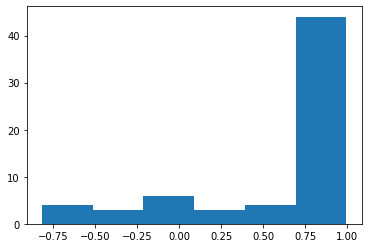

========== Epoch 0 Batch 10==== Step 2 Train Loss 0.740455150604248 ======  0.44067796610169485
torch.Size([64, 48])
tensor([[-1.5155,  1.0566,  0.6494,  ...,  0.0953, -0.3893, -0.4249],
        [-0.9794,  1.1208,  0.3896,  ...,  0.2332, -0.3649, -0.4267],
        [-1.2618,  0.9934,  0.5118,  ...,  0.0750, -0.2198, -0.4760],
        ...,
        [-0.5596,  1.2857,  0.2469,  ...,  0.0497, -0.4647, -0.4925],
        [ 0.5304, -0.5254,  0.0628,  ...,  0.1543,  0.7044, -0.1635],
        [-0.3616,  1.0822, -0.0092,  ...,  0.0136, -0.7408, -0.4458]],
       device='cuda:0')
tensor([ 0.9899,  0.9727,  0.9860,  0.2334,  0.9117,  0.7725,  0.7281, -0.7197,
        -0.3968,  0.8909,  0.9873, -0.2714, -0.8043, -0.1304,  0.3032,  0.9868,
         0.9872,  0.9516,  0.3321, -0.2169,  0.0662,  0.0166,  0.5674,  0.9930,
         0.9774,  0.9862,  0.9568,  0.9901,  0.9914,  0.8732,  0.8408, -0.0830,
         0.6536,  0.9462,  0.9026,  0.4086,  0.8784,  0.9856,  0.2423,  0.4399,
        -0.3736,  0.7842,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


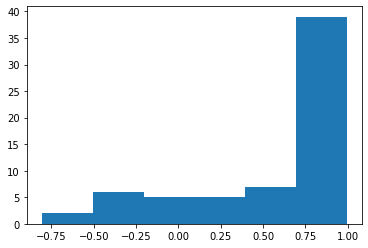

========== Epoch 0 Batch 11==== Step 2 Train Loss 0.7518513202667236 ======  0.35087719298245607
torch.Size([64, 48])
tensor([[-4.6859e-01,  8.4208e-01,  1.8003e-01,  ..., -1.6802e-01,
          3.0917e-01, -6.8794e-01],
        [-1.1165e+00,  1.0646e+00,  5.7593e-01,  ...,  4.9428e-04,
         -2.0331e-01, -3.4027e-01],
        [-1.5466e+00,  1.0789e+00,  6.0078e-01,  ...,  5.2502e-02,
         -6.7530e-01, -3.0805e-01],
        ...,
        [ 3.6508e-01, -8.3677e-01, -2.2780e-02,  ...,  1.8117e-01,
          3.4452e-01,  1.3451e-01],
        [-1.2760e+00,  1.1292e+00,  6.2194e-01,  ..., -7.6299e-02,
         -3.2565e-01, -4.3216e-01],
        [-1.2911e+00,  1.0738e+00,  5.8322e-01,  ..., -1.0555e-01,
         -3.5878e-01, -3.8912e-01]], device='cuda:0')
tensor([-0.2251, -0.2220,  0.9144,  0.4416,  0.9828,  0.6853, -0.2952,  0.8691,
         0.9675,  0.9807,  0.4725, -0.2928,  0.3412,  0.9903,  0.9928,  0.7727,
        -0.7050,  0.8466,  0.5834,  0.9869,  0.9381,  0.8717,  0.9866,  0

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


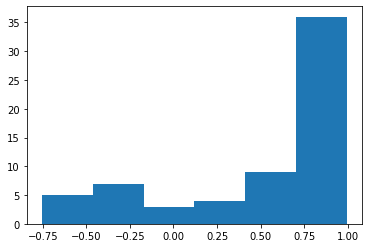

========== Epoch 0 Batch 12==== Step 2 Train Loss 0.6804673671722412 ======  0.391304347826087
torch.Size([64, 48])
tensor([[-1.3627,  1.0719,  0.5094,  ...,  0.0520, -0.6434, -0.2880],
        [ 0.0209,  1.0102, -0.1147,  ..., -0.0147, -0.4269, -0.3338],
        [ 0.4420, -0.5949,  0.0961,  ...,  0.0957,  0.6955, -0.0704],
        ...,
        [ 0.7064,  0.1182, -0.3985,  ...,  0.2611, -0.6184, -0.1245],
        [ 0.4423,  0.5765, -0.4362,  ...,  0.0632, -0.7167, -0.2471],
        [-0.0198,  0.8874, -0.1421,  ...,  0.1852, -0.2916, -0.4161]],
       device='cuda:0')
tensor([ 0.9963, -0.4221,  0.9740, -0.3069,  0.9155,  0.5089,  0.9692,  0.9470,
         0.9889, -0.0187, -0.1752, -0.3901,  0.5547, -0.7357,  0.9902,  0.9866,
         0.9948,  0.7298, -0.1337,  0.9631,  0.3144,  0.9567,  0.9823,  0.0357,
        -0.3721,  0.3469,  0.9932,  0.6498,  0.3999,  0.9448, -0.2838,  0.8209,
         0.3434,  0.2532,  0.4032, -0.1829,  0.9626,  0.1727, -0.7382, -0.3693,
         0.9776,  0.9865, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


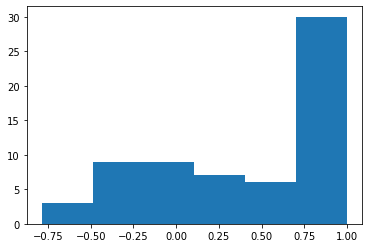

========== Epoch 0 Batch 13==== Step 2 Train Loss 0.7089555859565735 ======  0.3673469387755102
torch.Size([64, 48])
tensor([[ 0.5544,  0.1826, -0.4099,  ...,  0.2853, -0.6645,  0.0094],
        [-0.8989,  1.3933,  0.4126,  ...,  0.0661, -0.3699, -0.3615],
        [-1.2689,  1.2059,  0.5439,  ..., -0.0313, -0.6080, -0.3506],
        ...,
        [ 0.8068, -0.1543, -0.3726,  ...,  0.1219, -0.2660, -0.0454],
        [-1.3364,  1.1315,  0.5472,  ...,  0.0434, -0.6048, -0.3285],
        [-1.0123,  1.2382,  0.3965,  ..., -0.0490, -0.3938, -0.3546]],
       device='cuda:0')
tensor([ 0.7835,  0.6335,  0.9911,  0.7711,  0.6788,  0.7971,  0.5576, -0.8074,
         0.3514,  0.3978,  0.9912,  0.8311,  0.9637,  0.9781,  0.9681,  0.8633,
        -0.1444, -0.0607,  0.7605, -0.3822,  0.9805, -0.7196,  0.9711,  0.9391,
         0.8761,  0.6348,  0.3773,  0.9883, -0.3889,  0.9796, -0.7491,  0.5416,
         0.9744, -0.2276,  0.9626,  0.9325, -0.6240,  0.1652,  0.5615,  0.8165,
        -0.7379,  0.4167,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


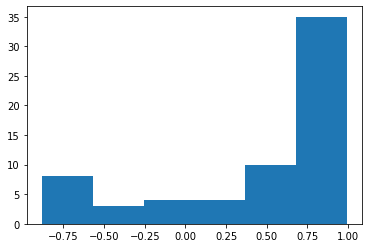

========== Epoch 0 Batch 14==== Step 2 Train Loss 0.656638503074646 ======  0.4745762711864407
torch.Size([64, 48])
tensor([[-1.3462,  1.1147,  0.5766,  ..., -0.0501, -0.2399, -0.4743],
        [ 0.6329,  0.5249, -0.5279,  ...,  0.1956, -0.5113, -0.1256],
        [ 0.4765,  0.0325, -0.4026,  ...,  0.2945, -0.6460, -0.1506],
        ...,
        [ 0.5694,  0.6209, -0.1958,  ...,  0.0625,  0.0063, -0.4595],
        [-0.8030,  0.9445,  0.3620,  ..., -0.0834, -0.2357, -0.3524],
        [-1.4772,  1.0713,  0.5109,  ...,  0.0568, -0.6489, -0.3798]],
       device='cuda:0')
tensor([ 0.9915, -0.2073,  0.9472,  0.7927,  0.9786,  0.9879,  0.9317,  0.9395,
         0.9845,  0.0919,  0.9658,  0.3321,  0.8534,  0.8886,  0.9453,  0.8471,
         0.8398,  0.7848, -0.2502,  0.8104,  0.9868, -0.2075,  0.9894,  0.9561,
         0.9606,  0.9903, -0.0187,  0.2742,  0.9508,  0.9921,  0.8049, -0.7107,
        -0.5415,  0.9243,  0.6815,  0.8013,  0.9550,  0.2778,  0.9883,  0.9838,
         0.8183, -0.0814, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


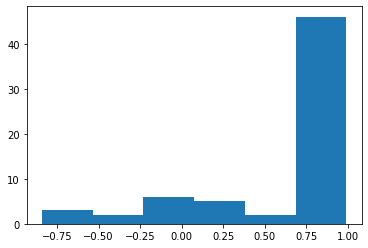

========== Epoch 0 Batch 15==== Step 2 Train Loss 0.7349309325218201 ======  0.43636363636363634
torch.Size([64, 48])
tensor([[ 0.5840, -0.5251,  0.0705,  ...,  0.0889,  0.6569, -0.1970],
        [-0.1240,  1.1540,  0.3027,  ..., -0.0436,  0.0227, -0.6169],
        [ 0.4848, -0.0429, -0.4726,  ...,  0.1856, -0.8957,  0.0595],
        ...,
        [-1.0156,  1.2767,  0.3918,  ..., -0.0145, -0.2219, -0.4080],
        [ 0.0997,  0.9889, -0.0663,  ..., -0.0116, -0.2888, -0.1708],
        [ 0.9516, -0.1719, -0.4969,  ...,  0.0532, -0.1281,  0.0665]],
       device='cuda:0')
tensor([ 0.9821,  0.8419,  0.1839,  0.9687,  0.9401,  0.9876,  0.5541,  0.7386,
         0.8904,  0.9941,  0.6447, -0.5966, -0.1895,  0.9858,  0.9935,  0.5776,
        -0.0597,  0.9922,  0.9884, -0.3857,  0.9779,  0.3443,  0.8372,  0.8976,
         0.8998,  0.9675, -0.7655,  0.9353,  0.9309, -0.8494, -0.5055, -0.7722,
         0.9814,  0.4401,  0.9102,  0.8300, -0.2205,  0.9850,  0.4489,  0.9804,
         0.9507,  0.7238

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


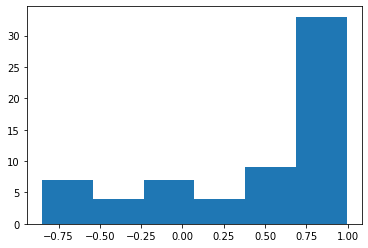

========== Epoch 0 Batch 16==== Step 2 Train Loss 0.7606855034828186 ======  0.2692307692307692
torch.Size([64, 48])
tensor([[ 0.3684,  0.4131,  0.1742,  ...,  0.1391,  0.3064, -0.4075],
        [-1.4876,  1.0979,  0.5174,  ...,  0.0869, -0.6326, -0.4616],
        [ 0.5794, -0.4463,  0.1689,  ...,  0.0571,  0.6394, -0.0601],
        ...,
        [-1.3962,  1.1124,  0.5396,  ...,  0.1115, -0.6507, -0.3063],
        [-1.1925,  1.0694,  0.5852,  ...,  0.0109, -0.2746, -0.4163],
        [ 0.0094,  0.0777, -0.0512,  ...,  0.2431, -0.4782, -0.2792]],
       device='cuda:0')
tensor([ 0.2853,  0.9876, -0.3121,  0.7134,  0.8628,  0.3320,  0.8797,  0.9188,
         0.9074,  0.5576,  0.7958, -0.0611,  0.9295, -0.1942,  0.9297,  0.7548,
         0.9013, -0.6730,  0.9002,  0.1873,  0.9667,  0.5593,  0.9881,  0.9864,
         0.4876,  0.9857,  0.7460, -0.3467, -0.1266,  0.6955, -0.7777,  0.9668,
         0.9918,  0.9907,  0.9865, -0.8183, -0.5061, -0.5705, -0.3301,  0.1663,
         0.9666,  0.8883,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


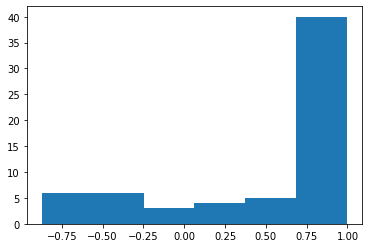

========== Epoch 0 Batch 17==== Step 2 Train Loss 0.7175687551498413 ======  0.4642857142857143
torch.Size([64, 48])
tensor([[-1.3356,  1.0630,  0.6518,  ...,  0.0380, -0.3062, -0.3769],
        [-1.2960,  1.0792,  0.5453,  ..., -0.0307, -0.3771, -0.4643],
        [-0.5950,  1.0603, -0.0045,  ..., -0.2072, -0.0055, -0.6379],
        ...,
        [-1.0829,  1.1355,  0.4428,  ...,  0.0443, -0.5413, -0.3498],
        [-1.2607,  1.1923,  0.5572,  ..., -0.0862, -0.2458, -0.4959],
        [-0.1117,  1.0713, -0.0091,  ..., -0.0382, -0.5868, -0.3688]],
       device='cuda:0')
tensor([-0.5140,  0.9620, -0.1218, -0.8378, -0.2001,  0.9694,  0.9851,  0.9896,
         0.6694,  0.9880,  0.9877,  0.1667,  0.9948,  0.2998, -0.6817, -0.0551,
        -0.6139,  0.9890,  0.9504,  0.6679, -0.1419,  0.9937,  0.9248,  0.9340,
         0.8327,  0.3410, -0.4011, -0.8031,  0.7132,  0.9592,  0.7837,  0.9773,
         0.5535,  0.9868, -0.3311, -0.7137, -0.5690,  0.0582,  0.9158,  0.8872,
         0.8055,  0.2729,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


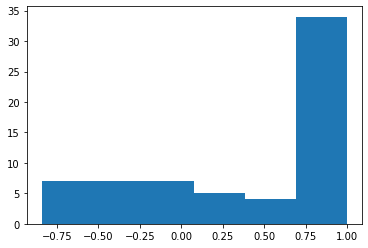

========== Epoch 0 Batch 18==== Step 2 Train Loss 0.7053250670433044 ======  0.47058823529411764
torch.Size([64, 48])
tensor([[-1.2788,  1.0906,  0.5091,  ..., -0.0722, -0.2141, -0.4788],
        [-0.5215,  1.0631, -0.0059,  ..., -0.0762, -0.4281, -0.4321],
        [-0.2249,  0.9508, -0.1857,  ...,  0.0933, -0.5021, -0.6406],
        ...,
        [ 0.4073,  0.5618, -0.3719,  ...,  0.1893, -0.3844, -0.2963],
        [-1.5155,  1.0566,  0.6494,  ...,  0.0953, -0.3893, -0.4249],
        [ 0.5728, -0.7652,  0.0266,  ...,  0.0875,  0.4782,  0.0216]],
       device='cuda:0')
tensor([-0.6394, -0.7957,  0.8869, -0.6819,  0.9837,  0.1147, -0.7456,  0.8419,
        -0.2599,  0.1830,  0.9628, -0.1837,  0.9824,  0.6974,  0.9902,  0.4716,
         0.8875,  0.9924,  0.9247, -0.0111,  0.4470,  0.5070,  0.0606, -0.3091,
         0.2743,  0.9885, -0.6379,  0.3881, -0.0014,  0.9795,  0.7908, -0.3495,
         0.6980,  0.9401,  0.7087,  0.9774,  0.9918, -0.1325,  0.9101, -0.8013,
         0.9826,  0.2811

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


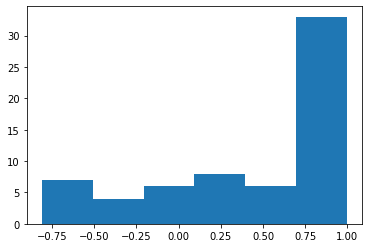

========== Epoch 0 Batch 19==== Step 2 Train Loss 0.7070392370223999 ======  0.5
torch.Size([64, 48])
tensor([[-1.3462,  1.1147,  0.5766,  ..., -0.0501, -0.2399, -0.4743],
        [-0.5308,  1.2628,  0.2311,  ...,  0.0910, -0.2654, -0.4449],
        [ 0.5651, -0.3555, -0.1069,  ...,  0.1122,  0.6507, -0.3559],
        ...,
        [ 0.5273, -0.7904,  0.0646,  ...,  0.0945,  0.5784,  0.1131],
        [-1.3200,  1.0510,  0.6014,  ...,  0.0297, -0.4826, -0.3896],
        [-0.4487,  0.9212, -0.0880,  ..., -0.2330, -0.5489, -0.4732]],
       device='cuda:0')
tensor([ 0.9823,  0.8766, -0.3346,  0.9784,  0.0642,  0.5471,  0.9877,  0.8062,
         0.9816, -0.1372,  0.8361,  0.9396,  0.5610,  0.9913,  0.9545,  0.8201,
         0.6630,  0.8645,  0.8497,  0.9714, -0.4987,  0.9044, -0.7054,  0.6667,
        -0.1804, -0.1026,  0.7697, -0.7384, -0.1532,  0.9371,  0.9946,  0.9120,
         0.5774,  0.3165,  0.8492,  0.9422,  0.9600,  0.7638, -0.2670,  0.7229,
         0.0283,  0.1904,  0.9846, -0.84

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


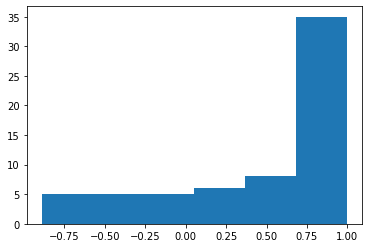

========== Epoch 0 Batch 20==== Step 2 Train Loss 0.7306628823280334 ======  0.41379310344827586
torch.Size([64, 48])
tensor([[-1.3567,  1.1212,  0.5071,  ...,  0.0908, -0.4530, -0.4381],
        [ 0.1445,  0.8534, -0.0934,  ..., -0.0512, -0.4518, -0.2236],
        [ 0.0997,  0.9889, -0.0663,  ..., -0.0116, -0.2888, -0.1708],
        ...,
        [-0.8639,  1.2702,  0.4311,  ..., -0.0020, -0.2367, -0.4605],
        [-1.1646,  1.1628,  0.4900,  ..., -0.0530, -0.1701, -0.4644],
        [-0.9794,  1.1208,  0.3896,  ...,  0.2332, -0.3649, -0.4267]],
       device='cuda:0')
tensor([-0.4646, -0.5684,  0.3069,  0.9857,  0.4588,  0.5155,  0.9825,  0.9885,
         0.2409,  0.9401,  0.6529,  0.9720,  0.2964,  0.0236,  0.1131,  0.7027,
         0.9878,  0.5294,  0.6961, -0.6964,  0.9901,  0.2169,  0.9794, -0.4962,
         0.0560,  0.9199,  0.5079, -0.3602,  0.9784, -0.4745,  0.9286,  0.5689,
        -0.0653,  0.3718,  0.9934,  0.0089, -0.1443, -0.2197,  0.9759,  0.8839,
         0.7884,  0.9842

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


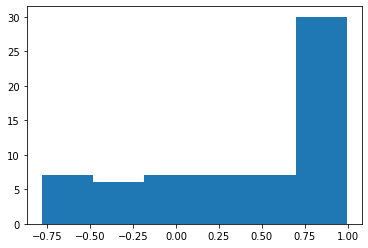

========== Epoch 0 Batch 21==== Step 2 Train Loss 0.7177225947380066 ======  0.41509433962264153
torch.Size([64, 48])
tensor([[ 0.4766,  0.5652, -0.4130,  ...,  0.2610, -0.6927, -0.4606],
        [ 0.1945,  0.7061, -0.2769,  ..., -0.0486, -0.4817, -0.3923],
        [-1.0002,  1.1573,  0.3372,  ..., -0.1511, -0.1675, -0.6355],
        ...,
        [-1.2630,  0.9828,  0.4450,  ...,  0.0366, -0.3558, -0.4377],
        [ 0.8080, -0.2619, -0.4361,  ...,  0.2211, -0.4679,  0.1823],
        [-1.2882,  1.1016,  0.5764,  ..., -0.0596, -0.4065, -0.4521]],
       device='cuda:0')
tensor([-3.0456e-01,  8.1597e-01,  9.7673e-01,  9.9060e-01, -1.7519e-01,
         9.8222e-01, -5.1163e-01, -7.1309e-01,  6.2714e-02, -7.7380e-01,
         9.7967e-01,  9.2121e-01,  3.9362e-01, -7.4667e-03,  9.2761e-01,
        -6.7524e-01, -4.9899e-01,  6.9285e-01, -7.9044e-01,  9.8346e-01,
         9.6354e-01,  1.0888e-01,  9.6533e-01, -4.7237e-01,  2.2617e-01,
         9.4240e-01, -2.4167e-04,  4.5558e-01, -4.4242e-01,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


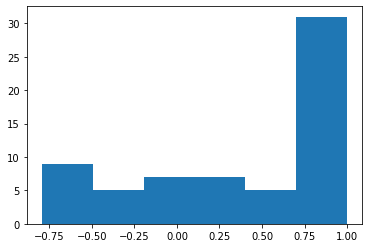

========== Epoch 0 Batch 22==== Step 2 Train Loss 0.7041245698928833 ======  0.4444444444444444
torch.Size([64, 48])
tensor([[-1.2786,  0.9488,  0.5772,  ..., -0.0457, -0.2610, -0.4052],
        [ 0.0228,  0.9145, -0.0177,  ..., -0.1188, -0.0558, -0.4685],
        [-1.2786,  0.9488,  0.5772,  ..., -0.0457, -0.2610, -0.4052],
        ...,
        [-1.4772,  1.0713,  0.5109,  ...,  0.0568, -0.6489, -0.3798],
        [-1.4107,  1.1037,  0.4881,  ...,  0.0159, -0.7426, -0.2042],
        [-0.6442,  1.1782,  0.2434,  ...,  0.0233, -0.4369, -0.5772]],
       device='cuda:0')
tensor([ 0.9545,  0.6686,  0.9927,  0.4458,  0.9716,  0.3868, -0.6500,  0.5280,
         0.9858,  0.9951,  0.4493,  0.6158,  0.6258,  0.8357,  0.9855,  0.9629,
         0.4982, -0.8031,  0.9944,  0.9317, -0.3725,  0.3719,  0.9605,  0.0273,
         0.8829,  0.9178,  0.9652,  0.4426,  0.8763,  0.9005, -0.0746,  0.8076,
        -0.3008,  0.9851,  0.7296,  0.9007,  0.0454,  0.6368,  0.1067,  0.9721,
         0.6361,  0.1329,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


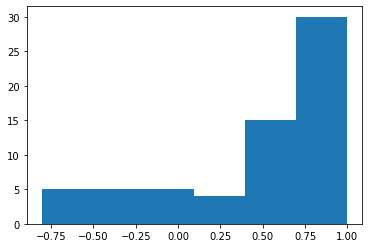

========== Epoch 0 Batch 23==== Step 2 Train Loss 0.6874130964279175 ======  0.4583333333333333
torch.Size([64, 48])
tensor([[-9.7601e-01,  1.3536e+00,  6.3612e-01,  ...,  6.8190e-03,
         -2.3077e-01, -3.8898e-01],
        [-1.2708e+00,  1.0498e+00,  3.9554e-01,  ..., -9.8638e-04,
         -6.9632e-01, -4.4897e-01],
        [-9.7765e-01,  1.3314e+00,  3.7630e-01,  ..., -1.1343e-01,
         -3.2506e-01, -4.5926e-01],
        ...,
        [ 6.5899e-01, -2.9577e-01,  3.0366e-02,  ...,  1.3116e-01,
          6.0647e-01, -3.7955e-01],
        [-3.4436e-01,  1.1132e+00,  9.6339e-02,  ..., -1.7127e-01,
         -2.2060e-01, -5.8124e-01],
        [ 5.4288e-01,  2.9889e-01, -1.8059e-03,  ..., -8.3883e-02,
          2.8741e-01, -3.3828e-01]], device='cuda:0')
tensor([ 0.3069,  0.9869,  0.7392,  0.9748,  0.9223,  0.2255,  0.4685,  0.9410,
         1.0000,  0.9058,  0.1860,  0.9590,  0.9877,  0.9892,  0.9876, -0.5120,
         0.8784,  0.9696,  0.9227,  0.9410,  0.9755, -0.0849, -0.2579, -0.

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


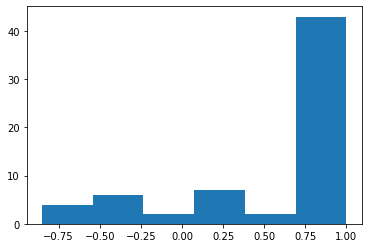

========== Epoch 0 Batch 24==== Step 2 Train Loss 0.7263009548187256 ======  0.3773584905660377
torch.Size([64, 48])
tensor([[-1.3104,  1.0613,  0.6367,  ..., -0.0392, -0.2553, -0.4147],
        [ 0.7873, -0.5681, -0.1221,  ...,  0.2029,  0.3178,  0.0037],
        [-0.8584,  1.0800,  0.1536,  ..., -0.0567, -0.2992, -0.5394],
        ...,
        [-0.8337,  1.1159,  0.1479,  ...,  0.0218, -0.1356, -0.4791],
        [-1.1813,  1.1511,  0.4591,  ...,  0.0195, -0.2204, -0.5355],
        [-0.2617,  1.0294,  0.1573,  ...,  0.1007, -0.2208, -0.4087]],
       device='cuda:0')
tensor([ 0.9918,  0.3206,  0.9683, -0.6688, -0.2082,  0.9141,  0.5314,  0.9952,
        -0.7632,  0.9955, -0.5000,  0.9418,  0.9828,  0.7782,  0.9420,  0.7140,
        -0.1906,  0.0138,  0.9716,  0.9947,  0.9222,  0.7719, -0.8509,  0.7097,
         0.8938,  0.9860, -0.5737,  0.5004, -0.3698,  0.9919,  0.4066,  0.9048,
        -0.6801,  0.9914, -0.0832,  0.9867,  0.5977,  0.6296,  0.9882,  0.9791,
        -0.6795, -0.7866,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


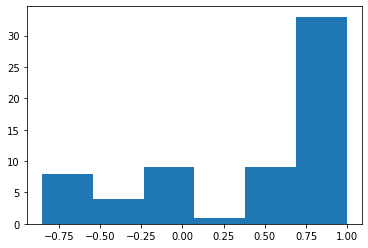

========== Epoch 0 Batch 25==== Step 2 Train Loss 0.7588914036750793 ======  0.3636363636363636
torch.Size([64, 48])
tensor([[-6.8197e-01,  9.8863e-01,  2.8513e-01,  ..., -7.5350e-02,
         -3.1892e-04, -6.9913e-01],
        [-8.3858e-01,  1.1379e+00,  2.8216e-01,  ..., -1.2843e-01,
         -2.1993e-01, -5.0951e-01],
        [-1.0635e+00,  1.0076e+00,  6.4998e-01,  ...,  5.7955e-02,
         -1.9653e-01, -4.0289e-01],
        ...,
        [-1.4876e+00,  1.0979e+00,  5.1740e-01,  ...,  8.6918e-02,
         -6.3262e-01, -4.6162e-01],
        [-1.2133e+00,  1.2402e+00,  5.2971e-01,  ..., -1.1618e-01,
         -1.5118e-01, -4.7657e-01],
        [ 4.9239e-01,  1.1442e-01, -4.6210e-01,  ...,  1.3173e-01,
         -8.5904e-01,  5.5259e-02]], device='cuda:0')
tensor([-0.1071,  0.9825,  0.9918,  0.7625,  0.9857, -0.5122,  0.9588, -0.3266,
         0.9498,  0.2409,  0.8614,  0.7748, -0.6924,  0.9829,  0.3757, -0.0928,
        -0.7225, -0.6505,  0.8310, -0.1061,  0.0559,  0.9944,  0.1239,  0.

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


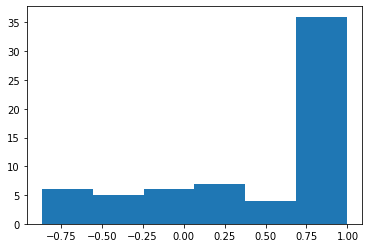

========== Epoch 0 Batch 26==== Step 2 Train Loss 0.6818059086799622 ======  0.4166666666666667
torch.Size([64, 48])
tensor([[-0.5526,  1.0429,  0.2054,  ..., -0.0217, -0.3591, -0.5348],
        [-1.2760,  1.1292,  0.6219,  ..., -0.0763, -0.3256, -0.4322],
        [-1.0414,  1.3739,  0.6016,  ...,  0.0296, -0.2668, -0.3415],
        ...,
        [-0.8919,  1.1891,  0.4681,  ...,  0.0017, -0.0401, -0.5482],
        [ 0.4131,  0.3238, -0.2471,  ...,  0.2179, -0.3592, -0.2757],
        [ 0.5304, -0.5254,  0.0628,  ...,  0.1543,  0.7044, -0.1635]],
       device='cuda:0')
tensor([ 0.1076, -0.0052,  0.9774, -0.8184,  0.9391,  0.9601,  0.4337,  0.9223,
         0.9395, -0.0870, -0.1443,  0.9821,  0.9226,  0.9962,  0.9905,  0.0905,
         0.8775,  0.9595, -0.6109,  0.2500,  0.9170,  0.6140, -0.0724,  0.9680,
        -0.7446,  0.0977,  0.9564, -0.7370,  0.9913,  0.9837,  0.9846,  0.9859,
         0.9812,  0.8906,  0.8795,  0.7150, -0.1470,  0.9917,  0.9550, -0.2916,
         0.7797,  0.4386,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


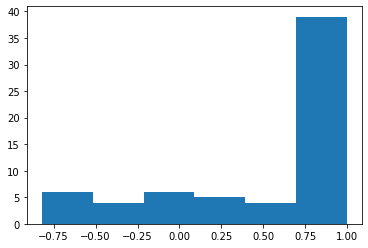

========== Epoch 0 Batch 27==== Step 2 Train Loss 0.744556725025177 ======  0.26666666666666666
torch.Size([64, 48])
tensor([[-0.9794,  1.1208,  0.3896,  ...,  0.2332, -0.3649, -0.4267],
        [ 0.7323, -0.4314,  0.0396,  ...,  0.1146,  0.7083, -0.0817],
        [-1.1499,  1.1676,  0.5367,  ..., -0.1130, -0.2179, -0.4193],
        ...,
        [-0.2035,  1.0347,  0.1565,  ..., -0.0972,  0.1179, -0.6036],
        [ 0.6043,  0.2412, -0.4276,  ...,  0.1543, -0.6282, -0.2268],
        [ 0.8068, -0.1543, -0.3726,  ...,  0.1219, -0.2660, -0.0454]],
       device='cuda:0')
tensor([-0.7333,  0.8296,  0.9836,  0.8594, -0.8616,  0.9915,  0.8367, -0.2831,
         0.9909,  0.8776,  0.9574,  0.9903, -0.5441, -0.2581, -0.7206,  0.8160,
         0.9755,  0.9539,  0.9652,  0.9855,  0.9916,  0.9425,  0.2249,  0.9958,
         0.9567,  0.9540, -0.0957,  0.8051, -0.1823,  0.9485,  0.9335, -0.1734,
         0.9658, -0.4344,  0.9951,  0.3755,  0.9776,  0.9095,  0.3756,  0.9862,
         0.9880,  0.9457,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


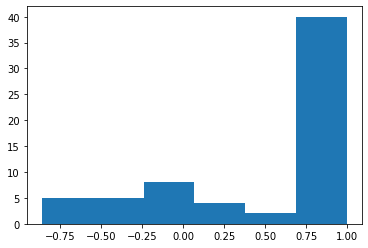

========== Epoch 0 Batch 28==== Step 2 Train Loss 0.7333834171295166 ======  0.3137254901960785


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


torch.Size([64, 48])
tensor([[ 0.5195, -0.6425,  0.0930,  ..., -0.0053,  0.5773,  0.0143],
        [-0.3584,  0.9323,  0.2754,  ...,  0.1028, -0.1456, -0.4018],
        [ 0.6314, -0.8390,  0.0364,  ...,  0.2888,  0.6167, -0.0752],
        ...,
        [ 0.7775,  0.2745, -0.4390,  ...,  0.3652, -0.7770, -0.2891],
        [-1.4386,  1.1709,  0.5305,  ...,  0.0776, -0.5551, -0.2930],
        [-1.3226,  1.0878,  0.5782,  ..., -0.0493, -0.2830, -0.4893]],
       device='cuda:0')
tensor([-0.6113,  0.1763,  0.9690,  0.4033,  0.5995,  0.9323,  0.9306,  0.9931,
         0.6010,  0.7906,  0.5129,  0.9895,  0.9912,  0.9066,  0.8787,  0.9386,
         0.8995,  0.9711, -0.5565,  0.9540,  0.8374,  0.8665,  0.8653,  0.8093,
         0.9166,  0.8809,  0.8657,  0.9923,  0.9807,  0.9621,  0.6714,  0.7296,
        -0.0726, -0.3594,  0.9825,  0.0854, -0.2192,  0.9856,  0.7475,  0.1700,
         0.8686,  0.2578,  0.3166,  0.7962,  0.9812,  0.9872, -0.2026,  0.9876,
         0.9539,  0.8215,  0.9809, -0.673

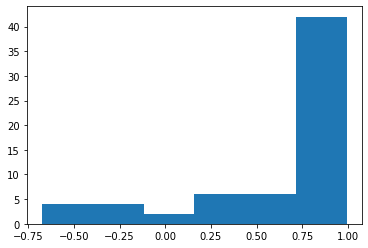

========== Epoch 0 Batch 29==== Step 2 Train Loss 0.7592346668243408 ======  0.24000000000000002
torch.Size([64, 48])
tensor([[ 0.2334,  1.0349,  0.1818,  ...,  0.0226,  0.3519, -0.5501],
        [ 0.1102,  1.0545,  0.1324,  ..., -0.0222, -0.1060, -0.4995],
        [-0.8209,  1.2372,  0.3226,  ..., -0.0980, -0.2596, -0.6085],
        ...,
        [ 0.3910,  0.3610, -0.2484,  ...,  0.2830, -0.5612, -0.3109],
        [ 0.6907, -0.7153,  0.0214,  ...,  0.2138,  0.5468, -0.1133],
        [ 0.5569,  0.2474, -0.4614,  ...,  0.1131, -0.8210, -0.1078]],
       device='cuda:0')
tensor([ 0.3670,  0.5297, -0.2435,  0.8148, -0.1489,  0.6432,  0.9189, -0.3440,
        -0.5687, -0.1441, -0.1415,  0.9812,  0.8215,  0.9649,  0.5487,  0.9783,
        -0.1264,  0.5792, -0.4552, -0.1871,  0.8933, -0.3894,  0.9537,  0.9506,
         0.6592,  0.5784, -0.3906,  0.0651,  0.6712,  0.9103,  0.9859,  0.9803,
         0.5950, -0.6402,  0.6968,  0.2546,  0.0254,  0.9280, -0.1212, -0.7019,
         0.9692,  0.9716

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


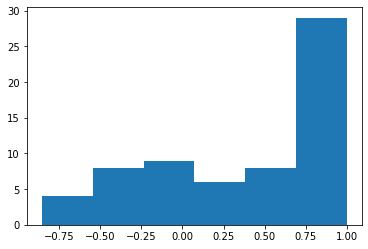

========== Epoch 0 Batch 30==== Step 2 Train Loss 0.6679248213768005 ======  0.40816326530612246
torch.Size([64, 48])
tensor([[ 4.2797e-01,  1.4269e-02,  5.6385e-02,  ..., -1.0010e-01,
          5.6009e-01, -4.0528e-01],
        [-3.3404e-01,  7.7429e-01,  2.7858e-01,  ..., -1.4572e-01,
          2.0112e-01, -6.8407e-01],
        [ 5.5828e-01, -2.9561e-01, -5.2195e-02,  ...,  2.3638e-01,
          2.2236e-01, -2.4535e-01],
        ...,
        [ 5.3074e-01,  5.9583e-01, -3.4955e-01,  ...,  1.9063e-01,
         -6.9459e-01, -2.3508e-01],
        [-1.3078e+00,  9.3616e-01,  5.6553e-01,  ..., -9.5568e-04,
         -3.3426e-01, -3.9002e-01],
        [-1.4824e+00,  1.0727e+00,  6.0131e-01,  ...,  2.5642e-02,
         -6.8301e-01, -4.1993e-01]], device='cuda:0')
tensor([ 0.9541,  0.7865,  0.7263,  0.0446,  0.0137,  0.7820,  0.4342,  0.9780,
         0.1823,  0.8649, -0.2297, -0.8077,  0.2294, -0.6415, -0.4475,  0.9098,
         0.9772,  0.2387,  0.9844,  0.9869,  0.9490,  0.9767,  0.0599, -0

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


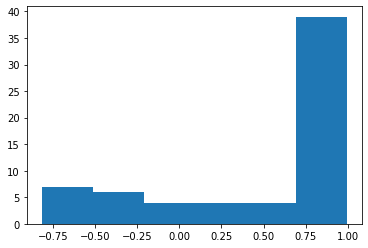

========== Epoch 0 Batch 31==== Step 2 Train Loss 0.7724631428718567 ======  0.3076923076923077
torch.Size([64, 48])
tensor([[-1.1857e+00,  1.2949e+00,  6.3564e-01,  ...,  1.3141e-02,
         -3.8132e-01, -3.2770e-01],
        [-1.1925e+00,  1.0694e+00,  5.8523e-01,  ...,  1.0899e-02,
         -2.7463e-01, -4.1628e-01],
        [ 2.5864e-01,  9.1326e-01,  6.2614e-02,  ..., -3.0893e-02,
         -5.8252e-02, -3.1970e-01],
        ...,
        [-1.3731e+00,  1.0866e+00,  5.0358e-01,  ...,  1.0678e-02,
         -6.2422e-01, -3.1449e-01],
        [-1.3078e+00,  9.3616e-01,  5.6553e-01,  ..., -9.5568e-04,
         -3.3426e-01, -3.9002e-01],
        [-1.0388e-02,  4.6811e-01,  6.7217e-02,  ..., -1.9371e-01,
          5.0538e-01, -6.5036e-01]], device='cuda:0')
tensor([ 0.9618,  0.9916,  0.4897,  0.9530,  0.8253,  0.8700,  0.7780,  0.7329,
        -0.5415,  0.2132,  0.1952,  0.9757,  0.7375,  0.9945,  0.9889,  0.8046,
         0.9872,  0.9589, -0.1796,  0.9499,  0.2026,  0.7777,  0.8220,  0.

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


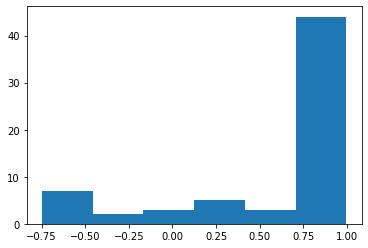

========== Epoch 0 Batch 32==== Step 2 Train Loss 0.7552103996276855 ======  0.3333333333333333
torch.Size([64, 48])
tensor([[-9.1474e-01,  1.3524e+00,  3.8300e-01,  ..., -6.8030e-02,
         -1.9902e-01, -5.2560e-01],
        [ 4.7274e-01, -1.4379e-01,  1.9012e-02,  ...,  9.4718e-04,
          6.3774e-01, -3.3736e-01],
        [ 5.9406e-01, -4.1089e-01,  4.6624e-02,  ...,  3.6400e-02,
          6.1483e-01, -9.6298e-02],
        ...,
        [ 3.8262e-01, -1.5463e-01, -3.9036e-01,  ...,  2.5116e-01,
         -9.7916e-01, -2.4113e-02],
        [ 4.4201e-01, -5.9489e-01,  9.6121e-02,  ...,  9.5700e-02,
          6.9554e-01, -7.0354e-02],
        [ 4.5483e-01,  4.2875e-01, -2.8329e-01,  ...,  2.8345e-01,
         -3.9228e-01, -2.3205e-01]], device='cuda:0')
tensor([-0.1830,  0.7997, -0.0505,  0.9622,  0.9852, -0.0889,  0.6732,  0.8814,
         0.9334,  0.8035,  0.5458, -0.5123,  0.9890,  0.0405,  0.6596,  0.9964,
         0.9808, -0.6564,  0.9284,  0.0559,  0.9806,  0.7981,  0.5213, -0.

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


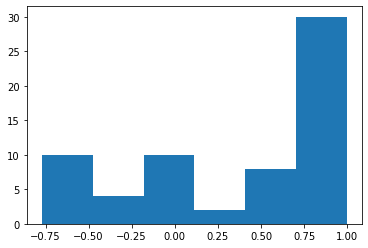

========== Epoch 0 Batch 33==== Step 2 Train Loss 0.7029683589935303 ======  0.4528301886792453
torch.Size([64, 48])
tensor([[ 0.2157,  0.1355, -0.0691,  ...,  0.2422, -0.2970, -0.3497],
        [ 0.6393, -0.6124,  0.0274,  ...,  0.1480,  0.6559, -0.0971],
        [ 0.5041,  0.2477, -0.3837,  ...,  0.1762, -0.4469, -0.2920],
        ...,
        [-0.7776,  1.3167,  0.3063,  ..., -0.0636, -0.4296, -0.3785],
        [ 0.4742,  0.1476, -0.5290,  ...,  0.2490, -0.9195, -0.1385],
        [-1.1658,  1.1070,  0.5041,  ...,  0.0690, -0.5541, -0.4117]],
       device='cuda:0')
tensor([ 0.1491,  0.8793,  0.9178,  0.9868,  0.9826,  0.4568,  0.9940,  0.8083,
        -0.8905,  0.8703,  0.6349,  0.9704,  0.8223,  0.6968,  0.5494,  0.7596,
         0.4598,  0.9820,  0.9907,  0.9915,  0.8174, -0.2383, -0.5186,  0.2107,
         0.8826,  0.9738,  0.7354,  0.2159, -0.6798, -0.7158, -0.0329,  0.9667,
         0.9589, -0.4197,  0.9668,  0.9543,  0.9681,  0.7165,  0.9926,  0.8615,
         0.9024, -0.1103,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


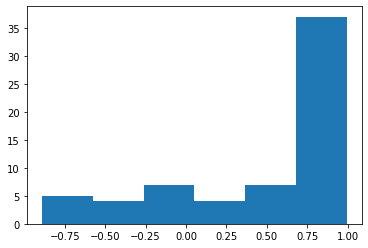

========== Epoch 0 Batch 34==== Step 2 Train Loss 0.7360268831253052 ======  0.3846153846153846
torch.Size([64, 48])
tensor([[-1.1646,  1.1628,  0.4900,  ..., -0.0530, -0.1701, -0.4644],
        [ 0.5098,  0.4887, -0.4310,  ...,  0.1977, -0.8386, -0.2799],
        [-1.3364,  1.1315,  0.5472,  ...,  0.0434, -0.6048, -0.3285],
        ...,
        [-0.8306,  1.0393,  0.3829,  ..., -0.0665,  0.0087, -0.5656],
        [ 0.5310,  0.0678, -0.4880,  ...,  0.3716, -0.5317, -0.3916],
        [-1.3364,  1.1315,  0.5472,  ...,  0.0434, -0.6048, -0.3285]],
       device='cuda:0')
tensor([ 0.8791, -0.0424,  0.5250,  0.1389,  0.9761,  0.4504,  0.5214,  0.9833,
        -0.8132,  0.6214,  0.6085,  0.8832,  0.0809,  0.7030,  0.8827, -0.5570,
         0.1469, -0.0313,  0.9412,  0.9919,  0.7300, -0.1081, -0.8704,  0.9001,
         0.7628,  0.9932,  0.9957, -0.3267,  0.8315, -0.2383,  0.9328, -0.5800,
         0.9882, -0.0541,  0.9904,  0.4553,  0.8924,  0.9541, -0.1756,  0.9744,
        -0.3725,  0.9844,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


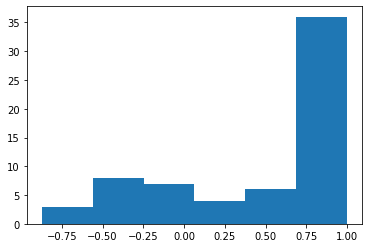

========== Epoch 0 Batch 35==== Step 2 Train Loss 0.7246994376182556 ======  0.30188679245283023
torch.Size([64, 48])
tensor([[ 0.4798,  0.2126, -0.4592,  ...,  0.2435, -0.5062, -0.2580],
        [-1.3104,  1.0687,  0.4741,  ..., -0.0561, -0.6286, -0.2293],
        [-1.4772,  1.0713,  0.5109,  ...,  0.0568, -0.6489, -0.3798],
        ...,
        [ 0.6035, -0.2898,  0.1126,  ...,  0.1062,  0.5783, -0.2909],
        [-0.0825,  1.1024,  0.0033,  ..., -0.0323, -0.4410, -0.3963],
        [-0.4319,  1.2429,  0.1302,  ..., -0.0160, -0.3629, -0.5111]],
       device='cuda:0')
tensor([-0.2424,  0.9945,  0.1297,  0.0112, -0.0421, -0.3342,  0.5511, -0.6132,
         0.7545,  0.9843,  0.9898, -0.0826, -0.1393,  0.7839,  0.7379,  0.9502,
         0.3653,  0.9850,  0.8187,  0.9825,  0.6563, -0.7566,  0.4255,  0.9615,
        -0.7136,  0.5227, -0.1798, -0.0036,  0.9354,  0.7628,  0.9748,  0.9104,
         0.9661,  0.0799,  0.2923,  0.3619,  0.8653,  0.3090, -0.5126,  0.9492,
         0.9255,  0.9711

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


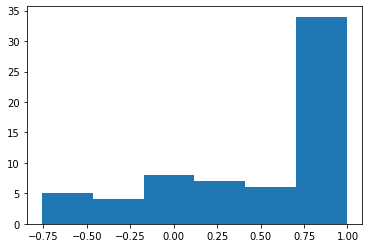

========== Epoch 0 Batch 36==== Step 2 Train Loss 0.6920762658119202 ======  0.42857142857142855
torch.Size([64, 48])
tensor([[-0.8242,  0.8144,  0.2183,  ..., -0.0336, -0.1667, -0.6377],
        [-1.4772,  1.0713,  0.5109,  ...,  0.0568, -0.6489, -0.3798],
        [ 0.9299,  0.0810, -0.2730,  ...,  0.2157, -0.0020, -0.1180],
        ...,
        [-1.5234,  1.0478,  0.6344,  ...,  0.0575, -0.6737, -0.2081],
        [-0.6043,  0.9728,  0.1522,  ...,  0.0780, -0.3033, -0.5098],
        [-0.3575,  0.9949,  0.0407,  ..., -0.1381, -0.5036, -0.3321]],
       device='cuda:0')
tensor([ 0.9541,  0.9887,  0.8368,  0.2572,  0.1930,  0.9276, -0.1669, -0.2184,
         0.9872, -0.6506,  0.2246,  0.8275,  0.8400,  0.9850,  0.2827,  0.7540,
         0.9153, -0.4101,  0.6467,  0.0439, -0.1367, -0.6508,  0.9764,  0.8774,
        -0.2397,  0.9869,  0.9881,  0.9561, -0.7841, -0.3869,  0.9889,  0.9836,
         0.5055,  0.9605,  0.8814,  0.8646,  0.7352,  0.9510,  0.9899,  0.7844,
        -0.6448,  0.8714

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


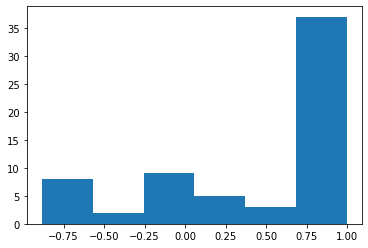

========== Epoch 0 Batch 37==== Step 2 Train Loss 0.7023418545722961 ======  0.4912280701754386
torch.Size([64, 48])
tensor([[-1.0906,  1.0925,  0.4708,  ...,  0.1214, -0.4169, -0.3713],
        [-0.9841,  1.1294,  0.2784,  ..., -0.1160, -0.2417, -0.6029],
        [-1.3567,  1.1212,  0.5071,  ...,  0.0908, -0.4530, -0.4381],
        ...,
        [ 0.1766,  0.9311, -0.0326,  ...,  0.1531, -0.5511, -0.3917],
        [-0.6706,  1.1306,  0.1335,  ..., -0.0167, -0.5591, -0.3684],
        [-0.8265,  1.1467,  0.2594,  ..., -0.1064, -0.2028, -0.5914]],
       device='cuda:0')
tensor([ 0.9695, -0.6142,  0.7803,  0.9650, -0.7798,  0.9897,  0.9723,  0.9793,
         0.9619,  0.3894,  0.9830,  0.8969, -0.1727,  0.1134, -0.7485,  0.9258,
         0.9891, -0.1648,  0.9700,  0.9355, -0.1577,  0.7631,  0.9951,  0.8198,
         0.8619,  0.9700,  0.9523,  0.9503,  0.9371,  0.9754, -0.1135,  0.8548,
         0.9766,  0.9717,  0.8124,  0.9847,  0.9607,  0.3587,  0.9891,  0.3084,
        -0.6409,  0.9858,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


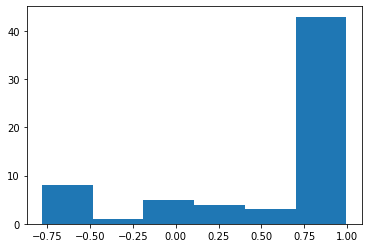

========== Epoch 0 Batch 38==== Step 2 Train Loss 0.7353240251541138 ======  0.3137254901960784
torch.Size([64, 48])
tensor([[-1.4305,  1.1246,  0.6082,  ...,  0.0213, -0.5281, -0.2977],
        [ 0.5694,  0.2653, -0.1678,  ..., -0.0353,  0.2107, -0.5137],
        [ 0.6239,  0.4491, -0.3787,  ...,  0.1498, -0.6670, -0.2056],
        ...,
        [ 0.4909, -0.3995, -0.3639,  ...,  0.4401, -0.7187,  0.0113],
        [ 0.7897, -0.4585, -0.3521,  ...,  0.1796, -0.3563,  0.1268],
        [-0.7278,  1.1143,  0.3110,  ...,  0.0565, -0.4296, -0.5378]],
       device='cuda:0')
tensor([ 0.4230,  0.5092, -0.1357,  0.9794,  0.9931,  0.5593,  0.1736,  0.9735,
        -0.0126,  0.7198, -0.5210,  0.7470,  0.9606,  0.9925,  0.9964,  0.6548,
         0.8058,  0.9578,  0.8746,  0.8915, -0.4806,  0.8926,  0.9809,  0.9773,
         0.9934, -0.1193,  0.9465,  0.9823, -0.2986, -0.1757, -0.3128, -0.7950,
        -0.2098,  0.7646,  0.9371,  0.9584,  0.9668, -0.6383,  0.9813, -0.3878,
        -0.1752,  0.6929,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


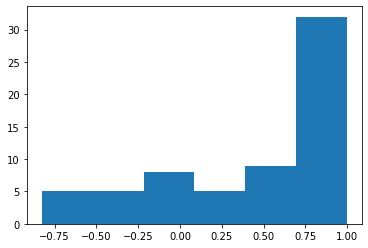

========== Epoch 0 Batch 39==== Step 2 Train Loss 0.7355985045433044 ======  0.2553191489361702
torch.Size([64, 48])
tensor([[-1.3731,  1.0866,  0.5036,  ...,  0.0107, -0.6242, -0.3145],
        [ 0.4568,  0.5208, -0.3628,  ...,  0.0662, -0.7030, -0.2066],
        [-1.2644,  1.0952,  0.5467,  ...,  0.0036, -0.1489, -0.5242],
        ...,
        [ 0.3782,  0.1249, -0.2557,  ...,  0.3521, -0.8663, -0.2478],
        [-1.2558,  1.1673,  0.3576,  ..., -0.0415, -0.4248, -0.5587],
        [-1.3462,  1.1147,  0.5766,  ..., -0.0501, -0.2399, -0.4743]],
       device='cuda:0')
tensor([-0.7819, -0.1413, -0.7339,  0.9899,  0.6122,  0.9060, -0.8250,  0.2278,
         0.9703,  0.9900,  0.9555,  0.9338,  0.1505, -0.8184,  0.6681,  0.8687,
         0.6562, -0.7379, -0.6564, -0.7793,  0.6186,  0.8754,  0.9335, -0.5068,
         0.8983,  0.9784,  0.9849,  0.9602,  0.1893,  0.0797,  0.9874,  0.2081,
         0.9441,  0.4573,  0.0846,  0.9349,  0.9524,  0.9192, -0.3112,  0.8890,
         0.9782,  0.9631,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


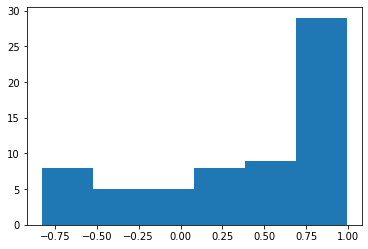

========== Epoch 0 Batch 40==== Step 2 Train Loss 0.6928179264068604 ======  0.2978723404255319
torch.Size([64, 48])
tensor([[-0.9727,  1.0120,  0.2522,  ..., -0.0505, -0.2880, -0.5602],
        [ 0.4232, -0.8927,  0.0313,  ...,  0.1150,  0.5829,  0.0558],
        [-0.6651,  1.1630,  0.2637,  ...,  0.1229, -0.3259, -0.4469],
        ...,
        [ 0.3782,  0.1249, -0.2557,  ...,  0.3521, -0.8663, -0.2478],
        [-1.3162,  1.0528,  0.7049,  ..., -0.0031, -0.3018, -0.3868],
        [-0.0272,  0.4727,  0.0856,  ...,  0.0871,  0.0867, -0.5415]],
       device='cuda:0')
tensor([ 0.9634,  0.0824,  0.8773,  0.7881,  0.8821,  0.3868,  0.9801,  0.9823,
         0.8584, -0.2252,  0.8505,  0.0988,  0.9894,  0.9875,  0.6588,  0.1915,
        -0.7053, -0.1040,  0.8327, -0.2080,  0.9617, -0.3658,  0.7857,  0.9850,
        -0.5969,  0.6672,  0.9193,  0.8988,  0.9871, -0.1501, -0.6917,  0.2864,
         0.4577,  0.9241,  0.9869,  0.3666,  0.9948,  0.6054,  0.9888,  0.9479,
         0.9222,  0.9880,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


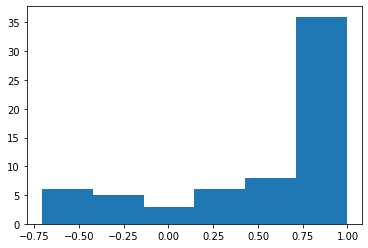

========== Epoch 0 Batch 41==== Step 2 Train Loss 0.7065871953964233 ======  0.36000000000000004
torch.Size([64, 48])
tensor([[-1.1857,  1.2949,  0.6356,  ...,  0.0131, -0.3813, -0.3277],
        [ 0.6835, -0.4718, -0.0862,  ...,  0.0549,  0.5785, -0.1074],
        [-1.3104,  1.0613,  0.6367,  ..., -0.0392, -0.2553, -0.4147],
        ...,
        [-1.0739,  1.0833,  0.5214,  ..., -0.0788, -0.2597, -0.4735],
        [-1.2911,  1.0738,  0.5832,  ..., -0.1055, -0.3588, -0.3891],
        [ 0.5821, -0.5007,  0.0814,  ...,  0.1920,  0.6956, -0.2509]],
       device='cuda:0')
tensor([ 0.9856,  0.9002,  0.9889, -0.5111,  0.9339,  0.9887,  0.2582,  0.9338,
         0.9758,  0.9819,  0.3522, -0.3852,  0.7641, -0.6746, -0.6576, -0.2939,
         0.8931,  0.7492,  0.6428, -0.4011,  0.6279,  0.9916,  0.3661, -0.2599,
         0.9701,  0.8124,  0.9354,  0.9905,  0.6329,  0.9759,  0.2081,  0.8857,
         0.7491,  0.6158,  0.9793, -0.6215,  0.2766, -0.4386,  0.9826,  0.6176,
        -0.0149,  0.9912

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


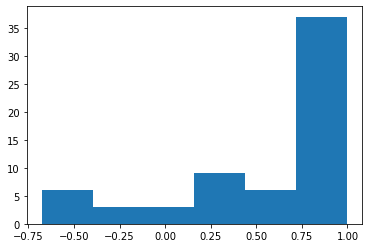

========== Epoch 0 Batch 42==== Step 2 Train Loss 0.8025758266448975 ======  0.14814814814814814
torch.Size([64, 48])
tensor([[ 0.6617, -0.7728, -0.0079,  ..., -0.0395,  0.4374,  0.1676],
        [-1.2804,  1.0736,  0.4059,  ...,  0.0111, -0.6980, -0.3929],
        [ 0.5887, -0.7102,  0.0697,  ...,  0.1691,  0.7192, -0.1345],
        ...,
        [-1.2749,  1.1009,  0.5427,  ..., -0.0261, -0.1424, -0.4852],
        [-1.3712,  1.0347,  0.5497,  ..., -0.0186, -0.2164, -0.4524],
        [ 0.2621,  0.8358, -0.1861,  ...,  0.0366, -0.5389, -0.2166]],
       device='cuda:0')
tensor([ 0.9469,  0.9919,  0.9783, -0.2319,  0.9823,  0.9788,  0.4233, -0.7804,
         0.0707,  0.9326, -0.6896, -0.3672, -0.1535, -0.2171,  0.7318,  0.9623,
         0.1389, -0.6999,  0.9953,  0.9937,  0.1701,  0.7526,  0.1655,  0.8789,
         0.9332,  0.9145,  0.9945,  0.9885,  0.9461,  0.9812,  0.5603,  0.5959,
         0.4911, -0.4904, -0.2590,  0.9917,  0.3297,  0.9700,  0.6529,  0.9936,
         0.7095,  0.9948

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


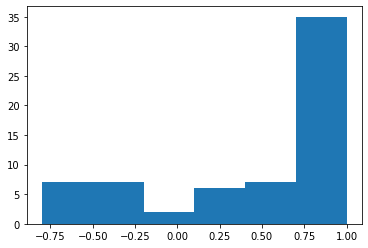

========== Epoch 0 Batch 43==== Step 2 Train Loss 0.7533140778541565 ======  0.2127659574468085
torch.Size([64, 48])
tensor([[-0.8860,  1.1328,  0.2878,  ..., -0.0463, -0.2738, -0.6006],
        [ 0.5209, -0.9021,  0.0292,  ...,  0.1750,  0.6252,  0.0852],
        [-0.9531,  1.3404,  0.3884,  ..., -0.0310, -0.1275, -0.5755],
        ...,
        [-0.7979,  1.0310,  0.2928,  ..., -0.1073, -0.2584, -0.4477],
        [-0.7817,  1.0717,  0.3966,  ..., -0.0083, -0.0664, -0.6679],
        [ 0.3818,  0.2530, -0.2665,  ...,  0.0493, -0.0393, -0.5041]],
       device='cuda:0')
tensor([ 0.9919,  0.9779,  0.8430,  0.9877,  0.9865,  0.6176,  0.0299,  0.9794,
         0.9758,  0.5933, -0.6132,  0.8338,  0.9949, -0.1443, -0.1553,  0.3462,
         0.2858, -0.0691,  0.9676,  0.9360,  0.6049,  0.8629, -0.1521,  0.8956,
         0.9824,  0.6934,  0.9741,  0.1139,  0.8820,  0.6955,  0.6069, -0.0940,
        -0.3436,  0.9954, -0.8644,  0.9145, -0.0905, -0.8792, -0.5034, -0.6203,
        -0.3999,  0.2881,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


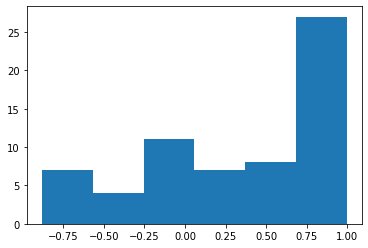

========== Epoch 0 Batch 44==== Step 2 Train Loss 0.690985918045044 ======  0.39999999999999997
torch.Size([64, 48])
tensor([[ 0.8575, -0.2708, -0.3633,  ...,  0.1699, -0.3490,  0.0358],
        [ 0.7364, -0.2269, -0.1143,  ...,  0.0178,  0.5294, -0.1515],
        [-1.2618,  0.9934,  0.5118,  ...,  0.0750, -0.2198, -0.4760],
        ...,
        [-1.2995,  1.0537,  0.6157,  ..., -0.0884, -0.3123, -0.4504],
        [-1.1386,  1.1936,  0.4138,  ...,  0.0390, -0.4786, -0.3436],
        [-1.3170,  1.0739,  0.5085,  ...,  0.0322, -0.6405, -0.3679]],
       device='cuda:0')
tensor([ 0.9492,  0.8122,  0.9870,  0.9810,  0.9423,  0.8223, -0.6237,  0.6980,
         0.8766,  0.6654,  0.7733,  0.9714,  0.8856,  0.8764,  0.9605, -0.3535,
         0.9897,  0.9910,  0.8579,  0.9612, -0.7558,  0.9323,  0.5782,  0.9853,
         0.8709, -0.6387,  0.2986,  0.2280,  0.9603,  0.9883, -0.1171,  0.9899,
         0.9839,  0.9880,  0.8474,  0.4812,  0.6325, -0.3879,  0.9606,  0.0842,
         0.9527,  0.9918,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


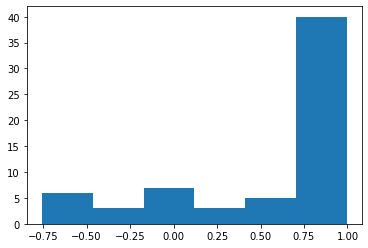

========== Epoch 0 Batch 45==== Step 2 Train Loss 0.7025796175003052 ======  0.4067796610169491
torch.Size([64, 48])
tensor([[-1.3582,  1.1746,  0.4468,  ..., -0.0675, -0.3501, -0.4429],
        [-1.4038,  1.0228,  0.5959,  ..., -0.0419, -0.2282, -0.3501],
        [-0.6857,  1.0146,  0.2045,  ..., -0.1150,  0.0984, -0.6723],
        ...,
        [-1.4348,  1.0779,  0.6346,  ...,  0.0551, -0.4850, -0.3412],
        [-0.1154,  0.7405, -0.0016,  ..., -0.0758,  0.0360, -0.5243],
        [-1.0398,  0.8727,  0.3665,  ..., -0.0694, -0.0544, -0.5357]],
       device='cuda:0')
tensor([ 0.9865, -0.5388,  0.6235,  0.9548,  0.8852,  0.0568,  0.9694,  0.7483,
         0.7876, -0.4099,  0.9716,  0.1302,  0.5554,  0.2076,  0.9040, -0.0687,
         0.9684,  0.8227,  0.9755,  0.9841,  0.6704, -0.8087,  0.9736,  0.6086,
         0.9272,  0.9888,  0.8402,  0.9746,  0.9683,  0.7883,  0.9925,  0.9929,
         0.9160,  0.2025,  0.9561,  0.7697,  0.8438,  0.5174,  0.9913,  0.9750,
         0.9950, -0.2068,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


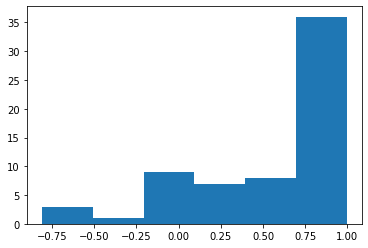

========== Epoch 0 Batch 46==== Step 2 Train Loss 0.6997793912887573 ======  0.3913043478260869
torch.Size([64, 48])
tensor([[-1.2366,  1.0443,  0.3502,  ...,  0.0460, -0.6261, -0.3316],
        [ 0.6826, -0.3700, -0.0073,  ...,  0.0644,  0.4212, -0.0949],
        [-0.5296,  1.1117,  0.1358,  ...,  0.0310, -0.7473, -0.3664],
        ...,
        [ 0.6122, -0.0304, -0.4642,  ...,  0.3203, -0.7254, -0.3153],
        [ 0.8113, -0.2609, -0.0339,  ..., -0.1562,  0.6521, -0.1348],
        [-1.4386,  1.1709,  0.5305,  ...,  0.0776, -0.5551, -0.2930]],
       device='cuda:0')
tensor([-1.8224e-01,  9.5563e-01, -4.7524e-01,  3.9715e-01,  8.5991e-01,
         4.8831e-01,  1.1309e-01, -8.7584e-01,  4.7980e-01,  9.4217e-01,
        -3.0697e-01,  9.1854e-01,  4.9691e-01,  8.5350e-01,  9.1454e-01,
        -6.2785e-01,  9.6079e-01,  8.3172e-01,  9.6550e-01, -1.8482e-01,
         2.6607e-01,  9.6849e-01, -6.1173e-01,  7.6932e-01, -2.9800e-01,
         3.8818e-01,  9.7743e-01,  9.8378e-01, -1.2529e-01, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


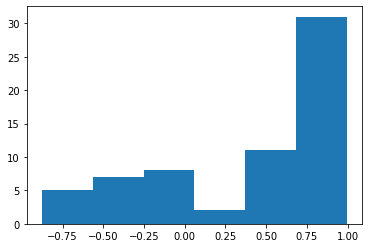

========== Epoch 0 Batch 47==== Step 2 Train Loss 0.7203590869903564 ======  0.3846153846153846
torch.Size([64, 48])
tensor([[-0.8989,  1.3933,  0.4126,  ...,  0.0661, -0.3699, -0.3615],
        [-1.0183,  1.3367,  0.4970,  ...,  0.0245, -0.0845, -0.4584],
        [ 0.2157,  0.1355, -0.0691,  ...,  0.2422, -0.2970, -0.3497],
        ...,
        [ 0.5821, -0.5007,  0.0814,  ...,  0.1920,  0.6956, -0.2509],
        [ 0.5037,  0.3129, -0.4136,  ...,  0.0964, -0.8207, -0.0311],
        [-1.4090,  1.1067,  0.5068,  ...,  0.0768, -0.5922, -0.3176]],
       device='cuda:0')
tensor([ 0.6720,  0.9716,  0.1185,  0.5975,  0.9197,  0.9744, -0.3117,  0.9739,
        -0.4661,  0.9911,  0.9847, -0.1399,  0.9447,  0.9844, -0.1503,  0.9728,
         0.9933,  0.6108,  0.2432,  0.0677,  0.5946, -0.5461,  0.9041,  0.9714,
         0.5939,  0.9548,  0.9874,  0.9905,  0.7608,  0.8633,  0.9523, -0.4212,
         0.9776,  0.9557,  0.9828,  0.9349,  0.2740,  0.3987,  0.9857,  0.7356,
         0.8464,  0.9753,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


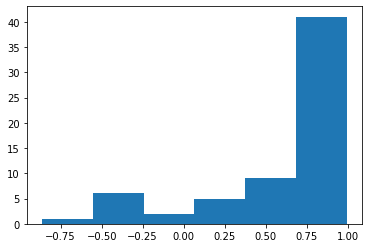

========== Epoch 0 Batch 48==== Step 2 Train Loss 0.7717744708061218 ======  0.35714285714285715
torch.Size([64, 48])
tensor([[-1.2960,  1.0792,  0.5453,  ..., -0.0307, -0.3771, -0.4643],
        [-1.2760,  1.1292,  0.6219,  ..., -0.0763, -0.3256, -0.4322],
        [-1.2087,  1.2789,  0.3959,  ..., -0.1254, -0.4096, -0.3585],
        ...,
        [-1.3057,  1.1706,  0.6448,  ..., -0.0530, -0.3760, -0.4322],
        [-1.3849,  1.0794,  0.5900,  ...,  0.0777, -0.5834, -0.3529],
        [-0.8933,  1.2544,  0.2316,  ..., -0.0379, -0.3523, -0.5660]],
       device='cuda:0')
tensor([ 0.9964,  0.9930, -0.6989,  0.9805,  0.7491,  0.8744,  0.9574,  0.5674,
        -0.5777, -0.2702,  0.9282,  0.2342,  0.0050, -0.0915,  0.3890,  0.9300,
         0.4903,  0.7982,  0.9740,  0.9130,  0.5422,  0.9612,  0.9328,  0.9633,
         0.7500,  0.6980,  0.9894,  0.8055,  0.9793,  0.8874, -0.4337,  0.6748,
         0.9606,  0.3193, -0.5103,  0.9062,  0.0058,  0.9404, -0.7355,  0.9925,
        -0.1728,  0.9690

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


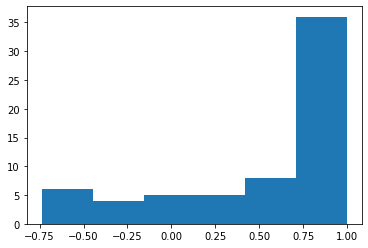

========== Epoch 0 Batch 49==== Step 2 Train Loss 0.6910907030105591 ======  0.4489795918367347
torch.Size([64, 48])
tensor([[ 0.2586,  0.9133,  0.0626,  ..., -0.0309, -0.0583, -0.3197],
        [-0.8676,  0.8973,  0.3587,  ..., -0.0530,  0.1908, -0.6784],
        [-1.1309,  1.1055,  0.3674,  ...,  0.0069, -0.2851, -0.5010],
        ...,
        [ 0.3719, -0.4709, -0.3351,  ...,  0.4447, -0.4224, -0.1388],
        [-0.9100,  0.9146,  0.2761,  ...,  0.0049, -0.0912, -0.7227],
        [-1.4386,  1.1709,  0.5305,  ...,  0.0776, -0.5551, -0.2930]],
       device='cuda:0')
tensor([ 0.2211,  0.7862, -0.0943,  0.9095,  0.9587, -0.4118,  0.8995, -0.4076,
         0.9956,  0.9576, -0.7007,  0.5156, -0.6087,  0.9686,  0.6532,  0.9425,
         0.8292,  0.9837,  0.9119, -0.6423,  0.4086,  0.9924,  0.9482,  0.7407,
         0.9360,  0.6173,  0.9215,  0.4504,  0.9586,  0.9082,  0.7153,  0.9786,
         0.1207,  0.9208,  0.8242,  0.9896,  0.9858,  0.9803,  0.9751,  0.7165,
        -0.0394,  0.8108,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


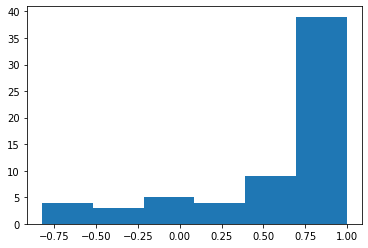

========== Epoch 0 Batch 50==== Step 2 Train Loss 0.7128228545188904 ======  0.29166666666666663
torch.Size([64, 48])
tensor([[-1.2982,  1.1451,  0.5844,  ...,  0.0090, -0.2458, -0.4737],
        [-1.4919,  0.9920,  0.5243,  ...,  0.0598, -0.6825, -0.3526],
        [ 0.0228,  0.9145, -0.0177,  ..., -0.1188, -0.0558, -0.4685],
        ...,
        [-1.0593,  1.2020,  0.4404,  ..., -0.0745, -0.2726, -0.5630],
        [-1.5528,  0.9868,  0.6148,  ...,  0.0784, -0.6554, -0.2778],
        [-1.4107,  1.1037,  0.4881,  ...,  0.0159, -0.7426, -0.2042]],
       device='cuda:0')
tensor([-0.2008, -0.7020,  0.4901, -0.7891, -0.2700,  0.6677,  0.5295, -0.6909,
         0.9931, -0.4999,  0.8969,  0.9170,  0.9778,  0.9342,  0.9617,  0.9502,
         0.9597,  0.9680,  0.3153,  0.7675,  0.7751,  0.9911,  0.4257,  0.9811,
         0.9896,  0.1938,  0.9811,  0.9707,  0.9919,  0.7396,  0.9047,  0.3773,
         0.9913,  0.9329,  0.6160,  0.8580,  0.7946, -0.5998, -0.7318, -0.0394,
         0.9605,  0.9662

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


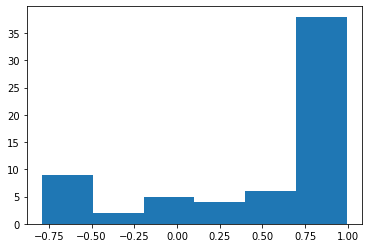

========== Epoch 0 Batch 51==== Step 2 Train Loss 0.7161099314689636 ======  0.4074074074074075
torch.Size([64, 48])
tensor([[-0.5098,  1.2666,  0.2094,  ..., -0.1714, -0.3442, -0.5363],
        [-0.9531,  1.3404,  0.3884,  ..., -0.0310, -0.1275, -0.5755],
        [-0.2035,  1.0347,  0.1565,  ..., -0.0972,  0.1179, -0.6036],
        ...,
        [-1.3466,  1.0309,  0.5970,  ..., -0.0847, -0.3619, -0.3244],
        [ 0.5130, -0.6971,  0.0717,  ...,  0.1526,  0.6546, -0.0350],
        [-1.2879,  1.0512,  0.4925,  ...,  0.0162, -0.6509, -0.2583]],
       device='cuda:0')
tensor([ 0.2319,  0.9746,  0.9030, -0.2972, -0.0273, -0.4336,  0.4084,  0.8415,
         0.9669, -0.2439,  0.9900,  0.8384, -0.6020,  0.9910,  0.7983,  0.0084,
         0.9870,  0.8696, -0.0580, -0.7282,  0.8847,  0.6409,  0.9145,  0.9296,
        -0.0594,  0.9830,  0.9883,  0.8916,  0.9912, -0.0056,  0.7466,  0.9503,
        -0.2329,  0.9904,  0.1092, -0.5424,  0.9645,  0.8465,  0.1802,  0.9824,
         0.3515,  0.9885,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


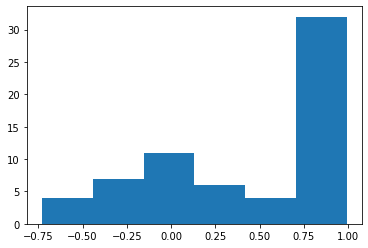

========== Epoch 0 Batch 52==== Step 2 Train Loss 0.6768016219139099 ======  0.4897959183673469
torch.Size([64, 48])
tensor([[-1.2547,  1.1978,  0.5102,  ...,  0.0179, -0.3000, -0.4958],
        [ 0.1790,  0.6889, -0.1979,  ..., -0.0559, -0.5116, -0.2769],
        [ 0.5685, -0.7785,  0.0699,  ...,  0.0567,  0.6170,  0.0695],
        ...,
        [-0.6621,  1.2225,  0.1562,  ..., -0.0177, -0.5613, -0.4450],
        [-1.4209,  0.9922,  0.4254,  ...,  0.0422, -0.6627, -0.4782],
        [-0.9986,  1.2936,  0.4480,  ..., -0.0631, -0.3644, -0.5373]],
       device='cuda:0')
tensor([ 9.9063e-01,  1.9948e-01,  6.6865e-01,  4.5294e-01,  9.2549e-01,
         2.4090e-01, -3.2425e-01,  9.3267e-01,  5.8699e-01, -4.8908e-01,
         7.2898e-01, -1.0965e-01,  9.6584e-01,  7.9767e-04, -2.2059e-01,
         9.3034e-01,  9.8105e-01,  1.6878e-01,  9.8655e-01,  8.2009e-01,
         7.8712e-01,  7.6867e-01,  8.9017e-01,  8.7976e-01,  8.2015e-01,
         7.8574e-02,  9.7689e-01,  8.9107e-01,  9.4646e-01, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


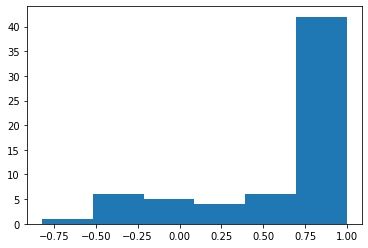

========== Epoch 0 Batch 53==== Step 2 Train Loss 0.7403871417045593 ======  0.3571428571428571
torch.Size([64, 48])
tensor([[-0.8933,  1.2544,  0.2316,  ..., -0.0379, -0.3523, -0.5660],
        [ 0.4187,  0.3984, -0.3849,  ...,  0.2015, -0.5779, -0.3197],
        [ 0.2219,  0.1535, -0.0320,  ...,  0.1341,  0.2579, -0.4211],
        ...,
        [-1.1925,  1.0694,  0.5852,  ...,  0.0109, -0.2746, -0.4163],
        [ 0.4856, -0.3292, -0.3875,  ...,  0.2724, -0.7811,  0.0058],
        [ 0.5417,  0.5957, -0.3669,  ...,  0.1204, -0.5667, -0.2311]],
       device='cuda:0')
tensor([-0.5871,  0.4509,  0.8171, -0.6017, -0.3947, -0.3597,  0.9881,  0.0868,
         0.7442,  0.6100, -0.0928,  0.9732,  0.4255,  0.9254, -0.2029,  0.5338,
         0.9705,  0.9696,  0.9685,  0.5325,  0.9129,  0.6598, -0.3321, -0.5341,
         0.3633, -0.0516,  0.9879,  0.9918, -0.7078,  0.8780,  0.9193,  0.9766,
         0.2209,  0.2525,  0.5628, -0.0441, -0.3879,  0.9614, -0.0489, -0.3838,
        -0.6183,  0.8761,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


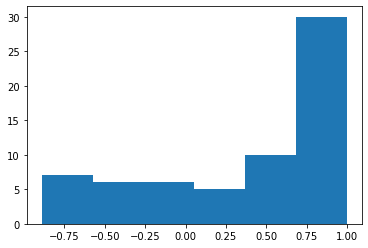

========== Epoch 0 Batch 54==== Step 2 Train Loss 0.7052297592163086 ======  0.3673469387755102
torch.Size([64, 48])
tensor([[ 0.6398, -0.7083,  0.1087,  ...,  0.2305,  0.7000, -0.1119],
        [-1.2786,  0.9488,  0.5772,  ..., -0.0457, -0.2610, -0.4052],
        [ 0.5941, -0.4109,  0.0466,  ...,  0.0364,  0.6148, -0.0963],
        ...,
        [-1.3364,  1.1315,  0.5472,  ...,  0.0434, -0.6048, -0.3285],
        [-0.0932,  0.9244, -0.0622,  ...,  0.0248, -0.3655, -0.5096],
        [ 0.2078,  0.7243, -0.0922,  ...,  0.0840, -0.2580, -0.2437]],
       device='cuda:0')
tensor([-0.4451, -0.7485, -0.4402,  0.9869,  0.9800,  0.8618,  0.7545, -0.0921,
         0.9266, -0.1807,  0.9767,  0.9538,  0.0775, -0.0566,  0.5259,  0.6321,
         0.6530, -0.1850, -0.7307,  0.9451, -0.3408,  0.8490,  0.3686,  0.9792,
         0.9955, -0.2619,  0.9175,  0.7133,  0.7665, -0.5892,  0.9846,  0.9298,
         0.6773,  0.8530,  0.9825,  0.3015,  0.9453,  0.2787,  0.9107,  0.9425,
         0.1111, -0.3557,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


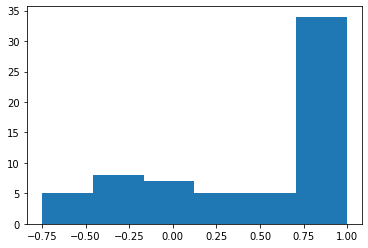

========== Epoch 0 Batch 55==== Step 2 Train Loss 0.6719694137573242 ======  0.47826086956521735
torch.Size([64, 48])
tensor([[-1.1239,  1.2301,  0.4535,  ...,  0.0948, -0.4713, -0.4432],
        [-0.1552,  1.0605, -0.1490,  ...,  0.0434, -0.4132, -0.6567],
        [-1.4291,  1.0356,  0.5421,  ...,  0.0283, -0.6316, -0.2754],
        ...,
        [ 0.0087,  0.3115, -0.3894,  ...,  0.0163, -0.5916, -0.3513],
        [-1.0031,  0.9289,  0.3501,  ..., -0.0564, -0.2396, -0.4708],
        [-1.3162,  1.0528,  0.7049,  ..., -0.0031, -0.3018, -0.3868]],
       device='cuda:0')
tensor([ 0.9629,  0.9553,  0.9834,  0.9354,  0.8813,  0.9925, -0.3879,  0.2974,
        -0.2735,  0.8216,  0.8403, -0.2391,  0.9888,  0.9197,  0.9859,  0.9183,
         0.9869,  0.9846, -0.6560,  0.5425,  0.9957,  0.9607,  0.8556,  0.9912,
         0.0706,  0.9713,  0.9913,  0.9917,  0.8933,  0.9881,  0.9783,  0.9963,
        -0.7251, -0.3631,  0.9735, -0.3724,  0.9913,  0.9562,  0.9834,  0.9903,
         0.9701,  0.0294

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


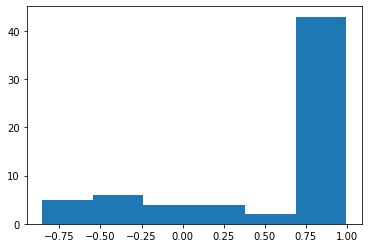

========== Epoch 0 Batch 56==== Step 2 Train Loss 0.74184650182724 ======  0.33333333333333337
torch.Size([64, 48])
tensor([[-1.2331,  1.2515,  0.5476,  ..., -0.1216, -0.3072, -0.4213],
        [-1.0122,  1.4354,  0.4911,  ...,  0.1031, -0.2712, -0.4033],
        [-0.5240,  1.1403,  0.2868,  ..., -0.1296, -0.2523, -0.5639],
        ...,
        [-1.4772,  1.0713,  0.5109,  ...,  0.0568, -0.6489, -0.3798],
        [-0.8285,  1.1976,  0.2564,  ..., -0.1177, -0.1841, -0.5822],
        [ 0.7252, -0.4601, -0.0061,  ...,  0.0468,  0.6158, -0.0361]],
       device='cuda:0')
tensor([ 0.9714,  0.8917,  0.9605, -0.4428,  0.8005,  0.9349, -0.4612,  0.9439,
         0.8866, -0.1474,  0.9909,  0.3756,  0.9575,  0.2875,  0.9903,  0.2351,
         0.6661,  0.9799,  0.7975,  0.9321,  0.9811,  0.9682,  0.4275,  0.9913,
        -0.0992,  0.8859,  0.9669,  0.9880,  0.9441,  0.6540,  0.9916,  0.7314,
         0.9478, -0.5890,  0.2482,  0.9706,  0.9591,  0.8854,  0.5779,  0.0513,
         0.9096,  0.9764, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


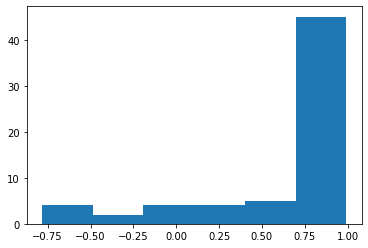

========== Epoch 0 Batch 57==== Step 2 Train Loss 0.7457030415534973 ======  0.459016393442623
torch.Size([64, 48])
tensor([[ 0.4941, -0.5949,  0.0408,  ...,  0.1187,  0.6551, -0.1850],
        [ 0.4791, -1.0049,  0.0772,  ...,  0.0858,  0.4971,  0.2117],
        [ 0.4073,  0.5618, -0.3719,  ...,  0.1893, -0.3844, -0.2963],
        ...,
        [-1.3162,  1.0528,  0.7049,  ..., -0.0031, -0.3018, -0.3868],
        [-0.7979,  1.0310,  0.2928,  ..., -0.1073, -0.2584, -0.4477],
        [ 0.9208, -0.3942, -0.2488,  ...,  0.1091,  0.4275, -0.0849]],
       device='cuda:0')
tensor([-0.5700, -0.7384,  0.8097,  0.7170,  0.1138,  0.9000,  0.9824,  0.9952,
         0.9927,  0.3510, -0.7658,  0.0721, -0.6562, -0.1091,  0.9942,  0.9911,
        -0.0594,  0.9150,  0.9120,  0.9224,  0.9814,  0.9886,  0.8944,  0.9695,
        -0.1226,  0.9604, -0.3360,  0.8967,  0.9100,  0.9900,  0.9262,  0.5187,
         0.8714,  0.9224, -0.8184,  0.9808, -0.0827,  0.6182,  0.8995,  0.7809,
         0.9548,  0.5494, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


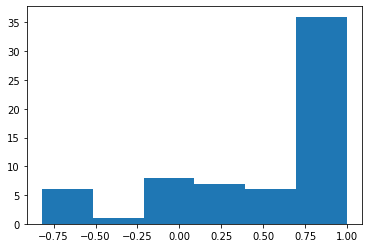

========== Epoch 0 Batch 58==== Step 2 Train Loss 0.7300602197647095 ======  0.32653061224489793
torch.Size([64, 48])
tensor([[ 4.0729e-01,  5.6181e-01, -3.7187e-01,  ...,  1.8925e-01,
         -3.8437e-01, -2.9629e-01],
        [-1.2395e-01,  1.1540e+00,  3.0269e-01,  ..., -4.3615e-02,
          2.2714e-02, -6.1691e-01],
        [ 3.8262e-01, -1.5463e-01, -3.9036e-01,  ...,  2.5116e-01,
         -9.7916e-01, -2.4113e-02],
        ...,
        [-4.3190e-01,  1.2429e+00,  1.3020e-01,  ..., -1.5986e-02,
         -3.6288e-01, -5.1111e-01],
        [-1.3078e+00,  9.3616e-01,  5.6553e-01,  ..., -9.5568e-04,
         -3.3426e-01, -3.9002e-01],
        [ 5.4155e-01, -4.3922e-01, -6.0035e-02,  ...,  1.1735e-02,
          4.5574e-01, -1.9255e-02]], device='cuda:0')
tensor([ 0.9369,  0.7212, -0.0248,  0.8374,  0.9824,  0.7725,  0.9750,  0.9860,
         0.9439, -0.6631,  0.9533,  0.9561,  0.9881,  0.4754,  0.9905,  0.9303,
         0.9934,  0.4271,  0.9858,  0.9943, -0.3132, -0.2697,  0.9551,  0

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


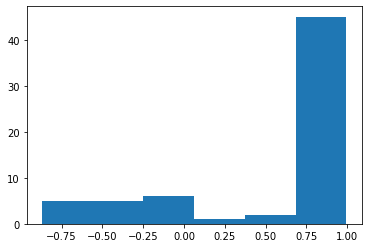

========== Epoch 0 Batch 59==== Step 2 Train Loss 0.7339347004890442 ======  0.4000000000000001
torch.Size([64, 48])
tensor([[-1.0064,  1.1612,  0.2788,  ..., -0.0927, -0.3348, -0.5654],
        [ 0.0549,  1.0062, -0.2714,  ..., -0.0853, -0.6683, -0.5103],
        [-1.1309,  1.1055,  0.3674,  ...,  0.0069, -0.2851, -0.5010],
        ...,
        [-1.2911,  1.0738,  0.5832,  ..., -0.1055, -0.3588, -0.3891],
        [ 0.5810, -0.2976,  0.0161,  ...,  0.0887,  0.6549, -0.3665],
        [ 0.4280,  0.0143,  0.0564,  ..., -0.1001,  0.5601, -0.4053]],
       device='cuda:0')
tensor([-0.0721,  0.9758,  0.9680,  0.0292,  0.9293,  0.9888,  0.8491, -0.5018,
         0.4362,  0.7780,  0.8818,  0.9885,  0.8804, -0.5035,  0.6215,  0.9966,
         0.6333,  0.2694,  0.3329,  0.0059, -0.1337,  0.9407,  0.9944, -0.3982,
         0.9283,  0.7043,  0.4233,  0.2654,  0.9874, -0.1709,  0.9151,  0.2587,
         0.9776,  0.9297,  0.5576,  0.9746,  0.9195,  0.7013,  0.9789, -0.6237,
         0.7253,  0.8669,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


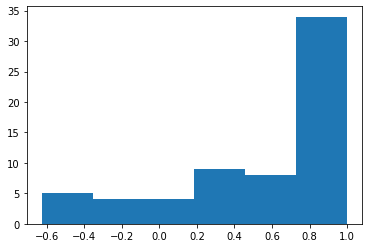

========== Epoch 0 Batch 60==== Step 2 Train Loss 0.7089842557907104 ======  0.4482758620689655
torch.Size([64, 48])
tensor([[ 0.4073,  0.5618, -0.3719,  ...,  0.1893, -0.3844, -0.2963],
        [-0.8988,  1.0355,  0.2791,  ..., -0.0644, -0.4630, -0.6298],
        [-1.2689,  1.2059,  0.5439,  ..., -0.0313, -0.6080, -0.3506],
        ...,
        [-1.3104,  1.0613,  0.6367,  ..., -0.0392, -0.2553, -0.4147],
        [-0.8337,  1.1159,  0.1479,  ...,  0.0218, -0.1356, -0.4791],
        [-0.8972,  1.2112,  0.3385,  ..., -0.2034, -0.2981, -0.5731]],
       device='cuda:0')
tensor([ 0.9369, -0.1766,  0.9897,  0.9756,  0.9558,  0.7334, -0.4914,  0.9420,
         0.8165,  0.9838,  0.3676,  0.9826,  0.8091,  0.3801, -0.0669,  0.3038,
         0.8162,  0.4022,  0.9935,  0.4816,  0.9777,  0.1834,  0.9779,  0.7346,
        -0.0377,  0.1639, -0.3582, -0.1127,  0.5964,  0.9121,  0.9918,  0.9058,
         0.9945, -0.7657,  0.3017,  0.9293,  0.6137, -0.5437, -0.1446,  0.9027,
         0.1722,  0.0647,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


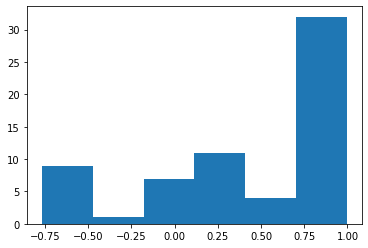

========== Epoch 0 Batch 61==== Step 2 Train Loss 0.704382061958313 ======  0.41509433962264153
torch.Size([64, 48])
tensor([[-1.3731,  1.0866,  0.5036,  ...,  0.0107, -0.6242, -0.3145],
        [-1.1707,  1.3597,  0.4744,  ...,  0.0482, -0.1981, -0.3794],
        [ 0.0093,  1.0110, -0.1024,  ...,  0.0707, -0.3269, -0.5262],
        ...,
        [-1.2644,  1.0952,  0.5467,  ...,  0.0036, -0.1489, -0.5242],
        [-0.3705,  1.2712,  0.2074,  ..., -0.0291, -0.3014, -0.5383],
        [ 0.5425, -0.3278,  0.0979,  ...,  0.1151,  0.8034, -0.3171]],
       device='cuda:0')
tensor([ 0.9505,  0.9843,  0.6115,  0.9497, -0.4313,  0.9948,  0.4652,  0.6651,
         0.9851,  0.9218,  0.7261,  0.9883, -0.6834,  0.9748, -0.2008,  0.0906,
         0.8578,  0.9751, -0.3526,  0.9055,  0.1860,  0.9921,  0.9442, -0.0399,
        -0.5263,  0.8722, -0.6415,  0.9794, -0.4063,  0.9624,  0.9782,  0.0632,
         0.9662,  0.4221,  0.9844, -0.0779,  0.9453,  0.5377,  0.9466,  0.8629,
         0.9724,  0.9875,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


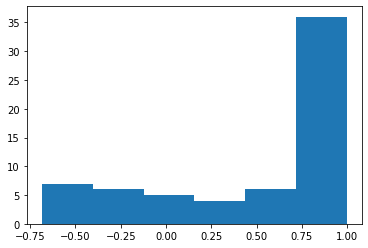

========== Epoch 0 Batch 62==== Step 2 Train Loss 0.750665009021759 ======  0.32142857142857145
torch.Size([64, 48])
tensor([[-0.1117,  1.0713, -0.0091,  ..., -0.0382, -0.5868, -0.3688],
        [ 0.3703,  0.5603,  0.0423,  ...,  0.1453,  0.0414, -0.3923],
        [-1.2804,  1.0736,  0.4059,  ...,  0.0111, -0.6980, -0.3929],
        ...,
        [-0.8356,  1.3510,  0.4815,  ...,  0.0966, -0.1293, -0.4623],
        [ 0.3651, -0.8368, -0.0228,  ...,  0.1812,  0.3445,  0.1345],
        [-1.4077,  1.1398,  0.5148,  ...,  0.0621, -0.6013, -0.3745]],
       device='cuda:0')
tensor([ 0.7766,  0.7306, -0.7536, -0.6635,  0.3412,  0.1645,  0.8754, -0.5636,
         0.8050,  0.9185,  0.9934,  0.8994, -0.7400,  0.6204,  0.8861,  0.7912,
         0.2269, -0.5012,  0.9836,  0.9795,  0.9540, -0.0648,  0.6651,  0.9730,
        -0.0011,  0.9932,  0.9631,  0.9290,  0.9272,  0.9877, -0.5197,  0.9833,
         0.1989,  0.9918,  0.7405,  0.9787,  0.9242,  0.9879,  0.9834,  0.9944,
        -0.6917,  0.9937,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


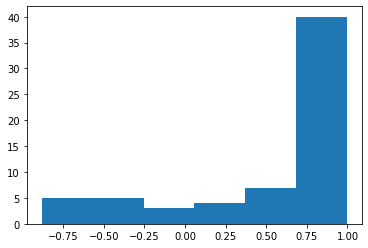

========== Epoch 0 Batch 63==== Step 2 Train Loss 0.7336326241493225 ======  0.37037037037037035
torch.Size([64, 48])
tensor([[-7.2781e-01,  1.1143e+00,  3.1105e-01,  ...,  5.6457e-02,
         -4.2965e-01, -5.3779e-01],
        [ 5.3800e-01, -2.8343e-01, -7.6518e-02,  ..., -1.7476e-01,
          4.1635e-01, -8.4727e-02],
        [-9.1407e-01,  1.2611e+00,  5.4519e-01,  ..., -1.0462e-01,
         -2.3632e-01, -4.8253e-01],
        ...,
        [ 4.6149e-01, -8.1123e-01,  9.6725e-02,  ...,  1.9848e-01,
          6.8729e-01, -1.2190e-03],
        [-8.9376e-01,  1.3843e+00,  4.9887e-01,  ..., -1.9164e-02,
         -2.7202e-01, -4.6650e-01],
        [-9.8413e-01,  1.1294e+00,  2.7837e-01,  ..., -1.1596e-01,
         -2.4175e-01, -6.0290e-01]], device='cuda:0')
tensor([ 0.2093, -0.7002,  0.9832, -0.2266,  0.3614,  0.9259, -0.7084,  0.6828,
         0.8916,  0.9717,  0.9794, -0.1284,  0.9746,  0.9527,  0.9765,  0.6375,
         0.0383,  0.8253,  0.1569, -0.2855,  0.9222, -0.8839,  0.0953,  0

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


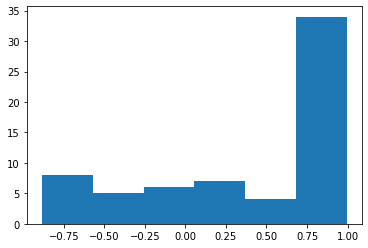

========== Epoch 0 Batch 64==== Step 2 Train Loss 0.7218093276023865 ======  0.3673469387755102
torch.Size([64, 48])
tensor([[-1.3462,  1.1147,  0.5766,  ..., -0.0501, -0.2399, -0.4743],
        [ 0.2905,  0.3283,  0.1226,  ..., -0.1208,  0.5098, -0.5255],
        [ 0.3946,  0.1347, -0.4562,  ...,  0.2042, -0.6463, -0.1608],
        ...,
        [-1.0156,  1.2767,  0.3918,  ..., -0.0145, -0.2219, -0.4080],
        [-1.2982,  1.1451,  0.5844,  ...,  0.0090, -0.2458, -0.4737],
        [-1.2441,  1.1606,  0.5669,  ..., -0.0108, -0.2069, -0.3485]],
       device='cuda:0')
tensor([ 0.9927, -0.1415, -0.3034,  0.9800, -0.8039,  0.9243, -0.7091,  0.1926,
         0.9146,  0.9596, -0.7481,  0.9847,  0.8119, -0.0016,  0.1278,  0.9341,
         0.9917,  0.9772,  0.9783,  0.9935,  0.8877,  0.9854,  0.9813, -0.0724,
         0.6443, -0.7851,  0.9873, -0.2841,  0.8729,  0.9208,  0.8344, -0.4245,
         0.2554,  0.8793,  0.9492,  0.2426,  0.9744, -0.7752, -0.2096,  0.9914,
        -0.9285,  0.9597,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


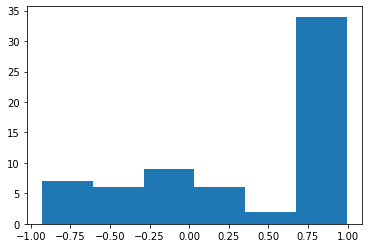

========== Epoch 0 Batch 65==== Step 2 Train Loss 0.734336793422699 ======  0.2916666666666667
torch.Size([64, 48])
tensor([[-1.2786,  0.9488,  0.5772,  ..., -0.0457, -0.2610, -0.4052],
        [-1.2366,  1.0443,  0.3502,  ...,  0.0460, -0.6261, -0.3316],
        [-0.9159,  1.4036,  0.5151,  ..., -0.0381, -0.2807, -0.3692],
        ...,
        [-1.3342,  1.0919,  0.5945,  ...,  0.0202, -0.5763, -0.2895],
        [-0.4662,  1.0617, -0.0678,  ...,  0.1706, -0.6424, -0.4735],
        [-1.2591,  1.1094,  0.4071,  ...,  0.0706, -0.4204, -0.4626]],
       device='cuda:0')
tensor([ 0.8644,  0.9862, -0.6011,  0.7165, -0.5998,  0.8924,  0.9851,  0.9819,
         0.6053,  0.8777,  0.9882, -0.6779,  0.9942,  0.7719,  0.9716,  0.2628,
        -0.0361,  0.6506,  0.9812,  0.5709,  0.9830, -0.5764, -0.0041,  0.9898,
         0.9921,  0.5227,  0.9888,  0.2154,  0.2250,  0.5336,  0.7475,  0.8239,
         0.9955, -0.6373, -0.1282,  0.9540,  0.9628,  0.8147,  0.3381,  0.5212,
         0.6834,  0.9630, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


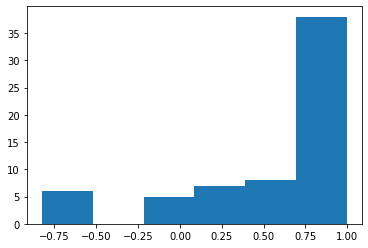

========== Epoch 0 Batch 66==== Step 2 Train Loss 0.7679869532585144 ======  0.3272727272727273
torch.Size([64, 48])
tensor([[-1.1644,  1.1991,  0.5249,  ..., -0.0393, -0.2487, -0.5677],
        [-0.0365,  0.8051, -0.1119,  ...,  0.0983, -0.2337, -0.3486],
        [-0.1240,  1.1540,  0.3027,  ..., -0.0436,  0.0227, -0.6169],
        ...,
        [-1.1503,  1.3181,  0.4642,  ...,  0.0609, -0.4010, -0.4159],
        [-1.5234,  1.0478,  0.6344,  ...,  0.0575, -0.6737, -0.2081],
        [-1.2788,  1.0906,  0.5091,  ..., -0.0722, -0.2141, -0.4788]],
       device='cuda:0')
tensor([ 0.9579,  0.7951,  0.7980,  0.4086,  0.9065,  0.9909, -0.2411,  0.8669,
         0.6357,  0.3390,  0.9739,  0.9831,  0.7926,  0.9369,  0.2042,  0.9570,
         0.9434,  0.4645, -0.4487,  0.9925,  0.9293, -0.3941,  0.0184,  0.9917,
        -0.7400,  0.3516,  0.5389,  0.9788,  0.6910,  0.9670,  0.9917, -0.3504,
         0.6020,  0.9933,  0.8046,  0.6718,  0.9833,  0.8506,  0.5880,  0.5995,
        -0.3492,  0.9033,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


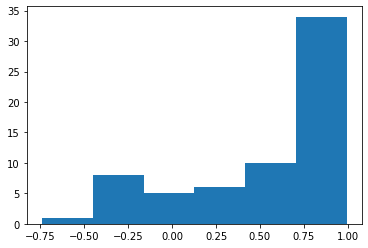

========== Epoch 0 Batch 67==== Step 2 Train Loss 0.7170304656028748 ======  0.3928571428571429
torch.Size([64, 48])
tensor([[-0.0104,  0.4681,  0.0672,  ..., -0.1937,  0.5054, -0.6504],
        [-1.0635,  1.0076,  0.6500,  ...,  0.0580, -0.1965, -0.4029],
        [-1.0265,  1.3387,  0.6677,  ...,  0.0159, -0.1478, -0.3517],
        ...,
        [ 0.7304,  0.3282, -0.0898,  ...,  0.0151,  0.3074, -0.2675],
        [ 0.5980,  0.8060, -0.0940,  ..., -0.0178, -0.1036, -0.3299],
        [ 0.2333,  0.5223, -0.2132,  ...,  0.1557, -0.4239, -0.5639]],
       device='cuda:0')
tensor([ 0.8640, -0.3303, -0.0091,  0.9880, -0.1182, -0.5543,  0.9828,  0.9941,
         0.9042,  0.9855,  0.8006, -0.2577,  0.4028,  0.4988, -0.5104, -0.8042,
        -0.5122,  0.2985,  0.9890,  0.2707,  0.0488,  0.8574,  0.9856,  0.1134,
         0.9644, -0.3732, -0.6047,  0.9877, -0.0597,  0.8976,  0.9930,  0.6715,
        -0.7453,  0.9792,  0.6396,  0.9966,  0.7488, -0.3793,  0.9322, -0.5738,
         0.9423, -0.1784,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


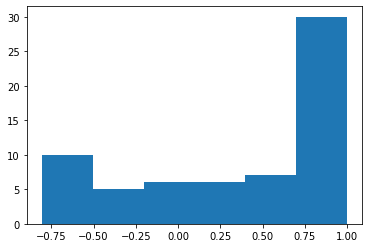

========== Epoch 0 Batch 68==== Step 2 Train Loss 0.7417861223220825 ======  0.2916666666666667
torch.Size([64, 48])
tensor([[ 0.5503, -0.0166, -0.4326,  ...,  0.1222, -0.8772, -0.0227],
        [ 0.7131,  0.3678,  0.1303,  ..., -0.0653,  0.3235,  0.0799],
        [ 0.5694,  0.2653, -0.1678,  ..., -0.0353,  0.2107, -0.5137],
        ...,
        [ 0.4791, -1.0049,  0.0772,  ...,  0.0858,  0.4971,  0.2117],
        [ 0.7252, -0.4601, -0.0061,  ...,  0.0468,  0.6158, -0.0361],
        [ 0.6560,  0.3316, -0.3128,  ...,  0.1620, -0.4369, -0.2091]],
       device='cuda:0')
tensor([ 0.2596,  0.3695,  0.4763, -0.3807,  0.9091, -0.5477, -0.1729,  0.0514,
         0.7078,  0.6204, -0.1992, -0.5054,  0.9875, -0.4102,  0.9287,  0.9948,
         0.9578, -0.2536,  0.9544,  0.7037,  0.7728,  0.9439, -0.6870,  0.9623,
         0.9646,  0.8967,  0.9478,  0.9738,  0.9518,  0.8706, -0.3979,  0.5177,
         0.9137,  0.1352,  0.1167,  0.8730,  0.8234,  0.9827,  0.9800, -0.6948,
        -0.6756,  0.9837,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


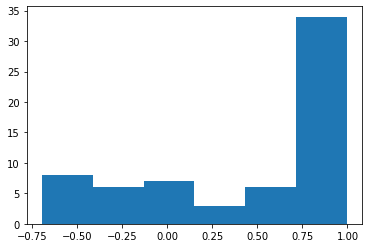

========== Epoch 0 Batch 69==== Step 2 Train Loss 0.6908203959465027 ======  0.49180327868852464
torch.Size([64, 48])
tensor([[ 0.6004, -0.4798, -0.1127,  ...,  0.2081,  0.5327, -0.1817],
        [-1.2786,  0.9488,  0.5772,  ..., -0.0457, -0.2610, -0.4052],
        [-0.8356,  1.3510,  0.4815,  ...,  0.0966, -0.1293, -0.4623],
        ...,
        [-0.7239,  1.1399,  0.3868,  ..., -0.0072, -0.2037, -0.4712],
        [-0.4908,  1.0151,  0.3486,  ..., -0.1349,  0.1698, -0.5773],
        [ 0.4548,  0.4287, -0.2833,  ...,  0.2834, -0.3923, -0.2320]],
       device='cuda:0')
tensor([ 0.9570,  0.9941,  0.9631,  0.9880,  0.9737,  0.4133,  0.2233, -0.7671,
         0.9612,  0.9058,  0.8857, -0.3211,  0.6169, -0.1040, -0.1564, -0.4547,
         0.9356,  0.3769,  0.9784,  0.9938,  0.9720, -0.2976, -0.2441,  0.8772,
        -0.2743, -0.0423,  0.9154,  0.7183,  0.9914,  0.0102,  0.9677, -0.5100,
         0.9847, -0.8196,  0.9801, -0.5733,  0.4527,  0.2339,  0.1315,  0.9428,
         0.9657,  0.9885

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


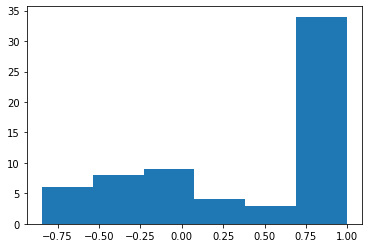

========== Epoch 0 Batch 70==== Step 2 Train Loss 0.7030298709869385 ======  0.4727272727272727


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


torch.Size([64, 48])
tensor([[-1.2788,  1.0906,  0.5091,  ..., -0.0722, -0.2141, -0.4788],
        [ 0.1696, -0.2963, -0.0257,  ...,  0.2114, -0.1839, -0.1407],
        [ 0.1945,  0.7061, -0.2769,  ..., -0.0486, -0.4817, -0.3923],
        ...,
        [-1.1540,  1.0509,  0.3702,  ...,  0.0580, -0.5099, -0.3729],
        [-1.3962,  1.1124,  0.5396,  ...,  0.1115, -0.6507, -0.3063],
        [-1.2760,  1.1292,  0.6219,  ..., -0.0763, -0.3256, -0.4322]],
       device='cuda:0')
tensor([ 0.9823,  0.7466, -0.0211,  0.0615,  0.6258,  0.5935,  0.9612,  0.4167,
         0.9095,  0.2395,  0.7850, -0.2698,  0.9362,  0.4207,  0.4507, -0.2192,
         0.9685,  0.9500,  0.9958,  0.9356,  0.9217, -0.6631,  0.9888,  0.9658,
         0.7003,  0.1111,  0.9636,  0.9862, -0.6841,  0.9441,  0.3884,  0.9888,
         0.9868,  0.9412,  0.9222,  0.9570,  0.8806,  0.0952,  0.9770,  0.9935,
         0.4476, -0.5084,  0.6583, -0.1797, -0.4435,  0.9416, -0.0825, -0.5945,
         0.9924,  0.9939,  0.9647,  0.936

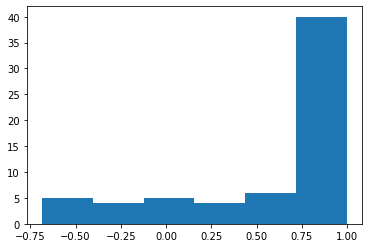

========== Epoch 0 Batch 71==== Step 2 Train Loss 0.72098308801651 ======  0.37037037037037035
torch.Size([64, 48])
tensor([[ 0.4977, -0.1591, -0.4705,  ...,  0.2923, -0.7666, -0.1391],
        [ 0.6317,  0.0311,  0.1004,  ..., -0.0261,  0.3219,  0.0641],
        [-0.9143,  1.3219,  0.3223,  ..., -0.0114, -0.2028, -0.5850],
        ...,
        [-1.1386,  1.1936,  0.4138,  ...,  0.0390, -0.4786, -0.3436],
        [ 0.6914, -0.6622, -0.0116,  ...,  0.1920,  0.6327, -0.1508],
        [-0.4701,  1.0007,  0.1265,  ..., -0.0161, -0.4456, -0.6164]],
       device='cuda:0')
tensor([ 0.9714, -0.5148,  0.8644,  0.4789, -0.5821, -0.1434, -0.4273,  0.7536,
         0.9737,  0.0120,  0.9883, -0.8168,  0.9711,  0.8357, -0.8138,  0.2282,
        -0.4482,  0.9856, -0.7385,  0.9497,  0.9603,  0.1705,  0.9862,  0.8451,
         0.9922, -0.3999,  0.7337,  0.9565,  0.0826,  0.8477,  0.7490,  0.9548,
         0.9792,  0.5471,  0.9942, -0.5086, -0.7787,  0.9859,  0.2159,  0.7812,
         0.1995, -0.0054, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


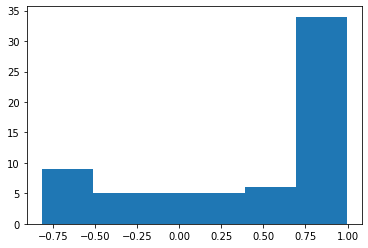

========== Epoch 0 Batch 72==== Step 2 Train Loss 0.7152840495109558 ======  0.27272727272727276
torch.Size([64, 48])
tensor([[-1.3364,  1.1315,  0.5472,  ...,  0.0434, -0.6048, -0.3285],
        [ 0.5348, -0.0662, -0.4665,  ...,  0.2833, -0.9400, -0.1275],
        [-0.8242,  0.8144,  0.2183,  ..., -0.0336, -0.1667, -0.6377],
        ...,
        [-0.8956,  0.9140,  0.2645,  ..., -0.1659, -0.1927, -0.5044],
        [ 0.1682,  0.7976, -0.0246,  ...,  0.2027, -0.2853, -0.3937],
        [-0.7509,  1.2571,  0.1315,  ...,  0.0354, -0.5684, -0.4213]],
       device='cuda:0')
tensor([-0.1336,  0.8782,  0.9610,  0.9920,  0.0514,  0.9331,  0.8850, -0.1766,
        -0.1457, -0.6771,  0.8398,  0.8743,  0.8188, -0.7107,  0.8931, -0.3432,
         0.8542, -0.6373,  0.9112,  0.5372, -0.3168,  0.6269,  0.9429,  0.9875,
         0.9055,  0.9264,  0.9933, -0.4776,  0.2985,  0.2155, -0.0749, -0.3126,
        -0.8509,  0.6054,  0.7417,  0.9899, -0.8269, -0.7713, -0.1830,  0.8958,
        -0.3097,  0.7840

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


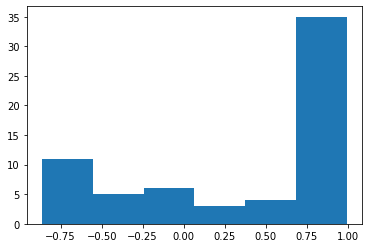

========== Epoch 0 Batch 73==== Step 2 Train Loss 0.6530769467353821 ======  0.3902439024390244
torch.Size([64, 48])
tensor([[-0.4487,  0.9212, -0.0880,  ..., -0.2330, -0.5489, -0.4732],
        [-0.8943,  1.2696,  0.5990,  ...,  0.0763, -0.3132, -0.4385],
        [-0.5215,  1.0631, -0.0059,  ..., -0.0762, -0.4281, -0.4321],
        ...,
        [-0.0272,  0.4727,  0.0856,  ...,  0.0871,  0.0867, -0.5415],
        [-1.2356,  1.0466,  0.4485,  ...,  0.0270, -0.6474, -0.3582],
        [-1.3567,  1.1212,  0.5071,  ...,  0.0908, -0.4530, -0.4381]],
       device='cuda:0')
tensor([ 0.7228,  0.9786,  0.9700, -0.6275,  0.9935, -0.3658, -0.3815,  0.0028,
         0.9587,  0.9471, -0.2801,  0.3257, -0.6047,  0.7413,  0.9002,  0.9634,
         0.5197, -0.5384,  0.9553,  0.9574,  0.9841, -0.0642,  0.6350, -0.5181,
         0.8687,  0.9680,  0.9932,  0.7296,  0.9472,  0.9829, -0.0460,  0.4219,
         0.9800,  0.5340, -0.2262,  0.9851,  0.1979,  0.9818,  0.1884,  0.9657,
         0.9948, -0.0209,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


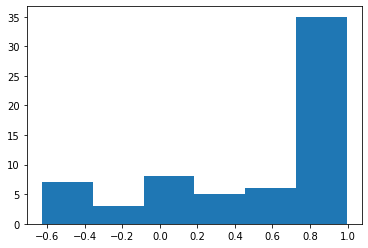

========== Epoch 0 Batch 74==== Step 2 Train Loss 0.7548077702522278 ======  0.3214285714285714
torch.Size([64, 48])
tensor([[-1.5234,  1.0478,  0.6344,  ...,  0.0575, -0.6737, -0.2081],
        [-0.5308,  1.2628,  0.2311,  ...,  0.0910, -0.2654, -0.4449],
        [-0.8486,  1.0985,  0.3665,  ..., -0.1437,  0.0706, -0.4745],
        ...,
        [ 0.7912,  0.2414, -0.0117,  ...,  0.0406,  0.3236, -0.0156],
        [ 0.5651, -0.3555, -0.1069,  ...,  0.1122,  0.6507, -0.3559],
        [-0.6651,  1.1630,  0.2637,  ...,  0.1229, -0.3259, -0.4469]],
       device='cuda:0')
tensor([ 0.9683,  0.9162,  0.9286, -0.7187, -0.5059,  0.9852,  0.9772,  0.5535,
         0.9909,  0.9170,  0.9818,  0.9943,  0.2355,  0.1309,  0.8956,  0.9821,
         0.3158, -0.5563,  0.6269,  0.7394,  0.9829,  0.5430,  0.9702, -0.3768,
         0.8403,  0.8901,  0.2459,  0.8944,  0.4126,  0.3176,  0.8365,  0.9773,
         0.5932,  0.7813,  0.9218,  0.3533,  0.9844, -0.0392,  0.9856, -0.1098,
         0.9676,  0.9882,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


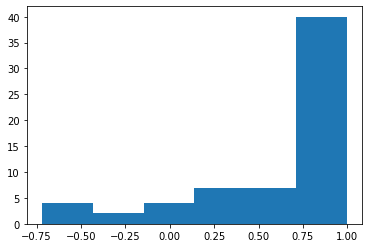

========== Epoch 0 Batch 75==== Step 2 Train Loss 0.7560520768165588 ======  0.3018867924528302
torch.Size([64, 48])
tensor([[-1.0377,  1.1186,  0.3893,  ...,  0.0325, -0.1161, -0.5927],
        [-1.4348,  1.0779,  0.6346,  ...,  0.0551, -0.4850, -0.3412],
        [-1.0377,  1.1186,  0.3893,  ...,  0.0325, -0.1161, -0.5927],
        ...,
        [-1.2995,  1.0325,  0.5813,  ...,  0.0100, -0.4038, -0.3478],
        [-1.1584,  1.1140,  0.3739,  ..., -0.0214, -0.3133, -0.4230],
        [-0.7266,  1.2504,  0.4474,  ...,  0.0523, -0.2305, -0.5874]],
       device='cuda:0')
tensor([ 0.9694,  0.9813, -0.6325,  0.8675,  0.4184,  0.0105,  0.5621,  0.8324,
         0.9930, -0.0982,  0.9835, -0.3291,  0.3083,  0.6923,  0.9707, -0.3865,
        -0.6553,  0.9170,  0.0911,  0.5250,  0.9614,  0.9857,  0.6812,  0.5834,
         0.9859,  0.0593, -0.4285,  0.8605,  0.6800,  0.2310,  0.6362,  0.7174,
        -0.5667,  0.9931,  0.4712,  0.9704,  0.9434,  0.5072,  0.5601,  0.6950,
        -0.3545,  0.0864,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


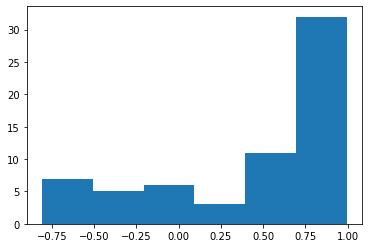

========== Epoch 0 Batch 76==== Step 2 Train Loss 0.7711712121963501 ======  0.22641509433962265
torch.Size([64, 48])
tensor([[ 0.6327, -0.0543, -0.5367,  ...,  0.2751, -0.8200, -0.1399],
        [-0.3374,  0.9135,  0.0524,  ..., -0.1916,  0.0949, -0.6658],
        [ 0.5415, -0.4392, -0.0600,  ...,  0.0117,  0.4557, -0.0193],
        ...,
        [-1.3531,  1.1383,  0.5271,  ...,  0.0971, -0.6268, -0.3693],
        [-1.3962,  1.1124,  0.5396,  ...,  0.1115, -0.6507, -0.3063],
        [ 0.8080, -0.2619, -0.4361,  ...,  0.2211, -0.4679,  0.1823]],
       device='cuda:0')
tensor([ 0.8335,  0.4822,  0.9601,  0.9924,  0.7114, -0.4977,  0.9901,  0.9515,
         0.9524,  0.8607, -0.0943, -0.7915, -0.5777,  0.9449,  0.8140,  0.0188,
         0.9797,  0.3885,  0.0072,  0.5369,  0.2344,  0.8988,  0.5757, -0.8494,
         0.9808, -0.0385,  0.9595,  0.9838,  0.9731,  0.9155,  0.9590,  0.9716,
         0.8797,  0.9370,  0.9784,  0.9178,  0.3890,  0.9533,  0.9360,  0.7446,
         0.7859,  0.9953

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


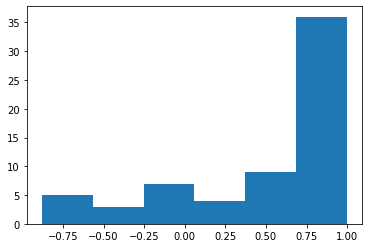

========== Epoch 0 Batch 77==== Step 2 Train Loss 0.7290927171707153 ======  0.39999999999999997
torch.Size([64, 48])
tensor([[-1.0122,  1.4354,  0.4911,  ...,  0.1031, -0.2712, -0.4033],
        [ 0.2725,  0.7180, -0.2659,  ...,  0.1861, -0.5643, -0.1336],
        [-0.8168,  1.1994,  0.2125,  ..., -0.0018, -0.4168, -0.4847],
        ...,
        [ 0.2905,  0.4028, -0.2786,  ...,  0.2503, -0.5889, -0.4088],
        [-0.8306,  1.0393,  0.3829,  ..., -0.0665,  0.0087, -0.5656],
        [ 0.5195, -0.6425,  0.0930,  ..., -0.0053,  0.5773,  0.0143]],
       device='cuda:0')
tensor([-0.5795,  0.8274,  0.9554,  0.8069,  0.3582,  0.9908,  0.9868,  0.9824,
         0.7545,  0.2984,  0.6704,  0.5665,  0.7147,  0.9161, -0.7179,  0.9675,
        -0.3465,  0.8528,  0.8849,  0.2923,  0.7719, -0.5072,  0.6335,  0.9593,
         0.3702,  0.6199,  0.9719, -0.1643,  0.9339, -0.4761, -0.3211,  0.7418,
        -0.0645,  0.8037,  0.8868,  0.6750,  0.8923,  0.9540,  0.9500,  0.8506,
         0.2029,  0.9964

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


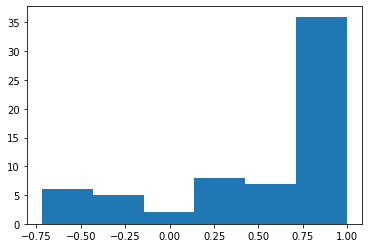

========== Epoch 0 Batch 78==== Step 2 Train Loss 0.7240477800369263 ======  0.18181818181818182
torch.Size([64, 48])
tensor([[-0.7509,  1.2571,  0.1315,  ...,  0.0354, -0.5684, -0.4213],
        [-0.9383,  1.2930,  0.3140,  ...,  0.0346, -0.1589, -0.5606],
        [-1.3162,  1.0528,  0.7049,  ..., -0.0031, -0.3018, -0.3868],
        ...,
        [-1.4209,  0.9922,  0.4254,  ...,  0.0422, -0.6627, -0.4782],
        [-0.4971,  1.2594,  0.2807,  ..., -0.0947, -0.0316, -0.5818],
        [ 0.3719, -0.4709, -0.3351,  ...,  0.4447, -0.4224, -0.1388]],
       device='cuda:0')
tensor([ 0.7365, -0.5550,  0.9912, -0.3776,  0.9498,  0.9933,  0.7884, -0.2397,
         0.9910,  0.9885,  0.0233,  0.9936,  0.0652,  0.9720, -0.4124, -0.3919,
         0.9894,  0.9737,  0.9773,  0.4629,  0.8456,  0.1241,  0.9673,  0.9895,
         0.9948,  0.7428, -0.0016,  0.5742,  0.9897,  0.9918,  0.9573,  0.1749,
        -0.0478,  0.9299,  0.8702,  0.8037,  0.3757,  0.9931,  0.6968,  0.1995,
         0.9571,  0.9633

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


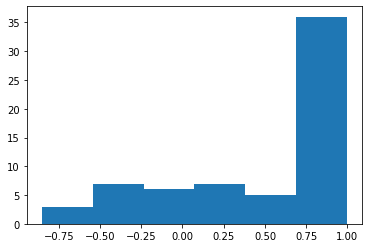

========== Epoch 0 Batch 79==== Step 2 Train Loss 0.7031583786010742 ======  0.3673469387755102
torch.Size([64, 48])
tensor([[-1.0363,  1.2024,  0.3165,  ..., -0.0372, -0.1416, -0.5221],
        [-1.4772,  1.0713,  0.5109,  ...,  0.0568, -0.6489, -0.3798],
        [ 0.1460,  0.7597, -0.1854,  ..., -0.0323, -0.3095, -0.4144],
        ...,
        [-0.9852,  1.1821,  0.2202,  ..., -0.0543, -0.3842, -0.6609],
        [ 0.4178, -0.0588, -0.3935,  ...,  0.1752, -0.8744,  0.1370],
        [ 0.1602,  0.8499, -0.0942,  ...,  0.2114, -0.5358, -0.4550]],
       device='cuda:0')
tensor([ 0.9859,  0.9936,  0.5107,  0.3704,  0.0367,  0.7996, -0.6492,  0.8063,
        -0.1157,  0.7799,  0.9439,  0.9909,  0.1239,  0.7389,  0.8183,  0.9829,
         0.9818,  0.9534,  0.5434, -0.3069, -0.5787,  0.9865,  0.9862,  0.9829,
         0.8946,  0.9506, -0.7074,  0.9049,  0.9877, -0.1458,  0.4566,  0.4501,
        -0.4345,  0.9485,  0.0399,  0.9902, -0.3567,  0.9857,  0.9736,  0.9662,
         0.9099,  0.9806,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


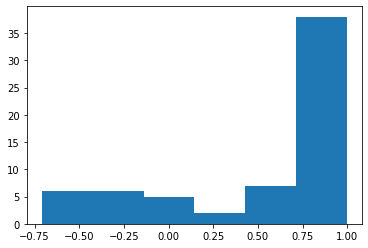

========== Epoch 0 Batch 80==== Step 2 Train Loss 0.7450069785118103 ======  0.35714285714285715
torch.Size([64, 48])
tensor([[-1.4876e+00,  1.0979e+00,  5.1740e-01,  ...,  8.6918e-02,
         -6.3262e-01, -4.6162e-01],
        [-1.1165e+00,  1.0646e+00,  5.7593e-01,  ...,  4.9428e-04,
         -2.0331e-01, -3.4027e-01],
        [ 5.7772e-01, -5.8791e-01,  1.0713e-01,  ...,  1.1626e-01,
          7.3783e-01, -1.1353e-01],
        ...,
        [-1.2630e+00,  9.8283e-01,  4.4500e-01,  ...,  3.6629e-02,
         -3.5585e-01, -4.3771e-01],
        [-1.4109e+00,  1.0001e+00,  5.5658e-01,  ...,  5.6658e-03,
         -4.2908e-01, -5.9147e-01],
        [-1.1644e+00,  1.1991e+00,  5.2486e-01,  ..., -3.9258e-02,
         -2.4873e-01, -5.6768e-01]], device='cuda:0')
tensor([ 0.9921,  0.9782,  0.9161,  0.9894,  0.9724, -0.1301,  0.2029,  0.9517,
         0.8029, -0.3506, -0.1342,  0.8621,  0.9929,  0.9914, -0.2737,  0.9891,
         0.7469,  0.9127, -0.5527, -0.0825, -0.2880,  0.9492, -0.1054, -0

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


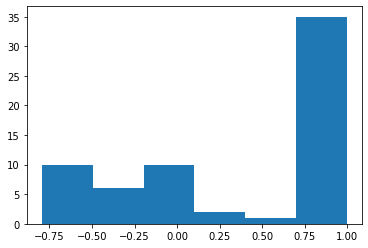

========== Epoch 0 Batch 81==== Step 2 Train Loss 0.7127370238304138 ======  0.4482758620689655
torch.Size([64, 48])
tensor([[-1.1660,  1.2503,  0.2727,  ..., -0.0540, -0.2665, -0.6168],
        [-1.0593,  1.2020,  0.4404,  ..., -0.0745, -0.2726, -0.5630],
        [-1.2710,  1.0923,  0.4392,  ...,  0.0119, -0.5537, -0.3883],
        ...,
        [-1.4348,  1.0779,  0.6346,  ...,  0.0551, -0.4850, -0.3412],
        [-0.8247,  1.2377,  0.2788,  ..., -0.1285, -0.1999, -0.5552],
        [-0.8285,  1.1976,  0.2564,  ..., -0.1177, -0.1841, -0.5822]],
       device='cuda:0')
tensor([ 0.3369,  0.6766, -0.7575,  0.9925,  0.2119,  0.8400,  0.9894,  0.3880,
        -0.7883,  0.6718,  0.9384,  0.6295,  0.0548,  0.9889,  0.9436,  0.9625,
         0.9506,  0.4362,  0.1950,  0.9656, -0.2945,  0.6937,  0.9761,  0.9795,
        -0.2067,  0.8895,  0.9541,  0.2409,  0.9436,  0.6540,  0.9546,  0.7870,
         0.8903, -0.5210,  0.9895,  0.9329,  0.9860,  0.9886,  0.9858,  0.8350,
         0.9119,  0.7282,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


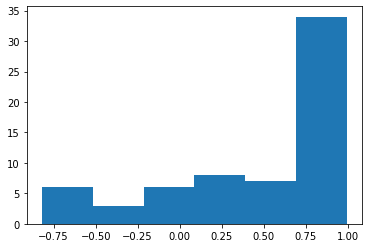

========== Epoch 0 Batch 82==== Step 2 Train Loss 0.7202576994895935 ======  0.3673469387755102
torch.Size([64, 48])
tensor([[-1.2786,  0.9488,  0.5772,  ..., -0.0457, -0.2610, -0.4052],
        [-1.4844,  1.0692,  0.5513,  ...,  0.0655, -0.6020, -0.2896],
        [-1.0635,  1.0076,  0.6500,  ...,  0.0580, -0.1965, -0.4029],
        ...,
        [ 0.5307,  0.5958, -0.3495,  ...,  0.1906, -0.6946, -0.2351],
        [-0.6442,  1.1782,  0.2434,  ...,  0.0233, -0.4369, -0.5772],
        [ 0.3983, -0.3045,  0.0470,  ...,  0.0660,  0.5105, -0.3029]],
       device='cuda:0')
tensor([ 0.9927,  0.9842,  0.9918,  0.0149, -0.7438,  0.9844, -0.8401,  0.8447,
         0.9922,  0.6828,  0.8875,  0.0236, -0.0980,  0.9692, -0.1107,  0.3257,
         0.5243,  0.9495,  0.8392,  0.9128, -0.0367,  0.5369,  0.9459,  0.9264,
         0.9712,  0.6506,  0.8875,  0.9905,  0.8449,  0.9622, -0.2659,  0.5743,
         0.0414,  0.9851,  0.8906,  0.6999,  0.9829, -0.6831,  0.5670,  0.9731,
         0.9316,  0.0372,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


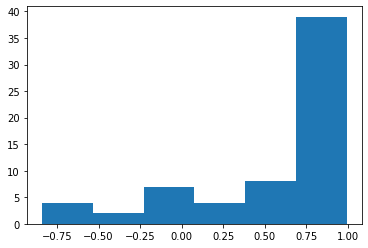

========== Epoch 0 Batch 83==== Step 2 Train Loss 0.7522386908531189 ======  0.2857142857142857
torch.Size([64, 48])
tensor([[-0.0198,  0.8874, -0.1421,  ...,  0.1852, -0.2916, -0.4161],
        [ 0.5209, -0.9021,  0.0292,  ...,  0.1750,  0.6252,  0.0852],
        [ 0.7952,  0.1868,  0.1524,  ...,  0.1220,  0.4865, -0.1601],
        ...,
        [-1.4291,  1.0356,  0.5421,  ...,  0.0283, -0.6316, -0.2754],
        [ 0.2157,  0.1355, -0.0691,  ...,  0.2422, -0.2970, -0.3497],
        [-0.9159,  1.4036,  0.5151,  ..., -0.0381, -0.2807, -0.3692]],
       device='cuda:0')
tensor([ 0.6546, -0.0209,  0.0089,  0.9712,  0.9695,  0.3624,  0.8160,  0.7439,
         0.9880,  0.9735,  0.9846,  0.1067,  0.9808, -0.4578,  0.9524,  0.8694,
         0.9932,  0.0058,  0.8310,  0.7800,  0.9729,  0.9325, -0.7289, -0.8493,
         0.9857,  0.9693,  0.1599, -0.1112,  0.9861,  0.3532,  0.8886,  0.9913,
         0.2461, -0.0042,  0.9272,  0.9932,  0.9910, -0.7870, -0.4909, -0.3127,
         0.9878,  0.2370,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


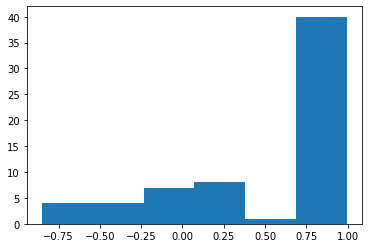

========== Epoch 0 Batch 84==== Step 2 Train Loss 0.7048099040985107 ======  0.36
torch.Size([64, 48])
tensor([[-1.3170,  1.0739,  0.5085,  ...,  0.0322, -0.6405, -0.3679],
        [-0.8265,  1.1467,  0.2594,  ..., -0.1064, -0.2028, -0.5914],
        [ 0.7249,  0.1164, -0.0711,  ...,  0.0174,  0.0868,  0.1031],
        ...,
        [-1.4772,  1.0713,  0.5109,  ...,  0.0568, -0.6489, -0.3798],
        [ 0.5862, -0.3358, -0.0459,  ...,  0.0875,  0.7939, -0.3583],
        [ 0.3486,  0.8046, -0.3333,  ...,  0.0380, -0.6201, -0.4998]],
       device='cuda:0')
tensor([ 0.9450,  0.9583, -0.3988,  0.9091,  0.8808, -0.1584,  0.8728,  0.6258,
         0.8547,  0.0326,  0.6396,  0.4232,  0.5799,  0.9185,  0.9197,  0.5426,
         0.1108,  0.7923,  0.5435,  0.9832,  0.9746,  0.2758,  0.7028,  0.9826,
         0.5459,  0.2877,  0.9206,  0.9692,  0.6053,  0.9909, -0.7107,  0.5752,
         0.9668, -0.1633,  0.2999,  0.7963, -0.0526,  0.9238,  0.9071,  0.9858,
         0.9838,  0.9525, -0.1934,  0.9

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


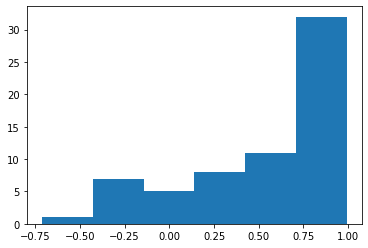

========== Epoch 0 Batch 85==== Step 2 Train Loss 0.7337267398834229 ======  0.4210526315789474
torch.Size([64, 48])
tensor([[-1.3104,  1.0613,  0.6367,  ..., -0.0392, -0.2553, -0.4147],
        [ 0.8234,  0.0159, -0.4278,  ...,  0.0972, -0.1774, -0.2801],
        [-1.4348,  1.0779,  0.6346,  ...,  0.0551, -0.4850, -0.3412],
        ...,
        [-0.4487,  0.9212, -0.0880,  ..., -0.2330, -0.5489, -0.4732],
        [-0.3819,  0.9011,  0.2103,  ..., -0.0637,  0.0047, -0.6330],
        [ 0.5829, -0.0029,  0.0511,  ..., -0.1490,  0.6723, -0.2594]],
       device='cuda:0')
tensor([ 0.9872,  0.7650,  0.9824,  0.0241,  0.9778,  0.5779,  0.7982,  0.0923,
         0.3359,  0.9310,  0.9646,  0.9886,  0.9935,  0.9690, -0.7724,  0.9931,
         0.9425,  0.5335,  0.6208, -0.0142, -0.4243,  0.1301,  0.9762, -0.0552,
         0.7565,  0.9907, -0.2416,  0.9187, -0.8644,  0.9791,  0.7960,  0.7983,
         0.9909,  0.9605,  0.8058,  0.9429,  0.7928,  0.4522,  0.3614,  0.9093,
         0.7267,  0.8266,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


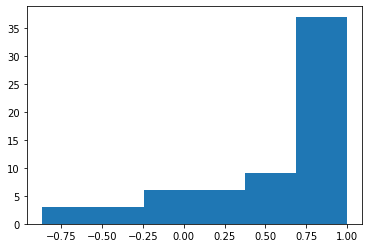

========== Epoch 0 Batch 86==== Step 2 Train Loss 0.7149463891983032 ======  0.48387096774193544
torch.Size([64, 48])
tensor([[ 0.5840, -0.5251,  0.0705,  ...,  0.0889,  0.6569, -0.1970],
        [-0.2249,  0.9508, -0.1857,  ...,  0.0933, -0.5021, -0.6406],
        [ 0.3703,  0.5603,  0.0423,  ...,  0.1453,  0.0414, -0.3923],
        ...,
        [-1.2786,  0.9488,  0.5772,  ..., -0.0457, -0.2610, -0.4052],
        [ 0.8113, -0.2609, -0.0339,  ..., -0.1562,  0.6521, -0.1348],
        [-0.1248,  0.8705, -0.0216,  ...,  0.0385, -0.2608, -0.6340]],
       device='cuda:0')
tensor([ 0.9791,  0.9498,  0.5111,  0.9126,  0.7805,  0.7993,  0.9868, -0.0445,
        -0.2091,  0.7832,  0.9898, -0.5515, -0.6329,  0.8950,  0.9685,  0.9178,
         0.9755,  0.7661,  0.3404,  0.8996,  0.9764,  0.9934, -0.2810,  0.9521,
         0.9030,  0.7444,  0.3443,  0.9662, -0.5094,  0.1664,  0.9737,  0.7618,
         0.9921, -0.3109, -0.7073,  0.9356,  0.9295,  0.3964,  0.3403,  0.2074,
         0.9683,  0.8538

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


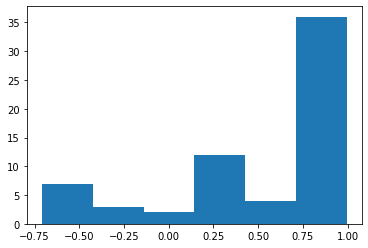

========== Epoch 0 Batch 87==== Step 2 Train Loss 0.7124118208885193 ======  0.46428571428571425
torch.Size([64, 48])
tensor([[-1.4107,  1.1037,  0.4881,  ...,  0.0159, -0.7426, -0.2042],
        [-1.4498,  1.1389,  0.5289,  ...,  0.1342, -0.5719, -0.2795],
        [-1.3356,  1.0630,  0.6518,  ...,  0.0380, -0.3062, -0.3769],
        ...,
        [-0.6917,  0.9628,  0.2721,  ..., -0.0549, -0.0926, -0.5986],
        [-1.3582,  1.1746,  0.4468,  ..., -0.0675, -0.3501, -0.4429],
        [-1.0414,  1.3739,  0.6016,  ...,  0.0296, -0.2668, -0.3415]],
       device='cuda:0')
tensor([ 0.1054, -0.5042, -0.8897, -0.0311,  0.0076,  0.8992,  0.5589,  0.9885,
         0.9395, -0.5517,  0.9200,  0.5354,  0.9686,  0.9652,  0.8757, -0.4339,
         0.9561,  0.9019,  0.9853,  0.6798, -0.5728,  0.9425,  0.8104,  0.8656,
         0.7419,  0.8738,  0.9679,  0.9192,  0.4322,  0.9441, -0.7603,  0.9242,
         0.7817,  0.9898,  0.0439, -0.1547,  0.9823, -0.7223, -0.4025, -0.2829,
         0.9327,  0.9915

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


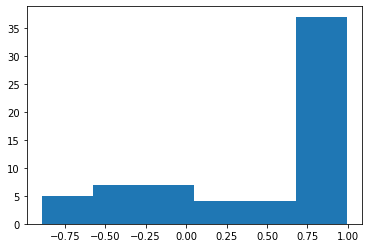

========== Epoch 0 Batch 88==== Step 2 Train Loss 0.7140953540802002 ======  0.4814814814814815
torch.Size([64, 48])
tensor([[-0.5099,  0.9884,  0.2797,  ...,  0.0155, -0.1420, -0.4038],
        [-0.9531,  1.3404,  0.3884,  ..., -0.0310, -0.1275, -0.5755],
        [-0.8257,  1.3505,  0.1982,  ..., -0.0217, -0.3555, -0.5510],
        ...,
        [-1.1503,  1.3181,  0.4642,  ...,  0.0609, -0.4010, -0.4159],
        [ 0.4815,  0.2858, -0.4466,  ...,  0.1091, -0.7968,  0.0141],
        [-1.5528,  0.9868,  0.6148,  ...,  0.0784, -0.6554, -0.2778]],
       device='cuda:0')
tensor([ 0.8115,  0.9734,  0.9130,  0.9076, -0.7390,  0.2778,  0.9843,  0.1452,
        -0.5120,  0.6377,  0.9869,  0.9266,  0.9335,  0.7253,  0.8767,  0.9757,
        -0.3176,  0.9551,  0.4805,  0.7897,  0.9913,  0.9805,  0.9832,  0.8870,
        -0.4547, -0.1889,  0.2500, -0.3002,  0.9439,  0.9909,  0.8916,  0.9183,
         0.8746,  0.1492, -0.8419, -0.4189,  0.9677, -0.1797,  0.9807,  0.9690,
         0.2568,  0.7818,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


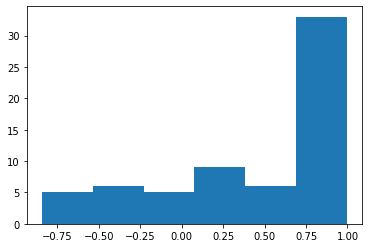

========== Epoch 0 Batch 89==== Step 2 Train Loss 0.7136375904083252 ======  0.31111111111111117
torch.Size([64, 48])
tensor([[-9.9244e-01,  1.2704e+00,  4.8349e-01,  ..., -1.5161e-01,
         -3.5789e-01, -4.5589e-01],
        [-1.2882e+00,  1.1016e+00,  5.7636e-01,  ..., -5.9641e-02,
         -4.0654e-01, -4.5207e-01],
        [-1.2708e+00,  1.0498e+00,  3.9554e-01,  ..., -9.8638e-04,
         -6.9632e-01, -4.4897e-01],
        ...,
        [-4.1394e-01,  1.2744e+00,  3.7555e-01,  ...,  1.2386e-02,
         -1.4310e-01, -5.8040e-01],
        [-8.9876e-01,  1.0355e+00,  2.7910e-01,  ..., -6.4379e-02,
         -4.6296e-01, -6.2980e-01],
        [ 1.3679e-01,  5.5502e-01,  1.0061e-01,  ...,  5.3668e-02,
          5.7972e-02, -4.3195e-01]], device='cuda:0')
tensor([ 0.9815,  0.9939,  0.0663,  0.9695,  0.9485,  0.9531, -0.6438,  0.9114,
        -0.5474,  0.9206, -0.0439,  0.8436, -0.3935,  0.6102,  0.9840,  0.7887,
         0.9911, -0.4770, -0.7209,  0.9843,  0.8569,  0.9561,  0.9924,  0

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


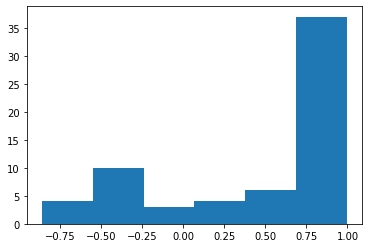

========== Epoch 0 Batch 90==== Step 2 Train Loss 0.7550629377365112 ======  0.16666666666666666
torch.Size([64, 48])
tensor([[-1.3073,  1.0413,  0.5789,  ..., -0.0993, -0.3444, -0.4910],
        [-0.5873,  1.2090,  0.0806,  ..., -0.1192, -0.3044, -0.6091],
        [-1.4386,  1.1709,  0.5305,  ...,  0.0776, -0.5551, -0.2930],
        ...,
        [-0.1393,  1.2867,  0.0997,  ..., -0.0567, -0.3639, -0.4851],
        [ 0.5195, -0.6425,  0.0930,  ..., -0.0053,  0.5773,  0.0143],
        [ 0.5503, -0.0166, -0.4326,  ...,  0.1222, -0.8772, -0.0227]],
       device='cuda:0')
tensor([ 0.9446, -0.7288,  0.7654,  0.9887, -0.0659, -0.3107,  0.4173,  0.9901,
         0.8673, -0.2050, -0.1656, -0.3027,  0.9656, -0.1869,  0.9861,  0.9946,
        -0.6015,  0.9146,  0.9665,  0.9881,  0.1403,  0.9865,  0.8743,  0.9440,
         0.9935, -0.2477,  0.9868,  0.9380,  0.7748,  0.9851,  0.9767, -0.7148,
         0.9541,  0.8737, -0.7196,  0.9000,  0.9118, -0.5073,  0.7571,  0.9592,
         0.9465,  0.9748

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


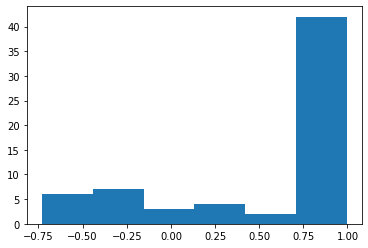

========== Epoch 0 Batch 91==== Step 2 Train Loss 0.7486357092857361 ======  0.25531914893617014
torch.Size([64, 48])
tensor([[ 0.7451, -0.2130,  0.0425,  ..., -0.0595,  0.4277,  0.1291],
        [ 0.9208, -0.3942, -0.2488,  ...,  0.1091,  0.4275, -0.0849],
        [ 0.3703,  0.5603,  0.0423,  ...,  0.1453,  0.0414, -0.3923],
        ...,
        [-0.9952,  1.1996,  0.3800,  ..., -0.0753, -0.3678, -0.5027],
        [ 0.0228,  0.9145, -0.0177,  ..., -0.1188, -0.0558, -0.4685],
        [-1.2882,  1.1016,  0.5764,  ..., -0.0596, -0.4065, -0.4521]],
       device='cuda:0')
tensor([ 0.7449,  0.9255,  0.2955,  0.9420,  0.4173, -0.3253, -0.6354,  0.9171,
        -0.1055,  0.9717,  0.7417, -0.3446,  0.8326,  0.6051, -0.3128, -0.8041,
         0.9162,  0.7760,  0.6433,  0.9325,  0.9558,  0.9855,  0.9761, -0.1945,
         0.9037, -0.6665,  0.9559, -0.6755, -0.1734, -0.5424,  0.9407, -0.6290,
         0.9214,  0.9553,  0.9914, -0.2192,  0.8943,  0.3716,  0.9544,  0.6860,
         0.9588,  0.9802

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


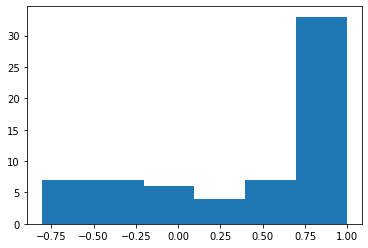

========== Epoch 0 Batch 92==== Step 2 Train Loss 0.6785169839859009 ======  0.5357142857142857
torch.Size([64, 48])
tensor([[-1.4919e+00,  9.9196e-01,  5.2432e-01,  ...,  5.9810e-02,
         -6.8246e-01, -3.5261e-01],
        [ 1.6564e-01,  7.8193e-01, -2.2008e-01,  ...,  1.5986e-04,
         -6.8573e-01, -3.0539e-01],
        [-1.2279e+00,  1.1347e+00,  5.3740e-01,  ..., -3.8596e-02,
         -3.0396e-01, -5.1748e-01],
        ...,
        [ 5.0854e-01,  5.0212e-01, -2.8084e-01,  ...,  1.6881e-01,
         -5.5637e-01, -3.5176e-01],
        [-3.7234e-01,  8.0262e-01, -5.3231e-02,  ...,  7.0549e-02,
         -4.7371e-02, -6.2707e-01],
        [ 5.0825e-01,  4.0675e-01, -3.8018e-01,  ...,  3.8402e-01,
         -7.0926e-01, -3.5356e-01]], device='cuda:0')
tensor([-0.3323,  0.8255, -0.8549,  0.9580,  0.8392,  0.9976,  0.9821,  0.9779,
         0.8067,  0.9857, -0.6754,  0.8909, -0.7226, -0.5601,  0.9907,  0.8225,
         0.6486, -0.0136,  0.9862, -0.6612,  0.7530,  0.8235,  0.6885, -0.

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


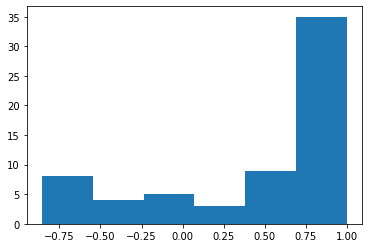

========== Epoch 0 Batch 93==== Step 2 Train Loss 0.6830852031707764 ======  0.5172413793103449
torch.Size([64, 48])
tensor([[-0.8242,  0.8144,  0.2183,  ..., -0.0336, -0.1667, -0.6377],
        [-1.0635,  1.0076,  0.6500,  ...,  0.0580, -0.1965, -0.4029],
        [-1.4251,  1.0237,  0.5623,  ...,  0.0974, -0.6975, -0.3793],
        ...,
        [-0.7817,  1.0717,  0.3966,  ..., -0.0083, -0.0664, -0.6679],
        [ 0.6242, -0.5360, -0.0182,  ...,  0.1521,  0.6371, -0.2428],
        [-0.0048,  0.5871, -0.1415,  ...,  0.1645, -0.6381, -0.5023]],
       device='cuda:0')
tensor([ 0.9541, -0.6324,  0.9816, -0.5997,  0.9596,  0.9685, -0.3186,  0.9859,
         0.9890,  0.7508,  0.9929,  0.2167,  0.6945, -0.0156,  0.8698,  0.9897,
        -0.5430,  0.6481, -0.3802,  0.9913,  0.2864, -0.4358,  0.9910, -0.3502,
         0.8990,  0.9755,  0.0605,  0.7983,  0.5333,  0.9886,  0.9611,  0.9090,
         0.9570,  0.5046, -0.1992, -0.1003,  0.9079,  0.7183,  0.9862,  0.3873,
         0.9266,  0.6980,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


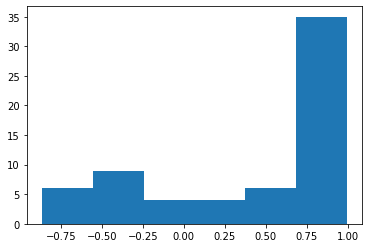

========== Epoch 0 Batch 94==== Step 2 Train Loss 0.7028999328613281 ======  0.2857142857142857
torch.Size([64, 48])
tensor([[-1.4386,  1.1709,  0.5305,  ...,  0.0776, -0.5551, -0.2930],
        [-0.8972,  0.9919,  0.3185,  ..., -0.0945, -0.4443, -0.4936],
        [ 0.3638,  0.4704, -0.1656,  ...,  0.1800, -0.3423, -0.1010],
        ...,
        [-0.0231,  0.6213,  0.0063,  ..., -0.0407, -0.3479, -0.2021],
        [-1.2982,  1.1451,  0.5844,  ...,  0.0090, -0.2458, -0.4737],
        [ 0.3981,  0.3872, -0.3250,  ...,  0.1264, -0.5630, -0.2440]],
       device='cuda:0')
tensor([ 0.9193,  0.1445,  0.2022,  0.8960,  0.9584, -0.3427,  0.5435,  0.9281,
         0.3478,  0.5200, -0.6215,  0.9672, -0.5895,  0.9862, -0.4994,  0.7686,
        -0.4663,  0.9927,  0.3941,  0.9706,  0.1039,  0.9771,  0.9515,  0.9723,
        -0.3652,  0.9839,  0.1860,  0.8004,  0.0239, -0.3051,  0.9787, -0.6239,
         0.7675,  0.6296,  0.9721,  0.5295,  0.1369,  0.7997, -0.7172,  0.9937,
         0.9833, -0.1308,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


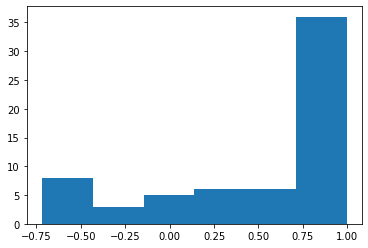

========== Epoch 0 Batch 95==== Step 2 Train Loss 0.7400079369544983 ======  0.2692307692307692
torch.Size([64, 48])
tensor([[-1.2879,  1.0512,  0.4925,  ...,  0.0162, -0.6509, -0.2583],
        [-0.6658,  1.0653, -0.0021,  ..., -0.1911, -0.4968, -0.5012],
        [-1.5155,  1.0566,  0.6494,  ...,  0.0953, -0.3893, -0.4249],
        ...,
        [-1.1873,  1.2165,  0.4781,  ..., -0.0027, -0.6671, -0.3672],
        [ 0.5840, -0.5251,  0.0705,  ...,  0.0889,  0.6569, -0.1970],
        [-0.5526,  1.0429,  0.2054,  ..., -0.0217, -0.3591, -0.5348]],
       device='cuda:0')
tensor([ 0.9926,  0.8140,  0.9846,  0.9001,  0.9397,  0.8387,  0.8643,  0.9792,
        -0.6831,  0.9824,  0.6882, -0.0607,  0.8116, -0.2122,  0.8335, -0.6728,
         0.4606,  0.2009,  0.8724, -0.0394,  0.9876,  0.4341,  0.9759,  0.9769,
         0.9629,  0.9685,  0.4748,  0.9882,  0.9573, -0.8156,  0.9489,  0.9896,
         0.2527,  0.0391,  0.9641, -0.5607,  0.3892, -0.2132,  0.8738,  0.1584,
        -0.1218,  0.9859,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


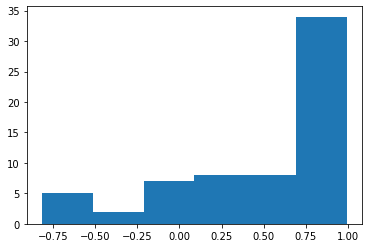

========== Epoch 0 Batch 96==== Step 2 Train Loss 0.7152103185653687 ======  0.4642857142857143
torch.Size([64, 48])
tensor([[-0.9531,  1.3404,  0.3884,  ..., -0.0310, -0.1275, -0.5755],
        [-1.2986,  1.0662,  0.3883,  ...,  0.1176, -0.5177, -0.2900],
        [ 0.2905,  0.4028, -0.2786,  ...,  0.2503, -0.5889, -0.4088],
        ...,
        [-0.2302,  0.6647, -0.2794,  ...,  0.1683, -0.5227, -0.6067],
        [-1.1098,  1.1550,  0.2467,  ..., -0.0540, -0.2313, -0.5849],
        [-1.5155,  1.0566,  0.6494,  ...,  0.0953, -0.3893, -0.4249]],
       device='cuda:0')
tensor([ 0.9801,  0.9883, -0.4741, -0.1351,  0.4816, -0.1044,  0.8726, -0.5525,
         0.9846,  0.9745,  0.9570,  0.9945,  0.8309, -0.2778,  0.7262,  0.3367,
         0.9912,  0.9961,  0.9787,  0.9905,  0.9955,  0.9813,  0.6500, -0.6265,
         0.9914,  0.2540,  0.9965,  0.8965,  0.9171, -0.6947, -0.5759, -0.0922,
         0.8598,  0.9587,  0.9882,  0.9184,  0.1110,  0.9788,  0.8508, -0.6614,
        -0.0900, -0.7780,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


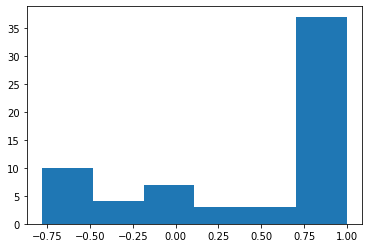

========== Epoch 0 Batch 97==== Step 2 Train Loss 0.7421560287475586 ======  0.33962264150943394
torch.Size([64, 48])
tensor([[-0.7144,  1.3005,  0.3446,  ..., -0.0782, -0.3563, -0.5837],
        [-0.5064,  0.5918, -0.1084,  ..., -0.0378, -0.5567, -0.4954],
        [ 0.7364, -0.2269, -0.1143,  ...,  0.0178,  0.5294, -0.1515],
        ...,
        [-0.9991,  1.3487,  0.4281,  ...,  0.0453, -0.1767, -0.3482],
        [-1.4291,  1.0356,  0.5421,  ...,  0.0283, -0.6316, -0.2754],
        [-1.2283,  1.2088,  0.4402,  ...,  0.0137, -0.2309, -0.4243]],
       device='cuda:0')
tensor([ 0.9640,  0.9066,  0.9398,  0.9932,  0.5581,  0.7526,  0.3595, -0.2126,
         0.9083,  0.9407,  0.9043,  0.6741, -0.6409,  0.9551,  0.9704,  0.9423,
         0.9150, -0.3544,  0.9001, -0.7208, -0.6685,  0.9851, -0.4435, -0.1564,
         0.9720,  0.8691,  0.9849,  0.4312,  0.0941,  0.0564, -0.7473, -0.2446,
        -0.1888,  0.9437,  0.9797,  0.4157, -0.8561, -0.2169,  0.9524, -0.6931,
        -0.1507,  0.8388

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


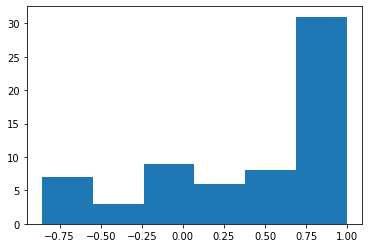

========== Epoch 0 Batch 98==== Step 2 Train Loss 0.6629538536071777 ======  0.5283018867924528
torch.Size([64, 48])
tensor([[-1.0999,  1.2697,  0.5187,  ..., -0.0409, -0.3708, -0.4182],
        [-0.9159,  1.4036,  0.5151,  ..., -0.0381, -0.2807, -0.3692],
        [ 0.5209, -0.9021,  0.0292,  ...,  0.1750,  0.6252,  0.0852],
        ...,
        [-1.4251,  1.0237,  0.5623,  ...,  0.0974, -0.6975, -0.3793],
        [-1.2441,  1.1606,  0.5669,  ..., -0.0108, -0.2069, -0.3485],
        [-0.9370,  1.4225,  0.4471,  ...,  0.1484, -0.2408, -0.4696]],
       device='cuda:0')
tensor([ 0.8316, -0.1735,  0.8776, -0.7443,  0.9426,  0.9702,  0.9442,  0.7730,
         0.4530,  0.1621,  0.3182,  0.9365,  0.9497,  0.9160,  0.9002,  0.8632,
         0.5056,  0.9910,  0.8732,  0.8225, -0.0199,  0.9183,  0.8550, -0.1361,
         0.9861,  0.9925,  0.4467,  0.8932,  0.3756,  0.9395,  0.9728,  0.5519,
         0.6934,  0.9792,  0.2250,  0.9895,  0.7783, -0.2521,  0.8790, -0.0433,
        -0.4301,  0.9808,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


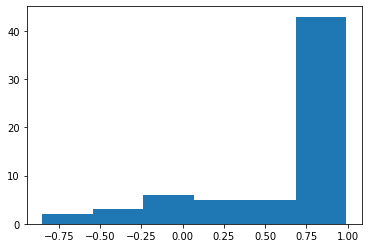

========== Epoch 0 Batch 99==== Step 2 Train Loss 0.6950429081916809 ======  0.5
  Batch   100  of    508.    Elapsed: 0:00:59.
torch.Size([64, 48])
tensor([[ 0.5535, -0.7609,  0.0229,  ...,  0.1984,  0.7142, -0.0787],
        [-1.2087,  1.2789,  0.3959,  ..., -0.1254, -0.4096, -0.3585],
        [ 0.1902,  0.5673, -0.2032,  ...,  0.0815, -0.5705, -0.2686],
        ...,
        [ 0.3782,  0.1249, -0.2557,  ...,  0.3521, -0.8663, -0.2478],
        [ 0.6122, -0.0304, -0.4642,  ...,  0.3203, -0.7254, -0.3153],
        [-0.5873,  1.2090,  0.0806,  ..., -0.1192, -0.3044, -0.6091]],
       device='cuda:0')
tensor([ 0.9711,  0.9628,  0.7982,  0.2242,  0.9942, -0.2073,  0.6647, -0.6358,
         0.8697,  0.6989,  0.9811, -0.1276,  0.9473,  0.9055,  0.9275,  0.5760,
         0.9917, -0.3802, -0.2702,  0.6777,  0.9609,  0.9928, -0.7793,  0.9355,
        -0.1904,  0.8588,  0.9629,  0.9723,  0.9862, -0.7205,  0.9629,  0.9914,
        -0.3539, -0.2319,  0.8703,  0.9909,  0.8036,  0.2498,  0.3069,  0

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


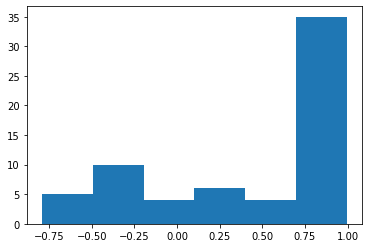

========== Epoch 0 Batch 100==== Step 2 Train Loss 0.6931896805763245 ======  0.43137254901960786
torch.Size([64, 48])
tensor([[-1.4209,  0.9922,  0.4254,  ...,  0.0422, -0.6627, -0.4782],
        [ 0.6363, -0.0309,  0.0473,  ..., -0.0788,  0.5509, -0.2580],
        [-0.0111,  1.0306,  0.0998,  ...,  0.0105,  0.0282, -0.4315],
        ...,
        [ 0.9208, -0.3942, -0.2488,  ...,  0.1091,  0.4275, -0.0849],
        [ 0.4858, -0.2691, -0.5149,  ...,  0.3341, -0.7034, -0.1211],
        [ 0.5968,  0.6069, -0.4477,  ...,  0.1455, -0.5736, -0.1389]],
       device='cuda:0')
tensor([-0.3885,  0.0892,  0.8807, -0.4835,  0.9633,  0.6705,  0.6431,  0.9176,
         0.9557, -0.2984,  0.6176,  0.8150, -0.2470,  0.9745,  0.8966,  0.8853,
         0.9823, -0.8003, -0.8075,  0.0956,  0.5689,  0.9895,  0.8570,  0.9917,
         0.3290,  0.8873,  0.4275, -0.8184,  0.7677, -0.2871, -0.5028,  0.8981,
         0.9311,  0.9615,  0.2082, -0.6166,  0.2727,  0.9361,  0.9486,  0.7642,
         0.4765,  0.973

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


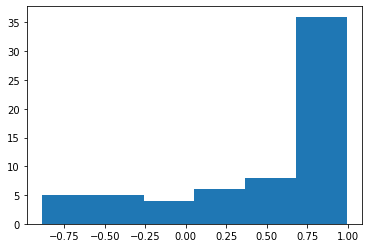

========== Epoch 0 Batch 101==== Step 2 Train Loss 0.6911488771438599 ======  0.41509433962264153
torch.Size([64, 48])
tensor([[ 0.5887, -0.7102,  0.0697,  ...,  0.1691,  0.7192, -0.1345],
        [-1.2879,  1.0512,  0.4925,  ...,  0.0162, -0.6509, -0.2583],
        [ 0.3703,  0.5603,  0.0423,  ...,  0.1453,  0.0414, -0.3923],
        ...,
        [ 0.5417,  0.5957, -0.3669,  ...,  0.1204, -0.5667, -0.2311],
        [ 0.6177, -0.4473,  0.0371,  ...,  0.0116,  0.7406, -0.1746],
        [ 0.5829, -0.0029,  0.0511,  ..., -0.1490,  0.6723, -0.2594]],
       device='cuda:0')
tensor([ 0.9785,  0.9928,  0.2955,  0.9559,  0.7135,  0.9357,  0.8399,  0.2478,
         0.6848, -0.7111,  0.0780, -0.1401, -0.2804,  0.3704,  0.4437,  0.9841,
         0.7638,  0.9430,  0.0704,  0.9508,  0.9535,  0.9604,  0.8506,  0.8909,
         0.9921, -0.1281,  0.9182,  0.6529,  0.7956,  0.9785, -0.5514,  0.5117,
         0.7820,  0.9872,  0.9882,  0.8983,  0.6980,  0.9857,  0.7612,  0.9397,
         0.9911,  0.184

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


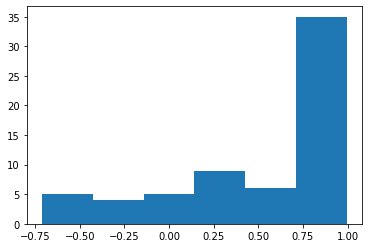

========== Epoch 0 Batch 102==== Step 2 Train Loss 0.723476231098175 ======  0.423076923076923
torch.Size([64, 48])
tensor([[ 0.1682,  0.7976, -0.0246,  ...,  0.2027, -0.2853, -0.3937],
        [ 0.5941, -0.4109,  0.0466,  ...,  0.0364,  0.6148, -0.0963],
        [-0.9986,  1.2936,  0.4480,  ..., -0.0631, -0.3644, -0.5373],
        ...,
        [-0.8492,  0.9457,  0.2521,  ..., -0.1311, -0.0841, -0.5844],
        [ 0.6638,  0.2282, -0.3845,  ...,  0.1277, -0.3795, -0.2432],
        [-1.2799,  1.2140,  0.3725,  ..., -0.0098, -0.6778, -0.3219]],
       device='cuda:0')
tensor([ 0.7407, -0.6334,  0.9868, -0.0042,  0.8278,  0.9707,  0.9245,  0.9915,
        -0.4271, -0.1348,  0.9481,  0.2614,  0.9902, -0.7917, -0.1546,  0.6674,
         0.9876,  0.9512,  0.9492, -0.6881,  0.8639,  0.6695,  0.9890,  0.7057,
        -0.5827,  0.9832,  0.8358,  0.7232,  0.9657,  0.0868,  0.9466,  0.0488,
         0.9930,  0.9571,  0.8737, -0.7373,  0.9647,  0.2150,  0.9532,  0.8051,
         0.9356,  0.9206, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


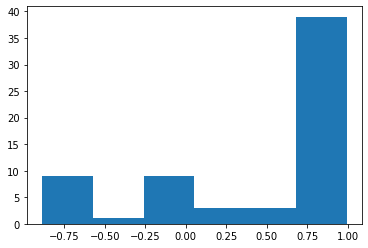

========== Epoch 0 Batch 103==== Step 2 Train Loss 0.6704649329185486 ======  0.4999999999999999
torch.Size([64, 48])
tensor([[ 0.9538, -0.0024, -0.4087,  ...,  0.1048, -0.1753, -0.0655],
        [ 0.4232, -0.8927,  0.0313,  ...,  0.1150,  0.5829,  0.0558],
        [-0.0162,  0.6320, -0.1741,  ...,  0.1140, -0.5041, -0.4461],
        ...,
        [-1.0122,  1.4354,  0.4911,  ...,  0.1031, -0.2712, -0.4033],
        [ 0.1460,  0.7597, -0.1854,  ..., -0.0323, -0.3095, -0.4144],
        [-1.2856,  1.1997,  0.3838,  ..., -0.0056, -0.6806, -0.2989]],
       device='cuda:0')
tensor([ 0.7779,  0.4504, -0.0830,  0.9972,  0.6137,  0.9323, -0.0233,  0.9290,
         0.9109,  0.1004,  0.9516, -0.7855,  0.7425,  0.9955,  0.3577,  0.6596,
        -0.7282,  0.6206, -0.2869, -0.5388,  0.9584,  0.7876,  0.9249,  0.6965,
         0.7708,  0.7848, -0.5655, -0.6833,  0.9361,  0.8509,  0.9257, -0.6483,
         0.6746,  0.9778, -0.6748,  0.9347,  0.6618,  0.9736,  0.9703,  0.9849,
         0.7343, -0.3541

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


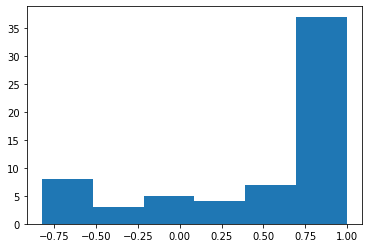

========== Epoch 0 Batch 104==== Step 2 Train Loss 0.6743225455284119 ======  0.37499999999999994
torch.Size([64, 48])
tensor([[-1.1584,  1.1140,  0.3739,  ..., -0.0214, -0.3133, -0.4230],
        [-1.4209,  0.9922,  0.4254,  ...,  0.0422, -0.6627, -0.4782],
        [-0.9519,  1.3078,  0.3642,  ...,  0.0275, -0.2816, -0.4355],
        ...,
        [-0.8313,  0.9267,  0.2940,  ...,  0.0815,  0.0583, -0.4111],
        [ 0.7125, -0.3681,  0.0648,  ...,  0.0952,  0.7561,  0.0172],
        [-1.3555,  1.0751,  0.5338,  ...,  0.0804, -0.6597, -0.2875]],
       device='cuda:0')
tensor([ 0.9616,  0.9861,  0.9738,  0.2748, -0.7581,  0.9721,  0.9918,  0.1348,
         0.5682,  0.2893,  0.9459, -0.4644,  0.8486,  0.7465,  0.8964,  0.1973,
         0.9925,  0.7973,  0.8811, -0.0630,  0.9234,  0.8896,  0.3634, -0.7722,
         0.9245,  0.9870, -0.2543,  0.9843,  0.1069,  0.8083,  0.9482,  0.8927,
         0.0661,  0.7094,  0.4927,  0.9703, -0.2089, -0.7574,  0.0810,  0.6089,
         0.6008,  0.987

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


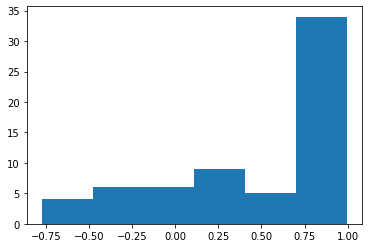

========== Epoch 0 Batch 105==== Step 2 Train Loss 0.6924645900726318 ======  0.4150943396226416
torch.Size([64, 48])
tensor([[ 0.6358, -0.2854, -0.1328,  ..., -0.1055,  0.5652, -0.2010],
        [-1.2957,  0.9894,  0.4829,  ..., -0.0125, -0.2878, -0.3933],
        [-1.1925,  1.0694,  0.5852,  ...,  0.0109, -0.2746, -0.4163],
        ...,
        [ 0.5810, -0.2976,  0.0161,  ...,  0.0887,  0.6549, -0.3665],
        [-0.9147,  1.3524,  0.3830,  ..., -0.0680, -0.1990, -0.5256],
        [ 0.4848, -0.0429, -0.4726,  ...,  0.1856, -0.8957,  0.0595]],
       device='cuda:0')
tensor([-0.1591,  0.9950, -0.1026,  0.9816,  0.5738,  0.9915,  0.9898,  0.9835,
        -0.1614, -0.2581,  0.9883,  0.9760,  0.9560,  0.9966,  0.9938,  0.2405,
         0.5304,  0.9873,  0.8947, -0.0736,  0.6154,  0.9901,  0.1896,  0.7834,
         0.9797, -0.4402,  0.8780, -0.1150, -0.6644,  0.8222,  0.9928,  0.9713,
         0.9873,  0.6258,  0.9346,  0.9951, -0.2655, -0.7739,  0.8384,  0.9664,
         0.9556,  0.5959

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


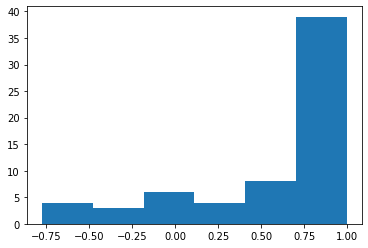

========== Epoch 0 Batch 106==== Step 2 Train Loss 0.7218427658081055 ======  0.3272727272727273
torch.Size([64, 48])
tensor([[-0.0404,  0.9925, -0.1200,  ...,  0.0925, -0.4536, -0.4438],
        [ 0.7597, -0.6939, -0.1312,  ...,  0.2384,  0.4092, -0.1514],
        [-1.3462,  1.1147,  0.5766,  ..., -0.0501, -0.2399, -0.4743],
        ...,
        [-1.0593,  1.2020,  0.4404,  ..., -0.0745, -0.2726, -0.5630],
        [-1.3104,  1.1130,  0.5366,  ..., -0.0132, -0.2718, -0.5188],
        [-0.7095,  1.3701,  0.3176,  ..., -0.0603, -0.1213, -0.3374]],
       device='cuda:0')
tensor([ 0.5333,  0.8532, -0.5340,  0.3001, -0.1622,  0.6167,  0.9829,  0.0899,
         0.9900,  0.9407,  0.9355,  0.9775, -0.7826,  0.8856,  0.0399,  0.3615,
         0.9849,  0.7689,  0.1077,  0.7443,  0.8614,  0.4308, -0.2451,  0.4443,
         0.9909,  0.9913, -0.3211,  0.8819,  0.9327,  0.9818,  0.9811,  0.9654,
         0.7786, -0.4122,  0.1679,  0.4452,  0.9838,  0.7812, -0.7004,  0.7987,
         0.9737,  0.5868

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


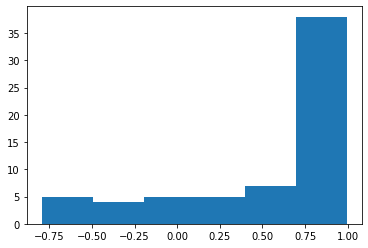

========== Epoch 0 Batch 107==== Step 2 Train Loss 0.6921772360801697 ======  0.48275862068965525
torch.Size([64, 48])
tensor([[ 7.6589e-01, -2.1255e-03, -4.5797e-01,  ...,  1.8850e-01,
         -3.4473e-01, -1.7893e-01],
        [-9.8484e-01,  1.1233e+00,  3.1504e-01,  ..., -3.2594e-03,
         -6.8400e-01, -2.7411e-01],
        [-1.3078e+00,  9.3616e-01,  5.6553e-01,  ..., -9.5568e-04,
         -3.3426e-01, -3.9002e-01],
        ...,
        [-1.2986e+00,  1.0662e+00,  3.8829e-01,  ...,  1.1758e-01,
         -5.1766e-01, -2.8996e-01],
        [-8.9891e-01,  1.3933e+00,  4.1263e-01,  ...,  6.6071e-02,
         -3.6994e-01, -3.6149e-01],
        [-7.8171e-01,  1.0717e+00,  3.9662e-01,  ..., -8.2513e-03,
         -6.6436e-02, -6.6786e-01]], device='cuda:0')
tensor([ 0.7562,  0.9613,  0.9892,  0.5989,  0.9664, -0.4187,  0.9635,  0.7856,
        -0.2341,  0.9348, -0.2299, -0.3755,  0.9914,  0.3243, -0.3441,  0.9672,
         0.6189,  0.9194,  0.9935,  0.9716, -0.6427,  0.8284,  0.9031,  

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


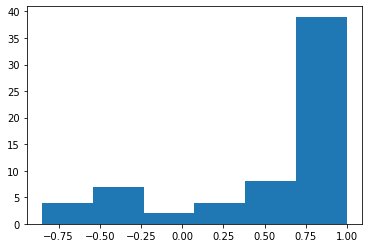

========== Epoch 0 Batch 108==== Step 2 Train Loss 0.733481228351593 ======  0.43333333333333335
torch.Size([64, 48])
tensor([[-1.1405,  1.1992,  0.5828,  ...,  0.0036, -0.3449, -0.4362],
        [-0.4104,  0.9800,  0.1111,  ..., -0.0826, -0.0869, -0.6566],
        [-0.6917,  0.9628,  0.2721,  ..., -0.0549, -0.0926, -0.5986],
        ...,
        [-0.1552,  1.0605, -0.1490,  ...,  0.0434, -0.4132, -0.6567],
        [-1.1813,  1.1511,  0.4591,  ...,  0.0195, -0.2204, -0.5355],
        [-1.0927,  1.0805,  0.4936,  ..., -0.1843, -0.1848, -0.3815]],
       device='cuda:0')
tensor([-0.1870,  0.3882,  0.8733,  0.9857,  0.4802,  0.8882,  0.8776,  0.9804,
        -0.5564,  0.9925,  0.9777,  0.9691, -0.1325,  0.6238,  0.9882, -0.4227,
         0.9778,  0.9304,  0.9293,  0.9753,  0.9915,  0.9776, -0.2333,  0.9940,
         0.9364, -0.7631, -0.0526,  0.9604, -0.5936, -0.4173,  0.0192,  0.9799,
        -0.8168,  0.5950,  0.9928,  0.9888,  0.5014,  0.9882, -0.7130,  0.9287,
         0.9894,  0.9843

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


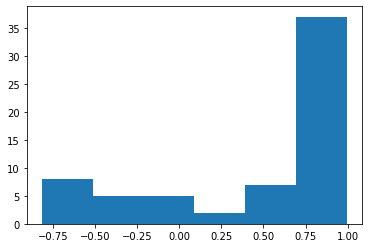

========== Epoch 0 Batch 109==== Step 2 Train Loss 0.7432745695114136 ======  0.3333333333333333
torch.Size([64, 48])
tensor([[ 7.6550e-01, -7.7023e-01, -1.2975e-02,  ...,  4.4169e-02,
          3.5075e-01,  8.3771e-02],
        [-1.2879e+00,  1.0512e+00,  4.9250e-01,  ...,  1.6238e-02,
         -6.5090e-01, -2.5829e-01],
        [-1.2986e+00,  1.0662e+00,  3.8829e-01,  ...,  1.1758e-01,
         -5.1766e-01, -2.8996e-01],
        ...,
        [-2.6541e-01,  1.1335e+00, -2.4064e-02,  ...,  9.7321e-04,
         -5.6005e-01, -3.9480e-01],
        [-1.1098e+00,  1.1550e+00,  2.4665e-01,  ..., -5.4031e-02,
         -2.3132e-01, -5.8489e-01],
        [-7.9786e-01,  1.0310e+00,  2.9281e-01,  ..., -1.0729e-01,
         -2.5838e-01, -4.4771e-01]], device='cuda:0')
tensor([-0.7421, -0.2767, -0.6795,  0.9889,  0.9943,  0.2627,  0.2864, -0.4434,
        -0.7025,  0.9774,  0.9523,  0.9613,  0.9905,  0.9639, -0.6906,  0.9961,
         0.9147,  0.9873,  0.1767,  0.8581,  0.8981, -0.1893,  0.9942,  0

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


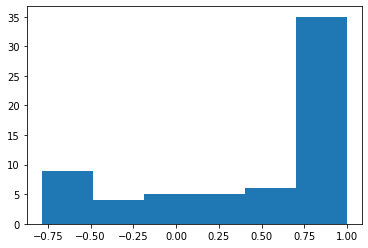

========== Epoch 0 Batch 110==== Step 2 Train Loss 0.721304178237915 ======  0.3673469387755102
torch.Size([64, 48])
tensor([[ 0.1742,  0.6754, -0.2077,  ...,  0.0399, -0.6339, -0.2681],
        [-1.0255,  0.9810,  0.3453,  ..., -0.0034, -0.3100, -0.4295],
        [ 0.7665, -0.2334, -0.0928,  ..., -0.1098,  0.4316, -0.0112],
        ...,
        [ 0.7249, -0.2902, -0.1187,  ...,  0.1176,  0.3453, -0.3477],
        [ 0.6224, -0.5825,  0.0156,  ...,  0.1775,  0.7018, -0.1850],
        [ 0.7775,  0.2745, -0.4390,  ...,  0.3652, -0.7770, -0.2891]],
       device='cuda:0')
tensor([ 0.2856,  0.9799, -0.8620,  0.8985,  0.9453,  0.9846, -0.8387,  0.9854,
         0.7725,  0.7943,  0.5407,  0.5406,  0.9951,  0.7809,  0.9438,  0.7466,
        -0.4569,  0.2026,  0.7114, -0.5433,  0.5295,  0.7382, -0.1569,  0.8825,
         0.9865,  0.8929,  0.8747,  0.9197,  0.9934,  0.9792,  0.9934,  0.9962,
        -0.1404,  0.7950,  0.0027,  0.9852, -0.0174, -0.6681, -0.7174, -0.4078,
         0.5055, -0.8653,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


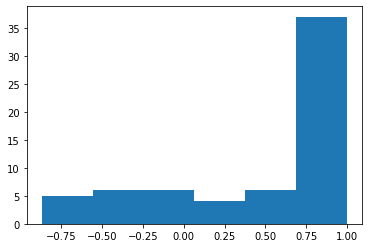

========== Epoch 0 Batch 111==== Step 2 Train Loss 0.7480244636535645 ======  0.3272727272727273
torch.Size([64, 48])
tensor([[-0.6043,  0.9013,  0.1998,  ..., -0.0540, -0.6052, -0.3171],
        [ 0.5821, -0.5007,  0.0814,  ...,  0.1920,  0.6956, -0.2509],
        [-0.3031,  1.2016,  0.1742,  ...,  0.1093, -0.3025, -0.4364],
        ...,
        [-0.3705,  1.2712,  0.2074,  ..., -0.0291, -0.3014, -0.5383],
        [-1.4090,  1.1067,  0.5068,  ...,  0.0768, -0.5922, -0.3176],
        [ 0.5583, -0.2956, -0.0522,  ...,  0.2364,  0.2224, -0.2454]],
       device='cuda:0')
tensor([ 0.9385,  0.9764,  0.8729,  0.7909, -0.4223,  0.3957,  0.9154,  0.8900,
         0.9448,  0.9860, -0.5165, -0.2752, -0.5737,  0.9854,  0.7732, -0.6581,
        -0.6071,  0.9675,  0.9573, -0.5388,  0.7318,  0.1511,  0.9562,  0.9243,
         0.9811,  0.9672,  0.7910,  0.9539, -0.7111,  0.9917,  0.9792,  0.7298,
         0.1192,  0.9532, -0.0052,  0.9682,  0.9934,  0.9838,  0.1398,  0.7807,
        -0.7321, -0.5545

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


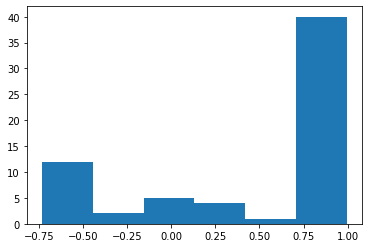

========== Epoch 0 Batch 112==== Step 2 Train Loss 0.6805140376091003 ======  0.4615384615384615


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


torch.Size([64, 48])
tensor([[ 0.7143,  0.1348, -0.0088,  ...,  0.0441,  0.2799, -0.2412],
        [-0.7928,  1.3466,  0.4217,  ...,  0.0201, -0.0535, -0.4203],
        [ 0.6204,  0.0745, -0.1706,  ..., -0.0700,  0.4327, -0.4120],
        ...,
        [-1.0179,  1.1543,  0.3259,  ..., -0.0318, -0.3608, -0.5335],
        [-1.2087,  1.2789,  0.3959,  ..., -0.1254, -0.4096, -0.3585],
        [-1.2804,  1.0736,  0.4059,  ...,  0.0111, -0.6980, -0.3929]],
       device='cuda:0')
tensor([ 0.6520,  0.9661,  0.0690,  0.2141,  0.9872,  0.7997,  0.9297,  0.8500,
        -0.2375, -0.7099,  0.9898, -0.0541,  0.7314,  0.9926, -0.7287,  0.7127,
         0.9863, -0.2926,  0.1683,  0.9165,  0.8434, -0.0011, -0.3074,  0.9507,
         0.6299,  0.8412,  0.3776, -0.2158,  0.9888, -0.8701,  0.3873, -0.7160,
         0.9935,  0.9517,  0.9007,  0.5544,  0.0720,  0.9897,  0.8518,  0.9918,
         0.9183, -0.4652,  0.9162,  0.9442,  0.8886, -0.1491,  0.9635, -0.7156,
        -0.2497,  0.7657,  0.0521, -0.179

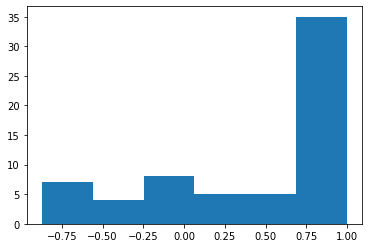

========== Epoch 0 Batch 113==== Step 2 Train Loss 0.7220497131347656 ======  0.4
torch.Size([64, 48])
tensor([[-0.5308,  1.2628,  0.2311,  ...,  0.0910, -0.2654, -0.4449],
        [-1.4077,  1.1398,  0.5148,  ...,  0.0621, -0.6013, -0.3745],
        [-1.0771,  1.0361,  0.2324,  ..., -0.0354, -0.3807, -0.4206],
        ...,
        [ 0.3638,  0.4704, -0.1656,  ...,  0.1800, -0.3423, -0.1010],
        [-0.5471,  1.3423,  0.2826,  ...,  0.0357, -0.1621, -0.6077],
        [-1.3392,  1.0580,  0.5910,  ..., -0.0844, -0.4738, -0.3501]],
       device='cuda:0')
tensor([ 0.9448, -0.4841,  0.9344,  0.5989, -0.0068,  0.8744,  0.0479,  0.6695,
         0.4232,  0.9752,  0.8948, -0.6161,  0.9924,  0.9149, -0.1645, -0.4540,
         0.9339,  0.5782,  0.3084,  0.9409,  0.9770, -0.0186,  0.9826,  0.6543,
         0.8491,  0.9752, -0.6688,  0.8640,  0.8538,  0.5458,  0.6523,  0.6979,
         0.6249,  0.4494,  0.9500,  0.7014,  0.9911,  0.9700,  0.5544,  0.0748,
         0.2795,  0.8032,  0.9887, -0.2

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


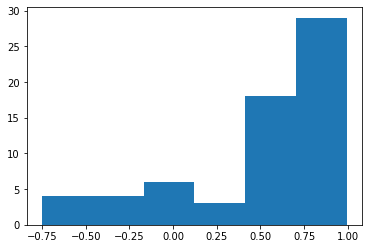

========== Epoch 0 Batch 114==== Step 2 Train Loss 0.6837748289108276 ======  0.5333333333333333
torch.Size([64, 48])
tensor([[-1.0771,  1.0361,  0.2324,  ..., -0.0354, -0.3807, -0.4206],
        [ 0.8185, -0.4541, -0.2030,  ..., -0.0215,  0.3811,  0.0581],
        [ 0.3719, -0.4709, -0.3351,  ...,  0.4447, -0.4224, -0.1388],
        ...,
        [-1.3962,  1.1124,  0.5396,  ...,  0.1115, -0.6507, -0.3063],
        [-1.1098,  1.1550,  0.2467,  ..., -0.0540, -0.2313, -0.5849],
        [-0.8991,  1.2932,  0.4628,  ...,  0.0361, -0.2071, -0.6166]],
       device='cuda:0')
tensor([ 0.9323,  0.3515,  0.7428, -0.8580,  0.3144,  0.9669,  0.9912, -0.6554,
         0.7902, -0.4891, -0.1859,  0.9138,  0.6516,  0.8029,  0.2110,  0.9735,
         0.9331,  0.3516,  0.9821,  0.5917,  0.9768,  0.6675,  0.7136, -0.1941,
         0.9940, -0.1828,  0.0959,  0.9639,  0.4811,  0.8755,  0.9962,  0.4907,
         0.9763,  0.9130,  0.9185, -0.3181,  0.1878, -0.1362,  0.9824,  0.8488,
         0.9898,  0.9282

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


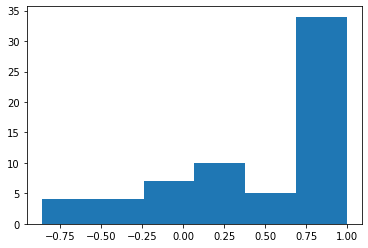

========== Epoch 0 Batch 115==== Step 2 Train Loss 0.6897289752960205 ======  0.5172413793103448
torch.Size([64, 48])
tensor([[ 0.5310,  0.0678, -0.4880,  ...,  0.3716, -0.5317, -0.3916],
        [-1.4876,  1.0979,  0.5174,  ...,  0.0869, -0.6326, -0.4616],
        [-1.3731,  1.0866,  0.5036,  ...,  0.0107, -0.6242, -0.3145],
        ...,
        [ 0.4243,  0.2453, -0.4365,  ...,  0.2270, -0.7709, -0.2980],
        [ 0.4315, -0.2380, -0.0620,  ...,  0.0605,  0.4145, -0.2347],
        [-1.4077,  1.1398,  0.5148,  ...,  0.0621, -0.6013, -0.3745]],
       device='cuda:0')
tensor([-0.0603,  0.9946, -0.8168,  0.4559,  0.5055,  0.9689,  0.9037,  0.9644,
         0.8416, -0.1791,  0.9718,  0.8772,  0.7997,  0.8025,  0.9716,  0.9854,
         0.6722,  0.8729,  0.1473,  0.9884,  0.9860,  0.3290, -0.2599,  0.4332,
        -0.5793,  0.5716,  0.9586,  0.9726,  0.9581,  0.9802, -0.2383,  0.5847,
         0.4094,  0.7088,  0.9647,  0.7653,  0.9244, -0.3346,  0.2800,  0.6420,
         0.9803, -0.1931

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


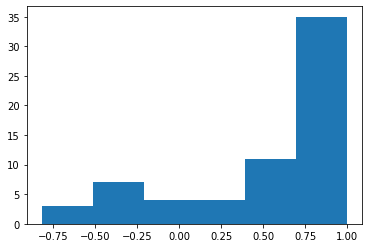

========== Epoch 0 Batch 116==== Step 2 Train Loss 0.7578356266021729 ======  0.3157894736842105
torch.Size([64, 48])
tensor([[-0.8541,  1.0261,  0.2606,  ..., -0.1620, -0.1384, -0.5400],
        [-1.0280,  1.0625,  0.3169,  ..., -0.0407, -0.2847, -0.5186],
        [-1.3962,  1.1124,  0.5396,  ...,  0.1115, -0.6507, -0.3063],
        ...,
        [ 0.5821, -0.5007,  0.0814,  ...,  0.1920,  0.6956, -0.2509],
        [ 0.1602,  0.8499, -0.0942,  ...,  0.2114, -0.5358, -0.4550],
        [-1.4386,  1.1709,  0.5305,  ...,  0.0776, -0.5551, -0.2930]],
       device='cuda:0')
tensor([ 0.9784,  0.9794,  0.9907,  0.9882, -0.1829, -0.4737,  0.9859,  0.9932,
         0.9122,  0.9603,  0.9935, -0.3091,  0.8632,  0.9329,  0.9715,  0.9148,
         0.8304,  0.9708,  0.8944, -0.2298,  0.9954, -0.3148,  0.1277,  0.4404,
         0.9665,  0.9833, -0.6346,  0.9892,  0.2729, -0.2622,  0.8714, -0.7624,
         0.3875,  0.8342,  0.9828,  0.9857,  0.9736,  0.5494,  0.8488,  0.9026,
         0.9184,  0.9170

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


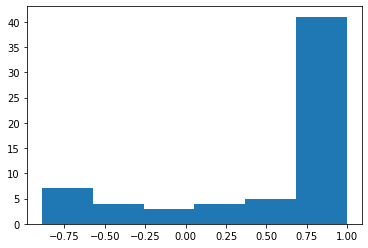

========== Epoch 0 Batch 117==== Step 2 Train Loss 0.7194597125053406 ======  0.35294117647058826
torch.Size([64, 48])
tensor([[-0.8843,  1.2498,  0.4276,  ...,  0.0083, -0.1354, -0.4991],
        [-0.0198,  0.8874, -0.1421,  ...,  0.1852, -0.2916, -0.4161],
        [-1.2330,  1.0996,  0.4440,  ..., -0.0840, -0.5587, -0.4490],
        ...,
        [-1.2760,  1.1292,  0.6219,  ..., -0.0763, -0.3256, -0.4322],
        [ 0.3764,  0.2099,  0.0508,  ...,  0.1711,  0.1765, -0.5730],
        [-0.1248,  0.8705, -0.0216,  ...,  0.0385, -0.2608, -0.6340]],
       device='cuda:0')
tensor([-0.7328,  0.7598,  0.9813,  0.9809,  0.9940,  0.2461,  0.6968,  0.9861,
         0.3320, -0.3767,  0.9911,  0.6491,  0.7470, -0.3217,  0.9906,  0.8075,
         0.0778, -0.2211,  0.8165,  0.7393,  0.5515, -0.6324,  0.2383, -0.0014,
         0.9441,  0.8519, -0.5867,  0.9136,  0.9889,  0.9486, -0.5543,  0.7773,
         0.8852, -0.6229, -0.5799,  0.1492,  0.9803,  0.8838, -0.8071,  0.0700,
         0.1455,  0.770

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


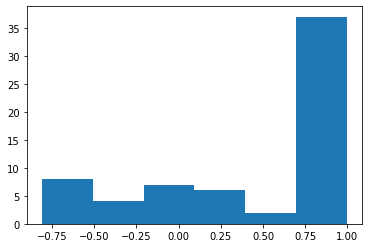

========== Epoch 0 Batch 118==== Step 2 Train Loss 0.6929712891578674 ======  0.4313725490196078
torch.Size([64, 48])
tensor([[-1.2688,  1.0855,  0.6017,  ..., -0.0183, -0.2832, -0.3602],
        [ 0.2898,  0.5771, -0.0424,  ...,  0.0460, -0.0290, -0.4949],
        [ 0.5569,  0.2474, -0.4614,  ...,  0.1131, -0.8210, -0.1078],
        ...,
        [-0.5098,  1.2666,  0.2094,  ..., -0.1714, -0.3442, -0.5363],
        [-1.0265,  1.3387,  0.6677,  ...,  0.0159, -0.1478, -0.3517],
        [-0.3723,  0.8026, -0.0532,  ...,  0.0705, -0.0474, -0.6271]],
       device='cuda:0')
tensor([ 0.5213,  0.8235, -0.1337,  0.9500,  0.9936,  0.2210, -0.4659, -0.1792,
        -0.5215,  0.9177,  0.8065,  0.8923,  0.9238,  0.9818,  0.9445,  0.9622,
        -0.1206,  0.7595,  0.9876,  0.9744,  0.9864, -0.1464,  0.9824,  0.9698,
        -0.3859,  0.9853, -0.2018,  0.9937,  0.8644,  0.9629,  0.6937,  0.9646,
        -0.7535, -0.7730,  0.9848,  0.6017, -0.6592,  0.9881,  0.8428,  0.0631,
         0.0365, -0.7002

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


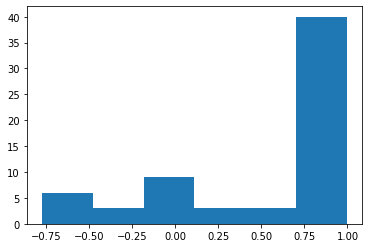

========== Epoch 0 Batch 119==== Step 2 Train Loss 0.7294964790344238 ======  0.37499999999999994
torch.Size([64, 48])
tensor([[-1.1441,  1.3307,  0.6555,  ..., -0.0181, -0.3380, -0.2226],
        [-0.0048,  0.5871, -0.1415,  ...,  0.1645, -0.6381, -0.5023],
        [-1.1499,  1.1676,  0.5367,  ..., -0.1130, -0.2179, -0.4193],
        ...,
        [-1.2986,  1.0662,  0.3883,  ...,  0.1176, -0.5177, -0.2900],
        [ 0.2973,  0.9606, -0.0914,  ..., -0.1031, -0.2041, -0.4218],
        [ 0.7120, -0.5674, -0.0526,  ...,  0.1234,  0.5407, -0.1935]],
       device='cuda:0')
tensor([ 0.9805,  0.7863,  0.9822,  0.9763,  0.9413,  0.9309,  0.7109,  0.8530,
        -0.6048, -0.7174, -0.0830,  0.9814, -0.7179, -0.8616,  0.9874,  0.7095,
         0.6259,  0.6325, -0.4417,  0.9908,  0.9865, -0.8087,  0.9944,  0.7649,
         0.9438,  0.9687,  0.9871,  0.9756,  0.9866, -0.1457,  0.2524,  0.9559,
         0.5626, -0.5998,  0.9736,  0.9930,  0.9662, -0.3748,  0.5646,  0.6480,
         0.1573, -0.280

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


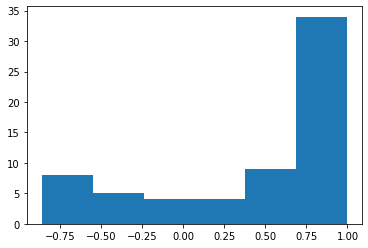

========== Epoch 0 Batch 120==== Step 2 Train Loss 0.723661482334137 ======  0.32653061224489793
torch.Size([64, 48])
tensor([[ 0.5460, -0.2487,  0.0796,  ...,  0.0712,  0.5809, -0.2903],
        [-0.8919,  1.1891,  0.4681,  ...,  0.0017, -0.0401, -0.5482],
        [ 0.3677,  1.0110, -0.0076,  ..., -0.1495,  0.3437, -0.5003],
        ...,
        [ 0.5621,  0.0019, -0.5127,  ...,  0.2555, -0.8495, -0.0778],
        [-1.1584,  1.1140,  0.3739,  ..., -0.0214, -0.3133, -0.4230],
        [ 0.0228,  0.9145, -0.0177,  ..., -0.1188, -0.0558, -0.4685]],
       device='cuda:0')
tensor([ 0.7487,  0.9737,  0.0858,  0.9966,  0.5765, -0.5679,  0.2174,  0.8964,
         0.9809,  0.7280,  0.9129,  0.6592,  0.9496,  0.7739, -0.7273,  0.2156,
         0.9871,  0.1183,  0.8440,  0.9114,  0.7151, -0.7955,  0.6775,  0.9711,
         0.9962,  0.7754, -0.5410,  0.7201,  0.9853, -0.4597,  0.5085,  0.9671,
         0.9534,  0.9802,  0.8804, -0.5907,  0.9941,  0.5212,  0.5377, -0.5098,
        -0.0779, -0.7881

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


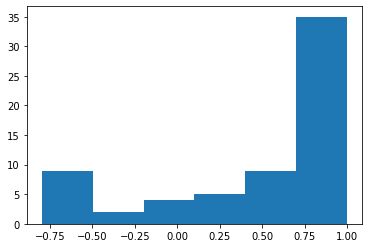

========== Epoch 0 Batch 121==== Step 2 Train Loss 0.7312758564949036 ======  0.3703703703703704
torch.Size([64, 48])
tensor([[ 0.4742,  0.1476, -0.5290,  ...,  0.2490, -0.9195, -0.1385],
        [ 0.3946,  0.1347, -0.4562,  ...,  0.2042, -0.6463, -0.1608],
        [ 0.5425, -0.3278,  0.0979,  ...,  0.1151,  0.8034, -0.3171],
        ...,
        [-1.1503,  1.3181,  0.4642,  ...,  0.0609, -0.4010, -0.4159],
        [ 0.6835, -0.4718, -0.0862,  ...,  0.0549,  0.5785, -0.1074],
        [ 0.5348, -0.0662, -0.4665,  ...,  0.2833, -0.9400, -0.1275]],
       device='cuda:0')
tensor([ 0.3639,  0.4575,  0.9506, -0.1222,  0.7449, -0.5871,  0.9425,  0.7812,
         0.9918,  0.9932,  0.6016,  0.7241,  0.8691, -0.1644, -0.1833,  0.9207,
         0.5084,  0.9782,  0.9648,  0.9365,  0.9757,  0.4638,  0.8302,  0.8569,
         0.9858,  0.3619,  0.9659, -0.1586,  0.9559,  0.9949,  0.9675,  0.9300,
         0.9601, -0.1163, -0.6340, -0.1884,  0.9905,  0.9880, -0.6375,  0.2587,
         0.1677,  0.9791

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


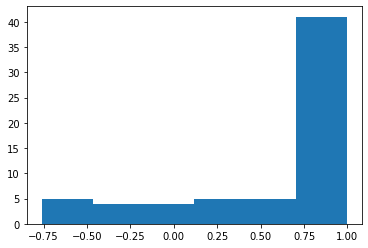

========== Epoch 0 Batch 122==== Step 2 Train Loss 0.760334312915802 ======  0.25
torch.Size([64, 48])
tensor([[-1.3731,  1.0866,  0.5036,  ...,  0.0107, -0.6242, -0.3145],
        [-1.3962,  1.1124,  0.5396,  ...,  0.1115, -0.6507, -0.3063],
        [ 0.5829, -0.0029,  0.0511,  ..., -0.1490,  0.6723, -0.2594],
        ...,
        [ 0.6315,  0.2634, -0.4012,  ...,  0.1298, -0.4018, -0.4272],
        [-1.3104,  1.1130,  0.5366,  ..., -0.0132, -0.2718, -0.5188],
        [-1.0593,  1.2020,  0.4404,  ..., -0.0745, -0.2726, -0.5630]],
       device='cuda:0')
tensor([ 0.9890,  0.9961,  0.9505,  0.9151,  0.9622,  0.7477,  0.9697,  0.8689,
         0.9928, -0.6968,  0.6891, -0.0454,  0.9273,  0.9919,  0.9928, -0.8868,
         0.9337,  0.9098,  0.9389,  0.9762,  0.8434,  0.9927,  0.9879,  0.9481,
         0.9887, -0.7074,  0.9198,  0.9654, -0.5404,  0.5345,  0.9911, -0.2515,
         0.9210,  0.9150,  0.9921,  0.9885, -0.7187, -0.5298,  0.9348,  0.9465,
         0.9924,  0.9925,  0.9743,  0.4

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


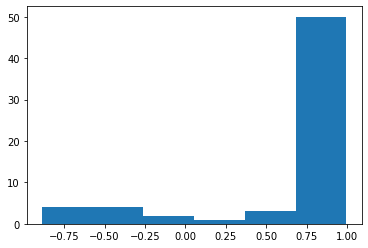

========== Epoch 0 Batch 123==== Step 2 Train Loss 0.7896329760551453 ======  0.24561403508771928
torch.Size([64, 48])
tensor([[ 0.5444, -0.9329,  0.0776,  ...,  0.0885,  0.5517,  0.2694],
        [-1.2957,  0.9894,  0.4829,  ..., -0.0125, -0.2878, -0.3933],
        [ 0.0997,  0.9889, -0.0663,  ..., -0.0116, -0.2888, -0.1708],
        ...,
        [-1.3962,  1.1124,  0.5396,  ...,  0.1115, -0.6507, -0.3063],
        [-1.2087,  1.2789,  0.3959,  ..., -0.1254, -0.4096, -0.3585],
        [-1.2366,  1.0443,  0.3502,  ...,  0.0460, -0.6261, -0.3316]],
       device='cuda:0')
tensor([ 0.9812,  0.9556, -0.3678, -0.7708, -0.2067,  0.8665, -0.6479,  0.9803,
         0.9831,  0.9817, -0.2631,  0.8344,  0.8023, -0.6648,  0.6705, -0.1312,
         0.9876,  0.9834,  0.0218, -0.6397, -0.4963,  0.9841,  0.9612,  0.8815,
        -0.6547,  0.4199,  0.8869,  0.0266,  0.9383,  0.9865,  0.9487, -0.1267,
         0.9851, -0.2800,  0.9391,  0.2885,  0.9727,  0.9718, -0.7739,  0.3329,
        -0.4098,  0.974

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


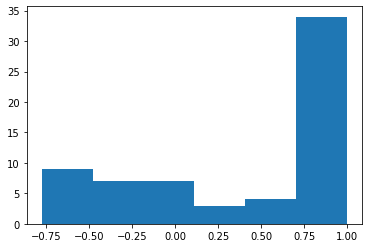

========== Epoch 0 Batch 124==== Step 2 Train Loss 0.6917229890823364 ======  0.43636363636363634
torch.Size([64, 48])
tensor([[ 5.2090e-01, -9.0209e-01,  2.9167e-02,  ...,  1.7499e-01,
          6.2518e-01,  8.5153e-02],
        [-1.2788e+00,  1.0906e+00,  5.0907e-01,  ..., -7.2157e-02,
         -2.1405e-01, -4.7880e-01],
        [ 8.7103e-03,  3.1153e-01, -3.8937e-01,  ...,  1.6266e-02,
         -5.9158e-01, -3.5131e-01],
        ...,
        [-1.2688e+00,  1.0855e+00,  6.0170e-01,  ..., -1.8337e-02,
         -2.8322e-01, -3.6021e-01],
        [-1.0283e+00,  1.1775e+00,  3.0125e-01,  ...,  2.6897e-02,
         -1.2090e-01, -5.9619e-01],
        [-1.1165e+00,  1.0646e+00,  5.7593e-01,  ...,  4.9428e-04,
         -2.0331e-01, -3.4027e-01]], device='cuda:0')
tensor([-0.6274,  0.1361,  0.8060,  0.4032,  0.8381, -0.3677, -0.2001,  0.9532,
         0.0033,  0.8137,  0.4638, -0.8077,  0.9704,  0.6533,  0.8816,  0.9627,
         0.0033,  0.9862, -0.7421, -0.7724,  0.9764, -0.0541,  0.9394,  

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


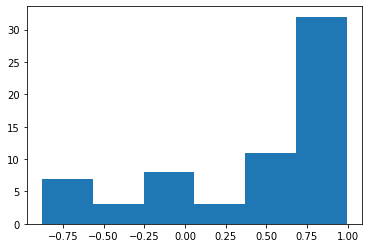

========== Epoch 0 Batch 125==== Step 2 Train Loss 0.6800076365470886 ======  0.5245901639344263
torch.Size([64, 48])
tensor([[ 0.7323, -0.4314,  0.0396,  ...,  0.1146,  0.7083, -0.0817],
        [-1.4386,  1.1709,  0.5305,  ...,  0.0776, -0.5551, -0.2930],
        [-0.4559,  0.8409,  0.1883,  ...,  0.1613, -0.1671, -0.7663],
        ...,
        [-1.3567,  1.1212,  0.5071,  ...,  0.0908, -0.4530, -0.4381],
        [-1.1644,  1.1991,  0.5249,  ..., -0.0393, -0.2487, -0.5677],
        [ 0.7688,  0.0416,  0.0851,  ..., -0.0717,  0.2484,  0.1197]],
       device='cuda:0')
tensor([-0.1025,  0.9849,  0.9351,  0.0810,  0.9704,  0.9156, -0.6722,  0.9494,
        -0.0258,  0.9912, -0.8493,  0.8372, -0.4429,  0.9788, -0.3702, -0.1588,
         0.6672,  0.8922,  0.9184,  0.8243,  0.9839, -0.9129,  0.4595,  0.9506,
         0.9533,  0.9571, -0.3762,  0.9829,  0.3497,  0.8585,  0.7835, -0.3475,
         0.9281,  0.8986, -0.0227,  0.9027,  0.9811, -0.0630,  0.9229, -0.4101,
         0.8823,  0.9842

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


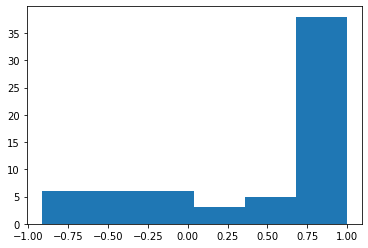

========== Epoch 0 Batch 126==== Step 2 Train Loss 0.676352858543396 ======  0.4705882352941177
torch.Size([64, 48])
tensor([[ 0.3910,  0.3610, -0.2484,  ...,  0.2830, -0.5612, -0.3109],
        [-1.3466,  1.0309,  0.5970,  ..., -0.0847, -0.3619, -0.3244],
        [ 0.9284,  0.0091, -0.0275,  ...,  0.0936,  0.3994, -0.1019],
        ...,
        [-1.2911,  1.0738,  0.5832,  ..., -0.1055, -0.3588, -0.3891],
        [ 0.5063, -0.1391, -0.1948,  ...,  0.2391, -0.0964, -0.3514],
        [-0.9357,  1.0441,  0.3356,  ..., -0.0637, -0.3658, -0.4985]],
       device='cuda:0')
tensor([ 0.8492,  0.9816,  0.8605,  0.9925,  0.9209,  0.2951,  0.9809,  0.9880,
        -0.7101, -0.7537, -0.6665,  0.6801, -0.6188,  0.9364,  0.9904,  0.9553,
         0.9849,  0.9853,  0.9748,  0.7136, -0.1282, -0.3809,  0.2892,  0.9657,
         0.2571,  0.0977, -0.1632,  0.9675, -0.4652,  0.9745,  0.6901,  0.3492,
         0.9825,  0.9716,  0.9885, -0.7713,  0.7907,  0.9542,  0.9866,  0.9578,
        -0.6546, -0.0439,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


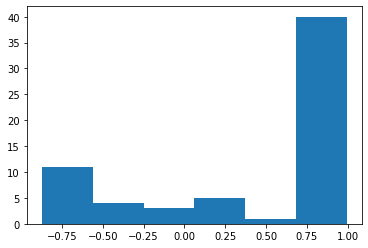

========== Epoch 0 Batch 127==== Step 2 Train Loss 0.7055736184120178 ======  0.40816326530612246
torch.Size([64, 48])
tensor([[-1.3200,  1.0510,  0.6014,  ...,  0.0297, -0.4826, -0.3896],
        [-1.0263,  1.2552,  0.3542,  ...,  0.0186, -0.0880, -0.5781],
        [-0.8313,  0.9267,  0.2940,  ...,  0.0815,  0.0583, -0.4111],
        ...,
        [-1.2982,  1.1451,  0.5844,  ...,  0.0090, -0.2458, -0.4737],
        [ 0.8838, -0.5037, -0.2511,  ...,  0.0599,  0.3533, -0.0494],
        [-1.4107,  1.1037,  0.4881,  ...,  0.0159, -0.7426, -0.2042]],
       device='cuda:0')
tensor([ 0.1500,  0.9841, -0.7717,  0.9687,  0.3240,  0.0559,  0.7812,  0.9716,
         0.9912,  0.9601,  0.3389,  0.9782,  0.9226, -0.1195,  0.8972,  0.9507,
        -0.4327,  0.7817,  0.9889,  0.2386,  0.5556,  0.9393,  0.8115,  0.1425,
         0.9896,  0.0491,  0.9441,  0.8762, -0.6143,  0.9847,  0.8964, -0.4584,
         0.0041,  0.9596,  0.8824,  0.9923,  0.9887,  0.8075,  0.9359,  0.6214,
         0.8420,  0.730

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


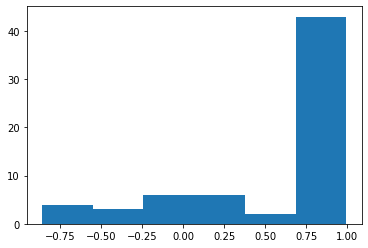

========== Epoch 0 Batch 128==== Step 2 Train Loss 0.7193157076835632 ======  0.4482758620689656
torch.Size([64, 48])
tensor([[-0.6917,  0.9628,  0.2721,  ..., -0.0549, -0.0926, -0.5986],
        [-1.5234,  1.0478,  0.6344,  ...,  0.0575, -0.6737, -0.2081],
        [-1.1239,  1.2301,  0.4535,  ...,  0.0948, -0.4713, -0.4432],
        ...,
        [-0.1860,  0.9814, -0.0823,  ..., -0.0246, -0.5255, -0.4431],
        [-0.8989,  1.3933,  0.4126,  ...,  0.0661, -0.3699, -0.3615],
        [-1.2760,  1.1292,  0.6219,  ..., -0.0763, -0.3256, -0.4322]],
       device='cuda:0')
tensor([ 0.6583,  0.9839,  0.9810,  0.9735,  0.1952,  0.9820, -0.8006,  0.9881,
         0.9643,  0.8895,  0.5834,  0.8905, -0.3084,  0.9943,  0.9646,  0.7318,
         0.9839,  0.7819,  0.9388, -0.1997,  0.9695,  0.7263,  0.8909, -0.7771,
         0.9252,  0.1904,  0.9876,  0.9218,  0.7981,  0.8104,  0.9723, -0.3690,
         0.8733,  0.2233,  0.9806,  0.9007,  0.1822,  0.8574,  0.9601,  0.9246,
        -0.7078, -0.0151

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


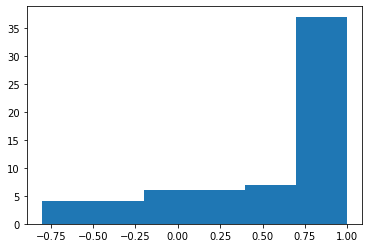

========== Epoch 0 Batch 129==== Step 2 Train Loss 0.6854904294013977 ======  0.36000000000000004
torch.Size([64, 48])
tensor([[ 5.3820e-01,  9.4640e-01, -4.9709e-02,  ..., -4.4307e-02,
         -2.0816e-01, -4.1490e-01],
        [-3.6518e-02,  8.0515e-01, -1.1191e-01,  ...,  9.8303e-02,
         -2.3371e-01, -3.4860e-01],
        [ 4.2170e-01, -9.4411e-01,  6.7909e-02,  ...,  2.1883e-01,
          6.2749e-01,  9.6894e-02],
        ...,
        [ 5.8982e-01,  8.8383e-01, -3.7515e-01,  ...,  1.5714e-01,
         -4.4977e-01, -3.7483e-01],
        [-9.1595e-01,  1.4036e+00,  5.1513e-01,  ..., -3.8131e-02,
         -2.8072e-01, -3.6923e-01],
        [-1.3078e+00,  9.3616e-01,  5.6553e-01,  ..., -9.5568e-04,
         -3.3426e-01, -3.9002e-01]], device='cuda:0')
tensor([ 0.7944,  0.6089, -0.5738,  0.4253,  0.8967,  0.8930, -0.3176,  0.9726,
         0.7139,  0.9838,  0.9737,  0.4199,  0.6316,  0.7854,  0.9909,  0.7565,
         0.9896,  0.0126, -0.6496,  0.3460, -0.2327,  0.9169,  0.9843,  

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


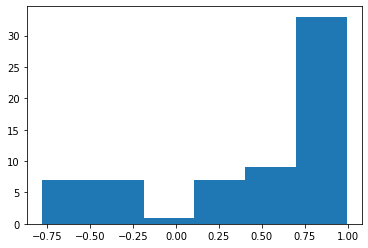

========== Epoch 0 Batch 130==== Step 2 Train Loss 0.7380703687667847 ======  0.2962962962962963
torch.Size([64, 48])
tensor([[ 0.7252, -0.4601, -0.0061,  ...,  0.0468,  0.6158, -0.0361],
        [-1.2558,  1.1673,  0.3576,  ..., -0.0415, -0.4248, -0.5587],
        [-1.2986,  1.0662,  0.3883,  ...,  0.1176, -0.5177, -0.2900],
        ...,
        [ 0.6242, -0.5360, -0.0182,  ...,  0.1521,  0.6371, -0.2428],
        [ 0.5075,  0.3922, -0.4368,  ...,  0.0763, -0.8062, -0.2098],
        [ 0.1742,  0.6754, -0.2077,  ...,  0.0399, -0.6339, -0.2681]],
       device='cuda:0')
tensor([ 0.9355,  0.7899,  0.9896,  0.8044,  0.9639,  0.5847,  0.9570, -0.3006,
         0.4245,  0.9743,  0.7128, -0.4316, -0.8836,  0.9669, -0.8545,  0.9770,
        -0.6562,  0.7833,  0.7538, -0.8973, -0.1589, -0.4233,  0.9207,  0.9813,
        -0.5249,  0.8890,  0.9720,  0.6865,  0.6284, -0.1217,  0.8876,  0.9786,
         0.4194, -0.0054,  0.9361,  0.1749,  0.9940,  0.7908,  0.9704,  0.9919,
         0.9478,  0.8293

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


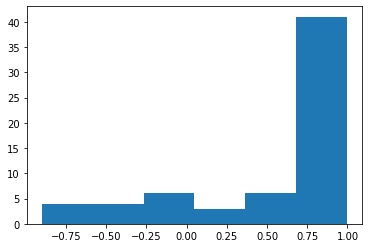

========== Epoch 0 Batch 131==== Step 2 Train Loss 0.708624005317688 ======  0.5
torch.Size([64, 48])
tensor([[-0.7102,  1.3389,  0.5039,  ...,  0.0935, -0.0590, -0.3563],
        [-1.3170,  1.0739,  0.5085,  ...,  0.0322, -0.6405, -0.3679],
        [-1.3352,  1.1677,  0.5116,  ...,  0.0272, -0.5507, -0.3725],
        ...,
        [ 0.4691, -0.8044,  0.1886,  ...,  0.2271,  0.7785, -0.0239],
        [ 0.3651, -0.8368, -0.0228,  ...,  0.1812,  0.3445,  0.1345],
        [-1.1309,  1.1055,  0.3674,  ...,  0.0069, -0.2851, -0.5010]],
       device='cuda:0')
tensor([ 0.9703,  0.9970, -0.2170,  0.9797,  0.9235,  0.9736, -0.7321,  0.7788,
        -0.2706,  0.4537, -0.0739, -0.8810,  0.9293,  0.8533, -0.1380, -0.7124,
         0.9851,  0.1554, -0.1598,  0.3912,  0.9923,  0.9879,  0.9271,  0.9576,
         0.9942,  0.9521, -0.3132,  0.0351,  0.9923,  0.9274,  0.9810,  0.7881,
         0.9746,  0.8394, -0.2488,  0.9699, -0.0708,  0.9261,  0.9871,  0.9363,
         0.8549,  0.5433,  0.9540,  0.97

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


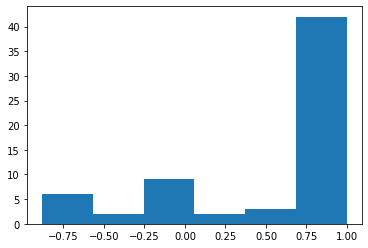

========== Epoch 0 Batch 132==== Step 2 Train Loss 0.6873115301132202 ======  0.4444444444444444
torch.Size([64, 48])
tensor([[-0.6857,  1.0146,  0.2045,  ..., -0.1150,  0.0984, -0.6723],
        [ 0.5507,  0.3994, -0.3819,  ...,  0.0731, -0.7399, -0.0767],
        [-0.0349,  0.7202, -0.0960,  ...,  0.0350, -0.2228, -0.3935],
        ...,
        [-1.3104,  1.0613,  0.6367,  ..., -0.0392, -0.2553, -0.4147],
        [ 0.3782,  0.1249, -0.2557,  ...,  0.3521, -0.8663, -0.2478],
        [-0.1552,  1.0605, -0.1490,  ...,  0.0434, -0.4132, -0.6567]],
       device='cuda:0')
tensor([ 0.6235,  0.9588,  0.9121,  0.8824,  0.6808,  0.9824, -0.2670,  0.6583,
         0.3463,  0.6243,  0.9740,  0.9524,  0.9586, -0.2753,  0.9264,  0.7547,
         0.6710,  0.9585,  0.9880,  0.0384,  0.9681,  0.9209,  0.5151,  0.9792,
         0.7656,  0.4260, -0.5601,  0.8986,  0.9585, -0.7053,  0.3050,  0.7390,
         0.7987,  0.9949,  0.9538, -0.7231, -0.8674,  0.9573,  0.9751, -0.2364,
         0.9695,  0.9697

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


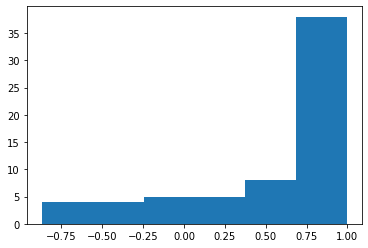

========== Epoch 0 Batch 133==== Step 2 Train Loss 0.7140077352523804 ======  0.339622641509434
torch.Size([64, 48])
tensor([[-1.3731,  1.0866,  0.5036,  ...,  0.0107, -0.6242, -0.3145],
        [ 0.7361, -0.0419, -0.1151,  ...,  0.0074,  0.4744, -0.3698],
        [-1.3170,  1.0739,  0.5085,  ...,  0.0322, -0.6405, -0.3679],
        ...,
        [ 0.6557, -0.6310, -0.0221,  ...,  0.2287,  0.6686, -0.1256],
        [ 0.4704,  0.2733, -0.2495,  ...,  0.0974, -0.5209, -0.0523],
        [ 0.8278,  0.0879, -0.1993,  ...,  0.0698,  0.2987, -0.3112]],
       device='cuda:0')
tensor([ 0.2233,  0.6523,  0.9929,  0.9925, -0.5687,  0.8915,  0.5834,  0.3473,
         0.8299,  0.8320,  0.6401,  0.9774,  0.0319,  0.7446, -0.1670, -0.1653,
         0.7141, -0.4745, -0.6848,  0.9888, -0.7613,  0.0646,  0.9342,  0.9954,
         0.4820,  0.9185,  0.9932, -0.7092, -0.1260, -0.3812,  0.4057,  0.0906,
         0.7637, -0.4909, -0.4429,  0.9555,  0.7357,  0.8762, -0.6506,  0.9444,
         0.4255,  0.9900,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


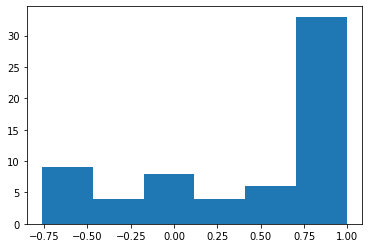

========== Epoch 0 Batch 134==== Step 2 Train Loss 0.6960758566856384 ======  0.42857142857142855
torch.Size([64, 48])
tensor([[-1.0123,  1.2382,  0.3965,  ..., -0.0490, -0.3938, -0.3546],
        [-0.7341,  1.1717,  0.4102,  ..., -0.0769, -0.3568, -0.4939],
        [-0.5509,  1.2220,  0.2296,  ..., -0.0422, -0.0240, -0.7031],
        ...,
        [ 0.5348, -0.0662, -0.4665,  ...,  0.2833, -0.9400, -0.1275],
        [ 0.3517,  1.0562, -0.2567,  ..., -0.0289, -0.4711, -0.3207],
        [-1.0377,  1.1186,  0.3893,  ...,  0.0325, -0.1161, -0.5927]],
       device='cuda:0')
tensor([-0.0953,  0.9367,  0.9599,  0.7982,  0.9938,  0.4602, -0.0380,  0.9469,
         0.9911,  0.9705, -0.6891,  0.0574,  0.9294, -0.2663,  0.7981,  0.6952,
         0.9809,  0.3515,  0.2006, -0.0113,  0.7924,  0.9471, -0.5700,  0.9457,
         0.5290, -0.2403, -0.6157,  0.9887,  0.9661,  0.9687,  0.2135,  0.9007,
        -0.4205, -0.6707,  0.9647,  0.7213, -0.5746,  0.8762,  0.9698, -0.1140,
         1.0000,  0.895

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


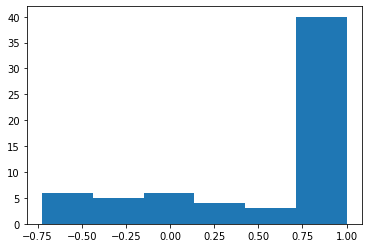

========== Epoch 0 Batch 135==== Step 2 Train Loss 0.7199146747589111 ======  0.2857142857142857
torch.Size([64, 48])
tensor([[ 0.5579,  0.2802, -0.4738,  ...,  0.1372, -0.7609, -0.1878],
        [ 0.2078,  0.7243, -0.0922,  ...,  0.0840, -0.2580, -0.2437],
        [-0.3224,  1.2290,  0.0317,  ..., -0.1354, -0.4267, -0.4288],
        ...,
        [-0.6855,  1.0726,  0.1944,  ...,  0.0835, -0.4580, -0.5436],
        [-1.3462,  1.1147,  0.5766,  ..., -0.0501, -0.2399, -0.4743],
        [-0.7564,  1.2050,  0.2498,  ..., -0.1190, -0.3366, -0.5061]],
       device='cuda:0')
tensor([ 0.1052,  0.5483,  0.8337,  0.9703,  0.6519,  0.6477,  0.9783,  0.9335,
         0.8652,  0.9423,  0.9275,  0.8763,  0.9928,  0.5494,  0.9695,  0.8352,
        -0.0706,  0.9836,  0.9898, -0.1247,  0.2462,  0.7946,  0.4953,  0.9693,
        -0.0520, -0.8138, -0.0447,  0.8256,  0.9516,  0.9605, -0.5515,  0.9930,
         0.9759,  0.7318,  0.9581,  0.9691,  0.9725,  0.9190,  0.1967,  0.9861,
         0.9774, -0.0397

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


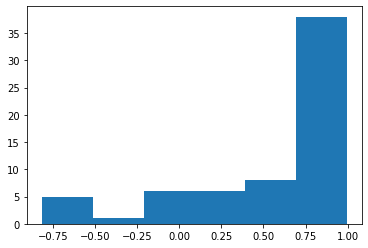

========== Epoch 0 Batch 136==== Step 2 Train Loss 0.7245652675628662 ======  0.4067796610169491
torch.Size([64, 48])
tensor([[ 0.4232, -0.8927,  0.0313,  ...,  0.1150,  0.5829,  0.0558],
        [-1.2788,  1.0906,  0.5091,  ..., -0.0722, -0.2141, -0.4788],
        [ 0.6224, -0.5825,  0.0156,  ...,  0.1775,  0.7018, -0.1850],
        ...,
        [ 0.4398,  0.2132, -0.4839,  ...,  0.1051, -0.9034,  0.0118],
        [-0.9953,  1.3825,  0.5212,  ...,  0.0339, -0.1526, -0.4483],
        [-0.9852,  1.1821,  0.2202,  ..., -0.0543, -0.3842, -0.6609]],
       device='cuda:0')
tensor([ 0.8369,  0.9733, -0.2395,  0.1706,  0.9791, -0.2508, -0.4855,  0.4620,
        -0.5190,  0.9903,  0.9628, -0.1839, -0.4435,  0.3772,  0.9727,  0.9918,
         0.7218, -0.8545,  0.9704,  0.4033,  0.9298, -0.7850,  0.9782,  0.8029,
         0.8793,  0.9337,  0.7135,  0.9654,  0.9206,  0.9789,  0.9950, -0.6127,
         0.9844,  0.5591,  0.8568, -0.0850, -0.5726,  0.8809,  0.9848,  0.9710,
        -0.7274,  0.9511

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


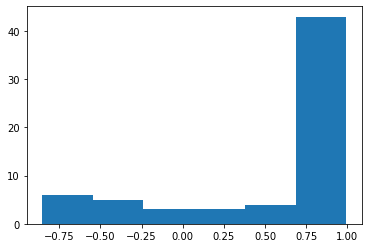

========== Epoch 0 Batch 137==== Step 2 Train Loss 0.6968441009521484 ======  0.4642857142857143
torch.Size([64, 48])
tensor([[-1.2710,  1.0923,  0.4392,  ...,  0.0119, -0.5537, -0.3883],
        [ 0.9904,  0.0765,  0.0468,  ...,  0.0635,  0.4033, -0.1051],
        [-1.5528,  0.9868,  0.6148,  ...,  0.0784, -0.6554, -0.2778],
        ...,
        [-1.3555,  1.0751,  0.5338,  ...,  0.0804, -0.6597, -0.2875],
        [ 0.5082,  0.4068, -0.3802,  ...,  0.3840, -0.7093, -0.3536],
        [ 0.5941, -0.4109,  0.0466,  ...,  0.0364,  0.6148, -0.0963]],
       device='cuda:0')
tensor([ 0.9228,  0.8087,  0.9855,  0.9934,  0.6384,  0.9700, -0.1791,  0.8825,
         0.7740,  0.9729, -0.2943,  0.9936,  0.9911,  0.9006,  0.9912,  0.8617,
         0.9036,  0.9826,  0.9904, -0.2287,  0.9917, -0.2153, -0.7446,  0.9710,
         0.0459,  0.9807,  0.9811,  0.9890,  0.4173, -0.6335,  0.9626,  0.9500,
        -0.7004,  0.9432,  0.4820, -0.7977,  0.7899, -0.4732,  0.9859,  0.6599,
         0.9930,  0.9746

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


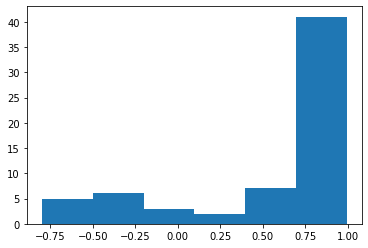

========== Epoch 0 Batch 138==== Step 2 Train Loss 0.7020964622497559 ======  0.4074074074074074
torch.Size([64, 48])
tensor([[-1.0031e+00,  9.2893e-01,  3.5009e-01,  ..., -5.6363e-02,
         -2.3959e-01, -4.7078e-01],
        [-1.1165e+00,  1.0646e+00,  5.7593e-01,  ...,  4.9428e-04,
         -2.0331e-01, -3.4027e-01],
        [-1.4107e+00,  1.1037e+00,  4.8814e-01,  ...,  1.5879e-02,
         -7.4265e-01, -2.0417e-01],
        ...,
        [-2.2486e-01,  9.5080e-01, -1.8573e-01,  ...,  9.3263e-02,
         -5.0209e-01, -6.4058e-01],
        [ 1.9257e-01,  1.8080e-01, -2.0716e-01,  ...,  1.9050e-01,
         -7.9082e-01, -1.1393e-01],
        [-1.2688e+00,  1.0855e+00,  6.0170e-01,  ..., -1.8337e-02,
         -2.8322e-01, -3.6021e-01]], device='cuda:0')
tensor([-0.6203, -0.0563, -0.4435,  0.6413, -0.8779,  0.8157, -0.8421,  0.6999,
        -0.7445,  0.5896,  0.7625, -0.2677,  0.8960,  0.3558, -0.0062,  0.2957,
         0.3847,  0.9357, -0.1149,  0.7237,  0.9896, -0.6479,  0.9559,  0

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


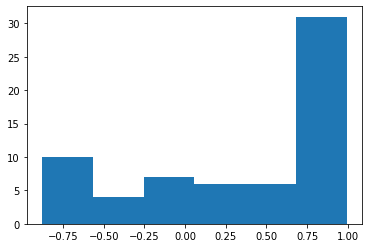

========== Epoch 0 Batch 139==== Step 2 Train Loss 0.7081156969070435 ======  0.3529411764705882
torch.Size([64, 48])
tensor([[ 0.3831,  0.7676, -0.3136,  ..., -0.0054, -0.5800, -0.3450],
        [-0.3321,  0.8602, -0.1449,  ..., -0.1059, -0.3062, -0.6540],
        [-1.4209,  0.9922,  0.4254,  ...,  0.0422, -0.6627, -0.4782],
        ...,
        [-1.0414,  1.3739,  0.6016,  ...,  0.0296, -0.2668, -0.3415],
        [-1.4876,  1.0979,  0.5174,  ...,  0.0869, -0.6326, -0.4616],
        [ 0.4774,  0.2584, -0.0378,  ..., -0.0413,  0.3429, -0.3216]],
       device='cuda:0')
tensor([ 0.9521,  0.7738,  0.9954,  0.9497,  0.9881, -0.4487,  0.1626,  0.0679,
        -0.2606, -0.4595, -0.1023,  0.6932, -0.1009,  0.1573,  0.4903,  0.8330,
         0.0726,  0.8808,  0.7955,  0.9834,  0.9598,  0.2117,  0.9275, -0.4972,
         0.9605,  0.7314,  0.9430, -0.5793,  0.9293,  0.1029, -0.4209,  0.9783,
         0.9779,  0.8290,  0.9696,  0.9803,  0.6935,  0.4726, -0.4684,  0.9665,
         0.8774,  0.0319

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


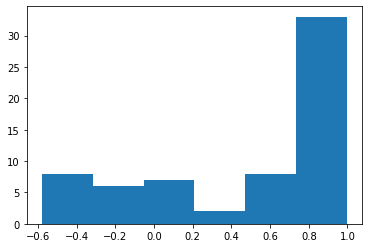

========== Epoch 0 Batch 140==== Step 2 Train Loss 0.7243386507034302 ======  0.2553191489361702
torch.Size([64, 48])
tensor([[ 0.4815,  0.2858, -0.4466,  ...,  0.1091, -0.7968,  0.0141],
        [ 0.4131,  0.3238, -0.2471,  ...,  0.2179, -0.3592, -0.2757],
        [ 0.6625, -0.3848,  0.0234,  ..., -0.0880,  0.3119,  0.1919],
        ...,
        [-1.1707,  1.3597,  0.4744,  ...,  0.0482, -0.1981, -0.3794],
        [ 0.4073,  0.5618, -0.3719,  ...,  0.1893, -0.3844, -0.2963],
        [ 0.3910,  0.3610, -0.2484,  ...,  0.2830, -0.5612, -0.3109]],
       device='cuda:0')
tensor([ 0.6703,  0.8722,  0.9243,  0.9654, -0.2028, -0.5295,  0.2286,  0.7497,
        -0.8004,  0.6184,  0.9926, -0.0926,  0.9735,  0.9836,  0.9514,  0.4743,
         0.9772,  0.9689,  0.7527,  0.9884, -0.1534,  0.9657,  0.0960,  0.1356,
         0.9868,  0.2698,  0.7625,  0.3939, -0.2220, -0.0567,  0.1701,  0.9037,
         0.9885,  0.9304,  0.9848, -0.8031,  0.9978,  0.4005,  0.3495, -0.3672,
        -0.6358,  0.1062

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


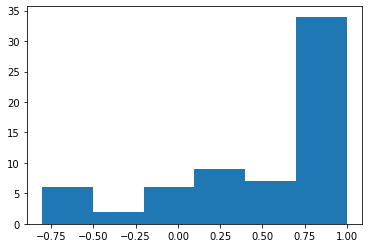

========== Epoch 0 Batch 141==== Step 2 Train Loss 0.7032139897346497 ======  0.4333333333333333
torch.Size([64, 48])
tensor([[-1.4876,  1.0979,  0.5174,  ...,  0.0869, -0.6326, -0.4616],
        [ 0.5879,  0.6573,  0.1080,  ...,  0.0852,  0.3797, -0.3759],
        [ 0.4015,  0.1139,  0.1180,  ..., -0.0792,  0.5543, -0.4007],
        ...,
        [-1.0031,  0.9289,  0.3501,  ..., -0.0564, -0.2396, -0.4708],
        [ 0.3634,  0.9243,  0.0975,  ...,  0.0402,  0.2380, -0.5014],
        [-1.0635,  1.0076,  0.6500,  ...,  0.0580, -0.1965, -0.4029]],
       device='cuda:0')
tensor([-0.7122,  0.8050, -0.2626,  0.9631,  0.9348,  0.4863,  0.9508,  0.7037,
        -0.2363,  0.9000,  0.9273, -0.4570,  0.8663,  0.4602,  0.0194,  0.9868,
         0.9043,  0.9710, -0.2005,  0.9452,  0.9414,  0.9732,  0.6637, -0.4188,
        -0.0778,  0.9550, -0.4197, -0.6190,  0.9614,  0.9753, -0.7704, -0.3599,
         0.8756,  0.9852,  0.9915,  0.8786,  0.8555,  0.6792,  0.8971, -0.0943,
        -0.0885,  0.9864

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


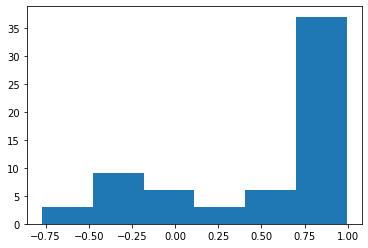

========== Epoch 0 Batch 142==== Step 2 Train Loss 0.69282066822052 ======  0.3529411764705882
torch.Size([64, 48])
tensor([[ 0.4073,  0.5618, -0.3719,  ...,  0.1893, -0.3844, -0.2963],
        [-1.3962,  1.1124,  0.5396,  ...,  0.1115, -0.6507, -0.3063],
        [-0.5568,  1.2106,  0.1859,  ..., -0.1740, -0.0663, -0.4090],
        ...,
        [-1.2986,  1.0662,  0.3883,  ...,  0.1176, -0.5177, -0.2900],
        [-0.5568,  1.0923,  0.2305,  ...,  0.0321, -0.2401, -0.5229],
        [-1.2786,  0.9488,  0.5772,  ..., -0.0457, -0.2610, -0.4052]],
       device='cuda:0')
tensor([ 0.7923,  0.3537,  0.9413,  0.8555,  0.8553,  0.8671,  0.1757, -0.4132,
         0.9914,  0.9849, -0.1091,  0.9773,  0.9455,  0.2306,  0.5843,  0.9418,
         0.9862,  0.9866,  0.9868, -0.0545,  0.9534,  0.5937, -0.1599,  0.0222,
         0.8839,  0.9906,  0.9875,  0.9820,  0.9092,  0.8598,  0.5431, -0.2497,
        -0.4196,  0.9476,  0.9031,  0.5881,  0.6980, -0.0124,  0.9936,  0.6392,
        -0.5593, -0.0042, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


KeyboardInterrupt: ignored

In [ ]:
modelCLS = myModelFC()
mytrainStep2(modelCLS,criterion1,criterion2,modelEmb)

# Test

In [8]:
def binarize(y, threshold=0.5):
    y = np.array(y)
    y = np.ma.fix_invalid(y, fill_value=threshold)
    y[y >= threshold] = 1
    y[y < threshold] = 0

    return y


def auc(true_y, pred_y):
    """
    Calculates the AUC score (Area Under the Curve), a well-known
    scalar evaluation score for binary classifiers. This score
    also considers "unanswered" problem, where score = 0.5.
    Parameters
    ----------
    prediction_scores : array [n_problems]
        The predictions outputted by a verification system.
        Assumes `0 >= prediction <=1`.
    ground_truth_scores : array [n_problems]
        The gold annotations provided for each problem.
        Will typically be `0` or `1`.
    Returns
    ----------
    auc = the Area Under the Curve.
    References
    ----------
        E. Stamatatos, et al. Overview of the Author Identification
        Task at PAN 2014. CLEF (Working Notes) 2014: 877-897.
    """
    try:
        return roc_auc_score(true_y, pred_y)
    except ValueError:
        return 0.0


def c_at_1(true_y, pred_y, threshold=0.5):
    """
    Calculates the c@1 score, an evaluation method specific to the
    PAN competition. This method rewards predictions which leave
    some problems unanswered (score = 0.5). See:
        A. Peñas and A. Rodrigo. A Simple Measure to Assess Nonresponse.
        In Proc. of the 49th Annual Meeting of the Association for
        Computational Linguistics, Vol. 1, pages 1415-1424, 2011.
    Parameters
    ----------
    prediction_scores : array [n_problems]
        The predictions outputted by a verification system.
        Assumes `0 >= prediction <=1`.
    ground_truth_scores : array [n_problems]
        The gold annotations provided for each problem.
        Will always be `0` or `1`.
    Returns
    ----------
    c@1 = the c@1 measure (which accounts for unanswered
        problems.)
    References
    ----------
        - E. Stamatatos, et al. Overview of the Author Identification
        Task at PAN 2014. CLEF (Working Notes) 2014: 877-897.
        - A. Peñas and A. Rodrigo. A Simple Measure to Assess Nonresponse.
        In Proc. of the 49th Annual Meeting of the Association for
        Computational Linguistics, Vol. 1, pages 1415-1424, 2011.
    """

    n = float(len(pred_y))
    nc, nu = 0.0, 0.0

    for gt_score, pred_score in zip(true_y, pred_y):
        if pred_score == 0.5 or (pred_score >= 0.50 and pred_score <= 0.51):
            nu += 1
        elif (pred_score > 0.5) == (gt_score > 0.5):
            nc += 1.0

    return (1 / n) * (nc + (nu * nc / n))


def f1(true_y, pred_y):
    """
    Assesses verification performance, assuming that every
    `score > 0.5` represents a same-author pair decision.
    Note that all non-decisions (scores == 0.5) are ignored
    by this metric.
    Parameters
    ----------
    prediction_scores : array [n_problems]
        The predictions outputted by a verification system.
        Assumes `0 >= prediction <=1`.
    ground_truth_scores : array [n_problems]
        The gold annotations provided for each problem.
        Will typically be `0` or `1`.
    Returns
    ----------
    acc = The number of correct attributions.
    References
    ----------
        E. Stamatatos, et al. Overview of the Author Identification
        Task at PAN 2014. CLEF (Working Notes) 2014: 877-897.
    """
    true_y_filtered, pred_y_filtered = [], []

    for true, pred in zip(true_y, pred_y):
        if pred != 0.5:
            true_y_filtered.append(true)
            pred_y_filtered.append(pred)

    pred_y_filtered = binarize(pred_y_filtered)

    return f1_score(true_y_filtered, pred_y_filtered)


def f_05_u_score(true_y, pred_y, pos_label=1, threshold=0.5):
    """
    Return F0.5u score of prediction.
    :param true_y: true labels
    :param pred_y: predicted labels
    :param threshold: indication for non-decisions (default = 0.5)
    :param pos_label: positive class label (default = 1)
    :return: F0.5u score
    """

    pred_y = binarize(pred_y)

    n_tp = 0
    n_fn = 0
    n_fp = 0
    n_u = 0

    for i, pred in enumerate(pred_y):
        if pred == threshold:
            n_u += 1
        elif pred == pos_label and pred == true_y[i]:
            n_tp += 1
        elif pred == pos_label and pred != true_y[i]:
            n_fp += 1
        elif true_y[i] == pos_label and pred != true_y[i]:
            n_fn += 1

    return (1.25 * n_tp) / (1.25 * n_tp + 0.25 * (n_fn + n_u) + n_fp)


In [19]:
from sklearn import metrics
import tabulate
!pip install mlflow
import mlflow
class ContrastiveChunkerEvaluator:

    def __init__(self, test_dataset, distance_metric,
                 threshold: float = 0.5, find_threshold: bool = False):
        self.test_dataset = test_dataset
        self.distance_metric = distance_metric  # lambda x, y: 1-F.cosine_similarity(x, y)
        
        self.threshold = threshold
        self.find_threshold = find_threshold
        

    def call(self, model, epoch: int = -1, steps: int = -1) -> (float,float):

        # just encode all of the samples, then use some comparison to determine if they are the same or different?
        # Can I just wrap this with the contrastive loss thing somehow? I think so, try it

      
        print('evaluating')
        
        truth = []
        emb1, emb2 = [], []
        ids = []
        with torch.no_grad():
            for input1, mask1, input2, mask2,target1,id in tqdm(self.test_dataset):
                b_input_ids1 = input1[0].to(device)
                b_input_mask1 = mask1[0].to(device)
                label = target1[0].type(torch.LongTensor)
                b_input_ids2 = input2[0].to(device)
                b_input_mask2 = mask2[0].to(device)
                b_labels = label.to(device)
                h = modelEmb.init_hidden(b_input_ids1.size(0))
                FC11 = modelEmb(b_input_ids1, b_input_mask1,h)
                FC22 = modelEmb(b_input_ids2, b_input_mask2,h)
                FC11=FC11.mean(0)
                FC22=FC22.mean(0)
                emb1.append(FC11)
                emb2.append(FC22)
                truth.append(b_labels[0].cpu().data.numpy())
                ids.append(id)

            # at this point, we have two lists of embeddings. We want to compare each embeddings, elementwise, to
            # determine if they were written by the same author or not (i.e. get the distance between them)
            # we also want to keep track of all of them for a ranking?
            
            predictions = self.distance_metric(torch.stack(emb1), torch.stack(emb2))
            print(predictions)
            print(ids)
        # need to add some calibration here - especially using eucledian as the output magnitude will be quite different
        # the predictions here are good I think, but they need to be changed to a similarity score, for now just do this by max(x) - x
        similarities =  predictions #torch.max(predictions) -
        normalized_similarities = similarities/torch.max(similarities)
        
        
        # normalized_similarities = (1 + similarities) / 2
        # print(normalized_similarities)
        normalized_similarities = normalized_similarities.cpu().data.numpy()
        # for now, just assume 50% same auth and 50% different auth - this seems like cheating but what can you do?
        # threshold = sorted(normalized_similarities)[int(len(normalized_similarities)/2)]
        threshold = self.threshold

        if self.find_threshold:
            # save this numpy array for testing later
            # print('saving similairities and truth values')
            # np.save('sims' + self.name + '.npy', normalized_similarities)

            # np.save('truth' + self.name + '.npy', np.array(truth))
            # print('predictions saved')

            # first plot the score distribution: how do we make a histogram here?
            pos_data, neg_data = [], []
            for sim, lbl in zip(normalized_similarities, truth):
                if lbl == 1:
                    pos_data.append(sim)
                elif lbl == 0:
                    neg_data.append(sim)
                else:
                    assert False, 'problems'

            plt.hist(pos_data, bins=25, alpha=0.5, label='same_author')
            plt.hist(neg_data, bins=25, alpha=0.5, label='diff_author')
            plt.title('Score distributions for same and different author pairs')
            plt.xlabel('score')
            plt.ylabel('count')
            plt.show()
            # plt.savefig('hist_differences')
            fpr, tpr, threshold = metrics.roc_curve(truth, normalized_similarities,pos_label=1)
            roc_auc = metrics.auc(fpr, tpr)
            # print(f'AUC: {roc_auc:.4f}')
            # Plot ROC AUC
            # plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()
            # set some ranges to sweep, and shuffle them - maybe see more interesting results before hand?
            all_thresholds = [x for x in np.linspace(0.0001, 1, 100)]
            all_possible_scores = []
            for threshold in all_thresholds:
                results = {
                    'auc': metrics.roc_auc_score(truth, normalized_similarities),
                    'c@1': c_at_1(truth, normalized_similarities, threshold),
                    'f_05_u': f_05_u_score(truth, normalized_similarities, threshold=threshold),
                    'F1': f1(truth, normalized_similarities)
                }
                
                results['overall'] = np.mean(list(results.values()))
                binarized_predictions = binarize(normalized_similarities, threshold)
                correct_predictions = [1 if x == y else 0 for x, y in zip(truth, binarized_predictions)]
                results['accuracy'] = sum(correct_predictions) / len(correct_predictions)

                all_possible_scores.append((threshold, results))
            # now log all of the results to mlflow
            best_auc = [0, 0]
            best_acc = [0, 0]
            best_overall = [0, 0]
            best_f05 = [0, 0]
            best_ca1 = [0, 0]
            best_f1 = [0, 0]
            for thresh, res in all_possible_scores:
                mlflow.log_metric('threshtest/accuracy', res['accuracy'], step=int(1000*thresh))
                mlflow.log_metric('threshtest/auc', res['auc'], step=int(1000*thresh))
                mlflow.log_metric('threshtest/ca1', res['c@1'], step=int(1000*thresh))
                mlflow.log_metric('threshtest/f_05_u', res['f_05_u'], step=int(1000*thresh))
                mlflow.log_metric('threshtest/F1', res['F1'], step=int(1000*thresh))
                mlflow.log_metric('threshtest/overall', res['overall'], step=int(1000*thresh))

                # track optimal measures
                best_auc = best_auc if best_auc[0] > res['auc'] else [res['auc'], thresh]
                best_acc = best_acc if best_acc[0] > res['accuracy'] else [res['accuracy'], thresh]
                best_overall = best_overall if best_overall[0] > res['overall'] else [res['overall'], thresh]
                best_f05 = best_f05 if best_f05[0] > res['f_05_u'] else [res['f_05_u'], thresh]
                best_ca1 = best_ca1 if best_ca1[0] > res['c@1'] else [res['c@1'], thresh]
                best_f1 = best_f1 if best_f1[0] > res['F1'] else [res['F1'], thresh]

            mlflow.log_metric('threshtest/opt_accuracy', best_acc[0], step=int(1000*best_acc[1]))
            mlflow.log_metric('threshtest/opt_auc', best_auc[0], step=int(1000*best_auc[1]))
            mlflow.log_metric('threshtest/opt_ca1', best_ca1[0], step=int(1000*best_ca1[1]))
            mlflow.log_metric('threshtest/opt_f_05_u', best_f05[0], step=int(1000*best_f05[1]))
            mlflow.log_metric('threshtest/opt_F1', best_f1[0], step=int(1000*best_f1[1]))
            mlflow.log_metric('threshtest/opt_overall', best_overall[0], step=int(1000*best_overall[1]))
            print(f"accuracy: {best_acc}, auc: {best_auc}, c@1: {best_ca1}, f_05_u: {best_f05}, F1: {best_f1}, overall: {best_overall}")

            return best_acc,best_f1#best_auc

        # now select best threshold for final reporting?

        binarized_predictions = binarize(normalized_similarities, threshold)

        # this doesn't work with raw scores
        # results = eval_metrics.evaluate_all(truth, binarized_predictions)
        # for now just give raw distances as input
        results = {
            'auc': metrics.roc_auc_score(truth, normalized_similarities),
            'c@1': c_at_1(truth, normalized_similarities, threshold),
            'f_05_u': f_05_u_score(truth, normalized_similarities, threshold=threshold),
            'F1': f1(truth, normalized_similarities)
        }
        results['overall'] = np.mean(list(results.values()))

        correct_predictions = [1 if x == y else 0 for x, y in zip(truth, binarized_predictions)]
        results['accuracy'] = sum(correct_predictions)/len(correct_predictions)
        
        # print(f'Evaluation took {time.time() - start_time} seconds. Scores at step {steps} and epoch {epoch} are:')
        
        print(f"accuracy: {results['accuracy']}, auc: {results['auc']}, c@1: {results['c@1']}, f_05_u: {results['f_05_u']}, F1: {results['F1']}, overall: {results['overall']}")

        try:
            if epoch > -1:
                log_step = epoch
            elif isinstance(steps, int):
                log_step = steps
            elif isinstance(steps, list):
                log_step = steps[-1]
            else:
                log_step = -1

            mlflow.log_metric('accuracy', results['accuracy'], step=log_step)
            mlflow.log_metric('auc', results['auc'], step=log_step)
            mlflow.log_metric('ca1', results['c@1'], step=log_step)
            mlflow.log_metric('f_05_u', results['f_05_u'], step=log_step)
            mlflow.log_metric('F1', results['F1'], step=log_step)
            mlflow.log_metric('overall', results['overall'], step=log_step)

        except Exception as e:
            print('exception trying to log metrics')
            print(e)

        return results#results['auc'],results['accuracy']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


evaluating


100%|██████████| 289/289 [00:41<00:00,  6.88it/s]


tensor([0.8566, 0.8138, 0.9269, 0.8471, 0.7485, 0.7225, 0.8393, 0.8662, 0.6347,
        0.7895, 0.8566, 0.8383, 0.9263, 0.7675, 0.9231, 0.8855, 0.7580, 0.8874,
        0.6617, 0.7136, 0.7444, 0.8199, 0.7534, 0.7647, 0.8758, 0.7780, 0.8395,
        0.8422, 0.8948, 0.8121, 0.9142, 0.8939, 0.7480, 0.6938, 0.8676, 0.8531,
        0.9065, 0.7115, 0.8184, 0.8814, 0.7507, 0.7345, 0.9176, 0.8070, 0.9077,
        0.8608, 0.9099, 0.8510, 0.8017, 0.9176, 0.8121, 0.8669, 0.8859, 0.7639,
        0.7358, 0.8412, 0.8335, 0.9142, 0.7856, 0.8883, 0.8062, 0.7239, 0.7410,
        0.8434, 0.8471, 0.8124, 0.8186, 0.6936, 0.7897, 0.7811, 0.7480, 0.8103,
        0.8183, 0.8183, 0.8838, 0.7462, 0.7548, 0.8919, 0.7233, 0.9076, 0.8221,
        0.8526, 0.6938, 0.8814, 0.7609, 0.7997, 0.9176, 0.7315, 0.8501, 0.7895,
        0.7580, 0.7896, 0.6857, 0.7111, 0.7864, 0.7680, 0.7315, 0.8855, 0.8782,
        0.8183, 0.8731, 0.7835, 0.7214, 0.7055, 0.6922, 0.7499, 0.6857, 0.8108,
        0.7462, 0.7913, 0.7896, 0.8477, 

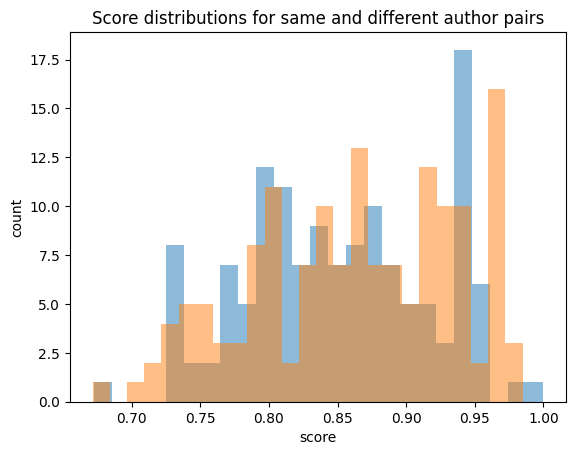

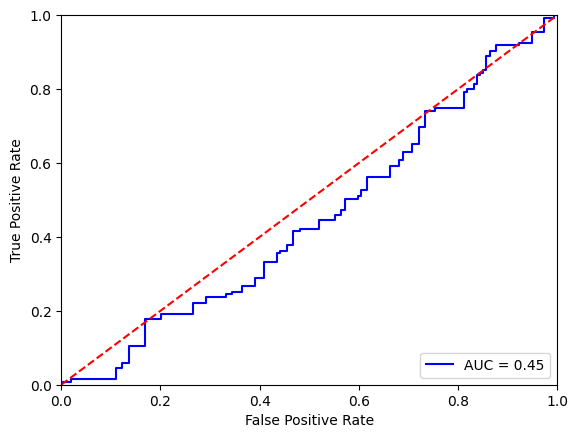

accuracy: [0.5363321799307958, 1.0], auc: [0.4494949494949495, 1.0], c@1: [0.4671280276816609, 1.0], f_05_u: [0.52285050348567, 0.9899], F1: [0.6367924528301887, 1.0], overall: [0.5190664833731172, 0.9899]
([0.5363321799307958, 1.0], [0.6367924528301887, 1.0])


In [20]:
from tqdm import tqdm
# modelEmb.cuda()
evaluator = ContrastiveChunkerEvaluator(test_dataloader,torch.nn.CosineSimilarity(),find_threshold=True,threshold=0.80)
all_results = evaluator.call(modelEmb)
print(all_results)


evaluating


100%|██████████| 201/201 [00:57<00:00,  3.49it/s]


tensor([-0.1884,  0.5195,  0.9705,  0.9163, -0.3123,  0.7654,  0.7308,  0.5057,
        -0.1642,  0.0794,  0.6466, -0.2823,  0.6979,  0.0540,  0.4567,  0.4132,
        -0.2784,  0.5461, -0.1018, -0.1326,  0.9096,  0.9173,  0.4475,  0.2384,
         0.2709,  0.5235,  0.9401, -0.1455,  0.3382, -0.2723,  0.2054, -0.2824,
         0.2159,  0.1219,  0.2785, -0.2670,  0.5083,  0.2246,  0.5927,  0.4044,
         0.0129,  0.6228, -0.3231,  0.1413,  0.7412,  0.0964,  0.3845,  0.1082,
         0.0587, -0.2091,  0.7739,  0.6461,  0.5741, -0.1842,  0.2684, -0.1410,
         0.8726,  0.1487,  0.2178,  0.7117,  0.3322,  0.3915,  0.1807, -0.0976,
         0.3309,  0.2163,  0.4321,  0.4526,  0.6603,  0.3251,  0.8365, -0.2743,
        -0.1953, -0.3932,  0.3394,  0.7096,  0.3351, -0.1405, -0.0304, -0.2603,
         0.1418,  0.2490,  0.6338,  0.3732, -0.1104, -0.2126,  0.9414,  0.5836,
         0.2912,  0.2019,  0.7411,  0.9771,  0.4062, -0.3014,  0.6244,  0.4269,
         0.8443,  0.0090,  0.6897,  0.41

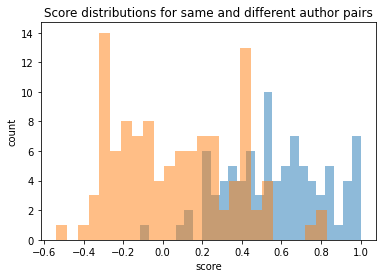

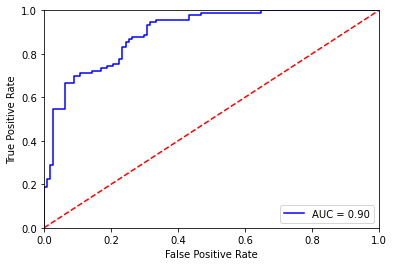

accuracy: [0.8159203980099502, 0.45459999999999995], auc: [0.8964964964964965, 1.0], c@1: [0.7960199004975124, 1.0], f_05_u: [0.8187134502923976, 0.9899], F1: [0.7320261437908496, 1.0], overall: [0.8108139977693141, 0.9899]
([0.8159203980099502, 0.45459999999999995], [0.7320261437908496, 1.0])


In [ ]:
from tqdm import tqdm
modelEmb.cuda()
evaluator2 = ContrastiveChunkerEvaluator(test_dataloader2,torch.nn.CosineSimilarity(),find_threshold=False)
all_results = evaluator2.call(modelEmb)
print(all_results)

In [ ]:
metr = getPickleFileInDict('test_results_pan20')
print(all_results)
# print(roc)


([0.7549668874172185, 0.5657], [0.7826086956521738, 1.0])


In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds_probs = probs[:, 1].cpu().data.numpy()
    print(probs)
    preds = probs.argmax(1).cpu().data.numpy()
    y_true = y_true.cpu().data.numpy()
    fpr, tpr, threshold = roc_curve(y_true, preds_probs,pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f'Accuracy: {accuracy*100:.2f}%')
    print(f'F1-score: {f1*100:.2f}%')
    # Plot ROC AUC
    # plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
from sklearn.metrics import brier_score_loss
def calcBrier(probs,y_true):
  # predict probabilities
  preds = probs[:, 1]
  # keep the predictions for class 1 only
  
  # calculate bier score
  loss = brier_score_loss(y_true, preds)
  return loss

In [ ]:
def getTensors(cosine,label):
  print(cosine)
  pred = torch.relu(cosine)
  # print(pred)
  # print(torch.sigmoid(cosine))
  # print(label)
  if label==1:
    #  gt = torch.cat((1-label,label),dim=1).to(device)
     if pred == torch.Tensor([0.0]).to(device): #means negative cosine
        # if torch.sigmoid(cosine) > (1-torch.sigmoid(cosine)):
        #    pred = torch.cat((torch.sigmoid(cosine),1-torch.sigmoid(cosine)),dim=0) 
        # else:
        #    pred = torch.cat((1-torch.sigmoid(cosine),torch.sigmoid(cosine)),dim=0)
        pred = torch.cat((1-torch.sigmoid(cosine),torch.sigmoid(cosine)),dim=0)
        
     else:
        # if torch.sigmoid(cosine) > (1-torch.sigmoid(cosine)):
        #    pred = torch.cat((1-cosine,cosine),dim=0)  
        # else:
        #    pred = torch.cat((cosine,1-cosine),dim=0)
        pred = torch.cat((1-torch.sigmoid(torch.Tensor([1])),torch.sigmoid(torch.Tensor([1]))),dim=0)
  else:
    #  gt = torch.cat((label,1-label),dim=1).to(device)
     if pred == torch.Tensor([0.0]).to(device): #means negative cosine
        # if torch.sigmoid(cosine) > (1-torch.sigmoid(cosine)):
        #    pred = torch.cat((cosine,1-cosine),dim=0) 
        # else:
        #    pred = torch.cat((1-cosine,cosine),dim=0)
        pred = torch.cat((torch.sigmoid(torch.Tensor([1])),(1-torch.sigmoid(torch.Tensor([1])) ) ),dim=0)
        
     else:
        # if torch.sigmoid(cosine) > (1-torch.sigmoid(cosine)):
        #    pred = torch.cat((1-torch.sigmoid(cosine),torch.sigmoid(cosine)),dim=0)  
        # else:
        #    pred = torch.cat((torch.sigmoid(cosine),1-torch.sigmoid(cosine)),dim=0)
        pred = torch.cat((torch.sigmoid(cosine),1-torch.sigmoid(cosine)),dim=0)
  
  return pred,label

from sklearn.metrics import accuracy_score


def calc_accuracy_f1(preds,labels):
    labels = labels.cpu().data.numpy()
    pred = preds.argmax(1).cpu().data.numpy()
    accuracy = accuracy_score(labels, pred)#(torch.sum(preds == labels) )/len(preds)

    f1 = f1_score(labels, pred, average='macro')
    return accuracy,f1

In [ ]:
import torch.nn.functional as F
# f1scores = list()
def bert_predict( modelEmb, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    # modelCLS.cuda()
    modelEmb.cuda()
    modelEmb.eval()
    # modelCLS.eval()
    all_logits = []
    f1scores = 0
    # For each batch in our test set...
    step = 0
    target_label = []
    accs = 0
    for input1, mask1, input2, mask2,target1 in test_dataloader:#validation_dataloader:
        # print(batch[0].permute(0,2,1).squeeze(2).shape)
        # print(batch[1])
        # print(batch[2])
        step+=1
        # print(input1)
        # Load batch to GPU
        b_input_ids1 = input1[0].to(device)
        b_input_mask1 = mask1[0].to(device)
        label = target1[0].type(torch.LongTensor)
        b_input_ids2 = input2[0].to(device)
        b_input_mask2 = mask2[0].to(device)
        # label = label.type(torch.LongTensor)
        b_labels = label.to(device)
        # print(b_labels)
        # print(b_input_ids1)
        h = modelEmb.init_hidden(b_input_ids1.size(0))
        # b_labels = torch.squeeze(b_labels,1)
        # b_input_ids2 = input_id2.to(device)
        # b_input_mask2 = mask2.to(device)
        # step += 1
        # print("Batch ",str(step), " from ", str(len(test_dataloader)))
        # Compute logits
        with torch.no_grad():
            FC11 = modelEmb(b_input_ids1, b_input_mask1,h)
            FC22 = modelEmb(b_input_ids2, b_input_mask2,h)
            # out = modelCLS(out1,out2)
        FC11 = FC11.mean(0)
        FC22 = FC22.mean(0)
       
        out = F.cosine_similarity(FC11,FC22,dim=0)
        print(out)
        print(b_labels)
        # pred,target = getTensors(out.unsqueeze(0),b_labels[0])
        
        # all_logits.append(pred.to(device))
        # target_label.append(target.to(device))
        # f1 = calcF1score(F.sigmoid(out.unsqueeze(0)), b_labels[0].unsqueeze(0))
    #     acc = calcAccuracy(out.unsqueeze(0), b_labels[0].unsqueeze(0))
    #     # f1scores += f1
    #     accs+=acc
    #     # print("Batch ",str(step), " from ", str(len(test_dataloader)), " ---> ",str(f1),"------- Acc= ",str(acc) )
    #     print("Batch ",str(step), " from ", str(len(test_dataloader)), " ---> ------- Acc= ",str(acc) )
    # # Concatenate logits from each batch
    # all_logits = torch.stack(all_logits)
    # target_label = torch.stack(target_label)
    # print(accs/len(test_dataloader))
    # avg_acc = accs/len(test_dataloader)
    # Apply softmax to calculate probabilities
    # probs = all_logits.cpu().numpy()
    # avg_f1score = f1scores /len(test_dataloader)
    return all_logits,target_label


# PAN 2023

## Read Data

In [9]:
import numpy as np
import pickle
import random
def getPickleFileInDict(dataset):
    with open( dataset, 'rb') as f:
        dict_dataset = pickle.load(f)
    return dict_dataset
class AuthorshipDataset(torch.utils.data.Dataset):
    """Dataset for Author Verification on the IMDB62 Dataset."""

    def __init__(self,
                 dict_per_auth_ids,
                 dict_per_auth_masks,
                 pan22
                 ):
        """
        Args:
            data_file (string): the path to the IMDB62 Dataset txt file
        """
        # get the dataset, then break it up into dict key'd on authors with values a list of texts.
        self.per_author_dataset = dict_per_auth_ids
        self.per_author_dataset_masks = dict_per_auth_masks
        # self.base_rate = base_rate
        self.authors = list(self.per_author_dataset.keys())
        self.PAN22 = pan22
    def __len__(self):
        #return sum([len(self.per_author_dataset[a]) for a in self.per_author_dataset.keys()])
        if self.PAN22: 
          return sum([len(self.per_author_dataset[a][k][j]) for a in self.per_author_dataset.keys() for k in self.per_author_dataset[a].keys() for j in self.per_author_dataset[a][k].keys()])
        else:
          return sum([len(self.per_author_dataset[a][k]) for a in self.per_author_dataset.keys() for k in self.per_author_dataset[a].keys()])
    def __getitem__(self, idx):
        n_auth = len(self.authors)
        
        auth = self.authors[idx%n_auth]

        # print(auth)
        textid1 = random.choice(range(0,len(self.per_author_dataset[auth])))
        textid2 = random.choice(range(0,len(self.per_author_dataset[auth])))

        counter = 0
        while textid1 == textid2:
            counter+=1
            if counter > 5:
               break 
            textid2 = random.choice(range(0,len(self.per_author_dataset[auth])))
        
        if self.PAN22==True:
          type1 = random.choice(list(self.per_author_dataset[auth][textid1].keys()))
          type2 = random.choice(list(self.per_author_dataset[auth][textid2].keys()))
          
          cnt = 0
          while type1 == type2:
              cnt+=1
              if cnt == 10:
                  break
              type2 = random.choice(list(self.per_author_dataset[auth][textid2].keys()))
          chunkid1 = random.choice(range(0,len(self.per_author_dataset[auth][textid1][type1])))
          chunkid2 = random.choice(range(0,len(self.per_author_dataset[auth][textid2][type2])))
          text1 = self.per_author_dataset[auth][textid1][type1][chunkid1]
          mask1 = self.per_author_dataset_masks[auth][textid1][type1][chunkid1]
          text2 = self.per_author_dataset[auth][textid2][type2][chunkid2]
          mask2 = self.per_author_dataset_masks[auth][textid2][type2][chunkid2]
          cnt=0
          # print(text1)
          while torch.equal(text1,text2):
                cnt+=1
              
                if cnt > 50:
                  break
                chunkid2 = random.choice(range(0,len(self.per_author_dataset[auth][textid2][type2])))    
                text2 = self.per_author_dataset[auth][textid2][type2][chunkid2]
                mask2 = self.per_author_dataset_masks[auth][textid2][type2][chunkid2]
        else:
            chunkid1 = random.choice(range(0,len(self.per_author_dataset[auth][textid1])))
            chunkid2 = random.choice(range(0,len(self.per_author_dataset[auth][textid2])))
            text1 = self.per_author_dataset[auth][textid1][chunkid1]
            mask1 = self.per_author_dataset_masks[auth][textid1][chunkid1]
            text2 = self.per_author_dataset[auth][textid2][chunkid2]
            mask2 = self.per_author_dataset_masks[auth][textid2][chunkid2]
            cnt=0
            # print(text1)
            while torch.equal(text1,text2):
                  cnt+=1
                
                  if cnt > 50:
                    break
                  chunkid2 = random.choice(range(0,len(self.per_author_dataset[auth][textid2])))    
                  text2 = self.per_author_dataset[auth][textid2][chunkid2]
                  mask2 = self.per_author_dataset_masks[auth][textid2][chunkid2]
        return text1,mask1,text2,mask2

In [10]:
train_ids = base_path+'/PAN23/train/PAN23_370_train_overlap_uncased_ids_openset_withPOS_concat'
train_masks = base_path+'/PAN23/train/PAN23_370_train_overlap_uncased_masks_openset_withPOS_concat'
val_ids = base_path+'/PAN23/val/PAN23_370_val_overlap_uncased_ids_openset_withPOS_concat'
val_masks = base_path+'/PAN23/val/PAN23_370_val_overlap_uncased_masks_openset_withPOS_concat'

trainIds,valIds,trainMasks,valMasks = getPickleFileInDict(train_ids),getPickleFileInDict(val_ids),getPickleFileInDict(train_masks),getPickleFileInDict(val_masks)

dataset_train = AuthorshipDataset(trainIds,trainMasks,True)
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16,shuffle=True)

dataset_val = AuthorshipDataset(valIds,valMasks,True)
validation_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=16,shuffle=True)

print(len(train_dataloader))
print(len(validation_dataloader))

5561
300


## Read Test Data

In [10]:
import pickle
import random
def getPickleFileInDict(dataset):
    with open( dataset, 'rb') as f:
        dict_dataset = pickle.load(f)
    return dict_dataset

class MyDatasetTest(torch.utils.data.Dataset):
    def __init__(self,
                 data_pos,
                 base_rate: float = 0.5
                 ):

       
        self.per_pair_dataset = data_pos
        self.used = {}
        self.base_rate = base_rate



    def __len__(self):

        # return sum([len(self.per_pair_dataset[x]) for x in self.per_pair_dataset.keys()])
        return len(list(self.per_pair_dataset.keys()))#+len(list(self.per_pair_dataset2.keys()))

    def __getitem__(self, idx):
        id = random.choice(list(self.per_pair_dataset.keys()))
        # if id not in self.used.keys():
        x = self.per_pair_dataset[id]
        #    self.used[id]=[]
        # else:
        #    while id in self.used.keys():
        #         id = random.choice(list(self.per_pair_dataset.keys()))
                
        #         if id not in self.used.keys():
        #            self.used[id]=[]
        #            x = self.per_pair_dataset[id]
        #            break

        batchText1 = []
        batchText2 = []
        batchMask1 = []
        batchMask2 = []
        labels = []
       
        for item in x:
            
            batchText1.append(item[0])
            batchMask1.append(item[1])
            batchText2.append(item[2])
            batchMask2.append(item[3])

            labels.append(item[4])

        return torch.stack(batchText1), torch.stack(batchMask1), torch.stack(batchText2), torch.stack(batchMask2), torch.LongTensor(labels),id

In [11]:
dataset_test = base_path+'/PAN23/PAN23_370_overlap_uncased_test_openset-pos_concat'

dataset_test = getPickleFileInDict(dataset_test)
dataset_test = MyDatasetTest(dataset_test,0.5)
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=1,shuffle=False)
print(len(test_dataloader))

289


In [ ]:
cnt = 0
cnt2 = 0
for input1, mask1, input2, mask2,label,_ in test_dataloader:
    print(label[0][0])
    

tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)


## BERT + Bi-LSTM

In [12]:
class myModelEmbeddings(nn.Module):
  def __init__(self,bert_emb_layer,startLayer,endLayer,bertModel,groupLayersMode = (False,False)):#(True,True)-> Grouping and Summing | #(True,False)-> Grouping and Concat
      super(myModelEmbeddings, self).__init__()
      self.bert_emb_layer = bert_emb_layer
      self.startLayer = startLayer
      self.endLayer = endLayer
      self.groupLayersMode = groupLayersMode
      self.bertModel = bertModel
      
     
      inputFeatures = 0
      if self.groupLayersMode == (True,False):
        inputFeatures = (endLayer - startLayer)*768 
      elif self.groupLayersMode == (True,True):
        inputFeatures = 768
      else:
        inputFeatures = 768
      self.bilstm = nn.LSTM(input_size=768, hidden_size=768,batch_first=True,bidirectional=True)#num_layers=3,dropout=0.2,

  def getSpecificLayerOfBERT(self,bertOutputs):
      hidden_states = bertOutputs[2][1:] 
      layerOutput = hidden_states[self.bert_emb_layer] # get specific Layer (from 0 to 11) for all tuples (batch_size, sequence_length, hidden_size)
      
      return  layerOutput
  
  def concatSpecificLayersOfBERT(self,bertOutputs):
      hidden_states = bertOutputs[2][0:] 
      concatEmbeddingLayers = torch.cat([hidden_states[i] for i in range(self.startLayer,self.endLayer)], dim=-1)
      
      return concatEmbeddingLayers
  def getCLSEmbeddings(self,bertOutputs ):
      embeddings = bertOutputs[0] #last hidden states
      #embeddings = bertOutputs[1] # pooler
      return embeddings
  def getCLSEmbeddingsFromLayers(self,bertOutputs ):
      hidden_states = bertOutputs[2][0:]
      
      
      # Extract the hidden state for the [CLS] token from last four encode layers
      last_layer_hidden_states = hidden_states[2:13]
      cls = []
      for layer in last_layer_hidden_states:
          cls.append(layer[:,0,:])
      cls_embeddings = torch.stack(cls, dim=1)
      del cls

      return cls_embeddings
  def sumSpecificLayersOfBERT(self,bertOutputs):
      #Number of layers: 13   (initial embeddings + 12 BERT layers) - So we need [2][1:] 1 and onwards
      hidden_states = bertOutputs[2][0:]
      # `hidden_states` is a Python list.
     
      # sumEmbeddingLayers = torch.stack(hidden_states[self.startLayer:self.endLayer]).sum(0)
      sumEmbeddingLayers = torch.stack(hidden_states[-4:]).sum(0)
      # sumEmbeddingLayers = torch.stack(hidden_states[-4:]).mean(dim=0)
      del hidden_states

      return sumEmbeddingLayers
  def pooling(self,token_embeddings, mask, strategy='avg'):
      if strategy == 'max':
        #  avg_setence_embeddings = torch.mean(token_embeddings,dim=1)
        #  print(avg_setence_embeddings.shape)
         input_mask_expanded = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
         token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
         max_setence_embeddings = torch.max(token_embeddings, 1)[0]
         return max_setence_embeddings
      elif strategy == 'avg':
         in_mask = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
         # perform mean-pooling but exclude padding tokens (specified by in_mask)
         avg_setence_embeddings = torch.sum(token_embeddings * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
         return avg_setence_embeddings
      elif strategy == 'sum':
        sum_setence_embeddings = torch.sum(token_embeddings[0:len(token_embeddings)],1)
        return sum_setence_embeddings

  def forwardOnce(self, sent_id, mask):
      outputs =  self.bertModel(input_ids=sent_id, attention_mask=mask)#,decoder_input_ids=sent_id
    
      if self.groupLayersMode == (True,False):
        embeddings = self.concatSpecificLayersOfBERT(outputs)
        return  embeddings 
      elif self.groupLayersMode == (True,True):
        embeddings = self.sumSpecificLayersOfBERT(outputs)
        # embeddings = self.getCLSEmbeddingsFromLayers(outputs)
        return embeddings 
      else:
        # embeddings = self.getSpecificLayerOfBERT(outputs)
        # embeddings = self.getCLSEmbeddings(outputs )
        embeddings = self.getCLSEmbeddingsFromLayers(outputs)
        return embeddings 
      
  def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((2*1, batch_size, 768)).detach().to(device)
        c0 = torch.zeros((2*1, batch_size, 768)).detach().to(device)
        hidden = (h0, c0)
        return hidden
  def forward(self, sent_id1, mask1,hidden):

      # forward pass of input 1
      output1 = self.forwardOnce(sent_id1, mask1)
      out1, (hidden1,cell1) = self.bilstm(output1,hidden)
      out_split1 = out1.view(sent_id1.shape[0], 11, 2, 768)
      out_forward1 = out_split1[:, :, 0, :]
      out_backward1 = out_split1[:, :, 1, :]
      batch_indices = torch.arange(0, sent_id1.shape[0], device=device)
      seq_indices = 11 - 1
      direction_full1 = torch.cat([out_split1[batch_indices, seq_indices, 0], out_split1[batch_indices, 0, 1]], dim=-1)
      return direction_full1#F.normalize(direction_full1)

### Validation

In [12]:
def validation(model,epoch,criterion1,validation_dataloader,modelFC=None,criterion2 = None):
    
      # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    # model.bertModel.eval()
 
    model.eval()
    if modelFC is not None:
        modelFC.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    step = 0
    concatAll = []
    totalF1 = 0
    totalAcc = 0
    avg_val_accuracy = 0

    for input1, mask1, input2, mask2 in validation_dataloader:
        step += 1
        # if step == 71:
        #    break
        b_input_ids1 = input1.to(device)
       
        b_input_mask1 = mask1.to(device)
        # target1 = target1.type(torch.FloatTensor)
        # b_labels = target1.to(device)
        h = model.init_hidden(b_input_ids1.shape[0])
        b_input_ids2 = input2.to(device)
        b_input_mask2 = mask2.to(device)

        with torch.no_grad():        
            if modelFC==None:

              FC11 = model(b_input_ids1, b_input_mask1,h)             
              FC22 = model(b_input_ids2, b_input_mask2,h)             
              cos = nn.CosineSimilarity(dim=1)
              output2 = cos(FC11, FC22)
              # embeddings = torch.cat((FC11, FC22))
              # indices = torch.arange(0, FC11.size(0), device=device)
              # labels = torch.cat((indices, indices))
              # loss1 = criterion1(embeddings,labels)
              # acc = 0
              loss1,acc = criterion1(FC11,FC22)
              # loss1= criterion1(FC11, labels, ref_emb=FC22, ref_labels=labels)
            elif modelFC is not None and criterion2 is not None:
              
              #output11, output22,FC11,FC22,avg1,avg2,concatenated,concatenatedfc,_ = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2)
              FC11,FC22,_ = model(b_input_ids1, b_input_mask1,b_input_ids2, b_input_mask2,h)
              out = modelFC(FC11,FC22)
              loss2 = criterion2(out,b_labels)
            if modelFC == None:
                total_eval_loss += loss1.item()
                totalAcc+=0#acc.cpu().item()
                print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 1 AVG. val Loss "+str(loss1.item()),"acc =",str(acc))
                # label_ids = b_labels.to('cpu').numpy()
                
            elif modelFC is not None and criterion2 is not None:
            
                total_eval_loss += loss2.item()
                f1 = calcF1score(out,b_labels)
                totalF1 += f1
                probs = F.softmax(out, dim=1).cpu().numpy()
                accuracy = calcAccuracy(probs,b_labels)
                totalAcc+=accuracy
                print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 2 Probs")
                print(probs) 
                print("========== Epoch "+str(epoch)+ " Batch "+str(step)+"==== Step 2  val Loss "+str(loss2.item()), "==== ",str(f1),"===== Acc = ",str(accuracy))
                modelFC.train()
    if modelFC==None:
      avg_val_loss = total_eval_loss/len(validation_dataloader)
      avg_f1_val = totalF1/len(validation_dataloader)
      avg_val_accuracy = totalAcc/len(validation_dataloader)
    else:
       avg_val_loss = total_eval_loss/len(validation_dataloader)
       avg_f1_val = totalF1/len(validation_dataloader)
       avg_val_accuracy = totalAcc/len(validation_dataloader)
    
    
    if modelFC==None:
       model.bertModel.train()
       model.train()
    else:
       model.bertModel.eval()
       model.eval()
       modelFC.train()  
    return  avg_val_loss,avg_f1_val ,avg_val_accuracy, #avg_val_f1,

### Train

In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
def mytrainStep1(model,criterion1,criterion2):

      if torch.cuda.is_available():
          model.to(device)
      for param in model.bertModel.parameters():
              param.requires_grad = False
      # modules = [model.bertModel.embeddings, *model.bertModel.encoder.layer[:8]] #Replace 8 by what you want
      # for module in modules:
      #     for param in module.parameters():
      #         param.requires_grad = False
      # modules = [model.bertModel.decoder,*model.bertModel.encoder.block[:10]]
      # for module in modules:
      #     for param in module.parameters():
      #         param.requires_grad = False
      # optimizer = torch.optim.Adam(model.parameters(),
      #                               lr=0.0001)
      optimizer = AdamW(model.parameters(),
                                    lr=0.002,#0.003, #5e-5, 3e-5, 2e-5 #0.001 0.00003
                                    #weight_decay=1e-5, 
                                    correct_bias=False) #eps=1e-8,len(train_dataloader)
      #scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=6*len(train_dataloader))
      # Set the seed value all over the place to make this reproducible.
      scheduler = ReduceLROnPlateau(optimizer, 'min')
      seed_val = 42

      random.seed(seed_val)
      np.random.seed(seed_val)
      torch.manual_seed(seed_val)
      torch.cuda.manual_seed_all(seed_val)

      # We'll store a number of quantities such as training and validation loss, 
      # validation accuracy, and timings.
      training_stats = []

      # Measure the total training time for the whole run.
      total_t0 = time.time()

      # For each epoch...
      listOflossesTrain = list()
      listOfF1Train = list()
      listOflossesValid = list()
      listOfF1Valid = list()
      epoch_stop = 0
      model.bertModel.train()
      model.train()
      totalAcc = 0
      for epoch_i in range(0, 6):

          print("")
          print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs))
          print('Training...')

          # Measure how long the training epoch takes.
          t0 = time.time()

          # Reset the total loss for this epoch.
          total_train_loss = 0
          # model.bertModel.train()
          

          # For each batch of training data...
          step = 0

          accum_iter = 4

          for batch_idx,(input1, mask1, input2, mask2) in  enumerate(train_dataloader):
              step+=1
              # if step==151:
              #    break
              # # Progress update every 40 batches.
              # h = model.init_hidden(target1.size(0))
              if step % 100 == 0 and not step == 0:
                  # Calculate elapsed time in minutes.
                  elapsed = format_time(time.time() - t0)
                  # Report progress.
                  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

              # if torch.cuda.is_available():
              b_input_ids1 = input1.to(device)
              b_input_mask1 = mask1.to(device)


              h = model.init_hidden(b_input_ids1.shape[0])

              b_input_ids2 = input2.to(device)
              b_input_mask2 = mask2.to(device)
              model.zero_grad()
              FC11 = model(b_input_ids1, b_input_mask1,h)             
              FC22 = model(b_input_ids2, b_input_mask2,h)

              # embeddings = torch.cat((FC11, FC22))
              # indices = torch.arange(0, FC11.size(0), device=device)
              # labels = torch.cat((indices, indices))
              loss1,acc = criterion1(FC11,FC22)
              # loss1 = criterion1(embeddings,labels)
              acc = 0
              total_train_loss += loss1.item()
              print("========== Epoch "+str(epoch_i)+ " Batch "+str(step)+"==== Step 1  Train Loss "+str(loss1.item()),"acc =",str(acc))
              loss1.backward()
              optimizer.step()

                      
          avg_train_loss = total_train_loss /len(train_dataloader)
          print("========== Epoch "+str(epoch_i)+ " ==== Step 1 AVG. Train Loss "+str(avg_train_loss))            
          listOflossesTrain.append(avg_train_loss)
          training_time = format_time(time.time() - t0)

          print("")
          # print("  Average training loss: {0:.2f}".format(avg_train_loss))
          print("  Training epoch took: {:}".format(training_time))
          
          # print("  Accuracy: {0:.2f}".format(avg_train_accuracy))

          # Calculate the average loss over all of the batches.avg_val_accuracy, avg_val_f1,
          avg_val_loss,avgf1,avgAcc = validation(model,epoch_i,criterion1,validation_dataloader)
          scheduler.step(avg_val_loss)
          listOflossesValid.append(avg_val_loss)
          # listOfF1Valid.append(avg_val_f1)
          # Measure how long the validation run took.
          validation_time = format_time(time.time() - t0)
        
          print("  Average Validation Loss: {0:.2f}".format(avg_val_loss))
          print("  Average Validation Accuracy: {0:.2f}".format(avgAcc))
          print("  Validation took: {:}".format(validation_time))

       
          early_stopping1(avg_val_loss, model)
          epoch_stop = epoch_i+1
          if early_stopping1.early_stop:
              print("Early stopping")
              # break  

      print("")
      print("Training complete!")

      print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
      createPlot(listOflossesTrain,listOflossesValid,6)
      return listOflossesValid, listOflossesTrain

### Start

In [13]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin_pos=1.0, margin_neg=0):
        super(ContrastiveLoss, self).__init__()
        self.margin_pos = margin_pos
        self.margin_neg = margin_neg
    def sim_matrix(self,a, b, eps=1e-8):
        """
        added eps for numerical stability
        """
        a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
        a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
        b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
        sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
        return sim_mt.to(device)  

    def forward(self, x1, x2):
        batch_size = x1.shape[0]
        similarity_matrix = self.sim_matrix(x1, x2)
        # print(similarity_matrix)
        diagonal = torch.diagonal(similarity_matrix)#.to(device) #diagonal are the positives
        gt_pos = F.pad(torch.LongTensor(), (0,len(diagonal)), "constant", 1).to(device)#.unsqueeze(1)#.to(device)
        
        # gt_pos = torch.cat((1-gt_pos,gt_pos),dim=1).to(device)
        #negatives = similarity_matrix.flatten()[1:].view(batch_size-1, batch_size+1)[:,:-1].reshape(batch_size, batch_size-1).flatten()#.to(device)
        negatives_above = similarity_matrix.triu(diagonal=1)
        negatives = negatives_above[negatives_above.nonzero(as_tuple=True)]
        # print(negatives)
        lab_neg = F.pad(torch.LongTensor(), (0,len(negatives)), "constant", 0).to(device)
        loss_contrastive_pos =torch.mean(torch.pow(self.margin_pos - diagonal, 2))
        loss_contrastive_neg =torch.mean(torch.pow(torch.relu(negatives - self.margin_neg), 2))
        print("pos",str(loss_contrastive_pos))
        print("neg",str(loss_contrastive_neg))
        # if torch.isnan(loss_contrastive_neg) == False:  
        loss_contrastive = (loss_contrastive_pos + loss_contrastive_neg)/2
        # else:
          # loss_contrastive = (loss_contrastive_pos + 0.0)/2
        # print(loss_contrastive_pos)
        # print(loss_contrastive_neg)
        return loss_contrastive,0.0

In [14]:
from pytorch_metric_learning.losses import NTXentLoss
modelEmb = myModelEmbeddings(bert_emb_layer=10,startLayer=6,endLayer=10,bertModel=bertModel)
criterion1 = ContrastiveLoss()
# criterion1 = NTXentLoss(temperature=0.07) 
modelEmb.load_state_dict(torch.load('/content/drive/My Drive/Thesis/PAN23/checkpointEmbUncased_PAN23_gen.pt'))#/content/drive/My Drive/Thesis/PAN20/checkpointEmbv2.pt'))
# criterion1 = InfoNCE()
modelEmb.cuda()
modelEmb.eval()
# criterion1 = losses.ContrastiveLoss(distance = distances.CosineSimilarity(),reducer=MeanReducer(),pos_margin=0.92, neg_margin=-0.1) #distance = distances.CosineSimilarity()
criterion2 = nn.CrossEntropyLoss()
early_stopping1 = EarlyStopping(patience=4, path='checkpointEmbUncased_PAN23_gen.pt',verbose=True)
early_stopping2 = EarlyStopping(patience=2, verbose=True)

In [17]:
valLosses,trainLosses = mytrainStep1(modelEmb,criterion1,criterion2)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
========== Epoch 0 Batch 4238==== Step 1  Train Loss 0.2769983410835266 acc = 0
pos tensor(0.1875, device='cuda:0', grad_fn=<MeanBackward0>)
neg tensor(0.3544, device='cuda:0', grad_fn=<MeanBackward0>)
========== Epoch 0 Batch 4239==== Step 1  Train Loss 0.27094465494155884 acc = 0
pos tensor(0.2125, device='cuda:0', grad_fn=<MeanBackward0>)
neg tensor(0.3440, device='cuda:0', grad_fn=<MeanBackward0>)
========== Epoch 0 Batch 4240==== Step 1  Train Loss 0.2782735824584961 acc = 0
pos tensor(0.2656, device='cuda:0', grad_fn=<MeanBackward0>)
neg tensor(0.3059, device='cuda:0', grad_fn=<MeanBackward0>)
========== Epoch 0 Batch 4241==== Step 1  Train Loss 0.285760760307312 acc = 0
pos tensor(0.1982, device='cuda:0', grad_fn=<MeanBackward0>)
neg tensor(0.3764, device='cuda:0', grad_fn=<MeanBackward0>)
========== Epoch 0 Batch 4242==== Step 1  Train Loss 0.28732800483703613 acc = 0
pos tensor(0.1918, device='cuda:0', grad_fn=<MeanBackwar

KeyboardInterrupt: ignored

0.260270 --> 0.253662

In [18]:
import shutil
# torch.save(early_stopping1, 'earlyStopping/pt')
shutil.copy('checkpointEmbUncased_PAN23_gen.pt','/content/drive/My Drive/Thesis/PAN23')

'/content/drive/My Drive/Thesis/PAN23/checkpointEmbUncased_PAN23_gen.pt'

In [ ]:
from google.colab import runtime
runtime.unassign()